# Check Twitter replies for questions
Let's look at a few popular news-sharing Twitter accounts for questions in the replies, which we could use as training data for future work.

In [15]:
import pandas as pd
auth_data_file = '../../data/auth_data/twitter_auth.csv'
auth_data = pd.read_csv(auth_data_file).iloc[0, :]
# set up API
## TODO: get wrapper that actually works with v2
# from twitter import Api
# api = Api(consumer_key=auth_data.loc['consumer_api_key'],
#           consumer_secret=auth_data.loc['consumer_api_key_secret'],
#           access_token_key=auth_data.loc['auth_access_token'],
#           access_token_secret=auth_data.loc['auth_access_token_secret'])
# api.VerifyCredentials()

In [25]:
!pip install python-twitter-v2

     |████████████████████████████████| 203 kB 36.7 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 776 kB/s  eta 0:00:01


In [26]:
## test API
from pytwitter import Api
api = Api(bearer_token=auth_data.loc['bearer_token'])

['BASE_ACCESS_TOKEN_URL', 'BASE_AUTHORIZE_URL', 'BASE_OAUTH2_ACCESS_TOKEN_URL', 'BASE_OAUTH2_AUTHORIZE_URL', 'BASE_REQUEST_TOKEN_URL', 'BASE_URL_V2', 'DEFAULT_CALLBACK_URI', 'DEFAULT_SCOPES', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_auth', '_get', '_get_oauth2_session', '_oauth_session', '_parse_response', '_request', 'add_list_member', 'auth_user_id', 'block_user', 'client_id', 'consumer_key', 'consumer_secret', 'create_compliance_job', 'create_list', 'create_tweet', 'delete_list', 'delete_tweet', 'follow_list', 'follow_user', 'generate_access_token', 'generate_bearer_token', 'generate_oauth2_access_token', 'get_authorize_url', 'get_blocking_users', 'get_compliance_job', 'get_complianc

In [113]:
import pandas as pd
def get_timeline(api, user_id, max_results=1000, verbose=False, tweet_fields=['id', 'text', 'created_at', 'author_id', 'referenced_tweets'], exclude_fields=['retweets']):
    pagination_token = None
    timeline = []
    while(len(timeline) < max_results):
        posts = api.get_timelines(user_id=user_id, max_results=100, tweet_fields=tweet_fields, exclude=exclude_fields)
        timeline.extend(posts.data)
        pagination_token = posts.meta.next_token
        if(pagination_token is None):
            break
        if(verbose):
            print(f'fetched {len(posts.data)} posts; {len(timeline)} total')
    # clean up
    timeline = pd.DataFrame(timeline)
    return timeline

In [114]:
test_name = 'hhsgov'
test_user = api.get_user(username=test_name)
test_id = test_user.data.id
max_results = 200
test_user_posts = get_timeline(api, test_id, max_results=max_results, verbose=True)
display(test_user_posts.head())

fetched 100 posts; 100 total
fetched 100 posts; 200 total


,id,text,attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,in_reply_to_user_id,...,non_public_metrics,organic_metrics,possibly_sensitive,promoted_metrics,public_metrics,referenced_tweets,reply_settings,source,withheld,matching_rules
0,1465832421182562316,President @BarackObama and Dr. Fauci visited K...,None,44783853,None,None,2021-11-30T23:57:37.000Z,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,1465727414475141123,Even if someone you love is at higher risk for...,None,44783853,None,None,2021-11-30T17:00:22.000Z,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,1465697137262350336,All https://t.co/UkTACL2HxF plans cover a set ...,None,44783853,None,None,2021-11-30T15:00:03.000Z,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,1465682042750918666,Chronic obstructive pulmonary disease (COPD) c...,None,44783853,None,None,2021-11-30T14:00:04.000Z,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,1465364950881292288,A third dose of your two-dose mRNA vaccine can...,None,44783853,None,None,2021-11-29T17:00:04.000Z,None,None,None,...,None,None,None,None,None,None,None,None,None,None


Let's get the @-replies to all these tweets, too.

In [228]:
import requests
def bearer_oauth(r, bearer_token):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentSearchPython"
    return r
from time import sleep
RATE_LIMIT_STATUS = 429
MIN_SLEEP_TIME = 15 * 60 # 15 mins is rate limit time
QUERY_SLEEP_TIME = 1.5
def get_tweet_replies(tweet_id, bearer_token, 
                      tweet_fields=['id','author_id','text','conversation_id','created_at','in_reply_to_user_id'], 
                      user_fields=['description', 'location', 'name', 'username'],
                      max_results=100, verbose=False):
    reply_search_url = 'https://api.twitter.com/2/tweets/search/all'
    auth_func = lambda x: bearer_oauth(x, bearer_token)
    replies = []
    pagination_token = None
    while(len(replies) < max_results):
        reply_query_params = {
            'query' : f'conversation_id:{tweet_id}', 
            'tweet.fields' : ','.join(tweet_fields), 
            'user.fields' : ','.join(user_fields), 
            'expansions' : 'author_id',
            'next_token' : pagination_token, 
            'max_results' : max_results
        }
        try:
            reply_response_obj = requests.get(reply_search_url, params=reply_query_params, auth=auth_func)
            reply_response = reply_response_obj.json()
            sleep(QUERY_SLEEP_TIME) # min sleep time is 1 sec
#             print(f'reply response = {reply_response}')
            if('status' in reply_response and reply_response['status']==RATE_LIMIT_STATUS):
                print(f'hit rate limit; sleeping for {MIN_SLEEP_TIME} sec')
                sleep(MIN_SLEEP_TIME)
                continue
            elif(reply_response['meta']['result_count'] > 0):
                if('data' in reply_response):
    #                 if(verbose):
    #                     print(f'{len(reply_response["data"])} data mined; {len(replies)} total')
                    # user data
                    tweet_data = reply_response['data']
                    user_data = reply_response['includes']['users']
                    tweet_user_data = []
                    for d1, d2 in zip(tweet_data, user_data):
                        d3 = d1.copy()
                        d3.update(d2)
                        tweet_user_data.append(d3)
                    replies.extend(tweet_user_data)
                else:
                    print(f'bad reply response data = {reply_response}')
                    break
                if('next_token' in reply_response['meta']):
                    pagination_token = reply_response['meta']['next_token']
                else:
                    break
            else:
                break
        except Exception as e:
            print(f'ending replies because error {e}')
            print(f'bad response object {reply_response_obj}')
    # clean up
    replies = pd.DataFrame(replies)
    return replies

In [229]:
# test sample
# test_name = 'hhsgov'
test_id = 1465002556971704331
bearer_token = auth_data.loc['bearer_token']
max_results = 20
test_replies = get_tweet_replies(test_id, bearer_token, max_results=max_results)
display(test_replies.head())

,author_id,id,text,conversation_id,in_reply_to_user_id,created_at,description,name,username,location
0,933603905392349186,933603905392349186,@HHSGov Please take a moment to read my brother gofundme he passed from Covid on 11/18 in Vegas. Anything f helps lay him to rest thank you🙏🏽 https://t.co/CCIMjammil,1465002556971704331,44783853,2021-12-02T06:28:41.000Z,Follow me on Instagram shortybaby420,Manda,manda80805404,NaN
1,17167708,17167708,@Shine91304114 @Connectwith @SdadPiper @HHSGov That was my point. Why post anything that has no sources? Why not take 5 minutes to lookup what you are posting?It’s literally helping spread fake news.,1465002556971704331,1455535535309692931,2021-12-01T15:30:30.000Z,,floyd,whyvotetuesday,NaN
2,1730565866,1730565866,@HHSGov When will you be honest about the jab? https://t.co/z4sXJmoxb2,1465002556971704331,44783853,2021-12-01T13:54:08.000Z,"Christian, Husband, Father, Conservative. Substack: https://t.co/7tGJ4f64ze ; Rumble: https://t.co/vG59E8GV0V",David Hamilton,Hamilton4TX,NaN
3,1439916283567357959,1439916283567357959,@HHSGov https://t.co/tp2TUCptQs,1465002556971704331,44783853,2021-12-01T13:22:11.000Z,Truth justice and the American way Human rights for the world,Truthy McCovidH0AX,mccovidh0ax,Truthville USA
4,1455535535309692931,1455535535309692931,"@whyvotetuesday @Connectwith @SdadPiper @HHSGov Literally nobody I know has had any of these symptoms other than mild fatigue for maybe 24 hours, compared to headaches, muscle cramps and severe fatigue for 2 weeks. Yeah, so worth it. It's funny how all of this propaganda comes from obscure illegitimate sources.",1465002556971704331,17167708,2021-12-01T04:48:10.000Z,,Shine,Shine91304114,NaN


OK! Let's combine everything.

1. Look up user ID
2. Get most recent non-RT tweets X
3. Get most recent replies to X

In [230]:
from tqdm import tqdm
def get_user_tweets_and_replies(user_name, bearer_token, api, max_timeline_tweets=100, max_reply_tweets=25, verbose=False):
    user_data = api.get_user(username=user_name)
    user_id = user_data.data.id
    user_timeline = get_timeline(api, user_id, max_results=max_timeline_tweets)
    user_timeline_replies = []
    unique_ids = user_timeline.loc[:, 'id'].unique()
    for i, id_i in tqdm(enumerate(unique_ids), total=len(unique_ids)):
#         if(verbose):
#             print(f'mining tweets for id={id_i}')
        replies_i = get_tweet_replies(id_i, bearer_token, max_results=max_reply_tweets, verbose=verbose)
        user_timeline_replies.append(replies_i)
#         if(verbose and (i+1) % 10 == 0):
#             print(f'collected {len(user_timeline_replies)} for {i+1}/{user_timeline.shape[0]}')
    user_timeline_replies = pd.concat(user_timeline_replies, axis=0)
    return user_timeline, user_timeline_replies

In [126]:
test_name = 'hhsgov'
test_user_timeline, test_user_timeline_replies = get_user_tweets_and_replies(test_name, bearer_token, api)

In [127]:
print(test_user_timeline.shape[0])
print(test_user_timeline_replies.shape[0])

100
228


In [231]:
# %%capture mine_output
account_names = [
    'hhsgov',
    'CDCgov',
    'WHO',
    'MichiganHHS',
]
account_timelines = []
account_replies = []
for account_i in account_names:
    print(f'collecting data for user={account_i}')
    user_timeline_i, user_timeline_replies_i = get_user_tweets_and_replies(account_i, bearer_token, api, verbose=True)
    user_timeline_i = user_timeline_i.assign(**{'user_name' : account_i})
    user_timeline_replies_i = user_timeline_replies_i.assign(**{'reply_user_name' : account_i})
    account_timelines.append(user_timeline_i)
    account_replies.append(user_timeline_replies_i)
account_timeline_data = pd.concat(account_timelines, axis=0)
account_reply_data = pd.concat(account_replies, axis=0)

collecting data for user=hhsgov


100%|██████████| 100/100 [03:34<00:00,  2.14s/it]


collecting data for user=CDCgov


100%|██████████| 100/100 [06:21<00:00,  3.82s/it]


collecting data for user=WHO


100%|██████████| 100/100 [03:13<00:00,  1.94s/it]


collecting data for user=MichiganHHS


100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


In [232]:
print(account_timeline_data.loc[:, 'user_name'].value_counts())
print(account_reply_data.loc[:, 'reply_user_name'].value_counts())

hhsgov         100
CDCgov         100
WHO            100
MichiganHHS    100
Name: user_name, dtype: int64
CDCgov         2439
hhsgov          714
MichiganHHS     356
WHO             260
Name: reply_user_name, dtype: int64


In [467]:
## save for later; reload
account_timeline_data.to_csv('sample_account_timeline_data.gz', sep='\t', compression='gzip')
account_reply_data.to_csv('sample_account_timeline_reply_data.gz', sep='\t', compression='gzip')

In [8]:
import pandas as pd
account_timeline_data = pd.read_csv('sample_account_timeline_data.gz', sep='\t', compression='gzip', index_col=0)
account_reply_data = pd.read_csv('sample_account_timeline_reply_data.gz', sep='\t', compression='gzip', index_col=0)
# fix data type
account_timeline_data = account_timeline_data.assign(**{
    'id' : account_timeline_data.loc[:, 'id'].astype(str)
})

How many of these replies contain questions?

In [9]:
from nltk.tokenize import sent_tokenize
account_reply_data = account_reply_data.assign(**{
    'reply_sents' : account_reply_data.loc[:, 'text'].apply(lambda x: sent_tokenize(x))
})
# look for questions!
import re
question_matcher = re.compile('\?$')
account_reply_data = account_reply_data.assign(**{
    'reply_questions' : account_reply_data.loc[:, 'reply_sents'].apply(lambda x: list(filter(lambda y: question_matcher.search(y) is not None, x)))
})

In [11]:
## look at sample questions w/ context
account_timeline_reply_data = pd.merge(
    account_timeline_data.loc[:, ['id', 'user_name', 'created_at', 'text']],
    account_reply_data.loc[:, ['conversation_id', 'reply_questions']], 
    left_on='id', right_on='conversation_id', how='inner')
from functools import reduce
pd.set_option('display.max_colwidth', 1000)
for account_i, data_i in account_timeline_reply_data.groupby('user_name'):
    print(f'sample replies from account={account_i}')
    data_i = data_i[data_i.loc[:, 'reply_questions'].apply(len) > 0]
    sample_text_i = data_i.groupby('id').apply(lambda x: [x.loc[:, 'text'].iloc[0], ' (Q) '.join(list(reduce(lambda y,z: y+z, x.loc[:, 'reply_questions'])))]).reset_index()
    sample_text_i = sample_text_i.assign(**{
        'text' : sample_text_i.loc[:, 0].apply(lambda x: x[0]),
        'questions' : sample_text_i.loc[:, 0].apply(lambda x: x[1])
    }).drop(0, axis=1)
    sample_text_i = sample_text_i.sample(frac=1., random_state=123)
    display(sample_text_i.head(10))

sample replies from account=CDCgov


,id,text,questions
70,1465742530134302736,CDC is strengthening its recommendation on #COVID19 vaccine booster doses. Everyone ages 18 and older should get a booster shot either when they are 6 months after their initial Pfizer or Moderna series or 2 months after initial J&amp;J vaccine. Learn more: https://t.co/77CTFuJFcO. https://t.co/zmQ9vHIsRK,"@CDCgov @POTUS @NIH\n@AnaCabrera @CNN if you want pple boosted why isn't access easier? (Q) white town to get a booster? (Q) And why are home tests not available at a nominal fee? (Q) Why is that? (Q) How do I find out if it failed because it was administered incorrectly? (Q) How much $ is big pharma paying you this time? (Q) @CDCgov Hey CDC, isn’t COVID airborne? (Q) Why do I not see anything in your feed stating this? (Q) Is this normal?"
23,1462483454218711046,#DYK? Everyone ages 5 years and older is recommended to get vaccinated against #COVID19. \n\nUse this chart to determine which COVID-19 vaccines are available depending on a person’s age.\n\nhttps://t.co/oV6NgGGUSb https://t.co/PQeyOihrSU,"Where is your belief in your hypocritical oath of ""Do no harm""? (Q) Why are vaccinated still getting it? (Q) @CDCgov Why the fuck would you vax a child ? (Q) @DataDrivenMD @CDCgov Does it bother you at all that the placebo group was given the covid19 vaccine after being unblinded? (Q) @is_anyone_left @CDCgov If yours works, why should I get it?"
4,1461363695460651026,"Thank you for joining today’s #WAAW Twitter Storm! We discussed #AntibioticResistance, appropriate #antibiotic use, and how #COVID19 has affected both. To read the latest data on COVID-19 and #AR, visit: https://t.co/sXDiwvjrzD. https://t.co/4vjVGy027i",@CDCgov Did the CDC ever investigate the laboratory leak at FT Detrick back in July 2019?
79,1466122684824227846,#Parents: Everyone ages 5 years and older is now eligible for #COVID19 vaccination. \n\nHelp protect your family by vaccinating everyone who’s eligible as soon as you can. \n\nMore: https://t.co/oV6NgGGUSb. https://t.co/0feK6lPksg,"Is that taken into account? (Q) How about the fact that we have no idea how many vaxxes/boosters we'll have to get? (Q) How many HEALTHY children have died from COVID? (Q) How many children already have immunity? (Q) How many children have had adverse reactions from the vax? (Q) @CDCgov Why are more countries not following suit on your 5 and older? (Q) Why are most countries only approving for 12 and older? (Q) @CDCgov When can babies be vaccinated, so I don't have to continuously cater to the unvaccinated babies of OCD parents? (Q) @CDCgov How many CDC workers fully vaccinated?"
62,1465381554138632196,"Apply today for a #CDCFellowship opportunity in health communication &amp; #DataScience.\nRecent bachelor’s and master’s grads in business, communications, science, and related degrees are welcome to apply by January 1. https://t.co/BSXDWBYM0i https://t.co/2pkFgxiwct",#GrapheneOxide?
71,1465760699477594115,"New CDC #VitalSigns report shows continuing inequities in #HIV prevention and treatment. As we mark #WorldAIDSDay tomorrow, learn how tailoring strategies, especially for Black and Hispanic/Latino gay and bisexual men, can help end the HIV epidemic. https://t.co/9F68x9u8Xa",Doesn’t quite fit your homophobic narrative now does it? (Q) @texjoy @CDCgov By in masses were you trying for en masse?
76,1466089821164736519,Health misinformation about #COVID19 vaccines can cause people to make decisions that may harm them and their families. Make sure you know which sources for COVID-19 vaccine information you can trust. Learn more: https://t.co/TLKdc45GOM. https://t.co/ucLtg2orOf,@Speak_Kind @CDCgov So someone (like my 12 year old) that has 20x the lab reactive value of antibodies should get the same dose of a vaccine as an adult with no antibodies? (Q) Maybe a booster? (Q) @CDCgov Then give us the statistics on which Vaccinated are ending up in ICU? (Q) @CDCgov Why is the data locked up over a 55 year period? (Q) @CDCgov How does anyone like 

sample replies from account=MichiganHHS


,id,text,questions
4,1457826391026765825,"MDHHS and the Protect Michigan Commission will be hosting two COVID-19 Vaccine Town Halls for parents and families. Join us live on Wed., November 10 from 7-8 p.m. to have your questions answered by pediatric health experts: https://t.co/69HtQ06Vhx. https://t.co/1JJ41aOAPq","@MichiganHHS Huh, what does it actually do?"
7,1458812258008514561,"CDC has clear data that all 3 COVID-19 vaccines are safe and effective for those who are or will be pregnant, breastfeeding, and trying to get pregnant. Get the facts at https://t.co/upC1Oz5YzP. https://t.co/tfwMpuPPC0",Telling people to be aware &amp; understand risks?
5,1458781676272861185,"In observance of Veterans Day, MDHHS Offices will be closed today. If you have questions about COVID-19, please email COVID19@michigan.gov. Individuals can check benefits at https://t.co/9KyDM0xxSt. Individuals can report suspected child abuse or neglect by calling 888-444-3911.",@MichiganHHS Lol email if we have questions? (Q) You take a day off (during what looks like MI’s worst surge of the pandemic) but when was the last time @MDHHS_Director had a press conference to answer reporters’ MANY q’s? (Q) What will you do to save lives and protect hospital capacity?
19,1463267115260334080,Traveling for the holidays? It's recommended that you be fully vaccinated or delay travel until you are fully vaccinated. Get tested when traveling or gathering with others. The CDC has safer travel tips for those unable to be vaccinated: https://t.co/e8uFvBv7b2.,@KingLeo67th @MichiganHHS You curiously think these people have ever read The Constitution?
3,1457757566193311748,PFAS are a group of human-made chemicals that have been used in manufacturing and commercial products since the 1940s. Michigan is one of seven states selected by @CDCgov to study the effects they have on our health. See if you’re eligible: 877-256-8073 or https://t.co/LzYR0VnRPI https://t.co/rAKihaQjEd,Do they not care about people in Red states and how they were effected?
16,1462200337436225542,"If you or family members are unwell, remain home, get tested (https://t.co/IkzQ7Sag7b) and let close contacts know as soon as possible if you test positive for COVID-19. If you are infected with COVID-19, seek treatment with monoclonal antibodies: https://t.co/15wg79cnRf. https://t.co/QAM39CRI0d",@MichiganHHS Is this situation sustainable?
8,1459969638180270089,"Michigan schools are dealing with a variety of student emotions and behaviors due to the ongoing pandemic. If you’re a teacher or other school staff looking to better support students, join us for a 1-hr webinar on Psychological First Aid (PFA). Register: https://t.co/6o2P8vS1RA. https://t.co/USoh2kZoGY",@MichiganHHS How long does it take for your application for employment to be pulled?
21,1466058503018143752,"The COVID vaccine is proven to reduce your risk of hospitalization and death. This holiday season, do your part to protect the people you love. Find your vaccine by visiting https://t.co/upC1OyOnIh, calling 211, or texting your zip code to 438829. https://t.co/ZPZZrkFgrd",@MichiganHHS Which vaccine?
15,1461856541745758210,"Due to a rise in flu and COVID-19 cases, MDHHS has issued a face mask advisory for the holiday season. The Public Health Advisory recommends all Michiganders, regardless of vaccination status, wear a mask in indoor public settings. 1/2 https://t.co/fqGKN4ckWd","@MSUSpartan12355 @searchchick @MaxwellSeidel @MichiganHHS You are joking right? (Q) How come the states where everyone wear masks and have taken 2-3 even 4 💉 are dying in hospitals right now with it? (Q) @MSUSpartan12355 @Gahb5 @MaxwellSeidel @MichiganHHS For what? (Q) Wanting to go to work so you can eat or what ever you need medical or other? (Q) @Gahb5 @MaxwellSeidel @MichiganHHS You all know we are on shot nr 4 now? (Q) @hallinen_diane @Gahb5 @MaxwellSeidel @MichiganHHS U mean masks worked the first time? (Q) Now we all have to get at least 4 to be “safe” and still wear 

sample replies from account=WHO


,id,text,questions
0,1465981708231057410,LIVE: Closing of the #WHASpecial with @DrTedros https://t.co/abYuxUnQLK,"Did they insert HIV into Sars? (Q) How do you feel knowing that you're participating in genocide? (Q) @WHO @doctorsoumya @DrTedros @ACTAccelerator Call on what? (Q) People to report others that they are not Vaxxed for a man made virus that hardly kills people??? (Q) That's right, covid virus kills ""Less Than"" 1 percent and you people wanna destroy the world over this? (Q) @WHO @DrTedros Then why WHO not yet approved novavax? (Q) @WHO @DrTedros Irresponsibility or fashion? (Q) Where was the alert for the Delta strain? (Q) Now fashion is the omicron? (Q) Delta is out of fashion, now is omicron leading the way in covid ? (Q) @WHO @DrTedros At least this time we asses the impact based on how many are hospitalized with sever symptoms vs total infections? (Q) @WHO @DrTedros https://t.co/6f1FOXz6an World people and victims of CCPvirus says: ""Beholden to CCPChina AGAIN? (Q) Duration: Only Depending on WHO?"
1,1465993055908024321,"The World Health Assembly Special Session #WHASpecial adopted the decision to establish an intergovernmental negotiating body to draft &amp; negotiate a WHO convention, agreement or other international instrument on pandemic prevention, preparedness &amp; response https://t.co/VGlecQrakm",@WHO Who is Murashko to Russians and Belarus people?!? (Q) @WHO Do you wish to #invest and don't know how to?
3,1466062775327674371,Media briefing on #COVID19 with @DrTedros https://t.co/i3aJDixpiz,@WHO @DrTedros Dr Tedros Stop the lies? (Q) @WHO @DrTedros Is #COVID19 a result of CO2 EMISSIONS X #GlobalWarming X #microplastics? (Q) ?
7,1466399374829932548,"We are live on @TwitterSpaces with @SolomonASteven, talking about a #PandemicAccord. Join us and ask your questions!\n\n#AskWHO #WHASpecial \n\nhttps://t.co/olqzi4x7cK",@WHO @TwitterSpaces @SolomonASteven Por qué saltasteis 10 letras?
4,1466194026697314305,"The #COVID19 pandemic is the health crisis of our time.\n \nAt the #WHASpecial, Member States have decided to work together to adopt a new international agreement to better prepare, respond &amp; prevent future pandemics.\n\nMore info\n👉 https://t.co/eqUwhxDu5H https://t.co/DDvzSPrQGZ","Would be better for the nations to keep quiet on if a new strain appears? (Q) If you don’t get in now, what will be your excuse? (Q) @WHO Why don’t we start by not allowing scientist to try to modify viruses to give gain of function?"
2,1466016652630310912,LIVE with @DrTedros on #WorldAIDSDay ⬇️\n\nhttps://t.co/Q0GU6elb42,@WHO @DrTedros World AIDS day 2021: In what format do you think awareness campaigns will be more effective? (Q) @WHO @DrTedros World AIDS day 2021: In what format do you think awareness campaigns will be more effective? (Q) @WHO @DrTedros World AIDS day 2021: In what format do you think awareness campaigns will be more effective? (Q) @WHO @DrTedros World AIDS day 2021: In what format do you think awareness campaigns will be more effective? (Q) @WHO @DrTedros World AIDS day 2021: In what format do you think awareness campaigns will be more effective? (Q) @WHO @DrTedros @UNAIDS World AIDS day 2021: In what format do you think awareness campaigns will be more effective? (Q) @WHO @DrTedros @UNAIDS World AIDS day 2021: In what format do you think awareness campaigns will be more effective? (Q) @WHO @DrTedros World AIDS day 2021: In what format do you think awareness campaigns will be more effective? (Q) @WHO @DrTedros World AIDS day 2021: In what format do you think awareness campaigns ...
5,1466371936154533889,Set reminder and join our post #WHASpecial Q&amp;A with @SolomonASteven on a #PandemicAccord 👇\n\n⏰ 14:30 CET\n\n#AskWHO\n\nhttps://t.co/olqzi4x7cK,@WHO @SolomonASteven Why did you skip Xi as the name for new Covid variant? (Q) @WHO @SolomonASteven What are u waiting for to declare the end of pandemic? (Q) @WHO @SolomonASteven Has the #WHASpecial discussed the importance of recognise airborne transmitte

sample replies from account=hhsgov


,id,text,questions
23,1461299906472259586,"As part of the fight against the pandemic, 10 million treatment courses of Pfizer’s promising COVID-19 oral antiviral drug have been secured, pending emergency use authorization from @US_FDA. More: https://t.co/U9nlf59Ett https://t.co/hd8ZYqyxD3",@HHSGov @US_FDA Can they bring me the data too?
11,1458476047108878336,"Today, HHS, through @HRSAgov, awards $77 million &amp; announces $66.5 million more for future awards. A total of $143.5 million to expand community-based efforts to build confidence &amp; reduce barriers to #COVID19 vaccination in underserved communities. https://t.co/Hn6IjXCiDb https://t.co/ljJoAhOxhq",Why aren't the Vaccine deaths being investigated???? (Q) @HHSGov @HRSAgov What??? (Q) Where can I find more information on this??? (Q) This is money poorly spent? (Q) Hmmm? (Q) @HHSGov @HRSAgov You know what would really help? (Q) Why hasn’t the 🇺🇸 invested in this scalable solution to #Covid yet?
26,1461793923639259150,HHS leaders are recognizing #TransgenderDayOfRemembrance on November 20 in memory of the lives of transgender people tragically lost to violence in the last year. Read @HHS_ASH’s statement to learn more: https://t.co/hQLjDWIlma. https://t.co/q1BEgdx6jX,@HHSGov @HHS_ASH When did you first accept that load of cash to peddle leftist propaganda?
12,1458479626938880000,"Your child needs both doses of the COVID-19 vaccine to build important protection against severe illness from COVID, including the Delta variant.\n\nGet them fully vaccinated. Find vaccines for your child at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/iEJhMA2GF5","Are you purposely cherry picking or do you honestly not understand that? (Q) @HHSGov @DrWoodcockFDA why don’t you allow a safe vaccine that has had zero side effects? (Q) instead you put it on hold as you promote myocarditis…covaxin uses polio tech our bodies know, why isn’t this an option? (Q) Why aren't the Vaccine deaths being investigated???? (Q) @HHSGov Didnt Germany stop vaccines for people under 30? (Q) @HHSGov @DrWoodcockFDA really?? (Q) vaccine is safe?"
21,1461016477285367814,"Amanda’s a mom who’s lucky to be alive after being on a ventilator and in a coma for 11 days due to COVID. Now, she’s urging everyone to get vaccinated so no one else has to suffer like she and her family did.\n\nFind vaccines near you today at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/jT9J2p4EAG","Vaccine? (Q) @HHSGov It's always the unvaccinated that we spoke on can we see the numbers for the Vaccinated that are in the hospital?? (Q) Did you have Pfizer or Moderna? (Q) Which does were you on? (Q) @HHSGov Is anyone telling her that obesity was one of the number one causes of getting covaids and resulting in being put on a ventilator? (Q) @HopeDevorah @HHSGov Arrogance? (Q) @HopeDevorah @HHSGov Was she vaccinated? (Q) @MaryanskiDavid @Suzanne04074434 @HHSGov What's your excuse? (Q) @HHSGov Did she get Regeneron,\nIvermectin, or Hydroxychoroquine as soon as she found out she had Covid?? (Q) Why aren’t American Doctors at least giving it a try??? (Q) ? (Q) @HHSGov her being a fat fuck have anything to do with it? (Q) Do you just randomly through crap in the air to see where it lands ? (Q) ?"
10,1458460707394031617,"HHS will invest $650 million from the American Rescue Plan to strengthen manufacturing capacity for quick, high-quality diagnostic testing. #COVID19 More at: https://t.co/tWIepiDm60 https://t.co/k3RFPDfvoT",@HHSGov Why are spending so much when a breathalyzer is coming soon?
5,1457347131744866312,A healthy you is a happy you. All https://t.co/UkTACLkiWf plans cover 10 essential health benefits and a variety of preventive services at no cost. Enroll in 2022 coverage by December 15th for coverage starting January 1st. https://t.co/Lk8VzC4miD. #GetCovered https://t.co/xXt91Zl2Nc,@HHSGov What are the sequence of events to unfold before World War 3? (Q) What are the events that will take place during World War 3?
1,145669783153273651

- `CDCgov`
    - misinformation
    - rhetorical questions
    - information seeking (`booster`)
- `MichiganHHS`
    - rhetorical questions
    - information seeking (`what will you do...`, `which hospitals`)
- `WHO`
    - rhetorical questions
    - "what-about" questions
- `HHSGov`
    - "what-about" questions
    - attack questions
    - hypothetical questions (`what is the benefit`)

What are some possible audience differences here?

In [15]:
reply_user_data = account_reply_data.drop_duplicates('author_id', inplace=False)
reply_user_description_data = reply_user_data[~reply_user_data.loc[:, 'description'].isna()]
print(reply_user_description_data.shape[0])

1309


In [16]:
## look at user description first => top words
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize.casual import TweetTokenizer
from nltk.corpus import stopwords
tokenizer = TweetTokenizer()
stop_words = stopwords.words('english')
punct = list(',!/&|-:\'"()[]\\/’?.') + ['...']
stop_words += punct
cv = CountVectorizer(min_df=0.001, max_df=0.5, stop_words=stop_words, tokenizer=tokenizer.tokenize)
description_txt = reply_user_description_data.loc[:, 'description']
description_txt_tokens = description_txt.apply(tokenizer.tokenize)
# TODO clean up URLs, @-mentions
description_dtm = cv.fit_transform(description_txt)
## most common words
import numpy as np
sorted_vocab = list(sorted(cv.vocabulary_.keys(), key=cv.vocabulary_.get))
description_word_counts = pd.Series(np.array(description_dtm.sum(axis=0))[0], index=sorted_vocab).sort_values(ascending=False)
display(description_word_counts.head(20))

🇺           108
🇸            88
love         67
️            54
life         53
people       53
god          50
i'm          49
lover        45
truth        44
family       42
mom          40
get          37
american     37
free         36
like         34
human        32
freedom      31
follow       30
trump        30
dtype: int64

What are some common word clusters in the descriptions?

In [19]:
from sklearn.decomposition import LatentDirichletAllocation
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
k_vals = [5, 10, 20, 30]
for k in k_vals:
    lda_model = LatentDirichletAllocation(n_components=k, learning_method='batch', random_state=123)
    lda_model.fit(description_dtm)
    coherence = metric_coherence_gensim(measure='c_v', top_n=10, topic_word_distrib=lda_model.components_,
                                        dtm=description_dtm, vocab=np.array(sorted_vocab),
                                        texts=description_txt_tokens, return_coh_model=True)
    coh_scores = np.array(coherence.get_coherence_per_topic())
    coh_scores[np.isnan(coh_scores)] = 0. # assume that nan => bad coherence
#     mean_coh = coh_scores[~np.isnan(coh_scores)].mean()
    mean_coh = coh_scores.mean()
    print(f'topic={k}; coherence={mean_coh}')

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


topic=5; coherence=0.39281469428199356
topic=10; coherence=0.19692730658434807
topic=20; coherence=0.21343258270615734
topic=30; coherence=0.2236714239740289


In [20]:
k_hat = 5
lda_model = LatentDirichletAllocation(n_components=k_hat, learning_method='batch', random_state=123)
lda_model.fit(description_dtm)
## get top words per topic
word_topic_prob = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
word_topic_prob = pd.DataFrame(word_topic_prob, columns=sorted_vocab)
top_n = 10
top_words_per_topic = word_topic_prob.apply(lambda x: x.sort_values(inplace=False, ascending=False).index[:top_n].tolist(), axis=1)
display(top_words_per_topic)

0    [people, free, truth, human, •, american, social, rights, fan, way]
1                      [love, see, i'm, “, ”, *, get, state, ️, country]
2            [。, go, fishing, family, like, men, god, make, hard, bless]
3           [life, love, ;, us, help, mom, family, lover, live, married]
4                          [🇺, 🇸, 🇲, ️, lover, =, music, wife, new, mom]
dtype: object

Topics:

- `freedom`
- `patriot`
- `family_man`
- `family_love`
- `family_fun`

Some of these could be useful in terms of audience-awareness.

Let's look at `location` now, using a basic geocoder.

In [21]:
import geocoder
from tqdm import tqdm
tqdm.pandas()
reply_user_location_data = reply_user_data.dropna(subset=['location'], inplace=False)
print(reply_user_location_data.shape[0])
reply_user_location_data = reply_user_location_data.assign(**{
    'geocode_location' : reply_user_location_data.loc[:, 'location'].progress_apply(lambda x: geocoder.osm(x))
})

858


100%|██████████| 858/858 [07:20<00:00,  1.95it/s]


In [24]:
## extract city, state (if US), country
def extract_location_data(location):
    location_feat = location.geojson['features']
    if(len(location_feat) > 0):
        feat_properties = location_feat[0]['properties']
        conf = feat_properties['accuracy']
        country = feat_properties.get('country')
        state = feat_properties.get('state')
        city = feat_properties.get('city')
        lat = feat_properties.get('lat')
        lon = feat_properties.get('lng')
        return conf, country, state, city, lat, lon
    else:
        return (None,)*6

In [25]:
x = reply_user_location_data.loc[:, 'geocode_location'].iloc[300]
print(x.geojson['features'][0])
print(extract_location_data(x))

{'type': 'Feature', 'properties': {'accuracy': 0.5981561222133466, 'address': 'Lumberton, Robeson County, North Carolina, 28360:28372, United States', 'bbox': [-79.107392, 34.579363, -78.962313, 34.703428], 'confidence': 3, 'country': 'United States', 'country_code': 'us', 'county': 'Robeson County', 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons//poi_boundary_administrative.p.20.png', 'importance': 0.5981561222133466, 'lat': 34.6183433, 'lng': -79.0083993, 'ok': True, 'osm_id': 179883, 'osm_type': 'relation', 'place_id': 282334784, 'place_rank': 16, 'postal': '28360:28372', 'quality': 'administrative', 'raw': {'place_id': 282334784, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 179883, 'boundingbox': ['34.579363', '34.703428', '-79.107392', '-78.962313'], 'lat': '34.6183433', 'lon': '-79.0083993', 'display_name': 'Lumberton, Robeson County, North Carolina, 28360:28372, United States', 'place_rank': 16, 

In [26]:
geoloc_data = reply_user_location_data.loc[:, 'geocode_location'].apply(extract_location_data)
loc_conf, loc_country, loc_state, loc_city, loc_lat, loc_lon = zip(*geoloc_data)
reply_user_location_data = reply_user_location_data.assign(**{
    'geocode_location_conf' : loc_conf,
    'geocode_location_country' : loc_country,
    'geocode_location_state' : loc_state,
    'geocode_location_city' : loc_city,
    'geocode_location_lat' : loc_lat,
    'geocode_location_lon' : loc_lon,
    
})
conf_thresh = 0.5
valid_location_data = reply_user_location_data[reply_user_location_data.loc[:, 'geocode_location_conf'] >= conf_thresh]
print(f'{valid_location_data.shape[0] / reply_user_data.shape[0] * 100:.3f}% data with geocode-able location')

33.298% data with geocode-able location


In [27]:
display(valid_location_data.loc[:, 'geocode_location_country'].value_counts().head(10))
display(valid_location_data.loc[:, 'geocode_location_state'].value_counts().head(10))
display(valid_location_data.loc[:, 'geocode_location_city'].value_counts().head(10))

United States                     520
Canada                             12
United Kingdom                     11
India                              11
South Africa                        8
France                              7
Nederland                           4
日本                                  4
Italia                              4
Schweiz/Suisse/Svizzera/Svizra      3
Name: geocode_location_country, dtype: int64

Michigan         62
California       44
Texas            43
Florida          30
Illinois         20
Colorado         17
Washington       16
Massachusetts    15
New York         15
Arizona          12
Name: geocode_location_state, dtype: int64

New York              15
Chicago               12
Washington            11
Los Angeles           10
San Antonio            8
Detroit                7
Nashville-Davidson     7
Phoenix                6
Las Vegas              6
Ann Arbor              6
Name: geocode_location_city, dtype: int64

OK! The locations generally mirror population distribution (large states/cities have higher counts) and platform bias (US-based accounts more likely to attract locals).

Can we quantify audience "divergence" and predict it using just the original post text alone?

We'll do this using the user descriptions (different topics) and user locations (different locations).

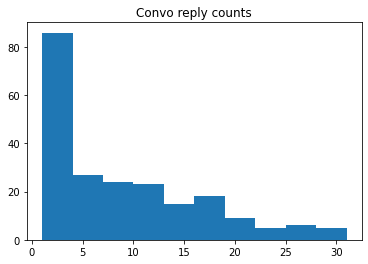

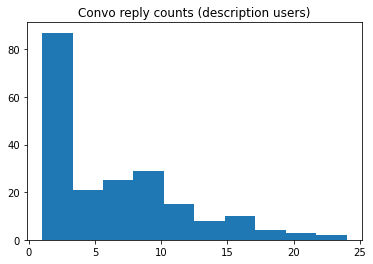

166/218 valid convos for users w/ description data


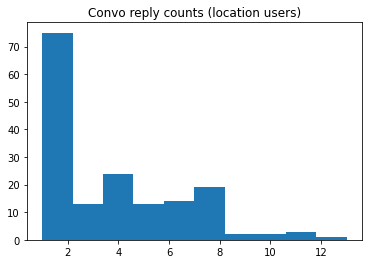

125/218 valid convos for users w/ description data


In [28]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
convo_reply_counts = reply_user_data.groupby('conversation_id').apply(lambda x: x.loc[:, 'id'].nunique()).sort_values(inplace=False, ascending=False)
plt.hist(convo_reply_counts)
plt.title('Convo reply counts')
plt.show()
## get valid convo IDs for users with descriptions
min_reply_count = 2
convo_reply_counts_description_users = reply_user_description_data.groupby('conversation_id').apply(lambda x: x.loc[:, 'id'].nunique()).sort_values(ascending=False)
plt.hist(convo_reply_counts_description_users)
plt.title('Convo reply counts (description users)')
plt.show()
valid_user_description_convo_ids = convo_reply_counts_description_users[convo_reply_counts_description_users >= min_reply_count].index.tolist()
print(f'{len(valid_user_description_convo_ids)}/{reply_user_data.loc[:, "conversation_id"].nunique()} valid convos for users w/ description data')
## get valid convo IDs for users with locations
convo_reply_counts_location_users = valid_location_data.groupby('conversation_id').apply(lambda x: x.loc[:, 'id'].nunique()).sort_values(ascending=False)
plt.hist(convo_reply_counts_location_users)
plt.title('Convo reply counts (location users)')
plt.show()
valid_user_location_convo_ids = convo_reply_counts_location_users[convo_reply_counts_location_users >= min_reply_count].index.tolist()
print(f'{len(valid_user_location_convo_ids)}/{reply_user_data.loc[:, "conversation_id"].nunique()} valid convos for users w/ description data')

In [29]:
## description users
# get user X topic matrix
user_description_topics = lda_model.transform(description_dtm)
users_with_description = reply_user_description_data.loc[:, 'username'].values
user_description_topics = pd.DataFrame(user_description_topics, index=users_with_description)
display(user_description_topics.head())
print(user_description_topics.shape)

,0,1,2,3,4
UpriserMinistry,0.015622,0.015882,0.015444,0.015526,0.937527
sarvambrahma,0.596222,0.100001,0.100004,0.102306,0.101466
hgf61734052,0.020513,0.020221,0.020096,0.919117,0.020054
hinsuke,0.015385,0.015385,0.938460,0.015385,0.015385
apredi,0.200000,0.200000,0.200000,0.200000,0.200000


(1309, 5)


In [30]:
from itertools import combinations
from sklearn.metrics.pairwise import cosine_distances, haversine_distances
from math import radians
EARTH_RADIUS = 6371000/1000  # multiply by Earth radius to get kilometers
def compute_divergence(reply_users, user_data, user_data_type='description'):
    # convert user description/location to vector
    # compute divergence between users in replies
    user_divergence = []
    for user_i, user_j in combinations(reply_users, 2):
        if(user_data_type == 'description'):
            dist_i_j = cosine_distances(user_data.loc[[user_i], :], 
                                        user_data.loc[[user_j], :])[0][0]
        elif(user_data_type == 'location'):
            # discrete locations
#             dist_i_j = (user_data.loc[user_i, :]==user_data.loc[user_j, :]).astype(int)
            # location lat/lon
            dist_i_j = haversine_distances(user_data.loc[[user_i], :].apply(lambda x: pd.Series(map(radians, x)), axis=1), 
                                           user_data.loc[[user_j], :].apply(lambda x: pd.Series(map(radians, x)), axis=1))[0][0] * EARTH_RADIUS
        user_divergence.append([user_i, user_j, dist_i_j])
    user_divergence = pd.DataFrame(user_divergence, columns=['user1','user2','dist'])
    ## compute mean pairwise divergence
    mean_user_divergence = user_divergence.loc[:, 'dist'].mean()
    return mean_user_divergence

In [36]:
## description divergence
convo_id_var = 'conversation_id'
description_data_user_names_per_convo = reply_user_data[reply_user_data.loc[:, convo_id_var].isin(valid_user_description_convo_ids)].groupby(convo_id_var).apply(lambda x: list(filter(lambda y: y in users_with_description, x.loc[:, 'username'].unique())))
description_divergence_per_convo = description_data_user_names_per_convo.progress_apply(lambda x: compute_divergence(x, user_description_topics, user_data_type='description')).sort_values(ascending=False).reset_index().rename(columns={0:'user_description_divergence'})
display(description_divergence_per_convo.head(10))
display(description_divergence_per_convo.tail(10))

100%|██████████| 166/166 [00:06<00:00, 26.68it/s]


,conversation_id,user_description_divergence
0,1456969634746351619,0.975171
1,1465697137262350336,0.970403
2,1461083478875942916,0.968139
3,1461793923639259150,0.961858
4,1466064047791652868,0.956863
5,1466044443073687553,0.956133
6,1465319648598151183,0.953958
7,1460653946549248000,0.945694
8,1459159058787848192,0.940051
9,1461742951835525123,0.937125


,conversation_id,user_description_divergence
156,1462474645265960964,0.422570
157,1463190662979981313,0.314666
158,1456697831532736512,0.298820
159,1460361355450630148,0.293667
160,1464223670499520512,0.279207
161,1463190696362668039,0.224091
162,1461299906472259586,0.098395
163,1456729287768354821,0.001745
164,1458460707394031617,0.000596
165,1460403497766166531,0.000157


In [32]:
## look at example convos with high/low divergence
high_div_example_convo_id = '1465697137262350336'
print('high div convo')
display(reply_user_description_data[reply_user_description_data.loc[:, 'conversation_id']==high_div_example_convo_id])
low_div_example_convo_id = '1458460707394031617'
print('low div convo')
display(reply_user_description_data[reply_user_description_data.loc[:, 'conversation_id']==low_div_example_convo_id])

high div convo


,text,conversation_id,in_reply_to_user_id,id,created_at,author_id,location,name,description,username,reply_user_name,reply_sents,reply_questions
0,@HHSGov @CMSGov END your unethical and unlawful vaccine mandate for facilities receiving your funding!! You are violating Title VII of the Civil Rights Act!! Employers are NOT honoring religious or medical exemptions and GOOD employees are losing their jobs! \nEND THIS MANDATE. #CMSMandate,1465697137262350336,44783853,1445387481701130246,2021-12-01T15:00:03.000Z,1.445387e+18,NaN,NerdGirl2021,"INFJ. Sapiosexual.\n\nLoves: God, writing, theater, gaming, photography, hiking, road trips, animals. #MAGA\n\nSupport our veterans and LEO's!",NerdGirl2021,hhsgov,"[@HHSGov @CMSGov END your unethical and unlawful vaccine mandate for facilities receiving your funding!!, You are violating Title VII of the Civil Rights Act!!, Employers are NOT honoring religious or medical exemptions and GOOD employees are losing their jobs!, END THIS MANDATE., #CMSMandate]",[]
2,@HHSGov how many need to die before FDA starts to care? The vaccines are not enough to save people on their death beds in the hospital. Zyesami is a therapeutic proven safe and effective. BriLife is a live vax that gives immunity to variants. Nrx cant be ignored\nhttps://t.co/iN9FGgf7pR,1465697137262350336,44783853,1349480363270287364,2021-11-30T15:02:43.000Z,1.349480e+18,NaN,Mike Larry (Price Action),Professional Investor 30+ years. Been investing since I was in diapers. Follow me and I will show you the ways if you'd like.,retardeddmf69,hhsgov,"[@HHSGov how many need to die before FDA starts to care?, The vaccines are not enough to save people on their death beds in the hospital., Zyesami is a therapeutic proven safe and effective., BriLife is a live vax that gives immunity to variants., Nrx cant be ignored\nhttps://t.co/iN9FGgf7pR]",[@HHSGov how many need to die before FDA starts to care?]


low div convo


,text,conversation_id,in_reply_to_user_id,id,created_at,author_id,location,name,description,username,reply_user_name,reply_sents,reply_questions
1,"@Gammiex4MMC @HHSGov You live in Texas, your state will stay Red. Suck it up Buttercup. So no covid tests for you.",1458460707394031617,739806752862965761,1441401651412103171,2021-11-15T02:13:43.000Z,1.441402e+18,NaN,Olivia Harvey,Married to Army Veteran. Conservative. Love my Country.,oliviaharvey479,hhsgov,"[@Gammiex4MMC @HHSGov You live in Texas, your state will stay Red., Suck it up Buttercup., So no covid tests for you.]",[]
3,@HHSGov But we aren’t having a shortage of testing kits.,1458460707394031617,44783853,739806752862965761,2021-11-14T03:29:49.000Z,1.502833e+08,Blue in home of #TexasTaliban,M has had enough! #GunReform #VoteBlue,Widow/mom/grandmother #BoycottTexas #GQPDomesticTraitors pro #MaskMandate #VaccinesSaveLives #ProChoice Catholic,Gammiex4MMC,hhsgov,[@HHSGov But we aren’t having a shortage of testing kits.],[]
5,@HHSGov Why are spending so much when a breathalyzer is coming soon? It seems like a lot of waste.,1458460707394031617,44783853,25808275,2021-11-10T21:18:28.000Z,1.478731e+07,"Nightmerica, USA",Propaganda Watch,MSM is the Enemy of Humanity and the Mouthpiece of EviL,ColdDivided,hhsgov,"[@HHSGov Why are spending so much when a breathalyzer is coming soon?, It seems like a lot of waste.]",[@HHSGov Why are spending so much when a breathalyzer is coming soon?]
7,@HHSGov https://t.co/YfslU9Xrrb,1458460707394031617,44783853,409676436,2021-11-10T15:57:32.000Z,2.214551e+09,🍄🎸🥃West Of Here ❄🏂🌲,Speemerson,#RealNotRare\n#Pfizer #VaccineInjured\nLot ER8730/8731\nCardiovascular\nHematological\nNeurological\nImmunological\nPreviously Healthy Athlete\n#ProtectTheKids,Speemy,hhsgov,[@HHSGov https://t.co/YfslU9Xrrb],[]


In [37]:
## same thing but locations
## location divergence
dedup_valid_location_data = valid_location_data.drop_duplicates('username')
users_with_location = dedup_valid_location_data.loc[:, 'username'].values
convo_id_var = 'conversation_id'
user_location_lat_lon = dedup_valid_location_data.loc[:, ['geocode_location_lat', 'geocode_location_lon']]
user_location_lat_lon.index = users_with_location
location_data_user_names_per_convo = reply_user_data[reply_user_data.loc[:, convo_id_var].isin(valid_user_location_convo_ids)].groupby(convo_id_var).apply(lambda x: list(filter(lambda y: y in users_with_location, x.loc[:, 'username'].unique())))
location_divergence_per_convo = location_data_user_names_per_convo.progress_apply(lambda x: compute_divergence(x, user_location_lat_lon, user_data_type='location')).sort_values(ascending=False).reset_index().rename(columns={0:'user_location_divergence'})
display(location_divergence_per_convo.head(10))
display(location_divergence_per_convo.tail(10))

100%|██████████| 125/125 [00:02<00:00, 43.05it/s]


,conversation_id,user_location_divergence
0,1463190662979981313,15018.703038
1,1463915395455332355,14674.210454
2,1461837881740251144,14443.187450
3,1462860185073078280,14436.866566
4,1462474645265960964,11613.798638
5,1463605863017594885,10252.660087
6,1457377334860914688,9906.383776
7,1466015621833842700,9740.920438
8,1466016652630310912,9423.024771
9,1466399374829932548,9080.137542


,conversation_id,user_location_divergence
115,1456350540426735624,731.754610
116,1460623709178404868,683.670522
117,1461856541745758210,666.358604
118,1461695772437716994,605.127294
119,1462872518491086852,534.562960
120,1461093442784800771,480.963221
121,1463258556921225224,332.383418
122,1461427581765533698,173.645265
123,1466064047791652868,143.591183
124,1466175982151389185,131.463378


In [34]:
## look at example convos with high/low divergence
high_div_example_convo_id = '1463190662979981313'
print('high div convo')
display(reply_user_description_data[reply_user_description_data.loc[:, 'conversation_id']==high_div_example_convo_id])
low_div_example_convo_id = '1466064047791652868'
print('low div convo')
display(reply_user_description_data[reply_user_description_data.loc[:, 'conversation_id']==low_div_example_convo_id])

high div convo


,text,conversation_id,in_reply_to_user_id,id,created_at,author_id,location,name,description,username,reply_user_name,reply_sents,reply_questions
2,@HHSGov Stop pushing this death shot on people especially kids,1463190662979981313,44783853,1211194173723820033,2021-11-25T05:16:31.000Z,1.211194e+18,NaN,PatsyPatriot,"Truther, Love My Country, Against Tyranny",PatsyPatriot,hhsgov,[@HHSGov Stop pushing this death shot on people especially kids],[]
5,@HHSGov 🤡🤡🤡,1463190662979981313,44783853,1324771808755605507,2021-11-23T18:37:38.000Z,1.324772e+18,Hyperborea,1911 Respecter 🎄,Habitual state line crosser,1911Respecter,hhsgov,[@HHSGov 🤡🤡🤡],[]
6,"@HHSGov @pfizer @US_FDA @CDCgov 1053 traffic deaths in 12 months compared to 94 covid deaths in 22.5 months.\n\nStill tossing the kids in the back of the sedan? Seriously, why would you do that? If these numbers are that concerning to you park the car and toss the keys.\n\nhttps://t.co/izV8JCM8K8 https://t.co/Tvxyz7h3u3",1463190662979981313,1429071660104228879,1429071660104228879,2021-11-23T17:37:41.000Z,1.429072e+18,NaN,TheTailWagsTheDog ॐ,"See pin for ✨@NIH✨ published studies on readily available, safe & inexpensive supplements for the PREVENTION & treatment of Covid-19 & Flu. \n\nDO NOT FOLLOW",TheTailWagsDog,hhsgov,"[@HHSGov @pfizer @US_FDA @CDCgov 1053 traffic deaths in 12 months compared to 94 covid deaths in 22.5 months., Still tossing the kids in the back of the sedan?, Seriously, why would you do that?, If these numbers are that concerning to you park the car and toss the keys., https://t.co/izV8JCM8K8 https://t.co/Tvxyz7h3u3]","[Still tossing the kids in the back of the sedan?, Seriously, why would you do that?]"
9,@ToTheLifeboats @HHSGov https://t.co/t9iyl3HWG5,1463190662979981313,1411916304647344129,849153220668686336,2021-11-23T17:22:53.000Z,1.332122e+18,"Colorado, USA",Daniel,The road to hell is paved with good intentions,Dmac10787,hhsgov,[@ToTheLifeboats @HHSGov https://t.co/t9iyl3HWG5],[]
10,@HHSGov Roll the dice and see if your kid survives their bioweapon. https://t.co/uy4iLmNTM5,1463190662979981313,44783853,1458317488127676419,2021-11-23T17:15:47.000Z,1.411916e+18,Dar es Salaam,Michael Yates,"Africa, no covid, no jabs, cheap living, cheap organic food, great weather, minimal oppression you see in western nations.",Chrckmate,hhsgov,"[@HHSGov Roll the dice and see if your kid survives their bioweapon., https://t.co/uy4iLmNTM5]",[]


low div convo


,text,conversation_id,in_reply_to_user_id,id,created_at,author_id,location,name,description,username,reply_user_name,reply_sents,reply_questions
0,"@MichiganHHS Mask mandate now. People with HIV may not effectively mount an adequate response to vaccines. Let’s protect them and so many others, which will help protect us all. We have home grown variants in Mi. Let’s stop transmission fast. https://t.co/Csb4TChwBv",1466064047791652868,57338289,2802140458,2021-12-01T15:54:28.000Z,2.802140e+09,"Michigan, USA","Diane Hallinen, MD","Physician. Picture is Harold. Wear a well fitted high filtration mask, get vaccinated, keep CO2 less than 600 ppm & use Hepa or a Corsi-Rosenthal cube.",hallinen_diane,MichiganHHS,"[@MichiganHHS Mask mandate now., People with HIV may not effectively mount an adequate response to vaccines., Let’s protect them and so many others, which will help protect us all., We have home grown variants in Mi., Let’s stop transmission fast., https://t.co/Csb4TChwBv]",[]
1,@MichiganHHS Thanks Fauci https://t.co/ubXKVgXl28,1466064047791652868,57338289,1353104859885674501,2021-12-01T15:50:05.000Z,1.353105e+18,"Hell, MI",ThePhilosopherStoned,Literary Quoter | Aspiring Author | It Starts At Home,KingLeo67th,MichiganHHS,[@MichiganHHS Thanks Fauci https://t.co/ubXKVgXl28],[]


OK! The divergence metrics seem to be working as intended.

Let's see if posts that attract higher-divergence repliers are different in their original topic than posts that attract low-divergence repliers.

In [52]:
## attach divergence scores to original post; check text for high-divergence vs. low-divergence
combined_timeline_reply_data = pd.merge(
    account_timeline_data.drop('conversation_id', axis=1),
    account_reply_data.loc[:, ['conversation_id', 'id', 'description', 'location', 'text']].rename(columns={'id' : 'reply_id', 'text' : 'reply_text', 'description' : 'reply_user_description', 'location' : 'reply_user_location'}),
    left_on='id', right_on='conversation_id', how='inner',
)
display(combined_timeline_reply_data.head())
## add divergence
combined_timeline_reply_data = pd.merge(combined_timeline_reply_data, description_divergence_per_convo,
                                        on='conversation_id', how='inner')
combined_timeline_reply_data = pd.merge(combined_timeline_reply_data, location_divergence_per_convo,
                                        on='conversation_id', how='inner')
display(combined_timeline_reply_data.head())
print(combined_timeline_reply_data.shape[0])

,id,text,attachments,author_id,context_annotations,created_at,entities,geo,in_reply_to_user_id,lang,...,reply_settings,source,withheld,matching_rules,user_name,conversation_id,reply_id,reply_user_description,reply_user_location,reply_text
0,1466406803017715715,.@HHSOCR Director Lisa J. Pino shared a statement of solidarity in support of people living with HIV in commemoration of #WorldAIDSDay. Learn more: https://t.co/sUgm2iDwR2,NaN,44783853,NaN,2021-12-02T14:00:01.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,hhsgov,1466406803017715715,976899445517373440,General Post Master for the General Post Office for The United States of America\n\nWriter for the American Herald Newspaper\n\nhttps://t.co/50PoQtdW9e,State of Massachusetts-Bay,@HHSGov @HHSOCR Notice of Default on Collections: https://t.co/FUXHte4Mfp\nThird Notice - https://t.co/9Vu8799y2j\nSecond Notice - https://t.co/oOuX9bzG4v\nNotice of Federal Common Law Lien -https://t.co/Phi1bMGYnR
1,1466176641542107142,COVID-19 vaccines are our best tool to avoid serious illness and hospitalization. Find vaccines near you: https://t.co/wcXk7LpWCH https://t.co/TP4LgeZxFW,NaN,44783853,NaN,2021-12-01T22:45:26.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,hhsgov,1466176641542107142,1462385979172478979,NaN,NaN,@HHSGov https://t.co/Xk82Ozj9c4
2,1466176641542107142,COVID-19 vaccines are our best tool to avoid serious illness and hospitalization. Find vaccines near you: https://t.co/wcXk7LpWCH https://t.co/TP4LgeZxFW,NaN,44783853,NaN,2021-12-01T22:45:26.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,hhsgov,1466176641542107142,1290275195761065987,NaN,NaN,"@HHSGov The Gene therapy does not work for covid. \nUFC president Dana White said him and his family have tested positive for COVID-19, despite being vaccinated\nhttps://t.co/11ajWwaX8A"
3,1466176641542107142,COVID-19 vaccines are our best tool to avoid serious illness and hospitalization. Find vaccines near you: https://t.co/wcXk7LpWCH https://t.co/TP4LgeZxFW,NaN,44783853,NaN,2021-12-01T22:45:26.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,hhsgov,1466176641542107142,1318802921983627265,"Advaitic Theist, Worldly Wise: American Anglo-Saxon-Celtic-Dutch mutt",NaN,"@hokiesquid @HHSGov Right, where are the mandates for those things in order to work and go into stores?"
4,1466176641542107142,COVID-19 vaccines are our best tool to avoid serious illness and hospitalization. Find vaccines near you: https://t.co/wcXk7LpWCH https://t.co/TP4LgeZxFW,NaN,44783853,NaN,2021-12-01T22:45:26.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,hhsgov,1466176641542107142,825219352987320320,NaN,NaN,@gem_maddie @HHSGov Not everyone is vaccinated- not even close. This virus will be around in one form or another indefinitely.


,id,text,attachments,author_id,context_annotations,created_at,entities,geo,in_reply_to_user_id,lang,...,withheld,matching_rules,user_name,conversation_id,reply_id,reply_user_description,reply_user_location,reply_text,user_description_divergence,user_location_divergence
0,1466176641542107142,COVID-19 vaccines are our best tool to avoid serious illness and hospitalization. Find vaccines near you: https://t.co/wcXk7LpWCH https://t.co/TP4LgeZxFW,NaN,44783853,NaN,2021-12-01T22:45:26.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,hhsgov,1466176641542107142,1462385979172478979,NaN,NaN,@HHSGov https://t.co/Xk82Ozj9c4,0.584939,1411.032511
1,1466176641542107142,COVID-19 vaccines are our best tool to avoid serious illness and hospitalization. Find vaccines near you: https://t.co/wcXk7LpWCH https://t.co/TP4LgeZxFW,NaN,44783853,NaN,2021-12-01T22:45:26.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,hhsgov,1466176641542107142,1290275195761065987,NaN,NaN,"@HHSGov The Gene therapy does not work for covid. \nUFC president Dana White said him and his family have tested positive for COVID-19, despite being vaccinated\nhttps://t.co/11ajWwaX8A",0.584939,1411.032511
2,1466176641542107142,COVID-19 vaccines are our best tool to avoid serious illness and hospitalization. Find vaccines near you: https://t.co/wcXk7LpWCH https://t.co/TP4LgeZxFW,NaN,44783853,NaN,2021-12-01T22:45:26.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,hhsgov,1466176641542107142,1318802921983627265,"Advaitic Theist, Worldly Wise: American Anglo-Saxon-Celtic-Dutch mutt",NaN,"@hokiesquid @HHSGov Right, where are the mandates for those things in order to work and go into stores?",0.584939,1411.032511
3,1466176641542107142,COVID-19 vaccines are our best tool to avoid serious illness and hospitalization. Find vaccines near you: https://t.co/wcXk7LpWCH https://t.co/TP4LgeZxFW,NaN,44783853,NaN,2021-12-01T22:45:26.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,hhsgov,1466176641542107142,825219352987320320,NaN,NaN,@gem_maddie @HHSGov Not everyone is vaccinated- not even close. This virus will be around in one form or another indefinitely.,0.584939,1411.032511
4,1466176641542107142,COVID-19 vaccines are our best tool to avoid serious illness and hospitalization. Find vaccines near you: https://t.co/wcXk7LpWCH https://t.co/TP4LgeZxFW,NaN,44783853,NaN,2021-12-01T22:45:26.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,hhsgov,1466176641542107142,1451376202153930752,"Pessimistic people are defeated by themselves first, and then by life; Optimistic people, first overcome themselves, and then overcome life",NaN,@HHSGov Very interesting,0.584939,1411.032511


3108


In [72]:
## sort by both 
divergence_types = ['user_description_divergence', 'user_location_divergence']
top_k = 10
for divergence_type_i in divergence_types:
    print(f'divergence score = {divergence_type_i}')
    divergence_var_i = f"reply_user_{divergence_type_i.split('_')[1]}"
    print('high-divergence examples')
    ## high divergence
    high_score_ids_i = combined_timeline_reply_data.sort_values(divergence_type_i, inplace=False, ascending=False).loc[:, 'conversation_id'].drop_duplicates().values
    display_cols = ['text', 'user_name', 'reply_text', 'reply_user_description', 'reply_user_location', divergence_type_i]
    for j in range(top_k):
        data_j = combined_timeline_reply_data[combined_timeline_reply_data.loc[:, 'conversation_id']==high_score_ids_i[j]].dropna(subset=[divergence_var_i])
        display(data_j.loc[:, display_cols].head(5))
    ## low divergence
    print('low-divergence examples')
    low_score_ids_i = combined_timeline_reply_data.sort_values(divergence_type_i, inplace=False, ascending=True).loc[:, 'conversation_id'].drop_duplicates().values
    display_cols = ['text', 'user_name', 'reply_text', 'reply_user_description', 'reply_user_location', divergence_type_i]
    for j in range(top_k):
        data_j = combined_timeline_reply_data[combined_timeline_reply_data.loc[:, 'conversation_id']==low_score_ids_i[j]].dropna(subset=[divergence_var_i])
        display(data_j.loc[:, display_cols].head(5))

divergence score = user_description_divergence
high-divergence examples


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
322,"Today, HHS w/ @USDOL, @USTreasury and @USOPM issues new rule to improve transparency, competition and oversight on prescription drugs and medical costs. https://t.co/EPvXIoQ0jF https://t.co/yFSw4hnFBr",hhsgov,@HHSGov @USDOL @USTreasury @USOPM Link to information does not work.,"Engineer, Producer, Composer & Musician/ Science & Tech Nerd. Slightly Insane Keyboardist. Music maker at Seasons Of Change \m/ \m/","Arizona City, AZ",0.968139
323,"Today, HHS w/ @USDOL, @USTreasury and @USOPM issues new rule to improve transparency, competition and oversight on prescription drugs and medical costs. https://t.co/EPvXIoQ0jF https://t.co/yFSw4hnFBr",hhsgov,"@HHSGov @USDOL @USTreasury @USOPM WHY ARE DRUG PRICES SO HIGH? \n\n""I mean, how in the world can one explain that Congress actually passed a law prohibiting Medicare from negotiating drug prices?”\n\n#EndThePatents \n\nhttps://t.co/0rjpfys8I3","Both parties = SAME CORRUPT DONORS\n Red team Vs Blue team = Divide & Conquer\n\n HUMANIST, M4A, GND, BLM, MMT, 🚫 PIC, 🚫 MIC",USA,0.968139


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
230,HHS leaders are recognizing #TransgenderDayOfRemembrance on November 20 in memory of the lives of transgender people tragically lost to violence in the last year. Read @HHS_ASH’s statement to learn more: https://t.co/hQLjDWIlma. https://t.co/q1BEgdx6jX,hhsgov,@HHSGov @HHS_ASH You're a dude who thinks he's a woman. That's what YOU should remember.,"Married, nosy, old, tired, working, honest, fairly intelligent, not easily fooled. Call me at 618-615-0760.","Thebes, Ill.",0.961858
231,HHS leaders are recognizing #TransgenderDayOfRemembrance on November 20 in memory of the lives of transgender people tragically lost to violence in the last year. Read @HHS_ASH’s statement to learn more: https://t.co/hQLjDWIlma. https://t.co/q1BEgdx6jX,hhsgov,@HHSGov @HHS_ASH Mental health disphoria is a pandemic disease,"If not us, who?\nIf not now, when?\n\nMarlene and Richard's first born male.","Minneapolis, MN",0.961858
232,HHS leaders are recognizing #TransgenderDayOfRemembrance on November 20 in memory of the lives of transgender people tragically lost to violence in the last year. Read @HHS_ASH’s statement to learn more: https://t.co/hQLjDWIlma. https://t.co/q1BEgdx6jX,hhsgov,@HHSGov @HHS_ASH When did you first accept that load of cash to peddle leftist propaganda? \n\nLet’s remember that date too. \n\n#BoughtOffDayofShame https://t.co/QrA7Z39Lpl,AnCap. Christianity. Crypto. Blockchain. $XRP $BTC #FreeRoss #FreeAssange #FreeSnowden,Earth,0.961858
233,HHS leaders are recognizing #TransgenderDayOfRemembrance on November 20 in memory of the lives of transgender people tragically lost to violence in the last year. Read @HHS_ASH’s statement to learn more: https://t.co/hQLjDWIlma. https://t.co/q1BEgdx6jX,hhsgov,@HHSGov @HHS_ASH Good luck with that. 🤦🏻‍♂️ https://t.co/ZYGygCAwsu,Fuck Joe Biden,NaN,0.961858
234,HHS leaders are recognizing #TransgenderDayOfRemembrance on November 20 in memory of the lives of transgender people tragically lost to violence in the last year. Read @HHS_ASH’s statement to learn more: https://t.co/hQLjDWIlma. https://t.co/q1BEgdx6jX,hhsgov,@HHSGov @HHS_ASH Sorry but today is officially Kyle Rittenhouse day,"I STRESS TO EVERYONE THAT LIKES +RE-POSTS MY TWEETS.I AM NOT AN ANTI-VAXER/I ONLY WANT WATS BEST FOR MY FAMILY,FRIENDS,COMMUNITY,STATE AND FELLOW COUNTRYMAN .","Naval Base Kitsap, WA",0.961858


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
2861,"Today is #WorldAIDSDay! A day to remember those we have lost to AIDS and honor people in our community who are living with HIV. We also highlight the importance of HIV testing, treatment, prevention, and stigma reduction. Learn more at https://t.co/rv0aq0M5PQ. https://t.co/k2mVOgoSmJ",MichiganHHS,"@MichiganHHS Mask mandate now. People with HIV may not effectively mount an adequate response to vaccines. Let’s protect them and so many others, which will help protect us all. We have home grown variants in Mi. Let’s stop transmission fast. https://t.co/Csb4TChwBv","Physician. Picture is Harold. Wear a well fitted high filtration mask, get vaccinated, keep CO2 less than 600 ppm & use Hepa or a Corsi-Rosenthal cube.","Michigan, USA",0.956863
2862,"Today is #WorldAIDSDay! A day to remember those we have lost to AIDS and honor people in our community who are living with HIV. We also highlight the importance of HIV testing, treatment, prevention, and stigma reduction. Learn more at https://t.co/rv0aq0M5PQ. https://t.co/k2mVOgoSmJ",MichiganHHS,@MichiganHHS Thanks Fauci https://t.co/ubXKVgXl28,Literary Quoter | Aspiring Author | It Starts At Home,"Hell, MI",0.956863


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
363,"CDC recommends that everyone age 5 and up gets a COVID-19 vaccine to build important protection against severe COVID-19 illness, including Delta and other variants. \n\nKeep your child safe. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/obufvQRtMU",hhsgov,"@HHSGov Americans and therefore all humans on this planet that share a common bond to stay safe and healthy would do what's necessary for controlling the spread of any virus whether it is the Flu virus, Cold virus, HIV virus, or Covid virus, especially in close courters. Vaccines work!💪",AMERICA STRONG!,NaN,0.945694
364,"CDC recommends that everyone age 5 and up gets a COVID-19 vaccine to build important protection against severe COVID-19 illness, including Delta and other variants. \n\nKeep your child safe. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/obufvQRtMU",hhsgov,"@HHSGov Florida has officially surpassed 1,000 manatee deaths in 2021. It's the deadliest year on record for the state's species.\nhttps://t.co/2PwpUAUshl\n""EVEN THE MANATEES HAVE NO MANDATES!""\nThanks, DeSantis we will just add them to the already 60,846 DEAD FLORIDIANS UNDER YOUR WATCH!",Fully Vaccinated!😊 Southern California💙\nArtist🎨A global citizen🫂~❤️~✌️ Climate change is REAL 🌍🔥🌦️🌞🐦🌳🐠🐧⛰️💨🗻♻️🐝🦋🎴🥀,USA,0.945694
365,"CDC recommends that everyone age 5 and up gets a COVID-19 vaccine to build important protection against severe COVID-19 illness, including Delta and other variants. \n\nKeep your child safe. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/obufvQRtMU",hhsgov,"@HHSGov ""KEEP UP THE GREAT WORK NIKKI FRIED"" Continue to guide and support Floridians with their deep concerns about DeSantis continuing to strip away at our futures in Florida. ""The Real Floridians have your back!"" 🇺🇸💪","It's Complicated, lol",Florida,0.945694
366,"CDC recommends that everyone age 5 and up gets a COVID-19 vaccine to build important protection against severe COVID-19 illness, including Delta and other variants. \n\nKeep your child safe. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/obufvQRtMU",hhsgov,"@HHSGov ""EVERY AMERICAN PRESIDENT"" has a written playbook on how to control deadly diseases during their leadership which Trump and the GOP have deliberately ignored from day one and even leading up to today! ""VOTE OUT IGNORANCE"" and ""MAKE AMERICA HEALTHY AGAIN"" 💪🇺🇸","#Christian #AntiWar #SoundMoney #Keto #MGBgt ""For God has not given us a spirit of fear and timidity, but of power, love, and self-discipline.” 2 Tim 1:7","Sheridan, WY",0.945694
367,"CDC recommends that everyone age 5 and up gets a COVID-19 vaccine to build important protection against severe COVID-19 illness, including Delta and other variants. \n\nKeep your child safe. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/obufvQRtMU",hhsgov,@HHSGov https://t.co/5T11OoBRCs,Aspiring voice actor and a big fan of wrestling,"Hemet,CA",0.945694


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
410,Did you know #smoking increases your risk of developing #pneumonia? Make #WorldPneumoniaDay your quit day with help and support at https://t.co/UOPLgg33fE. @SmokeFreeUS https://t.co/ONlSgI2bEM,hhsgov,@HHSGov @FDATobacco @SmokefreeUs https://t.co/jv6Z10PFOE,🖕F**K The Communist Trump 🖕,Harpers Ferry,0.940051
411,Did you know #smoking increases your risk of developing #pneumonia? Make #WorldPneumoniaDay your quit day with help and support at https://t.co/UOPLgg33fE. @SmokeFreeUS https://t.co/ONlSgI2bEM,hhsgov,"@HHSGov @SmokefreeUs Smokers have less chance of getting Covid, though, so there’s that.",Starting over after having my account taken down again. It’s anti-social media w all the censorship.,United States,0.940051


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
2408,New @CDCMMWR report gives insight into #AIAN #homicide. Using these important National Violent Death Reporting System (#NVDRS) data with AI/AN community and cultural traditions can help shape effective violence prevention efforts. Learn more: https://t.co/PLb6m2X8SB. https://t.co/lG5KkyEhuA,CDCgov,@CDCgov @CDCMMWR https://t.co/I0jM33bUJC.table2e ivermectin clinical trials for treatment of COVID-19. Make it make sense. The American people have been defrauded. Nuremberg trials to follow,יהשרה,NaN,0.937125
2409,New @CDCMMWR report gives insight into #AIAN #homicide. Using these important National Violent Death Reporting System (#NVDRS) data with AI/AN community and cultural traditions can help shape effective violence prevention efforts. Learn more: https://t.co/PLb6m2X8SB. https://t.co/lG5KkyEhuA,CDCgov,@CDCgov @CDCMMWR #BlackCrimesMatter,I'm not afraid to tell you to fuck off,MingTung CN,0.937125
2410,New @CDCMMWR report gives insight into #AIAN #homicide. Using these important National Violent Death Reporting System (#NVDRS) data with AI/AN community and cultural traditions can help shape effective violence prevention efforts. Learn more: https://t.co/PLb6m2X8SB. https://t.co/lG5KkyEhuA,CDCgov,"@CDCgov @ncdhhs @CDCMMWR Uh yeah, we are really gonna look at that as you will most likely kill/maim millions &amp; have lied to the American public for 2 years.\nChanging definitions\nAided/abetted gain of function research\nnow...\n\nWhisteblower coming out\n\nNow this..\nhttps://t.co/hdbR9qj6T1","@dnc 2024 Slogans\nWe leave MANY MEN BEHIND OR\nTaliban, built back better ?\nPoint Out @DNC STUPIDITY @CantWinEmAll2",NaN,0.937125
2411,New @CDCMMWR report gives insight into #AIAN #homicide. Using these important National Violent Death Reporting System (#NVDRS) data with AI/AN community and cultural traditions can help shape effective violence prevention efforts. Learn more: https://t.co/PLb6m2X8SB. https://t.co/lG5KkyEhuA,CDCgov,@CDCgov @CDCMMWR https://t.co/zogw2T9jNv,"I STRESS TO EVERYONE THAT LIKES +RE-POSTS MY TWEETS.I AM NOT AN ANTI-VAXER/I ONLY WANT WATS BEST FOR MY FAMILY,FRIENDS,COMMUNITY,STATE AND FELLOW COUNTRYMAN .","Naval Base Kitsap, WA",0.937125
2412,New @CDCMMWR report gives insight into #AIAN #homicide. Using these important National Violent Death Reporting System (#NVDRS) data with AI/AN community and cultural traditions can help shape effective violence prevention efforts. Learn more: https://t.co/PLb6m2X8SB. https://t.co/lG5KkyEhuA,CDCgov,"@CDCgov @CDCMMWR Are deaths from vaccine injury considered ""violent"" if they are imposed upon a person by a powerful entity (e.g., a government, a large business)?\nIf so, how could we prevent such a tragedy?","Freelance writer.\nWords in @amconmag, @FDRLST, @TownhallCom, @realDailyWire, @DailyCaller, @LifeZette\nLibertarian-ish | Civilly Disobedient |Panpartisan gadfly",USA,0.937125


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
314,"Providers can use telehealth to help make health care more accessible to patients, no matter where they are. Find #telehealth resources for providers here: https://t.co/d0ezWke7wW. #RuralHealthDay https://t.co/xtytTQdrzV",hhsgov,@HHSGov Our “rural health” populations need two $500 labs and instructions on a rice cooker.\n\n@Huel Black is for protein. The prebiotic fiber FOS is $0.05/day. \n\nI-O-N’s lab w/ CoQ10: https://t.co/hvfjK7kOzV\n\nThe latest microbiome lab: https://t.co/Gi9euJuW6P https://t.co/GezJVFVlvn,"“Killing Me Softly” is about me in “Learn To Fly,” ""Machinehead (FOS+Zn+P5P),"" and “Change” from “White Pony."" LU Lauryn. ""Descending"" is a prophet’s Abyss.","Maplewood, MO",0.935607
315,"Providers can use telehealth to help make health care more accessible to patients, no matter where they are. Find #telehealth resources for providers here: https://t.co/d0ezWke7wW. #RuralHealthDay https://t.co/xtytTQdrzV",hhsgov,@HHSGov Preliminary results from a new West Virginia University pilot program show that telehealth can help individuals transitioning to home from a long-term care facility remain healthy and happy in their own communities ⬇️\n\nhttps://t.co/WEz2LGMBYe,Improving the quality of life for West Virginians and all who call Appalachia home.,"Morgantown, WV",0.935607


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
2859,"MDHHS extends heartfelt condolences to all those affected by the tragic shooting at Oxford High School yesterday. Resources, including communication guides to speak with children about violence and to help them cope through the tragedy, are available at https://t.co/HCJ9DseOtb.",MichiganHHS,"@MichiganHHS Hopefully, MHHS tweets this information after all known acts of violence in MI regardless of where, who, why or how.","Environmental Justice and Advocacy;\nHuman Trafficking Awareness; Disaster Relief Assistance; Information, Education and Referral.","Detroit, Michigan - United States",0.932275
2860,"MDHHS extends heartfelt condolences to all those affected by the tragic shooting at Oxford High School yesterday. Resources, including communication guides to speak with children about violence and to help them cope through the tragedy, are available at https://t.co/HCJ9DseOtb.",MichiganHHS,We encourage those who need support due to emotional stress or trauma to reach out to a health care provider or call 2-1-1 for local resources that can meet your needs.,Michigan's Department of Health and Human Services,"Lansing, Michigan",0.932275


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
2863,"The COVID vaccine is proven to reduce your risk of hospitalization and death. This holiday season, do your part to protect the people you love. Find your vaccine by visiting https://t.co/upC1OyOnIh, calling 211, or texting your zip code to 438829. https://t.co/ZPZZrkFgrd",MichiganHHS,@MichiganHHS Total crock of bs.,"Ret US Army, Ret DAC & Ret Def Contractor. Proud son of a WWII Pacific vet. American ancestors back to 1600s. MacArthur SATX ‘71, TX A&I ‘75 & UWyo ‘79.","Winter TX, Summer MI",0.921572
2866,"The COVID vaccine is proven to reduce your risk of hospitalization and death. This holiday season, do your part to protect the people you love. Find your vaccine by visiting https://t.co/upC1OyOnIh, calling 211, or texting your zip code to 438829. https://t.co/ZPZZrkFgrd",MichiganHHS,@MichiganHHS my son he is sick https://t.co/uP2zoYxGpW,"NSFW content ahead | half man, half demon, full dumbass. | 💖 @C4VVES 💖 | priv @demifriendo |",he/they + transmasc afronative,0.921572
2868,"The COVID vaccine is proven to reduce your risk of hospitalization and death. This holiday season, do your part to protect the people you love. Find your vaccine by visiting https://t.co/upC1OyOnIh, calling 211, or texting your zip code to 438829. https://t.co/ZPZZrkFgrd",MichiganHHS,@SamSpad47552669 @MichiganHHS SamSpud4321098765432 has spoken.,Like an angel with clip-on wings. Opinions are my own.,"Michigan, USA",0.921572
2869,"The COVID vaccine is proven to reduce your risk of hospitalization and death. This holiday season, do your part to protect the people you love. Find your vaccine by visiting https://t.co/upC1OyOnIh, calling 211, or texting your zip code to 438829. https://t.co/ZPZZrkFgrd",MichiganHHS,@MichiganHHS Mask mandate now.,"Physician. Picture is Harold. Wear a well fitted high filtration mask, get vaccinated, keep CO2 less than 600 ppm & use Hepa or a Corsi-Rosenthal cube.","Michigan, USA",0.921572
2870,"The COVID vaccine is proven to reduce your risk of hospitalization and death. This holiday season, do your part to protect the people you love. Find your vaccine by visiting https://t.co/upC1OyOnIh, calling 211, or texting your zip code to 438829. https://t.co/ZPZZrkFgrd",MichiganHHS,@MichiganHHS 🤣🤣 no it hasn’t.,Owner of Rick’s Cafe Americain.,Casablanca,0.921572


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
272,"This World Antimicrobial Awareness Week, Assistant Secretary of the Office of Global Affairs, Loyce Pace highlights how OGA prioritizes #Antimicrobialresistance efforts and invites everyone to increase their awareness of global #AMR. #WAAW2021 @HHS_Global https://t.co/qnKcBHtki5",hhsgov,@HHSGov @HHS_Global No thanks-Not interested in anything Biden's admin does,I live and breathe for my kids.,"Omaha, Ne",0.899932
273,"This World Antimicrobial Awareness Week, Assistant Secretary of the Office of Global Affairs, Loyce Pace highlights how OGA prioritizes #Antimicrobialresistance efforts and invites everyone to increase their awareness of global #AMR. #WAAW2021 @HHS_Global https://t.co/qnKcBHtki5",hhsgov,@HHSGov @HHS_Global Thank god!! We were running out of things to be afraid of 🙏🏿💀,Fiery but mostly peaceful 🔥🐸🙏🏼,"Nashville, TN",0.899932


low-divergence examples


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
155,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,"@HHSGov Americans and therefore all humans on this planet that share a common bond to stay safe and healthy would do what's necessary for controlling the spread of any virus whether it is the Flu virus, Cold virus, HIV virus, or Covid virus, especially in close courters. Vaccines work!💪",AMERICA STRONG!,NaN,0.314666
156,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,@HHSGov Stop pushing this death shot on people especially kids,"Truther, Love My Country, Against Tyranny",NaN,0.314666
157,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,"@HHSGov MANDATE IS TYRANNY!\nThis disgusting vaccine isn't a Covid-19 prevention, instead, is an experiment and a poison!\nThe Nuremberg Code https://t.co/KSi8Pv0wLS\n#IWillNotComply #BidenMustResign #BidenIsADisgrace #SayNoToCommunism\n#LetsGoBrandon #FJoeBiden \n#EmptyShelvesBiden",Animal lover. English and spanish language. Love my country USA,"Palmetto Bay,FL",0.314666
158,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,@Anglica85600263's account is temporarily unavailable because it violates the Twitter Media Policy. Learn more.,@Anglica85600263's account is temporarily unavailable because it violates the Twitter Media Policy. Learn more.,NaN,0.314666
159,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,@HHSGov 🤡🤡🤡,Habitual state line crosser,Hyperborea,0.314666


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
2053,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,@CDCgov https://t.co/yj5YfAIMCq,I'm not afraid to tell you to fuck off,MingTung CN,0.42257
2054,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,@CDCgov CDC propaganda &amp; pseudo-science is pervasive &amp; has caused enormous damage &amp; unnecessary deaths across the world. Here is real world experience where data manipulation isn't tolerated: https://t.co/EknvheGzw8,Retired Federal Service,"San Antonio, TX",0.42257
2057,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,@CDCgov https://t.co/RsYi6zo1XR,"Fishing, Family and the Universal Source",USA,0.42257
2059,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,"@kali_void @drifter_silent @Speak_Kind @DawnGoodsell When I said basic math, I was referring to the other guy’s math when he gave those percentages. No one is bitching at you. We are all having a civil conversation before you introduced that demeanor",#wxtwitter,NaN,0.42257
2060,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,@kali_void @drifter_silent @Speak_Kind @DawnGoodsell What? I was siding with you. 😂😂😂😂..... no need to be so furious. Okay then🤷‍♂️ keep working at retail,US Army Veteran (Ret) | God above all - God wins | Matthew 6:33 | Oath 02/13/1983 - never expires | #WoundedWarriors | Owner of Pappy's Aquatics and Aquariums,NaN,0.42257


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
1743,"Everyone ages 18+ is eligible for a #COVID19 booster shot at least 6 months after a 2-dose vaccine or 2 months after a 1-dose vaccine. \n\nWhen it’s time, schedule your booster by:\n💻 Going to https://t.co/2akIUZ14Rd\n📱 Texting your ZIP code to 438829\n📞 Calling 1-800-232-0233 https://t.co/jNvDFwohFy",CDCgov,@CDCgov https://t.co/XfKzOmshy1,Truth justice and the American way Human rights for the world,Truthville USA,0.435128
1745,"Everyone ages 18+ is eligible for a #COVID19 booster shot at least 6 months after a 2-dose vaccine or 2 months after a 1-dose vaccine. \n\nWhen it’s time, schedule your booster by:\n💻 Going to https://t.co/2akIUZ14Rd\n📱 Texting your ZIP code to 438829\n📞 Calling 1-800-232-0233 https://t.co/jNvDFwohFy",CDCgov,@angie89renee Dm me and get spoiled,"she/ella, #YetShePersisted",Here and there,0.435128
1747,"Everyone ages 18+ is eligible for a #COVID19 booster shot at least 6 months after a 2-dose vaccine or 2 months after a 1-dose vaccine. \n\nWhen it’s time, schedule your booster by:\n💻 Going to https://t.co/2akIUZ14Rd\n📱 Texting your ZIP code to 438829\n📞 Calling 1-800-232-0233 https://t.co/jNvDFwohFy",CDCgov,@nickbekking @CDCgov https://t.co/hk9zReyPhm,Voted the best hair in the business.,"Chicago, IL",0.435128
1749,"Everyone ages 18+ is eligible for a #COVID19 booster shot at least 6 months after a 2-dose vaccine or 2 months after a 1-dose vaccine. \n\nWhen it’s time, schedule your booster by:\n💻 Going to https://t.co/2akIUZ14Rd\n📱 Texting your ZIP code to 438829\n📞 Calling 1-800-232-0233 https://t.co/jNvDFwohFy",CDCgov,@FUNCTIONTRAININ @CDCgov https://t.co/3qTfXsgF4Z,Just a small town patriot that can see what is happening to my country & trying to get truthful information out. Check out https://t.co/PEFJ9ACcPR,NaN,0.435128
1750,"Everyone ages 18+ is eligible for a #COVID19 booster shot at least 6 months after a 2-dose vaccine or 2 months after a 1-dose vaccine. \n\nWhen it’s time, schedule your booster by:\n💻 Going to https://t.co/2akIUZ14Rd\n📱 Texting your ZIP code to 438829\n📞 Calling 1-800-232-0233 https://t.co/jNvDFwohFy",CDCgov,@Ben_O_Verbitch @CDCgov https://t.co/JnRtNk17i5,"Open, positive and accepting minds holding hands and walking together.",United States,0.435128


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
3054,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,@MichiganHHS https://t.co/xXm2kJXYIR,"#VoteBlue2022\nLean Coach, Process Improvement and Business Analyst looking for companies that need problems solved.",Metro Detroit,0.445637
3055,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,@joeyclutch94 @MichiganHHS U r so misinformed,🤙🏼,"Detroit, MI",0.445637
3056,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,@Jared808 @andiepoole @MichiganHHS https://t.co/ard58fbbx4,"“They tried to get me to hate white people, but someone would always come along & spoil it.” - Thelonious Monk","Ann Arbor, MI",0.445637
3057,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,@andiepoole @ADGsings @MichiganHHS Endangering the welfare of a child.,Mostly shit poster; not a great follow.\nAggressive but not wrong,NaN,0.445637
3058,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,"@LisaLRed @MichiganHHS that's too bad, Lisa. A real shame. Zero reason a child should get the clot shot.",Conservative American,U.S.A.,0.445637


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
2602,"Antibiotics are critical tools for treating serious infections, but when abx aren’t needed—like for #COVID19—they won’t help you, &amp; the side effects could cause harm. Talk to your HCP about the best treatment for your illness. https://t.co/SSwHzin9zq\n#AntibioticResistance #WAAW https://t.co/15C8aeexTz",CDCgov,@CDCgov Wait. The @CDCgov talking about side effects and harm that pharma products can cause to you? Psh did April fools come early? The CDC doesn’t actually care and work to protect us from side effects and harm to ones body. Just look at all of the info about the covid vax they ignore.,Seeker of the truth. \nVoice for the silenced. \nPromoter of humanity to the Cosmic community. \nJoin us - \nCosmicDefenseAlliance@vivaldi.net,NaN,0.453917
2605,"Antibiotics are critical tools for treating serious infections, but when abx aren’t needed—like for #COVID19—they won’t help you, &amp; the side effects could cause harm. Talk to your HCP about the best treatment for your illness. https://t.co/SSwHzin9zq\n#AntibioticResistance #WAAW https://t.co/15C8aeexTz",CDCgov,@CDCgov https://t.co/XcbXpsYLwX,"An educational resource to increase awareness of the microbial world in, on and around us. In English and Welsh. #CUSuperbugs @cardiffuni @bristoluni","Cardiff, Wales",0.453917
2607,"Antibiotics are critical tools for treating serious infections, but when abx aren’t needed—like for #COVID19—they won’t help you, &amp; the side effects could cause harm. Talk to your HCP about the best treatment for your illness. https://t.co/SSwHzin9zq\n#AntibioticResistance #WAAW https://t.co/15C8aeexTz",CDCgov,"@LightVision777 @CDCgov Thanks for the infographic, @LightVision77. Been searching for this!\n\nCDC is corrupt AF.","America is undergoing a controlled demolition by Marxist Democrats/Globalists/RINO Republicans. We must SPEAK UP.\n\nIt's about COMMUNISM, not a virus.",NaN,0.453917
2609,"Antibiotics are critical tools for treating serious infections, but when abx aren’t needed—like for #COVID19—they won’t help you, &amp; the side effects could cause harm. Talk to your HCP about the best treatment for your illness. https://t.co/SSwHzin9zq\n#AntibioticResistance #WAAW https://t.co/15C8aeexTz",CDCgov,"@hikingor @CDCgov CDC says antibiotics work on bacterial infections, not viruses.\n\nThis yob doesn’t agree because reasons and, I’m sure, will guzzle antiparasitics for those same reasons",Not a liberal,NaN,0.453917
2612,"Antibiotics are critical tools for treating serious infections, but when abx aren’t needed—like for #COVID19—they won’t help you, &amp; the side effects could cause harm. Talk to your HCP about the best treatment for your illness. https://t.co/SSwHzin9zq\n#AntibioticResistance #WAAW https://t.co/15C8aeexTz",CDCgov,@CDCgov https://t.co/xof6p0zaea,"IG: heny_mustikasari Cheerful and passionate. just a face in the crowd who choose to be Happy, always ^_^","Vancouver, British Columbia",0.453917


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
1537,HCPs: Your patients are counting on you. CDC has resources to help you talk with your patients about how to relieve symptoms and what to do to feel better. Learn more: https://t.co/pyKwqi0xqD. #USAAW21 #BeAntibioticsAware https://t.co/5RGgrEu2eJ,CDCgov,@CDCgov https://t.co/BeKHhMRTZz. Ivermectin is government sanctioned. Yet we see no one discussing its demonization.,יהשרה,NaN,0.467284
1538,HCPs: Your patients are counting on you. CDC has resources to help you talk with your patients about how to relieve symptoms and what to do to feel better. Learn more: https://t.co/pyKwqi0xqD. #USAAW21 #BeAntibioticsAware https://t.co/5RGgrEu2eJ,CDCgov,@fizzywittzle @CDCgov You should read this - https://t.co/tAPg7z3vvx,"Tech reviews, guides and articles & home of the x264 HD Benchmark and the BIOS Optimization Guide",Malaysia,0.467284
1540,HCPs: Your patients are counting on you. CDC has resources to help you talk with your patients about how to relieve symptoms and what to do to feel better. Learn more: https://t.co/pyKwqi0xqD. #USAAW21 #BeAntibioticsAware https://t.co/5RGgrEu2eJ,CDCgov,"@CDCgov Speaking of COVID, do you know if these former CDC employees were part of the potential COVID fraud fraudulent activity by Roger Pawson at @optecintl #COVID19 @CDCDirector @CDCgov @KMcGowan08 @acampbell154 #coronavirus #Corona #COVID #CDC @drdrew #covidfraud https://t.co/dyZP0tmEL3",This is not financial or legal advice. don’t listen to anything I post.,NaN,0.467284
1543,HCPs: Your patients are counting on you. CDC has resources to help you talk with your patients about how to relieve symptoms and what to do to feel better. Learn more: https://t.co/pyKwqi0xqD. #USAAW21 #BeAntibioticsAware https://t.co/5RGgrEu2eJ,CDCgov,@CDCgov https://t.co/oL3reOwmis,Everything is already perfect: https://t.co/ZERzr8YRPL even tho\nCivilization is a hoax: https://t.co/1f6tssKKOx \nand Covid is a democide,NaN,0.467284
1544,HCPs: Your patients are counting on you. CDC has resources to help you talk with your patients about how to relieve symptoms and what to do to feel better. Learn more: https://t.co/pyKwqi0xqD. #USAAW21 #BeAntibioticsAware https://t.co/5RGgrEu2eJ,CDCgov,@CDCgov Nuremberg 2.0 coming for Y'all,Hello. your mind is obsessed with what other minds are thinking (mind reading).,NaN,0.467284


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
2589,HCPs: the latest data on #COVID19 &amp; #AntibioticResistance shows patients with COVID-19 may be more susceptible to getting a secondary bacterial or fungal infection while hospitalized. Take steps to protect your patients. https://t.co/XcI6KI79yJ #WAAW,CDCgov,"@CDCgov 举报海外上市的微信,脸书,抖音等不让大陆访民发声。至2021年11月19日,重庆法院抢劫我的房未赔偿。举报重庆党政首长不执行国法,搞地方独立王国,阴谋推翻中央政府,地方政策比国法大。要求重庆法院执行国法,结束春秋战国时代,统一法令、货币、语言(如汉语高考分提到200分)及社保医保住房全国联网统一等。 https://t.co/eK9xjBeb3B","天之道损有余而补不足,今人道反之,大错。信仰三民主义,民族民权民生,追求至善。",重庆涪陵,0.472957
2590,HCPs: the latest data on #COVID19 &amp; #AntibioticResistance shows patients with COVID-19 may be more susceptible to getting a secondary bacterial or fungal infection while hospitalized. Take steps to protect your patients. https://t.co/XcI6KI79yJ #WAAW,CDCgov,@JustUSWarrior1 @CDCgov Yes they are sure seeing as there are much less vaccinated in the hospital than unvaccinated,i am a HUGE New York Ranger fan and season ticket holder!!,NaN,0.472957
2591,HCPs: the latest data on #COVID19 &amp; #AntibioticResistance shows patients with COVID-19 may be more susceptible to getting a secondary bacterial or fungal infection while hospitalized. Take steps to protect your patients. https://t.co/XcI6KI79yJ #WAAW,CDCgov,@CDCgov @viralvideovlogs .\nTHIS IS A PRISON BREAK \n.\nBREAKING REPORT: FDA Asks Court for 55 YEARS to fully release documents TIED TO THE APPROVAL of the Pfizer-BioNTech COVID-19 vaccine...\n\nNO NO NO,FED UP WITH THE CORRUPT\nANTI RINO MFERS\nANTI WOKE EVERYTHING \n.\nP A T R I O T,NaN,0.472957
2592,HCPs: the latest data on #COVID19 &amp; #AntibioticResistance shows patients with COVID-19 may be more susceptible to getting a secondary bacterial or fungal infection while hospitalized. Take steps to protect your patients. https://t.co/XcI6KI79yJ #WAAW,CDCgov,@CDCgov I hope Pfizer has pills for that. They’re America’s pharmaceutical company!,No,NaN,0.472957
2594,HCPs: the latest data on #COVID19 &amp; #AntibioticResistance shows patients with COVID-19 may be more susceptible to getting a secondary bacterial or fungal infection while hospitalized. Take steps to protect your patients. https://t.co/XcI6KI79yJ #WAAW,CDCgov,@CDCgov Center for Death and Control. https://t.co/o1Xsg34fLX,Truth loving Christian soldier. Spreader of Logos. Locker of my bike. Skeptical of small hats and little fellers.,NaN,0.472957


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
1548,"Have a happy, healthy holiday! Always wash your hands when making your #ThanksgivingDinner. Wash with soap and water for 20 seconds before, during, and after preparing your food and before eating it. Learn more tips: https://t.co/RDMfwzFLG4. https://t.co/DDKL183u1Q",CDCgov,"@CDCgov Nope, we prefer to listen to our grandparents. Dirt and germs help your body.",America 1st!,NaN,0.476635
1549,"Have a happy, healthy holiday! Always wash your hands when making your #ThanksgivingDinner. Wash with soap and water for 20 seconds before, during, and after preparing your food and before eating it. Learn more tips: https://t.co/RDMfwzFLG4. https://t.co/DDKL183u1Q",CDCgov,@CDCgov @fema Common sense. And after the rest room...,"Gardener and reader. Loves Corgis, Horses and Cats. Patriotic American. I don't care about your political tweets, just want to know if it will be sunny tomorrow",NaN,0.476635
1551,"Have a happy, healthy holiday! Always wash your hands when making your #ThanksgivingDinner. Wash with soap and water for 20 seconds before, during, and after preparing your food and before eating it. Learn more tips: https://t.co/RDMfwzFLG4. https://t.co/DDKL183u1Q",CDCgov,@CDCgov Hey @CDCgov it's Dwayne triplett Jr one of your fans. I send you lots of love and blessings and a happy holiday.💓🙏,Fan of Disney,NaN,0.476635
1552,"Have a happy, healthy holiday! Always wash your hands when making your #ThanksgivingDinner. Wash with soap and water for 20 seconds before, during, and after preparing your food and before eating it. Learn more tips: https://t.co/RDMfwzFLG4. https://t.co/DDKL183u1Q",CDCgov,@CDCgov N,EXAMPLE,Global,0.476635
1553,"Have a happy, healthy holiday! Always wash your hands when making your #ThanksgivingDinner. Wash with soap and water for 20 seconds before, during, and after preparing your food and before eating it. Learn more tips: https://t.co/RDMfwzFLG4. https://t.co/DDKL183u1Q",CDCgov,@CDCgov 🤣🤣,Special Educational Advocate for children with disabilities. 💯 percent Levinite. Three wonderful children and love life. PA STRONG!🇺🇸💪,"Pennsylvania, USA",0.476635


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
29,"40 years ago, we were just beginning to learn about a disease that would greatly change our world as we knew it. But through decades of research, advocacy, and education, we’re making strides in the response to HIV and AIDS. Learn more at https://t.co/oEd56yzesR. #WorldAIDSDay https://t.co/wpq6szxVBn",hhsgov,@HHSGov Remember when Fauci said you could get get AIDS just being in the same house as someone who had it?,charliemurphy.gif,Wall Street,0.48459
30,"40 years ago, we were just beginning to learn about a disease that would greatly change our world as we knew it. But through decades of research, advocacy, and education, we’re making strides in the response to HIV and AIDS. Learn more at https://t.co/oEd56yzesR. #WorldAIDSDay https://t.co/wpq6szxVBn",hhsgov,@HHSGov Fuck Fauci,UNR Alumn ✝️⚾️🏈🦆🎻,"Vacaville, CA",0.48459


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
471,"When you set your clocks ⏰ back, don't forget to replace the batteries in your smoke and carbon monoxide detectors. 🔋 Learn more about how to prevent carbon monoxide exposure: https://t.co/XjFAU1J3sp #DaylightSavingTime https://t.co/54HNK6wXWw",hhsgov,@HHSGov https://t.co/9dlHwln1Ql,"I STRESS TO EVERYONE THAT LIKES +RE-POSTS MY TWEETS.I AM NOT AN ANTI-VAXER/I ONLY WANT WATS BEST FOR MY FAMILY,FRIENDS,COMMUNITY,STATE AND FELLOW COUNTRYMAN .","Naval Base Kitsap, WA",0.486747
472,"When you set your clocks ⏰ back, don't forget to replace the batteries in your smoke and carbon monoxide detectors. 🔋 Learn more about how to prevent carbon monoxide exposure: https://t.co/XjFAU1J3sp #DaylightSavingTime https://t.co/54HNK6wXWw",hhsgov,"@HHSGov Thank you Gods House for the Healthy Reminder, in Jesus Name, Amen",NEXT Mission Statement: Unbridled Comm Ag.001- Reg.Consult\nHuman Action Formalities Standardizing on behalf of UN World Peace Orgs by KPI QN Solutions,Kentucky,0.486747
473,"When you set your clocks ⏰ back, don't forget to replace the batteries in your smoke and carbon monoxide detectors. 🔋 Learn more about how to prevent carbon monoxide exposure: https://t.co/XjFAU1J3sp #DaylightSavingTime https://t.co/54HNK6wXWw",hhsgov,"@HHSGov A message to Ummah – Prophet Muhammad SAW said, ‘If my Islam stays in the same state then I fear it will perish’. A divine dream of Muhammad Qasim from 2015. I have researched Qasim's dreams thoroughly, and I believe he is the Imam Al-Mahdi. https://t.co/WIrDso4KCf https://t.co/BocxjKKuNC","Move to Sydney, Australia",NaN,0.486747
475,"When you set your clocks ⏰ back, don't forget to replace the batteries in your smoke and carbon monoxide detectors. 🔋 Learn more about how to prevent carbon monoxide exposure: https://t.co/XjFAU1J3sp #DaylightSavingTime https://t.co/54HNK6wXWw",hhsgov,"@HHSGov Good reminder, thanks","Namorada do Ricardo, 19 anos, leonina.",São Paulo,0.486747
476,"When you set your clocks ⏰ back, don't forget to replace the batteries in your smoke and carbon monoxide detectors. 🔋 Learn more about how to prevent carbon monoxide exposure: https://t.co/XjFAU1J3sp #DaylightSavingTime https://t.co/54HNK6wXWw",hhsgov,@HHSGov Thanks,Intelectual Design: Teaching things that make people Happy ..... Truth-,"Los Angeles, CA",0.486747


divergence score = user_location_divergence
high-divergence examples


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
157,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,"@HHSGov MANDATE IS TYRANNY!\nThis disgusting vaccine isn't a Covid-19 prevention, instead, is an experiment and a poison!\nThe Nuremberg Code https://t.co/KSi8Pv0wLS\n#IWillNotComply #BidenMustResign #BidenIsADisgrace #SayNoToCommunism\n#LetsGoBrandon #FJoeBiden \n#EmptyShelvesBiden",Animal lover. English and spanish language. Love my country USA,"Palmetto Bay,FL",15018.703038
159,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,@HHSGov 🤡🤡🤡,Habitual state line crosser,Hyperborea,15018.703038
162,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,@HHSGov 10.26.21: FDA Pfizer-BioNTech COVID-19 Vaccine for use in children 5 through 11 years of age.\n\nBenefit/Risk begins on page 32.\n\nPDF D/L: https://t.co/iLJnSUwZe9 https://t.co/lzCr0g3gvA,To The Lifeboats Podcast | Quaker | Peaceful Evolutionist | Abolitionist | Crypto & Liberty Advocate,Texas,15018.703038
163,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,@ToTheLifeboats @HHSGov https://t.co/t9iyl3HWG5,The road to hell is paved with good intentions,"Colorado, USA",15018.703038
164,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,@HHSGov Roll the dice and see if your kid survives their bioweapon. https://t.co/uy4iLmNTM5,"Africa, no covid, no jabs, cheap living, cheap organic food, great weather, minimal oppression you see in western nations.",Dar es Salaam,15018.703038


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2188,"UPDATE: Everyone ages 18+ is eligible for a #COVID19 booster.\n\nIf you got an mRNA vaccine, you may get a booster dose 6 months after being fully vaccinated. \n\nIf you got a one-dose vaccine, you may get a booster dose 2 months after being fully vaccinated. https://t.co/h0qVLjSlKN https://t.co/thVFQgcTK1",CDCgov,@CDCgov @#GTAOnline,Bese je. Looking for ...,KL,14443.18745
2191,"UPDATE: Everyone ages 18+ is eligible for a #COVID19 booster.\n\nIf you got an mRNA vaccine, you may get a booster dose 6 months after being fully vaccinated. \n\nIf you got a one-dose vaccine, you may get a booster dose 2 months after being fully vaccinated. https://t.co/h0qVLjSlKN https://t.co/thVFQgcTK1",CDCgov,@CDCgov https://t.co/0uKhBhy4Ax,"Stylist, writer, artist, culinary , spiritual, cat/animal lover, political renegade, patriot, weather head, interior design",Boston/Providence,14443.18745
2195,"UPDATE: Everyone ages 18+ is eligible for a #COVID19 booster.\n\nIf you got an mRNA vaccine, you may get a booster dose 6 months after being fully vaccinated. \n\nIf you got a one-dose vaccine, you may get a booster dose 2 months after being fully vaccinated. https://t.co/h0qVLjSlKN https://t.co/thVFQgcTK1",CDCgov,@ryanbeed @knotwhisperer @CDCgov If they improved immunity through dead virus cells..\n\nThese change the human RNA.. RNA builds DNA.. do you know what they use to replace it?,Hiding in plain site RP\nRetweets are not endorsements,?,14443.18745
2197,"UPDATE: Everyone ages 18+ is eligible for a #COVID19 booster.\n\nIf you got an mRNA vaccine, you may get a booster dose 6 months after being fully vaccinated. \n\nIf you got a one-dose vaccine, you may get a booster dose 2 months after being fully vaccinated. https://t.co/h0qVLjSlKN https://t.co/thVFQgcTK1",CDCgov,@DirtyGold_ @knotwhisperer @CDCgov What world make them vaccines?,"I want to make the nursing work experience awesome. CEO, Co-Founder @Intelycare. Leading the nurse workforce revolution!","Nantasket Beach, MA",14443.18745
2201,"UPDATE: Everyone ages 18+ is eligible for a #COVID19 booster.\n\nIf you got an mRNA vaccine, you may get a booster dose 6 months after being fully vaccinated. \n\nIf you got a one-dose vaccine, you may get a booster dose 2 months after being fully vaccinated. https://t.co/h0qVLjSlKN https://t.co/thVFQgcTK1",CDCgov,@DirtyGold_ @knotwhisperer @CDCgov It brings together links to a lot of data,"Tech reviews, guides and articles & home of the x264 HD Benchmark and the BIOS Optimization Guide",Malaysia,14443.18745


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
1942,People with asthma are more likely to develop pneumonia when they get sick with #flu. The best way to #FightFlu and reduce your risk is to get a flu shot. Get yours today. https://t.co/hm3M5cH1pp https://t.co/md9SLTH9kb,CDCgov,@ryanbeed @truthbe53409180 @austyle70 @CDCgov Fair enough,"Some guy, probably a jerk.","Austin, TX",14436.866566
1945,People with asthma are more likely to develop pneumonia when they get sick with #flu. The best way to #FightFlu and reduce your risk is to get a flu shot. Get yours today. https://t.co/hm3M5cH1pp https://t.co/md9SLTH9kb,CDCgov,@nickrobalik @truthbe53409180 @austyle70 @CDCgov Sometimes it's nice to maybe help someone else maybe not slide into the abyss. Or so I like to think.,#LiveFreeOrDie #PATRIOT,Qwerty,14436.866566
1947,People with asthma are more likely to develop pneumonia when they get sick with #flu. The best way to #FightFlu and reduce your risk is to get a flu shot. Get yours today. https://t.co/hm3M5cH1pp https://t.co/md9SLTH9kb,CDCgov,@ryanbeed @CDCgov Sure clown,just another bag of flesh wandering the globe with the rest.,everywhere,14436.866566
1951,People with asthma are more likely to develop pneumonia when they get sick with #flu. The best way to #FightFlu and reduce your risk is to get a flu shot. Get yours today. https://t.co/hm3M5cH1pp https://t.co/md9SLTH9kb,CDCgov,"@truthbe53409180 @CDCgov Because lines need to be drawn. It's not like drawing that line differently would change much. https://t.co/ZB6HaXK06c The signal is really clear. Get vaccinated, get the disease a lot less. In particular look at the partially vaccinated numbers.",唯一要跟随的就是爆料革命新中国联邦七哥,"Osaka-shi Chuo, Osaka",14436.866566
1954,People with asthma are more likely to develop pneumonia when they get sick with #flu. The best way to #FightFlu and reduce your risk is to get a flu shot. Get yours today. https://t.co/hm3M5cH1pp https://t.co/md9SLTH9kb,CDCgov,@truthbe53409180 @austyle70 @CDCgov https://t.co/I4FzDSKd1s,"Some guy, probably a jerk.","Austin, TX",14436.866566


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2053,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,@CDCgov https://t.co/yj5YfAIMCq,I'm not afraid to tell you to fuck off,MingTung CN,11613.798638
2054,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,@CDCgov CDC propaganda &amp; pseudo-science is pervasive &amp; has caused enormous damage &amp; unnecessary deaths across the world. Here is real world experience where data manipulation isn't tolerated: https://t.co/EknvheGzw8,Retired Federal Service,"San Antonio, TX",11613.798638
2056,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,@CDCgov Health equity. Why b4 covid CDC mentioned health equity. Oh i forgot its a governmental agency the US has never and will never have any equity amongst all citizens,NaN,Wallis and Futuna,11613.798638
2057,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,@CDCgov https://t.co/RsYi6zo1XR,"Fishing, Family and the Universal Source",USA,11613.798638
2061,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,"@kali_void @Speak_Kind @DawnGoodsell @CDCgov Thanks! I'll jump onto the https://t.co/YbHy7MAnZH one here shortly, or tomorrow evening. You're probably like.... when is this guy going to stop?!",He/Him | Science | Libertarianism | iOS jailbreaking | Gaming | Technology | Cybersecurity | Adderall Enthusiast,On Earth,11613.798638


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
1538,HCPs: Your patients are counting on you. CDC has resources to help you talk with your patients about how to relieve symptoms and what to do to feel better. Learn more: https://t.co/pyKwqi0xqD. #USAAW21 #BeAntibioticsAware https://t.co/5RGgrEu2eJ,CDCgov,@fizzywittzle @CDCgov You should read this - https://t.co/tAPg7z3vvx,"Tech reviews, guides and articles & home of the x264 HD Benchmark and the BIOS Optimization Guide",Malaysia,10252.660087
1542,HCPs: Your patients are counting on you. CDC has resources to help you talk with your patients about how to relieve symptoms and what to do to feel better. Learn more: https://t.co/pyKwqi0xqD. #USAAW21 #BeAntibioticsAware https://t.co/5RGgrEu2eJ,CDCgov,@CDCgov 11 year-old Massachusetts girl within 5 minutes of her Pfizer vaccine:\n\n- Couldn’t “feel her ears”\n- Became unconscious\n- Had a seizure lasting 5 minutes \n- Asked mom to “make it stop”\n\nhttps://t.co/uN0Ctc3tYU,NaN,INDIA 🇮🇳,10252.660087
1546,HCPs: Your patients are counting on you. CDC has resources to help you talk with your patients about how to relieve symptoms and what to do to feel better. Learn more: https://t.co/pyKwqi0xqD. #USAAW21 #BeAntibioticsAware https://t.co/5RGgrEu2eJ,CDCgov,@CDCgov 5 Effective supplements to take in winter to avoid any complications according to Dr Anthony Fauci recommendation https://t.co/z2OsrIBjfV,18+. Mature Content. Warning.\n\nLifelong Forcibly-Indentured Professional Amateur Tabula Rasa Serf. Refused the right to work. 28. Male. Straight meant death.,the milky way galaxy.,10252.660087
1547,HCPs: Your patients are counting on you. CDC has resources to help you talk with your patients about how to relieve symptoms and what to do to feel better. Learn more: https://t.co/pyKwqi0xqD. #USAAW21 #BeAntibioticsAware https://t.co/5RGgrEu2eJ,CDCgov,@CDCgov https://t.co/iZK1x3QNE6,NaN,"Anaheim, CA",10252.660087


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
471,"When you set your clocks ⏰ back, don't forget to replace the batteries in your smoke and carbon monoxide detectors. 🔋 Learn more about how to prevent carbon monoxide exposure: https://t.co/XjFAU1J3sp #DaylightSavingTime https://t.co/54HNK6wXWw",hhsgov,@HHSGov https://t.co/9dlHwln1Ql,"I STRESS TO EVERYONE THAT LIKES +RE-POSTS MY TWEETS.I AM NOT AN ANTI-VAXER/I ONLY WANT WATS BEST FOR MY FAMILY,FRIENDS,COMMUNITY,STATE AND FELLOW COUNTRYMAN .","Naval Base Kitsap, WA",9906.383776
472,"When you set your clocks ⏰ back, don't forget to replace the batteries in your smoke and carbon monoxide detectors. 🔋 Learn more about how to prevent carbon monoxide exposure: https://t.co/XjFAU1J3sp #DaylightSavingTime https://t.co/54HNK6wXWw",hhsgov,"@HHSGov Thank you Gods House for the Healthy Reminder, in Jesus Name, Amen",NEXT Mission Statement: Unbridled Comm Ag.001- Reg.Consult\nHuman Action Formalities Standardizing on behalf of UN World Peace Orgs by KPI QN Solutions,Kentucky,9906.383776
475,"When you set your clocks ⏰ back, don't forget to replace the batteries in your smoke and carbon monoxide detectors. 🔋 Learn more about how to prevent carbon monoxide exposure: https://t.co/XjFAU1J3sp #DaylightSavingTime https://t.co/54HNK6wXWw",hhsgov,"@HHSGov Good reminder, thanks","Namorada do Ricardo, 19 anos, leonina.",São Paulo,9906.383776
476,"When you set your clocks ⏰ back, don't forget to replace the batteries in your smoke and carbon monoxide detectors. 🔋 Learn more about how to prevent carbon monoxide exposure: https://t.co/XjFAU1J3sp #DaylightSavingTime https://t.co/54HNK6wXWw",hhsgov,@HHSGov Thanks,Intelectual Design: Teaching things that make people Happy ..... Truth-,"Los Angeles, CA",9906.383776


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2785,"What is 'ONE HEALTH' defined by WHO, @OIEAnimalHealth, @FAO &amp; @UNEP ❓\n\n#OneHealth is an integrated, unifying approach that aims to sustainably balance &amp; optimize the health of people, animals &amp; ecosystems.\n\nLearn more 👉https://t.co/ohVBpdZMi4 https://t.co/J7AOJVRUbw",WHO,@WHO @OIEAnimalHealth @FAO @UNEP @WHOAFRO @WHOSEARO @WHOWPRO @WHOEMRO @pahowho @WHO_Europe It is wise to blockade Africa. WHO is dismantled. There is no need for an organization like Tedros where entertainers are at the top.,普通の人,日本,9740.920438
2787,"What is 'ONE HEALTH' defined by WHO, @OIEAnimalHealth, @FAO &amp; @UNEP ❓\n\n#OneHealth is an integrated, unifying approach that aims to sustainably balance &amp; optimize the health of people, animals &amp; ecosystems.\n\nLearn more 👉https://t.co/ohVBpdZMi4 https://t.co/J7AOJVRUbw",WHO,@WHO @OIEAnimalHealth @FAO @UNEP @WHOAFRO @WHOSEARO @WHOWPRO @WHOEMRO @pahowho @WHO_Europe Please dismantle WHO. Give orders to African countries not to have children.,A refugee from a Twitter Banning of @misc_CIA_victim - using COG now because the Nazi-like Continuity of Government really is the viral dystopia of today.,Zurich,9740.920438
2788,"What is 'ONE HEALTH' defined by WHO, @OIEAnimalHealth, @FAO &amp; @UNEP ❓\n\n#OneHealth is an integrated, unifying approach that aims to sustainably balance &amp; optimize the health of people, animals &amp; ecosystems.\n\nLearn more 👉https://t.co/ohVBpdZMi4 https://t.co/J7AOJVRUbw",WHO,@WHO @OIEAnimalHealth @FAO @UNEP @WHOAFRO @WHOSEARO @WHOWPRO @WHOEMRO @pahowho @WHO_Europe Please dismantle WHO. Give orders to African countries not to have children.,NaN,"San Bruno, CA",9740.920438
2790,"What is 'ONE HEALTH' defined by WHO, @OIEAnimalHealth, @FAO &amp; @UNEP ❓\n\n#OneHealth is an integrated, unifying approach that aims to sustainably balance &amp; optimize the health of people, animals &amp; ecosystems.\n\nLearn more 👉https://t.co/ohVBpdZMi4 https://t.co/J7AOJVRUbw",WHO,"@WHO @OIEAnimalHealth @FAO @UNEP @WHOAFRO @WHOSEARO @WHOWPRO @WHOEMRO @pahowho @WHO_Europe D,E,F,I,M,N key\n\nShouldn't call people animals because they aren't in the mafia club.",Graduated in Psychology 🧠,"Rieti, Lazio",9740.920438
2791,"What is 'ONE HEALTH' defined by WHO, @OIEAnimalHealth, @FAO &amp; @UNEP ❓\n\n#OneHealth is an integrated, unifying approach that aims to sustainably balance &amp; optimize the health of people, animals &amp; ecosystems.\n\nLearn more 👉https://t.co/ohVBpdZMi4 https://t.co/J7AOJVRUbw",WHO,"@WHO @WHOWPRO @WHOSEARO @WHOAFRO @WHO_Europe @WHOEMRO @pahowho @UNEP @FAO @OIEAnimalHealth SarsCov2 virus never got isolated, its provn a hoax while vax killed 4000 in US since 24Jul'21, an avg 70/day, in Jun-6,985, Jul-11,405 &amp;now 14,701. Erlier,45000 US vaxd died in 3 days, folwd by a lawsuit agnst govt. In India 10.8 milion Cov Vaxd/drug died\nhttps://t.co/7lwzCGVViZ",MOHAMED,Kingdom of Saudi Arabia,9740.920438


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2756,LIVE with @DrTedros on #WorldAIDSDay ⬇️\n\nhttps://t.co/Q0GU6elb42,WHO,@WHO @DrTedros DEFUND the Criminally Corrupt Colluding WHO!,He who starts slinging mud is in my view already wrong.\nvuilspuiterij leidt tot ban\nGab: AuroriaGB @Auroria_Gabboria,Internet,9423.024771
2758,LIVE with @DrTedros on #WorldAIDSDay ⬇️\n\nhttps://t.co/Q0GU6elb42,WHO,@WHO @DrTedros https://t.co/a6sN3crd37,MALVINAS SIEMPRE\n#Antimapuche🇨🇱🇬🇧👎\n#antichileno🇨🇱🏴‍☠️🇬🇧👎,"Malvinas Argentinas, Argentina",9423.024771
2760,LIVE with @DrTedros on #WorldAIDSDay ⬇️\n\nhttps://t.co/Q0GU6elb42,WHO,"@WHO @DrTedros A Good, Stable and Credible #KatibaMpya guarantees Justice is dispensed against errant, corrupt Public Servants/Politicians who face prosecution for their public folly. \nhttps://t.co/fYDCRCpTqO \n#WenyeNchiWananchi https://t.co/MAslIL5RMn",🔛#Chadema| Central Committee Member| \nA Former Chairperson Of CHADEMA National Youth Council (BAVICHA)| \n\n🔜Next Isimani MP 2025| \n\nPolitician & Entrepreneur|,Iringa,9423.024771
2761,LIVE with @DrTedros on #WorldAIDSDay ⬇️\n\nhttps://t.co/Q0GU6elb42,WHO,@WHO @DrTedros World AIDS day 2021: In what format do you think awareness campaigns will be more effective? https://t.co/FAImt0wryG,"CEO of the Public Health Audiovisual Documenter (PhaDoc) and the FM shop.\n\nAuthor of the following books: https://t.co/AFxLJKtfIR, and https://t.co/3GnmZPxLoQ",USA,9423.024771
2762,LIVE with @DrTedros on #WorldAIDSDay ⬇️\n\nhttps://t.co/Q0GU6elb42,WHO,@WHO @DrTedros World AIDS day 2021: In what format do you think awareness campaigns will be more effective? https://t.co/FAImt0wryG,"Patient at The ""U.S. Open Air Re-education Institution"".","Post 2012 Schism ""Clown World""",9423.024771


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2637,"We are live on @TwitterSpaces with @SolomonASteven, talking about a #PandemicAccord. Join us and ask your questions!\n\n#AskWHO #WHASpecial \n\nhttps://t.co/olqzi4x7cK",WHO,@WHO @TwitterSpaces @SolomonASteven @WHO Thank For our participation\n#WHASpecial \n#PandemicAccord\n@WHO \n@CovidCha \n@WHCOVIDResponse @TeamUSA\n@TEAMYPSS \n@PMOIndia \n@SonuDjjs @LokeshT30889078 https://t.co/En7WYxYIpd,"#Nursing_officer,\nRaj.CHA Udaipur,\nindian,Member of @Djjs\n🇮🇳 सत्यमेव जयते नानृतम्।। उत्तिष्ठत जाग्रत प्राप्य वरान्निबोधत।।🚩\n@Sonudjjs 💯✍️✌️🌱🇮🇳",@mewar,9080.137542
2641,"We are live on @TwitterSpaces with @SolomonASteven, talking about a #PandemicAccord. Join us and ask your questions!\n\n#AskWHO #WHASpecial \n\nhttps://t.co/olqzi4x7cK",WHO,"@WHO @TwitterSpaces @SolomonASteven How we can Declare Covid is a Pandemic with the available Death Datas which are under Controll,aswell the normall Death rates including Clinical Death has been sizably decreesed so on what ground WHO declares as https://t.co/zRDvyPDR8A Cat out Everyyear a Vaccine needed hum","Advisor,( GTU)\nGeneral Trade Union Of Services Workers\nKingdom Of Bahrain\ntampisnagarjuna@gmail.com",Bahrain,9080.137542
2642,"We are live on @TwitterSpaces with @SolomonASteven, talking about a #PandemicAccord. Join us and ask your questions!\n\n#AskWHO #WHASpecial \n\nhttps://t.co/olqzi4x7cK",WHO,@WHO @TwitterSpaces @SolomonASteven https://t.co/hAGy5mqH0S,REAL CLOUD MINING BITCOIN CRYPTOCURRENCY,USA,9080.137542
2644,"We are live on @TwitterSpaces with @SolomonASteven, talking about a #PandemicAccord. Join us and ask your questions!\n\n#AskWHO #WHASpecial \n\nhttps://t.co/olqzi4x7cK",WHO,@WHO @TwitterSpaces @SolomonASteven ...,Parody/Satire,...,9080.137542
2648,"We are live on @TwitterSpaces with @SolomonASteven, talking about a #PandemicAccord. Join us and ask your questions!\n\n#AskWHO #WHASpecial \n\nhttps://t.co/olqzi4x7cK",WHO,"@WHO @TwitterSpaces @SolomonASteven Many countries are reaching the number of vaccinated using Sputnik and cansino, but all of them are discriminated because are not recommended by @WHO, this is not helping with the vaccination progress! Please recommend it or give the people status about that progress @CansinoBio",Feliz!,"Chicago, illinois",9080.137542


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
235,"Going on a holiday trip? 🚗✈🚅 No matter what your travel essentials are, get vaccinated before you go. Visit https://t.co/jDq2UIHFmT to book your #COVID19 shot today. #TravelVaxxed https://t.co/O4yw1NYBMA",hhsgov,"@HHSGov I need your help my father passed away on thanksgiving I just buried my mother 2 weeks ago, I’m just loss for words stunned! I can’t believe this is happening! I need your help paying for funeral expenses please anything helps even a retweet https://t.co/diYFE8PSPB",I still can’t believe I’m somebody’s mom and now my son is here I can’t picture my life any other way,COLUMBUS OHIO,9005.265242
236,"Going on a holiday trip? 🚗✈🚅 No matter what your travel essentials are, get vaccinated before you go. Visit https://t.co/jDq2UIHFmT to book your #COVID19 shot today. #TravelVaxxed https://t.co/O4yw1NYBMA",hhsgov,@HHSGov https://t.co/QOh6Yteta5,There's a good chance that I dont care...,"Pennsylvania, USA",9005.265242
241,"Going on a holiday trip? 🚗✈🚅 No matter what your travel essentials are, get vaccinated before you go. Visit https://t.co/jDq2UIHFmT to book your #COVID19 shot today. #TravelVaxxed https://t.co/O4yw1NYBMA",hhsgov,"@marybaphomet @inbybits2 @logosaetos @ScottJo66296682 @HHSGov Mines 14, but 4-1 does equal 3, so I'm getting there.","Cynical & full of mockery.\nMeteorological enthusiast.\nRetro gaming, console & electronics fan.\nProud MLA in blood sciences.\nTweets/views are my own.",North Yorkshire/London. UK,9005.265242
242,"Going on a holiday trip? 🚗✈🚅 No matter what your travel essentials are, get vaccinated before you go. Visit https://t.co/jDq2UIHFmT to book your #COVID19 shot today. #TravelVaxxed https://t.co/O4yw1NYBMA",hhsgov,@inbybits2 @logosaetos @Captain_EyebaII @ScottJo66296682 @HHSGov He must like me. Just wait until I tell him my house number is 33. 🤣,Satanic cult leader. Babies are delicious*. The earth is a globe. Get vaccinated. \nProud 🏳️‍🌈🏳️‍⚧️ ally. (*ethically sourced and sustainable). Metal as fuck.,Up a fucking hill,9005.265242
243,"Going on a holiday trip? 🚗✈🚅 No matter what your travel essentials are, get vaccinated before you go. Visit https://t.co/jDq2UIHFmT to book your #COVID19 shot today. #TravelVaxxed https://t.co/O4yw1NYBMA",hhsgov,@ScottJo66296682 @marybaphomet @Captain_EyebaII @HHSGov I'm sure you feel that way when the ivermectin is stripping away your gray matter.,I'd like humans more if they were dogs.\nDad. Chip eater. Vinyl addict. Riff worshipper. Turbojugend Melbourne/City of Seitan.\nA Halford for every month.\nHe/him.,"Melbourne, Victoria",9005.265242


low-divergence examples


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2859,"MDHHS extends heartfelt condolences to all those affected by the tragic shooting at Oxford High School yesterday. Resources, including communication guides to speak with children about violence and to help them cope through the tragedy, are available at https://t.co/HCJ9DseOtb.",MichiganHHS,"@MichiganHHS Hopefully, MHHS tweets this information after all known acts of violence in MI regardless of where, who, why or how.","Environmental Justice and Advocacy;\nHuman Trafficking Awareness; Disaster Relief Assistance; Information, Education and Referral.","Detroit, Michigan - United States",131.463378
2860,"MDHHS extends heartfelt condolences to all those affected by the tragic shooting at Oxford High School yesterday. Resources, including communication guides to speak with children about violence and to help them cope through the tragedy, are available at https://t.co/HCJ9DseOtb.",MichiganHHS,We encourage those who need support due to emotional stress or trauma to reach out to a health care provider or call 2-1-1 for local resources that can meet your needs.,Michigan's Department of Health and Human Services,"Lansing, Michigan",131.463378


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2861,"Today is #WorldAIDSDay! A day to remember those we have lost to AIDS and honor people in our community who are living with HIV. We also highlight the importance of HIV testing, treatment, prevention, and stigma reduction. Learn more at https://t.co/rv0aq0M5PQ. https://t.co/k2mVOgoSmJ",MichiganHHS,"@MichiganHHS Mask mandate now. People with HIV may not effectively mount an adequate response to vaccines. Let’s protect them and so many others, which will help protect us all. We have home grown variants in Mi. Let’s stop transmission fast. https://t.co/Csb4TChwBv","Physician. Picture is Harold. Wear a well fitted high filtration mask, get vaccinated, keep CO2 less than 600 ppm & use Hepa or a Corsi-Rosenthal cube.","Michigan, USA",143.591183
2862,"Today is #WorldAIDSDay! A day to remember those we have lost to AIDS and honor people in our community who are living with HIV. We also highlight the importance of HIV testing, treatment, prevention, and stigma reduction. Learn more at https://t.co/rv0aq0M5PQ. https://t.co/k2mVOgoSmJ",MichiganHHS,@MichiganHHS Thanks Fauci https://t.co/ubXKVgXl28,Literary Quoter | Aspiring Author | It Starts At Home,"Hell, MI",143.591183


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2961,"It will take a team effort to stop COVID-19. To get kids back on the field and in the game, get them vaccinated. Learn how at https://t.co/j3rAjhGtfd. https://t.co/q8c8ochqU7",MichiganHHS,@MichiganHHS The only thing we need to “get kids back on the field” is for government stooges like the MDHHS to shut up and stay the F out of our kids’ lives.,• Tall tales • Amateur psychotherapy• Shitposting,Feudal Japan,173.645265
2962,"It will take a team effort to stop COVID-19. To get kids back on the field and in the game, get them vaccinated. Learn how at https://t.co/j3rAjhGtfd. https://t.co/q8c8ochqU7",MichiganHHS,"@MichiganHHS Very disappointed in the lack of any leadership regarding Covid here in Michigan. It’s a literal free for all. Everybody does whatever they want. I’m a server, and there are zero, and I mean zero protections for us. I’m vaccinated, but tested positive in October.","Full-time caretaker. My problem is not with the way things are, but rather with the way people THINK things are. Go Trump! I like coal. Dementia sucks. Married.","Michigan, USA",173.645265
2964,"It will take a team effort to stop COVID-19. To get kids back on the field and in the game, get them vaccinated. Learn how at https://t.co/j3rAjhGtfd. https://t.co/q8c8ochqU7",MichiganHHS,@MichiganHHS https://t.co/2GtvJVKKBA,I retweet slickdeals to try to win their giveaways...I know it is possible because my brother won once.,"Grand Rapids, MI",173.645265
2967,"It will take a team effort to stop COVID-19. To get kids back on the field and in the game, get them vaccinated. Learn how at https://t.co/j3rAjhGtfd. https://t.co/q8c8ochqU7",MichiganHHS,@MichiganHHS Sounds to me like Michigan HHS has a credibility issue. No one believes them.😁,"Patriot, Trump Supporter. NCSWIS. Proud GF of an Army Veteran and retired LEO. 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 🚫NO DM’s🚫",Michigan,173.645265
2970,"It will take a team effort to stop COVID-19. To get kids back on the field and in the game, get them vaccinated. Learn how at https://t.co/j3rAjhGtfd. https://t.co/q8c8ochqU7",MichiganHHS,@MichiganHHS Hell no,"Spiral out, keep going.",Michigan,173.645265


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
1695,#Cdiff can affect anyone. People taking antibiotics are 7 to 10 times more likely to get C. diff infection while on them &amp; during the month after. Learn more about your risk for C. diff: https://t.co/Y1v5q3sTyd. #NovemberCdiffAwareness #CdiffInfectionAwareness #BeAntibioticsAware https://t.co/1kneUOps5A,CDCgov,"@JD_Winters00 @CDCgov Also, people have to take antibiotics to treat C-Diff, so this CDC tweet is misleading. Not to mention, people who get it most often get it in a hospital from healthcare workers not washing their hands…",Caregiver. Social Media Manager for @CLFWritersRoom . Writer. Social Work student. Wife. Kind of an adult.,"Ephrata, PA",332.383418
1697,#Cdiff can affect anyone. People taking antibiotics are 7 to 10 times more likely to get C. diff infection while on them &amp; during the month after. Learn more about your risk for C. diff: https://t.co/Y1v5q3sTyd. #NovemberCdiffAwareness #CdiffInfectionAwareness #BeAntibioticsAware https://t.co/1kneUOps5A,CDCgov,@CDCgov My niece died from C Diff. She had severe diarrhea after being on antibiotics from pneumonia. She went to the emergency room twice and was sent home after being rehydrated. Then she went into a coma.,"Nurse, Patient, Writer, Reader, Artist, Museum Lover, Teacher, Student, World Traveler Currently Stuck at Home because of a microscopic bug","Connecticut, USA",332.383418
1701,#Cdiff can affect anyone. People taking antibiotics are 7 to 10 times more likely to get C. diff infection while on them &amp; during the month after. Learn more about your risk for C. diff: https://t.co/Y1v5q3sTyd. #NovemberCdiffAwareness #CdiffInfectionAwareness #BeAntibioticsAware https://t.co/1kneUOps5A,CDCgov,"@CDCgov Another 714 dead FULLY VACCINATED\n714 Fully Vaccinated Indiana Residents Have Died Of COVID-19; 66,400 Breakthrough Cases Recorded\nhttps://t.co/nGNty83En7",NaN,"San Bruno, CA",332.383418
1702,#Cdiff can affect anyone. People taking antibiotics are 7 to 10 times more likely to get C. diff infection while on them &amp; during the month after. Learn more about your risk for C. diff: https://t.co/Y1v5q3sTyd. #NovemberCdiffAwareness #CdiffInfectionAwareness #BeAntibioticsAware https://t.co/1kneUOps5A,CDCgov,"@CDCgov CDC has confessed officially as per reply to FOIA enquiry that it has never isolated any virus till date, means all viruses are fake. Be it SarsCov2, Ebola HIV/AIDS, HPV, Bird Flu, H1N1, SARS, Dengue, etc. \nhttps://t.co/BrquYGuioq","I STRESS TO EVERYONE THAT LIKES +RE-POSTS MY TWEETS.I AM NOT AN ANTI-VAXER/I ONLY WANT WATS BEST FOR MY FAMILY,FRIENDS,COMMUNITY,STATE AND FELLOW COUNTRYMAN .","Naval Base Kitsap, WA",332.383418


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
316,We can prevent overdoses and save lives by ensuring equitable access to essential health care and support services without stigma. Learn more about our new Overdose Prevention Strategy at https://t.co/cDdQchLmiK. @SecBecerra https://t.co/YaOFAQ2aZH,hhsgov,"@HHSGov @SecBecerra Not with YOUR open borders and a record high fentanyl trafficking by cartels. Seems the cartel supply chain work better than the biden supply chain. Besides the heroine, sex trafficking and human trafficking, o wonder people are voting against anyone who supports open borders",Happily married ;)),Oregon,480.963221
317,We can prevent overdoses and save lives by ensuring equitable access to essential health care and support services without stigma. Learn more about our new Overdose Prevention Strategy at https://t.co/cDdQchLmiK. @SecBecerra https://t.co/YaOFAQ2aZH,hhsgov,@HHSGov @SecBecerra History teaches us that those in power will easily sacrifice the wellbeing and lives of the population in order to retain control\n\nOur Government has become corrupt to the core. \n\nWe should be very worried.\n\nWe are merely pawns in their amoral game of chess.,"Exposer of liars, hypocrites & MSM propaganda. Close the border, stop the reckless spending. #TeamNIA #liberalismtherealpandemic #LetsGoBrandon",3rd World USA,480.963221
318,We can prevent overdoses and save lives by ensuring equitable access to essential health care and support services without stigma. Learn more about our new Overdose Prevention Strategy at https://t.co/cDdQchLmiK. @SecBecerra https://t.co/YaOFAQ2aZH,hhsgov,@HHSGov @SecBecerra Maybe stopping the flows of drugs across the southern border might be a great start 👍,I'm a dickhead troll on Twitter if you're offended get over it . ...,Phoenix AZ,480.963221
319,We can prevent overdoses and save lives by ensuring equitable access to essential health care and support services without stigma. Learn more about our new Overdose Prevention Strategy at https://t.co/cDdQchLmiK. @SecBecerra https://t.co/YaOFAQ2aZH,hhsgov,@HHSGov @SecBecerra We can prevent overdoses by stemming the flow of drugs from Mexico. Pass this on to your buddies @POTUS and @SecMayorkas,Fair and balanced for most part. Will NOT go along with #woke BS.,"San Diego, CA",480.963221


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2879,"For a happy, healthy holiday, wear a mask in indoor public spaces. 😷 See why at https://t.co/upC1OyOnIh. https://t.co/4qEybkWwpA",MichiganHHS,@MichiganHHS https://t.co/7Efc2UvhfW,"Graduate from Lake Superior State University, Masters from Indiana University.","Mohawk, MI",534.56296
2880,"For a happy, healthy holiday, wear a mask in indoor public spaces. 😷 See why at https://t.co/upC1OyOnIh. https://t.co/4qEybkWwpA",MichiganHHS,@MichiganHHS MDHHS is on the case. https://t.co/DLCh6vFwE4,Opinions are my own. I'm probably following you because you said something interesting.,"Berkley, MI",534.56296
2881,"For a happy, healthy holiday, wear a mask in indoor public spaces. 😷 See why at https://t.co/upC1OyOnIh. https://t.co/4qEybkWwpA",MichiganHHS,@MichiganHHS Happy holidays only to human health centers that actually answer the phone.,By far the best to do it.,"Holland, MI",534.56296
2884,"For a happy, healthy holiday, wear a mask in indoor public spaces. 😷 See why at https://t.co/upC1OyOnIh. https://t.co/4qEybkWwpA",MichiganHHS,@MichiganHHS https://t.co/69AXworCMJ,Catholic. Happily married. Gram. 💞Friend of the Progrum. @ruthlesspodcast,"Michigan, USA",534.56296
2885,"For a happy, healthy holiday, wear a mask in indoor public spaces. 😷 See why at https://t.co/upC1OyOnIh. https://t.co/4qEybkWwpA",MichiganHHS,"@MichiganHHS Not then not now not ever! This crap is over, move on…","Protector & lover of wildlife, Pro 2nd amendment but anti-deer hunting,\narctophile, love deer & cats, hobby farmer, student of geology, voracious reader.",Forest in Great Lakes area USA,534.56296


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
264,"#Strength is more than the weight lifted in a gym. This #InternationalMensDay, show strength by taking charge of your physical and mental health. Learn why regular checkups are crucial to your well-being: https://t.co/v6TYpE63u4. #MensHealth #MentalHealth https://t.co/Z8smjmjv75",hhsgov,@HHSGov @HealthCareGov i don't have 50$ a pop for regular checkups - especially after paying the 150$ a month to buy another yacht for the CEO at medmutual,there are ways to a better kind of world,kent ohio,605.127294
265,"#Strength is more than the weight lifted in a gym. This #InternationalMensDay, show strength by taking charge of your physical and mental health. Learn why regular checkups are crucial to your well-being: https://t.co/v6TYpE63u4. #MensHealth #MentalHealth https://t.co/Z8smjmjv75",hhsgov,@HHSGov Get the bioweapon jab,I'm not afraid to tell you to fuck off,MingTung CN,605.127294
267,"#Strength is more than the weight lifted in a gym. This #InternationalMensDay, show strength by taking charge of your physical and mental health. Learn why regular checkups are crucial to your well-being: https://t.co/v6TYpE63u4. #MensHealth #MentalHealth https://t.co/Z8smjmjv75",hhsgov,@HHSGov https://t.co/II6hUAxpAc,AnCap. Christianity. Crypto. Blockchain. $XRP $BTC #FreeRoss #FreeAssange #FreeSnowden,Earth,605.127294
268,"#Strength is more than the weight lifted in a gym. This #InternationalMensDay, show strength by taking charge of your physical and mental health. Learn why regular checkups are crucial to your well-being: https://t.co/v6TYpE63u4. #MensHealth #MentalHealth https://t.co/Z8smjmjv75",hhsgov,@HHSGov https://t.co/FwSPXsyJiS,"Digital Online Social Media Marketing and Management. \nContent creation, video, Photography, Website development.","Las Cruces, NM",605.127294
269,"#Strength is more than the weight lifted in a gym. This #InternationalMensDay, show strength by taking charge of your physical and mental health. Learn why regular checkups are crucial to your well-being: https://t.co/v6TYpE63u4. #MensHealth #MentalHealth https://t.co/Z8smjmjv75",hhsgov,@HHSGov https://t.co/8lfYF91VbX,"A community-like platform which gives you the opportunity to interact with everybody on the platform, create your own group/forum, be seen and be heard",Nigeria,605.127294


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2902,"Due to a rise in flu and COVID-19 cases, MDHHS has issued a face mask advisory for the holiday season. The Public Health Advisory recommends all Michiganders, regardless of vaccination status, wear a mask in indoor public settings. 1/2 https://t.co/fqGKN4ckWd",MichiganHHS,@MSUSpartan12355 @searchchick @MaxwellSeidel @MichiganHHS You are joking right? How come the states where everyone wear masks and have taken 2-3 even 4 💉 are dying in hospitals right now with it? Or getting super sick again and again. LOOK AT THE nrs https://t.co/n3j7bUnGuD,Face diapers and lockdowns don't stop China virus.\nblm/antifa are terrorist orgs. \nJust pop on occasionally to laugh at all the midwit blue anons.,USA,666.358604
2906,"Due to a rise in flu and COVID-19 cases, MDHHS has issued a face mask advisory for the holiday season. The Public Health Advisory recommends all Michiganders, regardless of vaccination status, wear a mask in indoor public settings. 1/2 https://t.co/fqGKN4ckWd",MichiganHHS,"@MSUSpartan12355 @Gahb5 @MaxwellSeidel @MichiganHHS For what? Wanting to go to work so you can eat or what ever you need medical or other? Go get shot 3,4 this is all your fault if you don’t have any more then 2 you are the once speeding this https://t.co/tVSXyqEG6v","Disabled Veteran,Widowed, Mom-3 G-ma-10, Jewelry Maker, sewist, avid reader, 2 young 4 my age! Follow the 3Ls of Living wholeheartedly. Encourage others same!",SE Idaho,666.358604
2912,"Due to a rise in flu and COVID-19 cases, MDHHS has issued a face mask advisory for the holiday season. The Public Health Advisory recommends all Michiganders, regardless of vaccination status, wear a mask in indoor public settings. 1/2 https://t.co/fqGKN4ckWd",MichiganHHS,"@MichiganHHS Ive recently been informed that the Meijer store on Michigan Ave in Jackson, Michigan is allowing people who have tested positive for covid, to CONTINUE to work if they have been vaccinated. Can anyone investigate this?",Retired USAF Avionics Technician. Former Emergency Medical Technician. Avionics Technician on commercial aircraft. Alleged IRS agent according to @JoeNCigs.,Living in your head,666.358604
2914,"Due to a rise in flu and COVID-19 cases, MDHHS has issued a face mask advisory for the holiday season. The Public Health Advisory recommends all Michiganders, regardless of vaccination status, wear a mask in indoor public settings. 1/2 https://t.co/fqGKN4ckWd",MichiganHHS,@MichiganHHS In Florida we are free and wide open. Lowest Covid in the nation.,NaN,"Washington, DC",666.358604
2915,"Due to a rise in flu and COVID-19 cases, MDHHS has issued a face mask advisory for the holiday season. The Public Health Advisory recommends all Michiganders, regardless of vaccination status, wear a mask in indoor public settings. 1/2 https://t.co/fqGKN4ckWd",MichiganHHS,"@MichiganHHS ""Insanity is doing the same thing, over and over again, but expecting different results."" — Albert Einstein. Maybe you should try doing what the Free State of Florida is doing.",Conservative dumptruck. Driver for construction 🏗 🚧 🦺& infrastructure /trumper / patriot / American/ blood born /don’t tread on me deep state🖕,"Tulsa, OK",666.358604


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
374,"Reminder: If you live in the U.S., the federal government is providing all #COVID19 vaccines to you for FREE, regardless of your immigration or health insurance status. Learn more on @CDCgov’s FAQ page: https://t.co/tCGUo6p3Tn. https://t.co/ZcAv7VirJr",hhsgov,@DFarstveet @twani1965 @HHSGov @CDCgov I agree. But the adverse effects in one year from this gene therapy are abnormally high. Do research. https://t.co/r5YBRkKN0i,🇺🇸 The Lunatics Have Taken Over the Asylum 🤬,USA,683.670522
375,"Reminder: If you live in the U.S., the federal government is providing all #COVID19 vaccines to you for FREE, regardless of your immigration or health insurance status. Learn more on @CDCgov’s FAQ page: https://t.co/tCGUo6p3Tn. https://t.co/ZcAv7VirJr",hhsgov,@this_is_nuts_ @twani1965 @HHSGov @CDCgov Every vaccine can cause adverse reactions.,"my name is Dylan Farstveet, I am a 20 year old gay amateur rapper","Colorado, USA",683.670522
377,"Reminder: If you live in the U.S., the federal government is providing all #COVID19 vaccines to you for FREE, regardless of your immigration or health insurance status. Learn more on @CDCgov’s FAQ page: https://t.co/tCGUo6p3Tn. https://t.co/ZcAv7VirJr",hhsgov,"@DFarstveet @twani1965 @HHSGov @CDCgov If you want facts, here you go. These are ADVERSE REACTIONS from the “vaccine” in one year. Compare that to all the others. Im not anti-vax I am anti bullshit https://t.co/TsU2f54PES",Simply Celebrating The Greatest Country Ever! Where We Go One We Go All. God Bless America.,United States,683.670522
379,"Reminder: If you live in the U.S., the federal government is providing all #COVID19 vaccines to you for FREE, regardless of your immigration or health insurance status. Learn more on @CDCgov’s FAQ page: https://t.co/tCGUo6p3Tn. https://t.co/ZcAv7VirJr",hhsgov,@this_is_nuts_ @twani1965 @HHSGov @CDCgov Stop watching Fox News. Actually do research for once in your life.,NaN,"Phoenix, AZ",683.670522
380,"Reminder: If you live in the U.S., the federal government is providing all #COVID19 vaccines to you for FREE, regardless of your immigration or health insurance status. Learn more on @CDCgov’s FAQ page: https://t.co/tCGUo6p3Tn. https://t.co/ZcAv7VirJr",hhsgov,@this_is_nuts_ @twani1965 @HHSGov @CDCgov https://t.co/JBcBdA8rhx,NaN,"Murphy’s Nutsack, NJ",683.670522


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
3051,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,"@MichiganHHS Can any of you show the data on the effects of children taking these experimental therapies? Guess what, your kids are the study. FDAsays they won't know the long term side effects until AFTER your children take it. Kids aren't dying from covid 19",NaN,United States,731.75461
3054,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,@MichiganHHS https://t.co/xXm2kJXYIR,"#VoteBlue2022\nLean Coach, Process Improvement and Business Analyst looking for companies that need problems solved.",Metro Detroit,731.75461
3055,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,@joeyclutch94 @MichiganHHS U r so misinformed,🤙🏼,"Detroit, MI",731.75461
3056,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,@Jared808 @andiepoole @MichiganHHS https://t.co/ard58fbbx4,"“They tried to get me to hate white people, but someone would always come along & spoil it.” - Thelonious Monk","Ann Arbor, MI",731.75461
3058,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,"@LisaLRed @MichiganHHS that's too bad, Lisa. A real shame. Zero reason a child should get the clot shot.",Conservative American,U.S.A.,731.75461


In [52]:
## attach divergence scores to original post; check text for high-divergence vs. low-divergence
combined_timeline_reply_data = pd.merge(
    account_timeline_data.drop('conversation_id', axis=1),
    account_reply_data.loc[:, ['conversation_id', 'id', 'description', 'location', 'text']].rename(columns={'id' : 'reply_id', 'text' : 'reply_text', 'description' : 'reply_user_description', 'location' : 'reply_user_location'}),
    left_on='id', right_on='conversation_id', how='inner',
)
display(combined_timeline_reply_data.head())
## add divergence
combined_timeline_reply_data = pd.merge(combined_timeline_reply_data, description_divergence_per_convo,
                                        on='conversation_id', how='inner')
combined_timeline_reply_data = pd.merge(combined_timeline_reply_data, location_divergence_per_convo,
                                        on='conversation_id', how='inner')
display(combined_timeline_reply_data.head())
print(combined_timeline_reply_data.shape[0])

,id,text,attachments,author_id,context_annotations,created_at,entities,geo,in_reply_to_user_id,lang,...,reply_settings,source,withheld,matching_rules,user_name,conversation_id,reply_id,reply_user_description,reply_user_location,reply_text
0,1466406803017715715,.@HHSOCR Director Lisa J. Pino shared a statement of solidarity in support of people living with HIV in commemoration of #WorldAIDSDay. Learn more: https://t.co/sUgm2iDwR2,NaN,44783853,NaN,2021-12-02T14:00:01.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,hhsgov,1466406803017715715,976899445517373440,General Post Master for the General Post Office for The United States of America\n\nWriter for the American Herald Newspaper\n\nhttps://t.co/50PoQtdW9e,State of Massachusetts-Bay,@HHSGov @HHSOCR Notice of Default on Collections: https://t.co/FUXHte4Mfp\nThird Notice - https://t.co/9Vu8799y2j\nSecond Notice - https://t.co/oOuX9bzG4v\nNotice of Federal Common Law Lien -https://t.co/Phi1bMGYnR
1,1466176641542107142,COVID-19 vaccines are our best tool to avoid serious illness and hospitalization. Find vaccines near you: https://t.co/wcXk7LpWCH https://t.co/TP4LgeZxFW,NaN,44783853,NaN,2021-12-01T22:45:26.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,hhsgov,1466176641542107142,1462385979172478979,NaN,NaN,@HHSGov https://t.co/Xk82Ozj9c4
2,1466176641542107142,COVID-19 vaccines are our best tool to avoid serious illness and hospitalization. Find vaccines near you: https://t.co/wcXk7LpWCH https://t.co/TP4LgeZxFW,NaN,44783853,NaN,2021-12-01T22:45:26.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,hhsgov,1466176641542107142,1290275195761065987,NaN,NaN,"@HHSGov The Gene therapy does not work for covid. \nUFC president Dana White said him and his family have tested positive for COVID-19, despite being vaccinated\nhttps://t.co/11ajWwaX8A"
3,1466176641542107142,COVID-19 vaccines are our best tool to avoid serious illness and hospitalization. Find vaccines near you: https://t.co/wcXk7LpWCH https://t.co/TP4LgeZxFW,NaN,44783853,NaN,2021-12-01T22:45:26.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,hhsgov,1466176641542107142,1318802921983627265,"Advaitic Theist, Worldly Wise: American Anglo-Saxon-Celtic-Dutch mutt",NaN,"@hokiesquid @HHSGov Right, where are the mandates for those things in order to work and go into stores?"
4,1466176641542107142,COVID-19 vaccines are our best tool to avoid serious illness and hospitalization. Find vaccines near you: https://t.co/wcXk7LpWCH https://t.co/TP4LgeZxFW,NaN,44783853,NaN,2021-12-01T22:45:26.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,hhsgov,1466176641542107142,825219352987320320,NaN,NaN,@gem_maddie @HHSGov Not everyone is vaccinated- not even close. This virus will be around in one form or another indefinitely.


,id,text,attachments,author_id,context_annotations,created_at,entities,geo,in_reply_to_user_id,lang,...,withheld,matching_rules,user_name,conversation_id,reply_id,reply_user_description,reply_user_location,reply_text,user_description_divergence,user_location_divergence
0,1466176641542107142,COVID-19 vaccines are our best tool to avoid serious illness and hospitalization. Find vaccines near you: https://t.co/wcXk7LpWCH https://t.co/TP4LgeZxFW,NaN,44783853,NaN,2021-12-01T22:45:26.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,hhsgov,1466176641542107142,1462385979172478979,NaN,NaN,@HHSGov https://t.co/Xk82Ozj9c4,0.584939,1411.032511
1,1466176641542107142,COVID-19 vaccines are our best tool to avoid serious illness and hospitalization. Find vaccines near you: https://t.co/wcXk7LpWCH https://t.co/TP4LgeZxFW,NaN,44783853,NaN,2021-12-01T22:45:26.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,hhsgov,1466176641542107142,1290275195761065987,NaN,NaN,"@HHSGov The Gene therapy does not work for covid. \nUFC president Dana White said him and his family have tested positive for COVID-19, despite being vaccinated\nhttps://t.co/11ajWwaX8A",0.584939,1411.032511
2,1466176641542107142,COVID-19 vaccines are our best tool to avoid serious illness and hospitalization. Find vaccines near you: https://t.co/wcXk7LpWCH https://t.co/TP4LgeZxFW,NaN,44783853,NaN,2021-12-01T22:45:26.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,hhsgov,1466176641542107142,1318802921983627265,"Advaitic Theist, Worldly Wise: American Anglo-Saxon-Celtic-Dutch mutt",NaN,"@hokiesquid @HHSGov Right, where are the mandates for those things in order to work and go into stores?",0.584939,1411.032511
3,1466176641542107142,COVID-19 vaccines are our best tool to avoid serious illness and hospitalization. Find vaccines near you: https://t.co/wcXk7LpWCH https://t.co/TP4LgeZxFW,NaN,44783853,NaN,2021-12-01T22:45:26.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,hhsgov,1466176641542107142,825219352987320320,NaN,NaN,@gem_maddie @HHSGov Not everyone is vaccinated- not even close. This virus will be around in one form or another indefinitely.,0.584939,1411.032511
4,1466176641542107142,COVID-19 vaccines are our best tool to avoid serious illness and hospitalization. Find vaccines near you: https://t.co/wcXk7LpWCH https://t.co/TP4LgeZxFW,NaN,44783853,NaN,2021-12-01T22:45:26.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,hhsgov,1466176641542107142,1451376202153930752,"Pessimistic people are defeated by themselves first, and then by life; Optimistic people, first overcome themselves, and then overcome life",NaN,@HHSGov Very interesting,0.584939,1411.032511


3108


In [72]:
## sort by both 
divergence_types = ['user_description_divergence', 'user_location_divergence']
top_k = 10
for divergence_type_i in divergence_types:
    print(f'divergence score = {divergence_type_i}')
    divergence_var_i = f"reply_user_{divergence_type_i.split('_')[1]}"
    print('high-divergence examples')
    ## high divergence
    high_score_ids_i = combined_timeline_reply_data.sort_values(divergence_type_i, inplace=False, ascending=False).loc[:, 'conversation_id'].drop_duplicates().values
    display_cols = ['text', 'user_name', 'reply_text', 'reply_user_description', 'reply_user_location', divergence_type_i]
    for j in range(top_k):
        data_j = combined_timeline_reply_data[combined_timeline_reply_data.loc[:, 'conversation_id']==high_score_ids_i[j]].dropna(subset=[divergence_var_i])
        display(data_j.loc[:, display_cols].head(5))
    ## low divergence
    print('low-divergence examples')
    low_score_ids_i = combined_timeline_reply_data.sort_values(divergence_type_i, inplace=False, ascending=True).loc[:, 'conversation_id'].drop_duplicates().values
    display_cols = ['text', 'user_name', 'reply_text', 'reply_user_description', 'reply_user_location', divergence_type_i]
    for j in range(top_k):
        data_j = combined_timeline_reply_data[combined_timeline_reply_data.loc[:, 'conversation_id']==low_score_ids_i[j]].dropna(subset=[divergence_var_i])
        display(data_j.loc[:, display_cols].head(5))

divergence score = user_description_divergence
high-divergence examples


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
322,"Today, HHS w/ @USDOL, @USTreasury and @USOPM issues new rule to improve transparency, competition and oversight on prescription drugs and medical costs. https://t.co/EPvXIoQ0jF https://t.co/yFSw4hnFBr",hhsgov,@HHSGov @USDOL @USTreasury @USOPM Link to information does not work.,"Engineer, Producer, Composer & Musician/ Science & Tech Nerd. Slightly Insane Keyboardist. Music maker at Seasons Of Change \m/ \m/","Arizona City, AZ",0.968139
323,"Today, HHS w/ @USDOL, @USTreasury and @USOPM issues new rule to improve transparency, competition and oversight on prescription drugs and medical costs. https://t.co/EPvXIoQ0jF https://t.co/yFSw4hnFBr",hhsgov,"@HHSGov @USDOL @USTreasury @USOPM WHY ARE DRUG PRICES SO HIGH? \n\n""I mean, how in the world can one explain that Congress actually passed a law prohibiting Medicare from negotiating drug prices?”\n\n#EndThePatents \n\nhttps://t.co/0rjpfys8I3","Both parties = SAME CORRUPT DONORS\n Red team Vs Blue team = Divide & Conquer\n\n HUMANIST, M4A, GND, BLM, MMT, 🚫 PIC, 🚫 MIC",USA,0.968139


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
230,HHS leaders are recognizing #TransgenderDayOfRemembrance on November 20 in memory of the lives of transgender people tragically lost to violence in the last year. Read @HHS_ASH’s statement to learn more: https://t.co/hQLjDWIlma. https://t.co/q1BEgdx6jX,hhsgov,@HHSGov @HHS_ASH You're a dude who thinks he's a woman. That's what YOU should remember.,"Married, nosy, old, tired, working, honest, fairly intelligent, not easily fooled. Call me at 618-615-0760.","Thebes, Ill.",0.961858
231,HHS leaders are recognizing #TransgenderDayOfRemembrance on November 20 in memory of the lives of transgender people tragically lost to violence in the last year. Read @HHS_ASH’s statement to learn more: https://t.co/hQLjDWIlma. https://t.co/q1BEgdx6jX,hhsgov,@HHSGov @HHS_ASH Mental health disphoria is a pandemic disease,"If not us, who?\nIf not now, when?\n\nMarlene and Richard's first born male.","Minneapolis, MN",0.961858
232,HHS leaders are recognizing #TransgenderDayOfRemembrance on November 20 in memory of the lives of transgender people tragically lost to violence in the last year. Read @HHS_ASH’s statement to learn more: https://t.co/hQLjDWIlma. https://t.co/q1BEgdx6jX,hhsgov,@HHSGov @HHS_ASH When did you first accept that load of cash to peddle leftist propaganda? \n\nLet’s remember that date too. \n\n#BoughtOffDayofShame https://t.co/QrA7Z39Lpl,AnCap. Christianity. Crypto. Blockchain. $XRP $BTC #FreeRoss #FreeAssange #FreeSnowden,Earth,0.961858
233,HHS leaders are recognizing #TransgenderDayOfRemembrance on November 20 in memory of the lives of transgender people tragically lost to violence in the last year. Read @HHS_ASH’s statement to learn more: https://t.co/hQLjDWIlma. https://t.co/q1BEgdx6jX,hhsgov,@HHSGov @HHS_ASH Good luck with that. 🤦🏻‍♂️ https://t.co/ZYGygCAwsu,Fuck Joe Biden,NaN,0.961858
234,HHS leaders are recognizing #TransgenderDayOfRemembrance on November 20 in memory of the lives of transgender people tragically lost to violence in the last year. Read @HHS_ASH’s statement to learn more: https://t.co/hQLjDWIlma. https://t.co/q1BEgdx6jX,hhsgov,@HHSGov @HHS_ASH Sorry but today is officially Kyle Rittenhouse day,"I STRESS TO EVERYONE THAT LIKES +RE-POSTS MY TWEETS.I AM NOT AN ANTI-VAXER/I ONLY WANT WATS BEST FOR MY FAMILY,FRIENDS,COMMUNITY,STATE AND FELLOW COUNTRYMAN .","Naval Base Kitsap, WA",0.961858


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
2861,"Today is #WorldAIDSDay! A day to remember those we have lost to AIDS and honor people in our community who are living with HIV. We also highlight the importance of HIV testing, treatment, prevention, and stigma reduction. Learn more at https://t.co/rv0aq0M5PQ. https://t.co/k2mVOgoSmJ",MichiganHHS,"@MichiganHHS Mask mandate now. People with HIV may not effectively mount an adequate response to vaccines. Let’s protect them and so many others, which will help protect us all. We have home grown variants in Mi. Let’s stop transmission fast. https://t.co/Csb4TChwBv","Physician. Picture is Harold. Wear a well fitted high filtration mask, get vaccinated, keep CO2 less than 600 ppm & use Hepa or a Corsi-Rosenthal cube.","Michigan, USA",0.956863
2862,"Today is #WorldAIDSDay! A day to remember those we have lost to AIDS and honor people in our community who are living with HIV. We also highlight the importance of HIV testing, treatment, prevention, and stigma reduction. Learn more at https://t.co/rv0aq0M5PQ. https://t.co/k2mVOgoSmJ",MichiganHHS,@MichiganHHS Thanks Fauci https://t.co/ubXKVgXl28,Literary Quoter | Aspiring Author | It Starts At Home,"Hell, MI",0.956863


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
363,"CDC recommends that everyone age 5 and up gets a COVID-19 vaccine to build important protection against severe COVID-19 illness, including Delta and other variants. \n\nKeep your child safe. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/obufvQRtMU",hhsgov,"@HHSGov Americans and therefore all humans on this planet that share a common bond to stay safe and healthy would do what's necessary for controlling the spread of any virus whether it is the Flu virus, Cold virus, HIV virus, or Covid virus, especially in close courters. Vaccines work!💪",AMERICA STRONG!,NaN,0.945694
364,"CDC recommends that everyone age 5 and up gets a COVID-19 vaccine to build important protection against severe COVID-19 illness, including Delta and other variants. \n\nKeep your child safe. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/obufvQRtMU",hhsgov,"@HHSGov Florida has officially surpassed 1,000 manatee deaths in 2021. It's the deadliest year on record for the state's species.\nhttps://t.co/2PwpUAUshl\n""EVEN THE MANATEES HAVE NO MANDATES!""\nThanks, DeSantis we will just add them to the already 60,846 DEAD FLORIDIANS UNDER YOUR WATCH!",Fully Vaccinated!😊 Southern California💙\nArtist🎨A global citizen🫂~❤️~✌️ Climate change is REAL 🌍🔥🌦️🌞🐦🌳🐠🐧⛰️💨🗻♻️🐝🦋🎴🥀,USA,0.945694
365,"CDC recommends that everyone age 5 and up gets a COVID-19 vaccine to build important protection against severe COVID-19 illness, including Delta and other variants. \n\nKeep your child safe. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/obufvQRtMU",hhsgov,"@HHSGov ""KEEP UP THE GREAT WORK NIKKI FRIED"" Continue to guide and support Floridians with their deep concerns about DeSantis continuing to strip away at our futures in Florida. ""The Real Floridians have your back!"" 🇺🇸💪","It's Complicated, lol",Florida,0.945694
366,"CDC recommends that everyone age 5 and up gets a COVID-19 vaccine to build important protection against severe COVID-19 illness, including Delta and other variants. \n\nKeep your child safe. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/obufvQRtMU",hhsgov,"@HHSGov ""EVERY AMERICAN PRESIDENT"" has a written playbook on how to control deadly diseases during their leadership which Trump and the GOP have deliberately ignored from day one and even leading up to today! ""VOTE OUT IGNORANCE"" and ""MAKE AMERICA HEALTHY AGAIN"" 💪🇺🇸","#Christian #AntiWar #SoundMoney #Keto #MGBgt ""For God has not given us a spirit of fear and timidity, but of power, love, and self-discipline.” 2 Tim 1:7","Sheridan, WY",0.945694
367,"CDC recommends that everyone age 5 and up gets a COVID-19 vaccine to build important protection against severe COVID-19 illness, including Delta and other variants. \n\nKeep your child safe. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/obufvQRtMU",hhsgov,@HHSGov https://t.co/5T11OoBRCs,Aspiring voice actor and a big fan of wrestling,"Hemet,CA",0.945694


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
410,Did you know #smoking increases your risk of developing #pneumonia? Make #WorldPneumoniaDay your quit day with help and support at https://t.co/UOPLgg33fE. @SmokeFreeUS https://t.co/ONlSgI2bEM,hhsgov,@HHSGov @FDATobacco @SmokefreeUs https://t.co/jv6Z10PFOE,🖕F**K The Communist Trump 🖕,Harpers Ferry,0.940051
411,Did you know #smoking increases your risk of developing #pneumonia? Make #WorldPneumoniaDay your quit day with help and support at https://t.co/UOPLgg33fE. @SmokeFreeUS https://t.co/ONlSgI2bEM,hhsgov,"@HHSGov @SmokefreeUs Smokers have less chance of getting Covid, though, so there’s that.",Starting over after having my account taken down again. It’s anti-social media w all the censorship.,United States,0.940051


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
2408,New @CDCMMWR report gives insight into #AIAN #homicide. Using these important National Violent Death Reporting System (#NVDRS) data with AI/AN community and cultural traditions can help shape effective violence prevention efforts. Learn more: https://t.co/PLb6m2X8SB. https://t.co/lG5KkyEhuA,CDCgov,@CDCgov @CDCMMWR https://t.co/I0jM33bUJC.table2e ivermectin clinical trials for treatment of COVID-19. Make it make sense. The American people have been defrauded. Nuremberg trials to follow,יהשרה,NaN,0.937125
2409,New @CDCMMWR report gives insight into #AIAN #homicide. Using these important National Violent Death Reporting System (#NVDRS) data with AI/AN community and cultural traditions can help shape effective violence prevention efforts. Learn more: https://t.co/PLb6m2X8SB. https://t.co/lG5KkyEhuA,CDCgov,@CDCgov @CDCMMWR #BlackCrimesMatter,I'm not afraid to tell you to fuck off,MingTung CN,0.937125
2410,New @CDCMMWR report gives insight into #AIAN #homicide. Using these important National Violent Death Reporting System (#NVDRS) data with AI/AN community and cultural traditions can help shape effective violence prevention efforts. Learn more: https://t.co/PLb6m2X8SB. https://t.co/lG5KkyEhuA,CDCgov,"@CDCgov @ncdhhs @CDCMMWR Uh yeah, we are really gonna look at that as you will most likely kill/maim millions &amp; have lied to the American public for 2 years.\nChanging definitions\nAided/abetted gain of function research\nnow...\n\nWhisteblower coming out\n\nNow this..\nhttps://t.co/hdbR9qj6T1","@dnc 2024 Slogans\nWe leave MANY MEN BEHIND OR\nTaliban, built back better ?\nPoint Out @DNC STUPIDITY @CantWinEmAll2",NaN,0.937125
2411,New @CDCMMWR report gives insight into #AIAN #homicide. Using these important National Violent Death Reporting System (#NVDRS) data with AI/AN community and cultural traditions can help shape effective violence prevention efforts. Learn more: https://t.co/PLb6m2X8SB. https://t.co/lG5KkyEhuA,CDCgov,@CDCgov @CDCMMWR https://t.co/zogw2T9jNv,"I STRESS TO EVERYONE THAT LIKES +RE-POSTS MY TWEETS.I AM NOT AN ANTI-VAXER/I ONLY WANT WATS BEST FOR MY FAMILY,FRIENDS,COMMUNITY,STATE AND FELLOW COUNTRYMAN .","Naval Base Kitsap, WA",0.937125
2412,New @CDCMMWR report gives insight into #AIAN #homicide. Using these important National Violent Death Reporting System (#NVDRS) data with AI/AN community and cultural traditions can help shape effective violence prevention efforts. Learn more: https://t.co/PLb6m2X8SB. https://t.co/lG5KkyEhuA,CDCgov,"@CDCgov @CDCMMWR Are deaths from vaccine injury considered ""violent"" if they are imposed upon a person by a powerful entity (e.g., a government, a large business)?\nIf so, how could we prevent such a tragedy?","Freelance writer.\nWords in @amconmag, @FDRLST, @TownhallCom, @realDailyWire, @DailyCaller, @LifeZette\nLibertarian-ish | Civilly Disobedient |Panpartisan gadfly",USA,0.937125


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
314,"Providers can use telehealth to help make health care more accessible to patients, no matter where they are. Find #telehealth resources for providers here: https://t.co/d0ezWke7wW. #RuralHealthDay https://t.co/xtytTQdrzV",hhsgov,@HHSGov Our “rural health” populations need two $500 labs and instructions on a rice cooker.\n\n@Huel Black is for protein. The prebiotic fiber FOS is $0.05/day. \n\nI-O-N’s lab w/ CoQ10: https://t.co/hvfjK7kOzV\n\nThe latest microbiome lab: https://t.co/Gi9euJuW6P https://t.co/GezJVFVlvn,"“Killing Me Softly” is about me in “Learn To Fly,” ""Machinehead (FOS+Zn+P5P),"" and “Change” from “White Pony."" LU Lauryn. ""Descending"" is a prophet’s Abyss.","Maplewood, MO",0.935607
315,"Providers can use telehealth to help make health care more accessible to patients, no matter where they are. Find #telehealth resources for providers here: https://t.co/d0ezWke7wW. #RuralHealthDay https://t.co/xtytTQdrzV",hhsgov,@HHSGov Preliminary results from a new West Virginia University pilot program show that telehealth can help individuals transitioning to home from a long-term care facility remain healthy and happy in their own communities ⬇️\n\nhttps://t.co/WEz2LGMBYe,Improving the quality of life for West Virginians and all who call Appalachia home.,"Morgantown, WV",0.935607


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
2859,"MDHHS extends heartfelt condolences to all those affected by the tragic shooting at Oxford High School yesterday. Resources, including communication guides to speak with children about violence and to help them cope through the tragedy, are available at https://t.co/HCJ9DseOtb.",MichiganHHS,"@MichiganHHS Hopefully, MHHS tweets this information after all known acts of violence in MI regardless of where, who, why or how.","Environmental Justice and Advocacy;\nHuman Trafficking Awareness; Disaster Relief Assistance; Information, Education and Referral.","Detroit, Michigan - United States",0.932275
2860,"MDHHS extends heartfelt condolences to all those affected by the tragic shooting at Oxford High School yesterday. Resources, including communication guides to speak with children about violence and to help them cope through the tragedy, are available at https://t.co/HCJ9DseOtb.",MichiganHHS,We encourage those who need support due to emotional stress or trauma to reach out to a health care provider or call 2-1-1 for local resources that can meet your needs.,Michigan's Department of Health and Human Services,"Lansing, Michigan",0.932275


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
2863,"The COVID vaccine is proven to reduce your risk of hospitalization and death. This holiday season, do your part to protect the people you love. Find your vaccine by visiting https://t.co/upC1OyOnIh, calling 211, or texting your zip code to 438829. https://t.co/ZPZZrkFgrd",MichiganHHS,@MichiganHHS Total crock of bs.,"Ret US Army, Ret DAC & Ret Def Contractor. Proud son of a WWII Pacific vet. American ancestors back to 1600s. MacArthur SATX ‘71, TX A&I ‘75 & UWyo ‘79.","Winter TX, Summer MI",0.921572
2866,"The COVID vaccine is proven to reduce your risk of hospitalization and death. This holiday season, do your part to protect the people you love. Find your vaccine by visiting https://t.co/upC1OyOnIh, calling 211, or texting your zip code to 438829. https://t.co/ZPZZrkFgrd",MichiganHHS,@MichiganHHS my son he is sick https://t.co/uP2zoYxGpW,"NSFW content ahead | half man, half demon, full dumbass. | 💖 @C4VVES 💖 | priv @demifriendo |",he/they + transmasc afronative,0.921572
2868,"The COVID vaccine is proven to reduce your risk of hospitalization and death. This holiday season, do your part to protect the people you love. Find your vaccine by visiting https://t.co/upC1OyOnIh, calling 211, or texting your zip code to 438829. https://t.co/ZPZZrkFgrd",MichiganHHS,@SamSpad47552669 @MichiganHHS SamSpud4321098765432 has spoken.,Like an angel with clip-on wings. Opinions are my own.,"Michigan, USA",0.921572
2869,"The COVID vaccine is proven to reduce your risk of hospitalization and death. This holiday season, do your part to protect the people you love. Find your vaccine by visiting https://t.co/upC1OyOnIh, calling 211, or texting your zip code to 438829. https://t.co/ZPZZrkFgrd",MichiganHHS,@MichiganHHS Mask mandate now.,"Physician. Picture is Harold. Wear a well fitted high filtration mask, get vaccinated, keep CO2 less than 600 ppm & use Hepa or a Corsi-Rosenthal cube.","Michigan, USA",0.921572
2870,"The COVID vaccine is proven to reduce your risk of hospitalization and death. This holiday season, do your part to protect the people you love. Find your vaccine by visiting https://t.co/upC1OyOnIh, calling 211, or texting your zip code to 438829. https://t.co/ZPZZrkFgrd",MichiganHHS,@MichiganHHS 🤣🤣 no it hasn’t.,Owner of Rick’s Cafe Americain.,Casablanca,0.921572


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
272,"This World Antimicrobial Awareness Week, Assistant Secretary of the Office of Global Affairs, Loyce Pace highlights how OGA prioritizes #Antimicrobialresistance efforts and invites everyone to increase their awareness of global #AMR. #WAAW2021 @HHS_Global https://t.co/qnKcBHtki5",hhsgov,@HHSGov @HHS_Global No thanks-Not interested in anything Biden's admin does,I live and breathe for my kids.,"Omaha, Ne",0.899932
273,"This World Antimicrobial Awareness Week, Assistant Secretary of the Office of Global Affairs, Loyce Pace highlights how OGA prioritizes #Antimicrobialresistance efforts and invites everyone to increase their awareness of global #AMR. #WAAW2021 @HHS_Global https://t.co/qnKcBHtki5",hhsgov,@HHSGov @HHS_Global Thank god!! We were running out of things to be afraid of 🙏🏿💀,Fiery but mostly peaceful 🔥🐸🙏🏼,"Nashville, TN",0.899932


low-divergence examples


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
155,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,"@HHSGov Americans and therefore all humans on this planet that share a common bond to stay safe and healthy would do what's necessary for controlling the spread of any virus whether it is the Flu virus, Cold virus, HIV virus, or Covid virus, especially in close courters. Vaccines work!💪",AMERICA STRONG!,NaN,0.314666
156,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,@HHSGov Stop pushing this death shot on people especially kids,"Truther, Love My Country, Against Tyranny",NaN,0.314666
157,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,"@HHSGov MANDATE IS TYRANNY!\nThis disgusting vaccine isn't a Covid-19 prevention, instead, is an experiment and a poison!\nThe Nuremberg Code https://t.co/KSi8Pv0wLS\n#IWillNotComply #BidenMustResign #BidenIsADisgrace #SayNoToCommunism\n#LetsGoBrandon #FJoeBiden \n#EmptyShelvesBiden",Animal lover. English and spanish language. Love my country USA,"Palmetto Bay,FL",0.314666
158,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,@Anglica85600263's account is temporarily unavailable because it violates the Twitter Media Policy. Learn more.,@Anglica85600263's account is temporarily unavailable because it violates the Twitter Media Policy. Learn more.,NaN,0.314666
159,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,@HHSGov 🤡🤡🤡,Habitual state line crosser,Hyperborea,0.314666


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
2053,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,@CDCgov https://t.co/yj5YfAIMCq,I'm not afraid to tell you to fuck off,MingTung CN,0.42257
2054,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,@CDCgov CDC propaganda &amp; pseudo-science is pervasive &amp; has caused enormous damage &amp; unnecessary deaths across the world. Here is real world experience where data manipulation isn't tolerated: https://t.co/EknvheGzw8,Retired Federal Service,"San Antonio, TX",0.42257
2057,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,@CDCgov https://t.co/RsYi6zo1XR,"Fishing, Family and the Universal Source",USA,0.42257
2059,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,"@kali_void @drifter_silent @Speak_Kind @DawnGoodsell When I said basic math, I was referring to the other guy’s math when he gave those percentages. No one is bitching at you. We are all having a civil conversation before you introduced that demeanor",#wxtwitter,NaN,0.42257
2060,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,@kali_void @drifter_silent @Speak_Kind @DawnGoodsell What? I was siding with you. 😂😂😂😂..... no need to be so furious. Okay then🤷‍♂️ keep working at retail,US Army Veteran (Ret) | God above all - God wins | Matthew 6:33 | Oath 02/13/1983 - never expires | #WoundedWarriors | Owner of Pappy's Aquatics and Aquariums,NaN,0.42257


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
1743,"Everyone ages 18+ is eligible for a #COVID19 booster shot at least 6 months after a 2-dose vaccine or 2 months after a 1-dose vaccine. \n\nWhen it’s time, schedule your booster by:\n💻 Going to https://t.co/2akIUZ14Rd\n📱 Texting your ZIP code to 438829\n📞 Calling 1-800-232-0233 https://t.co/jNvDFwohFy",CDCgov,@CDCgov https://t.co/XfKzOmshy1,Truth justice and the American way Human rights for the world,Truthville USA,0.435128
1745,"Everyone ages 18+ is eligible for a #COVID19 booster shot at least 6 months after a 2-dose vaccine or 2 months after a 1-dose vaccine. \n\nWhen it’s time, schedule your booster by:\n💻 Going to https://t.co/2akIUZ14Rd\n📱 Texting your ZIP code to 438829\n📞 Calling 1-800-232-0233 https://t.co/jNvDFwohFy",CDCgov,@angie89renee Dm me and get spoiled,"she/ella, #YetShePersisted",Here and there,0.435128
1747,"Everyone ages 18+ is eligible for a #COVID19 booster shot at least 6 months after a 2-dose vaccine or 2 months after a 1-dose vaccine. \n\nWhen it’s time, schedule your booster by:\n💻 Going to https://t.co/2akIUZ14Rd\n📱 Texting your ZIP code to 438829\n📞 Calling 1-800-232-0233 https://t.co/jNvDFwohFy",CDCgov,@nickbekking @CDCgov https://t.co/hk9zReyPhm,Voted the best hair in the business.,"Chicago, IL",0.435128
1749,"Everyone ages 18+ is eligible for a #COVID19 booster shot at least 6 months after a 2-dose vaccine or 2 months after a 1-dose vaccine. \n\nWhen it’s time, schedule your booster by:\n💻 Going to https://t.co/2akIUZ14Rd\n📱 Texting your ZIP code to 438829\n📞 Calling 1-800-232-0233 https://t.co/jNvDFwohFy",CDCgov,@FUNCTIONTRAININ @CDCgov https://t.co/3qTfXsgF4Z,Just a small town patriot that can see what is happening to my country & trying to get truthful information out. Check out https://t.co/PEFJ9ACcPR,NaN,0.435128
1750,"Everyone ages 18+ is eligible for a #COVID19 booster shot at least 6 months after a 2-dose vaccine or 2 months after a 1-dose vaccine. \n\nWhen it’s time, schedule your booster by:\n💻 Going to https://t.co/2akIUZ14Rd\n📱 Texting your ZIP code to 438829\n📞 Calling 1-800-232-0233 https://t.co/jNvDFwohFy",CDCgov,@Ben_O_Verbitch @CDCgov https://t.co/JnRtNk17i5,"Open, positive and accepting minds holding hands and walking together.",United States,0.435128


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
3054,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,@MichiganHHS https://t.co/xXm2kJXYIR,"#VoteBlue2022\nLean Coach, Process Improvement and Business Analyst looking for companies that need problems solved.",Metro Detroit,0.445637
3055,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,@joeyclutch94 @MichiganHHS U r so misinformed,🤙🏼,"Detroit, MI",0.445637
3056,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,@Jared808 @andiepoole @MichiganHHS https://t.co/ard58fbbx4,"“They tried to get me to hate white people, but someone would always come along & spoil it.” - Thelonious Monk","Ann Arbor, MI",0.445637
3057,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,@andiepoole @ADGsings @MichiganHHS Endangering the welfare of a child.,Mostly shit poster; not a great follow.\nAggressive but not wrong,NaN,0.445637
3058,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,"@LisaLRed @MichiganHHS that's too bad, Lisa. A real shame. Zero reason a child should get the clot shot.",Conservative American,U.S.A.,0.445637


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
2602,"Antibiotics are critical tools for treating serious infections, but when abx aren’t needed—like for #COVID19—they won’t help you, &amp; the side effects could cause harm. Talk to your HCP about the best treatment for your illness. https://t.co/SSwHzin9zq\n#AntibioticResistance #WAAW https://t.co/15C8aeexTz",CDCgov,@CDCgov Wait. The @CDCgov talking about side effects and harm that pharma products can cause to you? Psh did April fools come early? The CDC doesn’t actually care and work to protect us from side effects and harm to ones body. Just look at all of the info about the covid vax they ignore.,Seeker of the truth. \nVoice for the silenced. \nPromoter of humanity to the Cosmic community. \nJoin us - \nCosmicDefenseAlliance@vivaldi.net,NaN,0.453917
2605,"Antibiotics are critical tools for treating serious infections, but when abx aren’t needed—like for #COVID19—they won’t help you, &amp; the side effects could cause harm. Talk to your HCP about the best treatment for your illness. https://t.co/SSwHzin9zq\n#AntibioticResistance #WAAW https://t.co/15C8aeexTz",CDCgov,@CDCgov https://t.co/XcbXpsYLwX,"An educational resource to increase awareness of the microbial world in, on and around us. In English and Welsh. #CUSuperbugs @cardiffuni @bristoluni","Cardiff, Wales",0.453917
2607,"Antibiotics are critical tools for treating serious infections, but when abx aren’t needed—like for #COVID19—they won’t help you, &amp; the side effects could cause harm. Talk to your HCP about the best treatment for your illness. https://t.co/SSwHzin9zq\n#AntibioticResistance #WAAW https://t.co/15C8aeexTz",CDCgov,"@LightVision777 @CDCgov Thanks for the infographic, @LightVision77. Been searching for this!\n\nCDC is corrupt AF.","America is undergoing a controlled demolition by Marxist Democrats/Globalists/RINO Republicans. We must SPEAK UP.\n\nIt's about COMMUNISM, not a virus.",NaN,0.453917
2609,"Antibiotics are critical tools for treating serious infections, but when abx aren’t needed—like for #COVID19—they won’t help you, &amp; the side effects could cause harm. Talk to your HCP about the best treatment for your illness. https://t.co/SSwHzin9zq\n#AntibioticResistance #WAAW https://t.co/15C8aeexTz",CDCgov,"@hikingor @CDCgov CDC says antibiotics work on bacterial infections, not viruses.\n\nThis yob doesn’t agree because reasons and, I’m sure, will guzzle antiparasitics for those same reasons",Not a liberal,NaN,0.453917
2612,"Antibiotics are critical tools for treating serious infections, but when abx aren’t needed—like for #COVID19—they won’t help you, &amp; the side effects could cause harm. Talk to your HCP about the best treatment for your illness. https://t.co/SSwHzin9zq\n#AntibioticResistance #WAAW https://t.co/15C8aeexTz",CDCgov,@CDCgov https://t.co/xof6p0zaea,"IG: heny_mustikasari Cheerful and passionate. just a face in the crowd who choose to be Happy, always ^_^","Vancouver, British Columbia",0.453917


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
1537,HCPs: Your patients are counting on you. CDC has resources to help you talk with your patients about how to relieve symptoms and what to do to feel better. Learn more: https://t.co/pyKwqi0xqD. #USAAW21 #BeAntibioticsAware https://t.co/5RGgrEu2eJ,CDCgov,@CDCgov https://t.co/BeKHhMRTZz. Ivermectin is government sanctioned. Yet we see no one discussing its demonization.,יהשרה,NaN,0.467284
1538,HCPs: Your patients are counting on you. CDC has resources to help you talk with your patients about how to relieve symptoms and what to do to feel better. Learn more: https://t.co/pyKwqi0xqD. #USAAW21 #BeAntibioticsAware https://t.co/5RGgrEu2eJ,CDCgov,@fizzywittzle @CDCgov You should read this - https://t.co/tAPg7z3vvx,"Tech reviews, guides and articles & home of the x264 HD Benchmark and the BIOS Optimization Guide",Malaysia,0.467284
1540,HCPs: Your patients are counting on you. CDC has resources to help you talk with your patients about how to relieve symptoms and what to do to feel better. Learn more: https://t.co/pyKwqi0xqD. #USAAW21 #BeAntibioticsAware https://t.co/5RGgrEu2eJ,CDCgov,"@CDCgov Speaking of COVID, do you know if these former CDC employees were part of the potential COVID fraud fraudulent activity by Roger Pawson at @optecintl #COVID19 @CDCDirector @CDCgov @KMcGowan08 @acampbell154 #coronavirus #Corona #COVID #CDC @drdrew #covidfraud https://t.co/dyZP0tmEL3",This is not financial or legal advice. don’t listen to anything I post.,NaN,0.467284
1543,HCPs: Your patients are counting on you. CDC has resources to help you talk with your patients about how to relieve symptoms and what to do to feel better. Learn more: https://t.co/pyKwqi0xqD. #USAAW21 #BeAntibioticsAware https://t.co/5RGgrEu2eJ,CDCgov,@CDCgov https://t.co/oL3reOwmis,Everything is already perfect: https://t.co/ZERzr8YRPL even tho\nCivilization is a hoax: https://t.co/1f6tssKKOx \nand Covid is a democide,NaN,0.467284
1544,HCPs: Your patients are counting on you. CDC has resources to help you talk with your patients about how to relieve symptoms and what to do to feel better. Learn more: https://t.co/pyKwqi0xqD. #USAAW21 #BeAntibioticsAware https://t.co/5RGgrEu2eJ,CDCgov,@CDCgov Nuremberg 2.0 coming for Y'all,Hello. your mind is obsessed with what other minds are thinking (mind reading).,NaN,0.467284


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
2589,HCPs: the latest data on #COVID19 &amp; #AntibioticResistance shows patients with COVID-19 may be more susceptible to getting a secondary bacterial or fungal infection while hospitalized. Take steps to protect your patients. https://t.co/XcI6KI79yJ #WAAW,CDCgov,"@CDCgov 举报海外上市的微信,脸书,抖音等不让大陆访民发声。至2021年11月19日,重庆法院抢劫我的房未赔偿。举报重庆党政首长不执行国法,搞地方独立王国,阴谋推翻中央政府,地方政策比国法大。要求重庆法院执行国法,结束春秋战国时代,统一法令、货币、语言(如汉语高考分提到200分)及社保医保住房全国联网统一等。 https://t.co/eK9xjBeb3B","天之道损有余而补不足,今人道反之,大错。信仰三民主义,民族民权民生,追求至善。",重庆涪陵,0.472957
2590,HCPs: the latest data on #COVID19 &amp; #AntibioticResistance shows patients with COVID-19 may be more susceptible to getting a secondary bacterial or fungal infection while hospitalized. Take steps to protect your patients. https://t.co/XcI6KI79yJ #WAAW,CDCgov,@JustUSWarrior1 @CDCgov Yes they are sure seeing as there are much less vaccinated in the hospital than unvaccinated,i am a HUGE New York Ranger fan and season ticket holder!!,NaN,0.472957
2591,HCPs: the latest data on #COVID19 &amp; #AntibioticResistance shows patients with COVID-19 may be more susceptible to getting a secondary bacterial or fungal infection while hospitalized. Take steps to protect your patients. https://t.co/XcI6KI79yJ #WAAW,CDCgov,@CDCgov @viralvideovlogs .\nTHIS IS A PRISON BREAK \n.\nBREAKING REPORT: FDA Asks Court for 55 YEARS to fully release documents TIED TO THE APPROVAL of the Pfizer-BioNTech COVID-19 vaccine...\n\nNO NO NO,FED UP WITH THE CORRUPT\nANTI RINO MFERS\nANTI WOKE EVERYTHING \n.\nP A T R I O T,NaN,0.472957
2592,HCPs: the latest data on #COVID19 &amp; #AntibioticResistance shows patients with COVID-19 may be more susceptible to getting a secondary bacterial or fungal infection while hospitalized. Take steps to protect your patients. https://t.co/XcI6KI79yJ #WAAW,CDCgov,@CDCgov I hope Pfizer has pills for that. They’re America’s pharmaceutical company!,No,NaN,0.472957
2594,HCPs: the latest data on #COVID19 &amp; #AntibioticResistance shows patients with COVID-19 may be more susceptible to getting a secondary bacterial or fungal infection while hospitalized. Take steps to protect your patients. https://t.co/XcI6KI79yJ #WAAW,CDCgov,@CDCgov Center for Death and Control. https://t.co/o1Xsg34fLX,Truth loving Christian soldier. Spreader of Logos. Locker of my bike. Skeptical of small hats and little fellers.,NaN,0.472957


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
1548,"Have a happy, healthy holiday! Always wash your hands when making your #ThanksgivingDinner. Wash with soap and water for 20 seconds before, during, and after preparing your food and before eating it. Learn more tips: https://t.co/RDMfwzFLG4. https://t.co/DDKL183u1Q",CDCgov,"@CDCgov Nope, we prefer to listen to our grandparents. Dirt and germs help your body.",America 1st!,NaN,0.476635
1549,"Have a happy, healthy holiday! Always wash your hands when making your #ThanksgivingDinner. Wash with soap and water for 20 seconds before, during, and after preparing your food and before eating it. Learn more tips: https://t.co/RDMfwzFLG4. https://t.co/DDKL183u1Q",CDCgov,@CDCgov @fema Common sense. And after the rest room...,"Gardener and reader. Loves Corgis, Horses and Cats. Patriotic American. I don't care about your political tweets, just want to know if it will be sunny tomorrow",NaN,0.476635
1551,"Have a happy, healthy holiday! Always wash your hands when making your #ThanksgivingDinner. Wash with soap and water for 20 seconds before, during, and after preparing your food and before eating it. Learn more tips: https://t.co/RDMfwzFLG4. https://t.co/DDKL183u1Q",CDCgov,@CDCgov Hey @CDCgov it's Dwayne triplett Jr one of your fans. I send you lots of love and blessings and a happy holiday.💓🙏,Fan of Disney,NaN,0.476635
1552,"Have a happy, healthy holiday! Always wash your hands when making your #ThanksgivingDinner. Wash with soap and water for 20 seconds before, during, and after preparing your food and before eating it. Learn more tips: https://t.co/RDMfwzFLG4. https://t.co/DDKL183u1Q",CDCgov,@CDCgov N,EXAMPLE,Global,0.476635
1553,"Have a happy, healthy holiday! Always wash your hands when making your #ThanksgivingDinner. Wash with soap and water for 20 seconds before, during, and after preparing your food and before eating it. Learn more tips: https://t.co/RDMfwzFLG4. https://t.co/DDKL183u1Q",CDCgov,@CDCgov 🤣🤣,Special Educational Advocate for children with disabilities. 💯 percent Levinite. Three wonderful children and love life. PA STRONG!🇺🇸💪,"Pennsylvania, USA",0.476635


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
29,"40 years ago, we were just beginning to learn about a disease that would greatly change our world as we knew it. But through decades of research, advocacy, and education, we’re making strides in the response to HIV and AIDS. Learn more at https://t.co/oEd56yzesR. #WorldAIDSDay https://t.co/wpq6szxVBn",hhsgov,@HHSGov Remember when Fauci said you could get get AIDS just being in the same house as someone who had it?,charliemurphy.gif,Wall Street,0.48459
30,"40 years ago, we were just beginning to learn about a disease that would greatly change our world as we knew it. But through decades of research, advocacy, and education, we’re making strides in the response to HIV and AIDS. Learn more at https://t.co/oEd56yzesR. #WorldAIDSDay https://t.co/wpq6szxVBn",hhsgov,@HHSGov Fuck Fauci,UNR Alumn ✝️⚾️🏈🦆🎻,"Vacaville, CA",0.48459


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
471,"When you set your clocks ⏰ back, don't forget to replace the batteries in your smoke and carbon monoxide detectors. 🔋 Learn more about how to prevent carbon monoxide exposure: https://t.co/XjFAU1J3sp #DaylightSavingTime https://t.co/54HNK6wXWw",hhsgov,@HHSGov https://t.co/9dlHwln1Ql,"I STRESS TO EVERYONE THAT LIKES +RE-POSTS MY TWEETS.I AM NOT AN ANTI-VAXER/I ONLY WANT WATS BEST FOR MY FAMILY,FRIENDS,COMMUNITY,STATE AND FELLOW COUNTRYMAN .","Naval Base Kitsap, WA",0.486747
472,"When you set your clocks ⏰ back, don't forget to replace the batteries in your smoke and carbon monoxide detectors. 🔋 Learn more about how to prevent carbon monoxide exposure: https://t.co/XjFAU1J3sp #DaylightSavingTime https://t.co/54HNK6wXWw",hhsgov,"@HHSGov Thank you Gods House for the Healthy Reminder, in Jesus Name, Amen",NEXT Mission Statement: Unbridled Comm Ag.001- Reg.Consult\nHuman Action Formalities Standardizing on behalf of UN World Peace Orgs by KPI QN Solutions,Kentucky,0.486747
473,"When you set your clocks ⏰ back, don't forget to replace the batteries in your smoke and carbon monoxide detectors. 🔋 Learn more about how to prevent carbon monoxide exposure: https://t.co/XjFAU1J3sp #DaylightSavingTime https://t.co/54HNK6wXWw",hhsgov,"@HHSGov A message to Ummah – Prophet Muhammad SAW said, ‘If my Islam stays in the same state then I fear it will perish’. A divine dream of Muhammad Qasim from 2015. I have researched Qasim's dreams thoroughly, and I believe he is the Imam Al-Mahdi. https://t.co/WIrDso4KCf https://t.co/BocxjKKuNC","Move to Sydney, Australia",NaN,0.486747
475,"When you set your clocks ⏰ back, don't forget to replace the batteries in your smoke and carbon monoxide detectors. 🔋 Learn more about how to prevent carbon monoxide exposure: https://t.co/XjFAU1J3sp #DaylightSavingTime https://t.co/54HNK6wXWw",hhsgov,"@HHSGov Good reminder, thanks","Namorada do Ricardo, 19 anos, leonina.",São Paulo,0.486747
476,"When you set your clocks ⏰ back, don't forget to replace the batteries in your smoke and carbon monoxide detectors. 🔋 Learn more about how to prevent carbon monoxide exposure: https://t.co/XjFAU1J3sp #DaylightSavingTime https://t.co/54HNK6wXWw",hhsgov,@HHSGov Thanks,Intelectual Design: Teaching things that make people Happy ..... Truth-,"Los Angeles, CA",0.486747


divergence score = user_location_divergence
high-divergence examples


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
157,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,"@HHSGov MANDATE IS TYRANNY!\nThis disgusting vaccine isn't a Covid-19 prevention, instead, is an experiment and a poison!\nThe Nuremberg Code https://t.co/KSi8Pv0wLS\n#IWillNotComply #BidenMustResign #BidenIsADisgrace #SayNoToCommunism\n#LetsGoBrandon #FJoeBiden \n#EmptyShelvesBiden",Animal lover. English and spanish language. Love my country USA,"Palmetto Bay,FL",15018.703038
159,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,@HHSGov 🤡🤡🤡,Habitual state line crosser,Hyperborea,15018.703038
162,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,@HHSGov 10.26.21: FDA Pfizer-BioNTech COVID-19 Vaccine for use in children 5 through 11 years of age.\n\nBenefit/Risk begins on page 32.\n\nPDF D/L: https://t.co/iLJnSUwZe9 https://t.co/lzCr0g3gvA,To The Lifeboats Podcast | Quaker | Peaceful Evolutionist | Abolitionist | Crypto & Liberty Advocate,Texas,15018.703038
163,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,@ToTheLifeboats @HHSGov https://t.co/t9iyl3HWG5,The road to hell is paved with good intentions,"Colorado, USA",15018.703038
164,Your kids have waited long enough to enjoy new experiences they’ll remember forever. \n\nKeep them safe from severe COVID-19 illness – everyone 5 and up is now eligible. Find vaccines near you at https://t.co/jDq2UIHFmT. #WeCanDoThis https://t.co/x0rTI4hIwc,hhsgov,@HHSGov Roll the dice and see if your kid survives their bioweapon. https://t.co/uy4iLmNTM5,"Africa, no covid, no jabs, cheap living, cheap organic food, great weather, minimal oppression you see in western nations.",Dar es Salaam,15018.703038


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2188,"UPDATE: Everyone ages 18+ is eligible for a #COVID19 booster.\n\nIf you got an mRNA vaccine, you may get a booster dose 6 months after being fully vaccinated. \n\nIf you got a one-dose vaccine, you may get a booster dose 2 months after being fully vaccinated. https://t.co/h0qVLjSlKN https://t.co/thVFQgcTK1",CDCgov,@CDCgov @#GTAOnline,Bese je. Looking for ...,KL,14443.18745
2191,"UPDATE: Everyone ages 18+ is eligible for a #COVID19 booster.\n\nIf you got an mRNA vaccine, you may get a booster dose 6 months after being fully vaccinated. \n\nIf you got a one-dose vaccine, you may get a booster dose 2 months after being fully vaccinated. https://t.co/h0qVLjSlKN https://t.co/thVFQgcTK1",CDCgov,@CDCgov https://t.co/0uKhBhy4Ax,"Stylist, writer, artist, culinary , spiritual, cat/animal lover, political renegade, patriot, weather head, interior design",Boston/Providence,14443.18745
2195,"UPDATE: Everyone ages 18+ is eligible for a #COVID19 booster.\n\nIf you got an mRNA vaccine, you may get a booster dose 6 months after being fully vaccinated. \n\nIf you got a one-dose vaccine, you may get a booster dose 2 months after being fully vaccinated. https://t.co/h0qVLjSlKN https://t.co/thVFQgcTK1",CDCgov,@ryanbeed @knotwhisperer @CDCgov If they improved immunity through dead virus cells..\n\nThese change the human RNA.. RNA builds DNA.. do you know what they use to replace it?,Hiding in plain site RP\nRetweets are not endorsements,?,14443.18745
2197,"UPDATE: Everyone ages 18+ is eligible for a #COVID19 booster.\n\nIf you got an mRNA vaccine, you may get a booster dose 6 months after being fully vaccinated. \n\nIf you got a one-dose vaccine, you may get a booster dose 2 months after being fully vaccinated. https://t.co/h0qVLjSlKN https://t.co/thVFQgcTK1",CDCgov,@DirtyGold_ @knotwhisperer @CDCgov What world make them vaccines?,"I want to make the nursing work experience awesome. CEO, Co-Founder @Intelycare. Leading the nurse workforce revolution!","Nantasket Beach, MA",14443.18745
2201,"UPDATE: Everyone ages 18+ is eligible for a #COVID19 booster.\n\nIf you got an mRNA vaccine, you may get a booster dose 6 months after being fully vaccinated. \n\nIf you got a one-dose vaccine, you may get a booster dose 2 months after being fully vaccinated. https://t.co/h0qVLjSlKN https://t.co/thVFQgcTK1",CDCgov,@DirtyGold_ @knotwhisperer @CDCgov It brings together links to a lot of data,"Tech reviews, guides and articles & home of the x264 HD Benchmark and the BIOS Optimization Guide",Malaysia,14443.18745


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
1942,People with asthma are more likely to develop pneumonia when they get sick with #flu. The best way to #FightFlu and reduce your risk is to get a flu shot. Get yours today. https://t.co/hm3M5cH1pp https://t.co/md9SLTH9kb,CDCgov,@ryanbeed @truthbe53409180 @austyle70 @CDCgov Fair enough,"Some guy, probably a jerk.","Austin, TX",14436.866566
1945,People with asthma are more likely to develop pneumonia when they get sick with #flu. The best way to #FightFlu and reduce your risk is to get a flu shot. Get yours today. https://t.co/hm3M5cH1pp https://t.co/md9SLTH9kb,CDCgov,@nickrobalik @truthbe53409180 @austyle70 @CDCgov Sometimes it's nice to maybe help someone else maybe not slide into the abyss. Or so I like to think.,#LiveFreeOrDie #PATRIOT,Qwerty,14436.866566
1947,People with asthma are more likely to develop pneumonia when they get sick with #flu. The best way to #FightFlu and reduce your risk is to get a flu shot. Get yours today. https://t.co/hm3M5cH1pp https://t.co/md9SLTH9kb,CDCgov,@ryanbeed @CDCgov Sure clown,just another bag of flesh wandering the globe with the rest.,everywhere,14436.866566
1951,People with asthma are more likely to develop pneumonia when they get sick with #flu. The best way to #FightFlu and reduce your risk is to get a flu shot. Get yours today. https://t.co/hm3M5cH1pp https://t.co/md9SLTH9kb,CDCgov,"@truthbe53409180 @CDCgov Because lines need to be drawn. It's not like drawing that line differently would change much. https://t.co/ZB6HaXK06c The signal is really clear. Get vaccinated, get the disease a lot less. In particular look at the partially vaccinated numbers.",唯一要跟随的就是爆料革命新中国联邦七哥,"Osaka-shi Chuo, Osaka",14436.866566
1954,People with asthma are more likely to develop pneumonia when they get sick with #flu. The best way to #FightFlu and reduce your risk is to get a flu shot. Get yours today. https://t.co/hm3M5cH1pp https://t.co/md9SLTH9kb,CDCgov,@truthbe53409180 @austyle70 @CDCgov https://t.co/I4FzDSKd1s,"Some guy, probably a jerk.","Austin, TX",14436.866566


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2053,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,@CDCgov https://t.co/yj5YfAIMCq,I'm not afraid to tell you to fuck off,MingTung CN,11613.798638
2054,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,@CDCgov CDC propaganda &amp; pseudo-science is pervasive &amp; has caused enormous damage &amp; unnecessary deaths across the world. Here is real world experience where data manipulation isn't tolerated: https://t.co/EknvheGzw8,Retired Federal Service,"San Antonio, TX",11613.798638
2056,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,@CDCgov Health equity. Why b4 covid CDC mentioned health equity. Oh i forgot its a governmental agency the US has never and will never have any equity amongst all citizens,NaN,Wallis and Futuna,11613.798638
2057,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,@CDCgov https://t.co/RsYi6zo1XR,"Fishing, Family and the Universal Source",USA,11613.798638
2061,"All people deserve a fair opportunity to be as healthy as possible, including having protection against #COVID19. Support health equity. Get a COVID-19 vaccine as soon as you can. More: https://t.co/yJFqxDIlhb. https://t.co/H4DW2Cw09q",CDCgov,"@kali_void @Speak_Kind @DawnGoodsell @CDCgov Thanks! I'll jump onto the https://t.co/YbHy7MAnZH one here shortly, or tomorrow evening. You're probably like.... when is this guy going to stop?!",He/Him | Science | Libertarianism | iOS jailbreaking | Gaming | Technology | Cybersecurity | Adderall Enthusiast,On Earth,11613.798638


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
1538,HCPs: Your patients are counting on you. CDC has resources to help you talk with your patients about how to relieve symptoms and what to do to feel better. Learn more: https://t.co/pyKwqi0xqD. #USAAW21 #BeAntibioticsAware https://t.co/5RGgrEu2eJ,CDCgov,@fizzywittzle @CDCgov You should read this - https://t.co/tAPg7z3vvx,"Tech reviews, guides and articles & home of the x264 HD Benchmark and the BIOS Optimization Guide",Malaysia,10252.660087
1542,HCPs: Your patients are counting on you. CDC has resources to help you talk with your patients about how to relieve symptoms and what to do to feel better. Learn more: https://t.co/pyKwqi0xqD. #USAAW21 #BeAntibioticsAware https://t.co/5RGgrEu2eJ,CDCgov,@CDCgov 11 year-old Massachusetts girl within 5 minutes of her Pfizer vaccine:\n\n- Couldn’t “feel her ears”\n- Became unconscious\n- Had a seizure lasting 5 minutes \n- Asked mom to “make it stop”\n\nhttps://t.co/uN0Ctc3tYU,NaN,INDIA 🇮🇳,10252.660087
1546,HCPs: Your patients are counting on you. CDC has resources to help you talk with your patients about how to relieve symptoms and what to do to feel better. Learn more: https://t.co/pyKwqi0xqD. #USAAW21 #BeAntibioticsAware https://t.co/5RGgrEu2eJ,CDCgov,@CDCgov 5 Effective supplements to take in winter to avoid any complications according to Dr Anthony Fauci recommendation https://t.co/z2OsrIBjfV,18+. Mature Content. Warning.\n\nLifelong Forcibly-Indentured Professional Amateur Tabula Rasa Serf. Refused the right to work. 28. Male. Straight meant death.,the milky way galaxy.,10252.660087
1547,HCPs: Your patients are counting on you. CDC has resources to help you talk with your patients about how to relieve symptoms and what to do to feel better. Learn more: https://t.co/pyKwqi0xqD. #USAAW21 #BeAntibioticsAware https://t.co/5RGgrEu2eJ,CDCgov,@CDCgov https://t.co/iZK1x3QNE6,NaN,"Anaheim, CA",10252.660087


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
471,"When you set your clocks ⏰ back, don't forget to replace the batteries in your smoke and carbon monoxide detectors. 🔋 Learn more about how to prevent carbon monoxide exposure: https://t.co/XjFAU1J3sp #DaylightSavingTime https://t.co/54HNK6wXWw",hhsgov,@HHSGov https://t.co/9dlHwln1Ql,"I STRESS TO EVERYONE THAT LIKES +RE-POSTS MY TWEETS.I AM NOT AN ANTI-VAXER/I ONLY WANT WATS BEST FOR MY FAMILY,FRIENDS,COMMUNITY,STATE AND FELLOW COUNTRYMAN .","Naval Base Kitsap, WA",9906.383776
472,"When you set your clocks ⏰ back, don't forget to replace the batteries in your smoke and carbon monoxide detectors. 🔋 Learn more about how to prevent carbon monoxide exposure: https://t.co/XjFAU1J3sp #DaylightSavingTime https://t.co/54HNK6wXWw",hhsgov,"@HHSGov Thank you Gods House for the Healthy Reminder, in Jesus Name, Amen",NEXT Mission Statement: Unbridled Comm Ag.001- Reg.Consult\nHuman Action Formalities Standardizing on behalf of UN World Peace Orgs by KPI QN Solutions,Kentucky,9906.383776
475,"When you set your clocks ⏰ back, don't forget to replace the batteries in your smoke and carbon monoxide detectors. 🔋 Learn more about how to prevent carbon monoxide exposure: https://t.co/XjFAU1J3sp #DaylightSavingTime https://t.co/54HNK6wXWw",hhsgov,"@HHSGov Good reminder, thanks","Namorada do Ricardo, 19 anos, leonina.",São Paulo,9906.383776
476,"When you set your clocks ⏰ back, don't forget to replace the batteries in your smoke and carbon monoxide detectors. 🔋 Learn more about how to prevent carbon monoxide exposure: https://t.co/XjFAU1J3sp #DaylightSavingTime https://t.co/54HNK6wXWw",hhsgov,@HHSGov Thanks,Intelectual Design: Teaching things that make people Happy ..... Truth-,"Los Angeles, CA",9906.383776


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2785,"What is 'ONE HEALTH' defined by WHO, @OIEAnimalHealth, @FAO &amp; @UNEP ❓\n\n#OneHealth is an integrated, unifying approach that aims to sustainably balance &amp; optimize the health of people, animals &amp; ecosystems.\n\nLearn more 👉https://t.co/ohVBpdZMi4 https://t.co/J7AOJVRUbw",WHO,@WHO @OIEAnimalHealth @FAO @UNEP @WHOAFRO @WHOSEARO @WHOWPRO @WHOEMRO @pahowho @WHO_Europe It is wise to blockade Africa. WHO is dismantled. There is no need for an organization like Tedros where entertainers are at the top.,普通の人,日本,9740.920438
2787,"What is 'ONE HEALTH' defined by WHO, @OIEAnimalHealth, @FAO &amp; @UNEP ❓\n\n#OneHealth is an integrated, unifying approach that aims to sustainably balance &amp; optimize the health of people, animals &amp; ecosystems.\n\nLearn more 👉https://t.co/ohVBpdZMi4 https://t.co/J7AOJVRUbw",WHO,@WHO @OIEAnimalHealth @FAO @UNEP @WHOAFRO @WHOSEARO @WHOWPRO @WHOEMRO @pahowho @WHO_Europe Please dismantle WHO. Give orders to African countries not to have children.,A refugee from a Twitter Banning of @misc_CIA_victim - using COG now because the Nazi-like Continuity of Government really is the viral dystopia of today.,Zurich,9740.920438
2788,"What is 'ONE HEALTH' defined by WHO, @OIEAnimalHealth, @FAO &amp; @UNEP ❓\n\n#OneHealth is an integrated, unifying approach that aims to sustainably balance &amp; optimize the health of people, animals &amp; ecosystems.\n\nLearn more 👉https://t.co/ohVBpdZMi4 https://t.co/J7AOJVRUbw",WHO,@WHO @OIEAnimalHealth @FAO @UNEP @WHOAFRO @WHOSEARO @WHOWPRO @WHOEMRO @pahowho @WHO_Europe Please dismantle WHO. Give orders to African countries not to have children.,NaN,"San Bruno, CA",9740.920438
2790,"What is 'ONE HEALTH' defined by WHO, @OIEAnimalHealth, @FAO &amp; @UNEP ❓\n\n#OneHealth is an integrated, unifying approach that aims to sustainably balance &amp; optimize the health of people, animals &amp; ecosystems.\n\nLearn more 👉https://t.co/ohVBpdZMi4 https://t.co/J7AOJVRUbw",WHO,"@WHO @OIEAnimalHealth @FAO @UNEP @WHOAFRO @WHOSEARO @WHOWPRO @WHOEMRO @pahowho @WHO_Europe D,E,F,I,M,N key\n\nShouldn't call people animals because they aren't in the mafia club.",Graduated in Psychology 🧠,"Rieti, Lazio",9740.920438
2791,"What is 'ONE HEALTH' defined by WHO, @OIEAnimalHealth, @FAO &amp; @UNEP ❓\n\n#OneHealth is an integrated, unifying approach that aims to sustainably balance &amp; optimize the health of people, animals &amp; ecosystems.\n\nLearn more 👉https://t.co/ohVBpdZMi4 https://t.co/J7AOJVRUbw",WHO,"@WHO @WHOWPRO @WHOSEARO @WHOAFRO @WHO_Europe @WHOEMRO @pahowho @UNEP @FAO @OIEAnimalHealth SarsCov2 virus never got isolated, its provn a hoax while vax killed 4000 in US since 24Jul'21, an avg 70/day, in Jun-6,985, Jul-11,405 &amp;now 14,701. Erlier,45000 US vaxd died in 3 days, folwd by a lawsuit agnst govt. In India 10.8 milion Cov Vaxd/drug died\nhttps://t.co/7lwzCGVViZ",MOHAMED,Kingdom of Saudi Arabia,9740.920438


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2756,LIVE with @DrTedros on #WorldAIDSDay ⬇️\n\nhttps://t.co/Q0GU6elb42,WHO,@WHO @DrTedros DEFUND the Criminally Corrupt Colluding WHO!,He who starts slinging mud is in my view already wrong.\nvuilspuiterij leidt tot ban\nGab: AuroriaGB @Auroria_Gabboria,Internet,9423.024771
2758,LIVE with @DrTedros on #WorldAIDSDay ⬇️\n\nhttps://t.co/Q0GU6elb42,WHO,@WHO @DrTedros https://t.co/a6sN3crd37,MALVINAS SIEMPRE\n#Antimapuche🇨🇱🇬🇧👎\n#antichileno🇨🇱🏴‍☠️🇬🇧👎,"Malvinas Argentinas, Argentina",9423.024771
2760,LIVE with @DrTedros on #WorldAIDSDay ⬇️\n\nhttps://t.co/Q0GU6elb42,WHO,"@WHO @DrTedros A Good, Stable and Credible #KatibaMpya guarantees Justice is dispensed against errant, corrupt Public Servants/Politicians who face prosecution for their public folly. \nhttps://t.co/fYDCRCpTqO \n#WenyeNchiWananchi https://t.co/MAslIL5RMn",🔛#Chadema| Central Committee Member| \nA Former Chairperson Of CHADEMA National Youth Council (BAVICHA)| \n\n🔜Next Isimani MP 2025| \n\nPolitician & Entrepreneur|,Iringa,9423.024771
2761,LIVE with @DrTedros on #WorldAIDSDay ⬇️\n\nhttps://t.co/Q0GU6elb42,WHO,@WHO @DrTedros World AIDS day 2021: In what format do you think awareness campaigns will be more effective? https://t.co/FAImt0wryG,"CEO of the Public Health Audiovisual Documenter (PhaDoc) and the FM shop.\n\nAuthor of the following books: https://t.co/AFxLJKtfIR, and https://t.co/3GnmZPxLoQ",USA,9423.024771
2762,LIVE with @DrTedros on #WorldAIDSDay ⬇️\n\nhttps://t.co/Q0GU6elb42,WHO,@WHO @DrTedros World AIDS day 2021: In what format do you think awareness campaigns will be more effective? https://t.co/FAImt0wryG,"Patient at The ""U.S. Open Air Re-education Institution"".","Post 2012 Schism ""Clown World""",9423.024771


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2637,"We are live on @TwitterSpaces with @SolomonASteven, talking about a #PandemicAccord. Join us and ask your questions!\n\n#AskWHO #WHASpecial \n\nhttps://t.co/olqzi4x7cK",WHO,@WHO @TwitterSpaces @SolomonASteven @WHO Thank For our participation\n#WHASpecial \n#PandemicAccord\n@WHO \n@CovidCha \n@WHCOVIDResponse @TeamUSA\n@TEAMYPSS \n@PMOIndia \n@SonuDjjs @LokeshT30889078 https://t.co/En7WYxYIpd,"#Nursing_officer,\nRaj.CHA Udaipur,\nindian,Member of @Djjs\n🇮🇳 सत्यमेव जयते नानृतम्।। उत्तिष्ठत जाग्रत प्राप्य वरान्निबोधत।।🚩\n@Sonudjjs 💯✍️✌️🌱🇮🇳",@mewar,9080.137542
2641,"We are live on @TwitterSpaces with @SolomonASteven, talking about a #PandemicAccord. Join us and ask your questions!\n\n#AskWHO #WHASpecial \n\nhttps://t.co/olqzi4x7cK",WHO,"@WHO @TwitterSpaces @SolomonASteven How we can Declare Covid is a Pandemic with the available Death Datas which are under Controll,aswell the normall Death rates including Clinical Death has been sizably decreesed so on what ground WHO declares as https://t.co/zRDvyPDR8A Cat out Everyyear a Vaccine needed hum","Advisor,( GTU)\nGeneral Trade Union Of Services Workers\nKingdom Of Bahrain\ntampisnagarjuna@gmail.com",Bahrain,9080.137542
2642,"We are live on @TwitterSpaces with @SolomonASteven, talking about a #PandemicAccord. Join us and ask your questions!\n\n#AskWHO #WHASpecial \n\nhttps://t.co/olqzi4x7cK",WHO,@WHO @TwitterSpaces @SolomonASteven https://t.co/hAGy5mqH0S,REAL CLOUD MINING BITCOIN CRYPTOCURRENCY,USA,9080.137542
2644,"We are live on @TwitterSpaces with @SolomonASteven, talking about a #PandemicAccord. Join us and ask your questions!\n\n#AskWHO #WHASpecial \n\nhttps://t.co/olqzi4x7cK",WHO,@WHO @TwitterSpaces @SolomonASteven ...,Parody/Satire,...,9080.137542
2648,"We are live on @TwitterSpaces with @SolomonASteven, talking about a #PandemicAccord. Join us and ask your questions!\n\n#AskWHO #WHASpecial \n\nhttps://t.co/olqzi4x7cK",WHO,"@WHO @TwitterSpaces @SolomonASteven Many countries are reaching the number of vaccinated using Sputnik and cansino, but all of them are discriminated because are not recommended by @WHO, this is not helping with the vaccination progress! Please recommend it or give the people status about that progress @CansinoBio",Feliz!,"Chicago, illinois",9080.137542


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
235,"Going on a holiday trip? 🚗✈🚅 No matter what your travel essentials are, get vaccinated before you go. Visit https://t.co/jDq2UIHFmT to book your #COVID19 shot today. #TravelVaxxed https://t.co/O4yw1NYBMA",hhsgov,"@HHSGov I need your help my father passed away on thanksgiving I just buried my mother 2 weeks ago, I’m just loss for words stunned! I can’t believe this is happening! I need your help paying for funeral expenses please anything helps even a retweet https://t.co/diYFE8PSPB",I still can’t believe I’m somebody’s mom and now my son is here I can’t picture my life any other way,COLUMBUS OHIO,9005.265242
236,"Going on a holiday trip? 🚗✈🚅 No matter what your travel essentials are, get vaccinated before you go. Visit https://t.co/jDq2UIHFmT to book your #COVID19 shot today. #TravelVaxxed https://t.co/O4yw1NYBMA",hhsgov,@HHSGov https://t.co/QOh6Yteta5,There's a good chance that I dont care...,"Pennsylvania, USA",9005.265242
241,"Going on a holiday trip? 🚗✈🚅 No matter what your travel essentials are, get vaccinated before you go. Visit https://t.co/jDq2UIHFmT to book your #COVID19 shot today. #TravelVaxxed https://t.co/O4yw1NYBMA",hhsgov,"@marybaphomet @inbybits2 @logosaetos @ScottJo66296682 @HHSGov Mines 14, but 4-1 does equal 3, so I'm getting there.","Cynical & full of mockery.\nMeteorological enthusiast.\nRetro gaming, console & electronics fan.\nProud MLA in blood sciences.\nTweets/views are my own.",North Yorkshire/London. UK,9005.265242
242,"Going on a holiday trip? 🚗✈🚅 No matter what your travel essentials are, get vaccinated before you go. Visit https://t.co/jDq2UIHFmT to book your #COVID19 shot today. #TravelVaxxed https://t.co/O4yw1NYBMA",hhsgov,@inbybits2 @logosaetos @Captain_EyebaII @ScottJo66296682 @HHSGov He must like me. Just wait until I tell him my house number is 33. 🤣,Satanic cult leader. Babies are delicious*. The earth is a globe. Get vaccinated. \nProud 🏳️‍🌈🏳️‍⚧️ ally. (*ethically sourced and sustainable). Metal as fuck.,Up a fucking hill,9005.265242
243,"Going on a holiday trip? 🚗✈🚅 No matter what your travel essentials are, get vaccinated before you go. Visit https://t.co/jDq2UIHFmT to book your #COVID19 shot today. #TravelVaxxed https://t.co/O4yw1NYBMA",hhsgov,@ScottJo66296682 @marybaphomet @Captain_EyebaII @HHSGov I'm sure you feel that way when the ivermectin is stripping away your gray matter.,I'd like humans more if they were dogs.\nDad. Chip eater. Vinyl addict. Riff worshipper. Turbojugend Melbourne/City of Seitan.\nA Halford for every month.\nHe/him.,"Melbourne, Victoria",9005.265242


low-divergence examples


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2859,"MDHHS extends heartfelt condolences to all those affected by the tragic shooting at Oxford High School yesterday. Resources, including communication guides to speak with children about violence and to help them cope through the tragedy, are available at https://t.co/HCJ9DseOtb.",MichiganHHS,"@MichiganHHS Hopefully, MHHS tweets this information after all known acts of violence in MI regardless of where, who, why or how.","Environmental Justice and Advocacy;\nHuman Trafficking Awareness; Disaster Relief Assistance; Information, Education and Referral.","Detroit, Michigan - United States",131.463378
2860,"MDHHS extends heartfelt condolences to all those affected by the tragic shooting at Oxford High School yesterday. Resources, including communication guides to speak with children about violence and to help them cope through the tragedy, are available at https://t.co/HCJ9DseOtb.",MichiganHHS,We encourage those who need support due to emotional stress or trauma to reach out to a health care provider or call 2-1-1 for local resources that can meet your needs.,Michigan's Department of Health and Human Services,"Lansing, Michigan",131.463378


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2861,"Today is #WorldAIDSDay! A day to remember those we have lost to AIDS and honor people in our community who are living with HIV. We also highlight the importance of HIV testing, treatment, prevention, and stigma reduction. Learn more at https://t.co/rv0aq0M5PQ. https://t.co/k2mVOgoSmJ",MichiganHHS,"@MichiganHHS Mask mandate now. People with HIV may not effectively mount an adequate response to vaccines. Let’s protect them and so many others, which will help protect us all. We have home grown variants in Mi. Let’s stop transmission fast. https://t.co/Csb4TChwBv","Physician. Picture is Harold. Wear a well fitted high filtration mask, get vaccinated, keep CO2 less than 600 ppm & use Hepa or a Corsi-Rosenthal cube.","Michigan, USA",143.591183
2862,"Today is #WorldAIDSDay! A day to remember those we have lost to AIDS and honor people in our community who are living with HIV. We also highlight the importance of HIV testing, treatment, prevention, and stigma reduction. Learn more at https://t.co/rv0aq0M5PQ. https://t.co/k2mVOgoSmJ",MichiganHHS,@MichiganHHS Thanks Fauci https://t.co/ubXKVgXl28,Literary Quoter | Aspiring Author | It Starts At Home,"Hell, MI",143.591183


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2961,"It will take a team effort to stop COVID-19. To get kids back on the field and in the game, get them vaccinated. Learn how at https://t.co/j3rAjhGtfd. https://t.co/q8c8ochqU7",MichiganHHS,@MichiganHHS The only thing we need to “get kids back on the field” is for government stooges like the MDHHS to shut up and stay the F out of our kids’ lives.,• Tall tales • Amateur psychotherapy• Shitposting,Feudal Japan,173.645265
2962,"It will take a team effort to stop COVID-19. To get kids back on the field and in the game, get them vaccinated. Learn how at https://t.co/j3rAjhGtfd. https://t.co/q8c8ochqU7",MichiganHHS,"@MichiganHHS Very disappointed in the lack of any leadership regarding Covid here in Michigan. It’s a literal free for all. Everybody does whatever they want. I’m a server, and there are zero, and I mean zero protections for us. I’m vaccinated, but tested positive in October.","Full-time caretaker. My problem is not with the way things are, but rather with the way people THINK things are. Go Trump! I like coal. Dementia sucks. Married.","Michigan, USA",173.645265
2964,"It will take a team effort to stop COVID-19. To get kids back on the field and in the game, get them vaccinated. Learn how at https://t.co/j3rAjhGtfd. https://t.co/q8c8ochqU7",MichiganHHS,@MichiganHHS https://t.co/2GtvJVKKBA,I retweet slickdeals to try to win their giveaways...I know it is possible because my brother won once.,"Grand Rapids, MI",173.645265
2967,"It will take a team effort to stop COVID-19. To get kids back on the field and in the game, get them vaccinated. Learn how at https://t.co/j3rAjhGtfd. https://t.co/q8c8ochqU7",MichiganHHS,@MichiganHHS Sounds to me like Michigan HHS has a credibility issue. No one believes them.😁,"Patriot, Trump Supporter. NCSWIS. Proud GF of an Army Veteran and retired LEO. 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 🚫NO DM’s🚫",Michigan,173.645265
2970,"It will take a team effort to stop COVID-19. To get kids back on the field and in the game, get them vaccinated. Learn how at https://t.co/j3rAjhGtfd. https://t.co/q8c8ochqU7",MichiganHHS,@MichiganHHS Hell no,"Spiral out, keep going.",Michigan,173.645265


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
1695,#Cdiff can affect anyone. People taking antibiotics are 7 to 10 times more likely to get C. diff infection while on them &amp; during the month after. Learn more about your risk for C. diff: https://t.co/Y1v5q3sTyd. #NovemberCdiffAwareness #CdiffInfectionAwareness #BeAntibioticsAware https://t.co/1kneUOps5A,CDCgov,"@JD_Winters00 @CDCgov Also, people have to take antibiotics to treat C-Diff, so this CDC tweet is misleading. Not to mention, people who get it most often get it in a hospital from healthcare workers not washing their hands…",Caregiver. Social Media Manager for @CLFWritersRoom . Writer. Social Work student. Wife. Kind of an adult.,"Ephrata, PA",332.383418
1697,#Cdiff can affect anyone. People taking antibiotics are 7 to 10 times more likely to get C. diff infection while on them &amp; during the month after. Learn more about your risk for C. diff: https://t.co/Y1v5q3sTyd. #NovemberCdiffAwareness #CdiffInfectionAwareness #BeAntibioticsAware https://t.co/1kneUOps5A,CDCgov,@CDCgov My niece died from C Diff. She had severe diarrhea after being on antibiotics from pneumonia. She went to the emergency room twice and was sent home after being rehydrated. Then she went into a coma.,"Nurse, Patient, Writer, Reader, Artist, Museum Lover, Teacher, Student, World Traveler Currently Stuck at Home because of a microscopic bug","Connecticut, USA",332.383418
1701,#Cdiff can affect anyone. People taking antibiotics are 7 to 10 times more likely to get C. diff infection while on them &amp; during the month after. Learn more about your risk for C. diff: https://t.co/Y1v5q3sTyd. #NovemberCdiffAwareness #CdiffInfectionAwareness #BeAntibioticsAware https://t.co/1kneUOps5A,CDCgov,"@CDCgov Another 714 dead FULLY VACCINATED\n714 Fully Vaccinated Indiana Residents Have Died Of COVID-19; 66,400 Breakthrough Cases Recorded\nhttps://t.co/nGNty83En7",NaN,"San Bruno, CA",332.383418
1702,#Cdiff can affect anyone. People taking antibiotics are 7 to 10 times more likely to get C. diff infection while on them &amp; during the month after. Learn more about your risk for C. diff: https://t.co/Y1v5q3sTyd. #NovemberCdiffAwareness #CdiffInfectionAwareness #BeAntibioticsAware https://t.co/1kneUOps5A,CDCgov,"@CDCgov CDC has confessed officially as per reply to FOIA enquiry that it has never isolated any virus till date, means all viruses are fake. Be it SarsCov2, Ebola HIV/AIDS, HPV, Bird Flu, H1N1, SARS, Dengue, etc. \nhttps://t.co/BrquYGuioq","I STRESS TO EVERYONE THAT LIKES +RE-POSTS MY TWEETS.I AM NOT AN ANTI-VAXER/I ONLY WANT WATS BEST FOR MY FAMILY,FRIENDS,COMMUNITY,STATE AND FELLOW COUNTRYMAN .","Naval Base Kitsap, WA",332.383418


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
316,We can prevent overdoses and save lives by ensuring equitable access to essential health care and support services without stigma. Learn more about our new Overdose Prevention Strategy at https://t.co/cDdQchLmiK. @SecBecerra https://t.co/YaOFAQ2aZH,hhsgov,"@HHSGov @SecBecerra Not with YOUR open borders and a record high fentanyl trafficking by cartels. Seems the cartel supply chain work better than the biden supply chain. Besides the heroine, sex trafficking and human trafficking, o wonder people are voting against anyone who supports open borders",Happily married ;)),Oregon,480.963221
317,We can prevent overdoses and save lives by ensuring equitable access to essential health care and support services without stigma. Learn more about our new Overdose Prevention Strategy at https://t.co/cDdQchLmiK. @SecBecerra https://t.co/YaOFAQ2aZH,hhsgov,@HHSGov @SecBecerra History teaches us that those in power will easily sacrifice the wellbeing and lives of the population in order to retain control\n\nOur Government has become corrupt to the core. \n\nWe should be very worried.\n\nWe are merely pawns in their amoral game of chess.,"Exposer of liars, hypocrites & MSM propaganda. Close the border, stop the reckless spending. #TeamNIA #liberalismtherealpandemic #LetsGoBrandon",3rd World USA,480.963221
318,We can prevent overdoses and save lives by ensuring equitable access to essential health care and support services without stigma. Learn more about our new Overdose Prevention Strategy at https://t.co/cDdQchLmiK. @SecBecerra https://t.co/YaOFAQ2aZH,hhsgov,@HHSGov @SecBecerra Maybe stopping the flows of drugs across the southern border might be a great start 👍,I'm a dickhead troll on Twitter if you're offended get over it . ...,Phoenix AZ,480.963221
319,We can prevent overdoses and save lives by ensuring equitable access to essential health care and support services without stigma. Learn more about our new Overdose Prevention Strategy at https://t.co/cDdQchLmiK. @SecBecerra https://t.co/YaOFAQ2aZH,hhsgov,@HHSGov @SecBecerra We can prevent overdoses by stemming the flow of drugs from Mexico. Pass this on to your buddies @POTUS and @SecMayorkas,Fair and balanced for most part. Will NOT go along with #woke BS.,"San Diego, CA",480.963221


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2879,"For a happy, healthy holiday, wear a mask in indoor public spaces. 😷 See why at https://t.co/upC1OyOnIh. https://t.co/4qEybkWwpA",MichiganHHS,@MichiganHHS https://t.co/7Efc2UvhfW,"Graduate from Lake Superior State University, Masters from Indiana University.","Mohawk, MI",534.56296
2880,"For a happy, healthy holiday, wear a mask in indoor public spaces. 😷 See why at https://t.co/upC1OyOnIh. https://t.co/4qEybkWwpA",MichiganHHS,@MichiganHHS MDHHS is on the case. https://t.co/DLCh6vFwE4,Opinions are my own. I'm probably following you because you said something interesting.,"Berkley, MI",534.56296
2881,"For a happy, healthy holiday, wear a mask in indoor public spaces. 😷 See why at https://t.co/upC1OyOnIh. https://t.co/4qEybkWwpA",MichiganHHS,@MichiganHHS Happy holidays only to human health centers that actually answer the phone.,By far the best to do it.,"Holland, MI",534.56296
2884,"For a happy, healthy holiday, wear a mask in indoor public spaces. 😷 See why at https://t.co/upC1OyOnIh. https://t.co/4qEybkWwpA",MichiganHHS,@MichiganHHS https://t.co/69AXworCMJ,Catholic. Happily married. Gram. 💞Friend of the Progrum. @ruthlesspodcast,"Michigan, USA",534.56296
2885,"For a happy, healthy holiday, wear a mask in indoor public spaces. 😷 See why at https://t.co/upC1OyOnIh. https://t.co/4qEybkWwpA",MichiganHHS,"@MichiganHHS Not then not now not ever! This crap is over, move on…","Protector & lover of wildlife, Pro 2nd amendment but anti-deer hunting,\narctophile, love deer & cats, hobby farmer, student of geology, voracious reader.",Forest in Great Lakes area USA,534.56296


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
264,"#Strength is more than the weight lifted in a gym. This #InternationalMensDay, show strength by taking charge of your physical and mental health. Learn why regular checkups are crucial to your well-being: https://t.co/v6TYpE63u4. #MensHealth #MentalHealth https://t.co/Z8smjmjv75",hhsgov,@HHSGov @HealthCareGov i don't have 50$ a pop for regular checkups - especially after paying the 150$ a month to buy another yacht for the CEO at medmutual,there are ways to a better kind of world,kent ohio,605.127294
265,"#Strength is more than the weight lifted in a gym. This #InternationalMensDay, show strength by taking charge of your physical and mental health. Learn why regular checkups are crucial to your well-being: https://t.co/v6TYpE63u4. #MensHealth #MentalHealth https://t.co/Z8smjmjv75",hhsgov,@HHSGov Get the bioweapon jab,I'm not afraid to tell you to fuck off,MingTung CN,605.127294
267,"#Strength is more than the weight lifted in a gym. This #InternationalMensDay, show strength by taking charge of your physical and mental health. Learn why regular checkups are crucial to your well-being: https://t.co/v6TYpE63u4. #MensHealth #MentalHealth https://t.co/Z8smjmjv75",hhsgov,@HHSGov https://t.co/II6hUAxpAc,AnCap. Christianity. Crypto. Blockchain. $XRP $BTC #FreeRoss #FreeAssange #FreeSnowden,Earth,605.127294
268,"#Strength is more than the weight lifted in a gym. This #InternationalMensDay, show strength by taking charge of your physical and mental health. Learn why regular checkups are crucial to your well-being: https://t.co/v6TYpE63u4. #MensHealth #MentalHealth https://t.co/Z8smjmjv75",hhsgov,@HHSGov https://t.co/FwSPXsyJiS,"Digital Online Social Media Marketing and Management. \nContent creation, video, Photography, Website development.","Las Cruces, NM",605.127294
269,"#Strength is more than the weight lifted in a gym. This #InternationalMensDay, show strength by taking charge of your physical and mental health. Learn why regular checkups are crucial to your well-being: https://t.co/v6TYpE63u4. #MensHealth #MentalHealth https://t.co/Z8smjmjv75",hhsgov,@HHSGov https://t.co/8lfYF91VbX,"A community-like platform which gives you the opportunity to interact with everybody on the platform, create your own group/forum, be seen and be heard",Nigeria,605.127294


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2902,"Due to a rise in flu and COVID-19 cases, MDHHS has issued a face mask advisory for the holiday season. The Public Health Advisory recommends all Michiganders, regardless of vaccination status, wear a mask in indoor public settings. 1/2 https://t.co/fqGKN4ckWd",MichiganHHS,@MSUSpartan12355 @searchchick @MaxwellSeidel @MichiganHHS You are joking right? How come the states where everyone wear masks and have taken 2-3 even 4 💉 are dying in hospitals right now with it? Or getting super sick again and again. LOOK AT THE nrs https://t.co/n3j7bUnGuD,Face diapers and lockdowns don't stop China virus.\nblm/antifa are terrorist orgs. \nJust pop on occasionally to laugh at all the midwit blue anons.,USA,666.358604
2906,"Due to a rise in flu and COVID-19 cases, MDHHS has issued a face mask advisory for the holiday season. The Public Health Advisory recommends all Michiganders, regardless of vaccination status, wear a mask in indoor public settings. 1/2 https://t.co/fqGKN4ckWd",MichiganHHS,"@MSUSpartan12355 @Gahb5 @MaxwellSeidel @MichiganHHS For what? Wanting to go to work so you can eat or what ever you need medical or other? Go get shot 3,4 this is all your fault if you don’t have any more then 2 you are the once speeding this https://t.co/tVSXyqEG6v","Disabled Veteran,Widowed, Mom-3 G-ma-10, Jewelry Maker, sewist, avid reader, 2 young 4 my age! Follow the 3Ls of Living wholeheartedly. Encourage others same!",SE Idaho,666.358604
2912,"Due to a rise in flu and COVID-19 cases, MDHHS has issued a face mask advisory for the holiday season. The Public Health Advisory recommends all Michiganders, regardless of vaccination status, wear a mask in indoor public settings. 1/2 https://t.co/fqGKN4ckWd",MichiganHHS,"@MichiganHHS Ive recently been informed that the Meijer store on Michigan Ave in Jackson, Michigan is allowing people who have tested positive for covid, to CONTINUE to work if they have been vaccinated. Can anyone investigate this?",Retired USAF Avionics Technician. Former Emergency Medical Technician. Avionics Technician on commercial aircraft. Alleged IRS agent according to @JoeNCigs.,Living in your head,666.358604
2914,"Due to a rise in flu and COVID-19 cases, MDHHS has issued a face mask advisory for the holiday season. The Public Health Advisory recommends all Michiganders, regardless of vaccination status, wear a mask in indoor public settings. 1/2 https://t.co/fqGKN4ckWd",MichiganHHS,@MichiganHHS In Florida we are free and wide open. Lowest Covid in the nation.,NaN,"Washington, DC",666.358604
2915,"Due to a rise in flu and COVID-19 cases, MDHHS has issued a face mask advisory for the holiday season. The Public Health Advisory recommends all Michiganders, regardless of vaccination status, wear a mask in indoor public settings. 1/2 https://t.co/fqGKN4ckWd",MichiganHHS,"@MichiganHHS ""Insanity is doing the same thing, over and over again, but expecting different results."" — Albert Einstein. Maybe you should try doing what the Free State of Florida is doing.",Conservative dumptruck. Driver for construction 🏗 🚧 🦺& infrastructure /trumper / patriot / American/ blood born /don’t tread on me deep state🖕,"Tulsa, OK",666.358604


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
374,"Reminder: If you live in the U.S., the federal government is providing all #COVID19 vaccines to you for FREE, regardless of your immigration or health insurance status. Learn more on @CDCgov’s FAQ page: https://t.co/tCGUo6p3Tn. https://t.co/ZcAv7VirJr",hhsgov,@DFarstveet @twani1965 @HHSGov @CDCgov I agree. But the adverse effects in one year from this gene therapy are abnormally high. Do research. https://t.co/r5YBRkKN0i,🇺🇸 The Lunatics Have Taken Over the Asylum 🤬,USA,683.670522
375,"Reminder: If you live in the U.S., the federal government is providing all #COVID19 vaccines to you for FREE, regardless of your immigration or health insurance status. Learn more on @CDCgov’s FAQ page: https://t.co/tCGUo6p3Tn. https://t.co/ZcAv7VirJr",hhsgov,@this_is_nuts_ @twani1965 @HHSGov @CDCgov Every vaccine can cause adverse reactions.,"my name is Dylan Farstveet, I am a 20 year old gay amateur rapper","Colorado, USA",683.670522
377,"Reminder: If you live in the U.S., the federal government is providing all #COVID19 vaccines to you for FREE, regardless of your immigration or health insurance status. Learn more on @CDCgov’s FAQ page: https://t.co/tCGUo6p3Tn. https://t.co/ZcAv7VirJr",hhsgov,"@DFarstveet @twani1965 @HHSGov @CDCgov If you want facts, here you go. These are ADVERSE REACTIONS from the “vaccine” in one year. Compare that to all the others. Im not anti-vax I am anti bullshit https://t.co/TsU2f54PES",Simply Celebrating The Greatest Country Ever! Where We Go One We Go All. God Bless America.,United States,683.670522
379,"Reminder: If you live in the U.S., the federal government is providing all #COVID19 vaccines to you for FREE, regardless of your immigration or health insurance status. Learn more on @CDCgov’s FAQ page: https://t.co/tCGUo6p3Tn. https://t.co/ZcAv7VirJr",hhsgov,@this_is_nuts_ @twani1965 @HHSGov @CDCgov Stop watching Fox News. Actually do research for once in your life.,NaN,"Phoenix, AZ",683.670522
380,"Reminder: If you live in the U.S., the federal government is providing all #COVID19 vaccines to you for FREE, regardless of your immigration or health insurance status. Learn more on @CDCgov’s FAQ page: https://t.co/tCGUo6p3Tn. https://t.co/ZcAv7VirJr",hhsgov,@this_is_nuts_ @twani1965 @HHSGov @CDCgov https://t.co/JBcBdA8rhx,NaN,"Murphy’s Nutsack, NJ",683.670522


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
3051,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,"@MichiganHHS Can any of you show the data on the effects of children taking these experimental therapies? Guess what, your kids are the study. FDAsays they won't know the long term side effects until AFTER your children take it. Kids aren't dying from covid 19",NaN,United States,731.75461
3054,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,@MichiganHHS https://t.co/xXm2kJXYIR,"#VoteBlue2022\nLean Coach, Process Improvement and Business Analyst looking for companies that need problems solved.",Metro Detroit,731.75461
3055,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,@joeyclutch94 @MichiganHHS U r so misinformed,🤙🏼,"Detroit, MI",731.75461
3056,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,@Jared808 @andiepoole @MichiganHHS https://t.co/ard58fbbx4,"“They tried to get me to hate white people, but someone would always come along & spoil it.” - Thelonious Monk","Ann Arbor, MI",731.75461
3058,The smallest members of our community play a big role in helping us stop the spread. Protect them. Protect the community. Get the vaccine. Visit https://t.co/j3rAjhY46L. https://t.co/1y1EvY6YtK,MichiganHHS,"@LisaLRed @MichiganHHS that's too bad, Lisa. A real shame. Zero reason a child should get the clot shot.",Conservative American,U.S.A.,731.75461


- `user_description_divergence`
    - high scores due to people with (1) different identities (but similar stances?) (2) different apparent social media goals (e.g. political vs. casual users) (3) posts that are hot-button issues (vaccines) or "fun fact" posts (World Pneumonia Day)
    - low scores due to people with (1) similar identities (and views); (2) posts that are especially hot issues (vaccines)
- `location_description_divergence`
    - high scores due to (1) unified opinion from very different locations (anti-vaxx sentiment); (2) posts with hot-button issues (vaccines); (3) possible spam
    - low scores due to (1) local discussions (Michigan posts); (2) in-depth discussion, possibly around shared concerns

Divergence can mean different things! It can indicate surprisingly unified opinions across different reader groups (i.e. bringing the silent majority "out of the woodwork"), or highly divisive issues that necessitate different perspectives.

What are the words that differentiate posts with high-divergence reply-ers from low-divergence reply-ers?

We shouldn't do this because there isn't great coverage among topics so we might overfit to e.g. certain demographics based on latent interest.

### Case study: public health departments
Let's look at @-replies to posts from local public health departments to determine audience diversity and tendency for clarification questions.

In [33]:
import pandas as pd
govt_twitter_account_data = pd.DataFrame([
    ['alpublichealth', 'AL'],
    ['Alaska_DHSS', 'AK'],
    ['AZDHS', 'AZ'],
    ['ADHPIO', 'AR'],
    ['CAPublicHealth', 'CA'],
    ['CDPHE', 'CO'],
    ['CTDPH', 'CT'],
    ['Delaware_DHSS', 'DE'],
    ['HealthyFla', 'FL'],
    ['GaDPH', 'GA'],
    ['HawaiiDOH', 'HI'],
    ['IDHW', 'ID'],
    ['IDPH', 'IL'],
    ['statehealthin', 'IN'],
    ['iapublichealth', 'IA'],
    ['KCMOHealthDept', 'MO'],
    ['KYHealthAlerts', 'KY'],
    ['LADeptHealth', 'LA'],
    ['MEPublicHealth', 'ME'],
    ['MDHealthDept', 'MD'],
    ['MassDPH', 'MA'],
    ['MichiganHHS', 'MI'],
    ['mnhealth', 'MN'],
    ['msdh', 'MS'],
    ['HealthyLivingMo', 'MO'],
    ['DPHHSMT', 'MT'],
    ['NEDHHS', 'NE'],
    ['DhhsNevada', 'NV'],
    ['nhpubhealth', 'NH'],
    ['NJDeptofhealth', 'NJ'],
    ['nmdoh', 'NM'],
    ['HealthNYGov', 'NY'],
    ['NCPublicHealth', 'NC'],
    ['NDDOH', 'ND'],
    ['OHdeptofhealth', 'OH'],
    ['HealthyOklahoma', 'OK'],
    ['OHAOregon', 'OR'],
    ['PAHealthDept', 'PA'],
    ['RIHEALTH', 'RI'],
    ['scdhec', 'SC'],
    ['SDDOH', 'SD'],
    ['TNDeptofHealth', 'TN'],
    ['TexasDSHS', 'TX'],
    ['utahdepofhealth', 'UT'],
    ['healthvermont', 'VT'],
    ['VDHgov', 'VA'],
    ['WADeptHealth', 'WA'],
    ['WV_DHHR', 'WV'],
    ['DHSWI', 'WI'],
    ['health_wyoming', 'WY'],
], columns=['account', 'state'])
## save for later
govt_twitter_account_data.to_csv('public_health_twitter_account_data.tsv', sep='\t', index=False)

In [6]:
## load auth data
auth_data = pd.read_csv('../../data/auth_data/twitter_auth.csv', sep=',', index_col=False).iloc[0, :]
bearer_token = auth_data.loc['bearer_token']
from pytwitter import Api
api = Api(bearer_token=auth_data.loc['bearer_token'])

In [9]:
## mine all accounts and replies, as before
from importlib import reload
import twitter_data_helpers
reload(twitter_data_helpers)
from twitter_data_helpers import get_user_tweets_and_replies
max_timeline_tweets = 500
max_reply_tweets = 25
account_timelines = []
account_replies = []
govt_account_names = govt_twitter_account_data.loc[:, 'account'].values
for account_i in govt_account_names:
    print(f'collecting data for user={account_i}')
    user_timeline_i, user_timeline_replies_i = get_user_tweets_and_replies(account_i, bearer_token, api, verbose=True, max_timeline_tweets=max_timeline_tweets, max_reply_tweets=max_reply_tweets)
    user_timeline_i = user_timeline_i.assign(**{'user_name' : account_i})
    user_timeline_replies_i = user_timeline_replies_i.assign(**{'reply_user_name' : account_i})
    account_timelines.append(user_timeline_i)
    account_replies.append(user_timeline_replies_i)
account_timeline_data = pd.concat(account_timelines, axis=0)
account_reply_data = pd.concat(account_replies, axis=0)

collecting data for user=alpublichealth


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


collecting data for user=Alaska_DHSS


100%|██████████| 100/100 [02:59<00:00,  1.79s/it]


collecting data for user=AZDHS


 74%|███████▍  | 74/100 [03:07<01:07,  2.61s/it]

hit rate limit; sleeping for 900 sec


100%|██████████| 100/100 [19:07<00:00, 11.48s/it]  


collecting data for user=ADHPIO


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


collecting data for user=CAPublicHealth


100%|██████████| 100/100 [03:11<00:00,  1.92s/it]


collecting data for user=CDPHE


 56%|█████▌    | 56/100 [02:00<01:23,  1.89s/it]

hit rate limit; sleeping for 900 sec


100%|██████████| 100/100 [18:32<00:00, 11.13s/it]  


collecting data for user=CTDPH


100%|██████████| 100/100 [03:03<00:00,  1.83s/it]


collecting data for user=Delaware_DHSS


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


collecting data for user=HealthyFla


 45%|████▌     | 45/100 [01:29<01:38,  1.80s/it]

hit rate limit; sleeping for 900 sec


100%|██████████| 100/100 [18:09<00:00, 10.90s/it]  


collecting data for user=GaDPH


100%|██████████| 100/100 [02:59<00:00,  1.79s/it]


collecting data for user=HawaiiDOH


100%|██████████| 100/100 [03:08<00:00,  1.89s/it]


collecting data for user=IDHW


 41%|████      | 41/100 [01:13<01:47,  1.82s/it]

hit rate limit; sleeping for 900 sec


100%|██████████| 100/100 [18:02<00:00, 10.82s/it]  


collecting data for user=IDPH


100%|██████████| 100/100 [03:10<00:00,  1.90s/it]


collecting data for user=statehealthin


100%|██████████| 100/100 [03:05<00:00,  1.86s/it]


collecting data for user=iapublichealth


 35%|███▌      | 35/100 [01:03<01:59,  1.83s/it]

hit rate limit; sleeping for 900 sec


100%|██████████| 100/100 [18:01<00:00, 10.81s/it]  


collecting data for user=KCMOHealthDept


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


collecting data for user=KYHealthAlerts


100%|██████████| 100/100 [02:58<00:00,  1.79s/it]


collecting data for user=LADeptHealth


 35%|███▌      | 35/100 [01:02<01:56,  1.79s/it]

hit rate limit; sleeping for 900 sec


100%|██████████| 100/100 [18:00<00:00, 10.81s/it]  


collecting data for user=MEPublicHealth


100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


collecting data for user=MDHealthDept


100%|██████████| 100/100 [03:01<00:00,  1.82s/it]


collecting data for user=MassDPH


 25%|██▌       | 25/100 [00:45<02:16,  1.81s/it]

hit rate limit; sleeping for 900 sec


100%|██████████| 100/100 [18:03<00:00, 10.83s/it]  


collecting data for user=MichiganHHS


100%|██████████| 100/100 [03:21<00:00,  2.02s/it]


collecting data for user=mnhealth


100%|██████████| 100/100 [03:04<00:00,  1.84s/it]


collecting data for user=msdh


  9%|▉         | 9/100 [00:24<04:23,  2.90s/it]

hit rate limit; sleeping for 900 sec


100%|██████████| 100/100 [18:17<00:00, 10.97s/it]  


collecting data for user=HealthyLivingMo


100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


collecting data for user=DPHHSMT


100%|██████████| 100/100 [02:58<00:00,  1.78s/it]


collecting data for user=NEDHHS


  5%|▌         | 5/100 [00:09<02:52,  1.82s/it]

hit rate limit; sleeping for 900 sec


100%|██████████| 100/100 [18:00<00:00, 10.80s/it] 


collecting data for user=DhhsNevada


100%|██████████| 100/100 [02:58<00:00,  1.79s/it]


collecting data for user=nhpubhealth


100%|██████████| 100/100 [02:58<00:00,  1.79s/it]


collecting data for user=NJDeptofhealth


  5%|▌         | 5/100 [00:08<02:50,  1.80s/it]

hit rate limit; sleeping for 900 sec


100%|██████████| 100/100 [18:00<00:00, 10.81s/it] 


collecting data for user=nmdoh


100%|██████████| 100/100 [03:14<00:00,  1.94s/it]


collecting data for user=HealthNYGov


 99%|█████████▉| 99/100 [02:57<00:01,  1.81s/it]

hit rate limit; sleeping for 900 sec


100%|██████████| 100/100 [18:01<00:00, 10.82s/it] 


collecting data for user=NCPublicHealth


100%|██████████| 100/100 [02:58<00:00,  1.78s/it]


collecting data for user=NDDOH


100%|██████████| 100/100 [02:58<00:00,  1.78s/it]


collecting data for user=OHdeptofhealth


 93%|█████████▎| 93/100 [03:02<00:12,  1.78s/it]

hit rate limit; sleeping for 900 sec


100%|██████████| 100/100 [18:17<00:00, 10.97s/it]


collecting data for user=HealthyOklahoma


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


collecting data for user=OHAOregon


100%|██████████| 100/100 [03:42<00:00,  2.23s/it]


collecting data for user=PAHealthDept


 72%|███████▏  | 72/100 [02:10<00:51,  1.83s/it]

hit rate limit; sleeping for 900 sec


100%|██████████| 100/100 [18:05<00:00, 10.86s/it]  


collecting data for user=RIHEALTH


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


collecting data for user=scdhec


100%|██████████| 100/100 [03:13<00:00,  1.94s/it]


collecting data for user=SDDOH


 64%|██████▍   | 64/100 [01:54<01:05,  1.81s/it]

hit rate limit; sleeping for 900 sec


100%|██████████| 100/100 [18:00<00:00, 10.81s/it]  


collecting data for user=TNDeptofHealth


100%|██████████| 100/100 [03:05<00:00,  1.86s/it]


collecting data for user=TexasDSHS


100%|██████████| 100/100 [03:07<00:00,  1.88s/it]


collecting data for user=utahdepofhealth


 57%|█████▋    | 57/100 [01:42<01:17,  1.79s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
account_timeline_data.to_csv('health_account_timeline_data.gz', sep='\t', compression='gzip', index=False)
account_reply_data.to_csv('health_account_timeline_reply_data.gz', sep='\t', compression='gzip', index=False)

In [10]:
import pandas as pd
account_timeline_data = pd.read_csv('health_account_timeline_data.gz', sep='\t', compression='gzip')
account_reply_data = pd.read_csv('health_account_timeline_reply_data.gz', sep='\t', compression='gzip')
# fix data type
account_timeline_data = account_timeline_data.assign(**{
    'id' : account_timeline_data.loc[:, 'id'].astype(str)
})
# drop duplicate replies
account_reply_data.drop_duplicates(['id', 'text'], inplace=True)
account_reply_data = account_reply_data.assign(**{'reply_id' : account_reply_data.loc[:, 'id'].values})

In [6]:
print(account_timeline_data.shape[0])
print(account_reply_data.shape[0])

24522
8426


In [11]:
from nltk.tokenize import sent_tokenize
account_reply_data = account_reply_data.assign(**{
    'reply_sents' : account_reply_data.loc[:, 'text'].apply(lambda x: sent_tokenize(x))
})
# look for questions!
import re
question_matcher = re.compile('\?$')
account_reply_data = account_reply_data.assign(**{
    'reply_questions' : account_reply_data.loc[:, 'reply_sents'].apply(lambda x: list(filter(lambda y: question_matcher.search(y) is not None, x)))
})
## look at sample questions w/ context
account_timeline_reply_data = pd.merge(
    account_timeline_data.loc[:, ['id', 'user_name', 'created_at', 'text']],
    account_reply_data.loc[:, ['conversation_id', 'reply_questions', 'reply_id']], 
    left_on='id', right_on='conversation_id', how='inner')
account_timeline_reply_data.drop_duplicates(['id', 'reply_id'], inplace=True)
from functools import reduce
pd.set_option('display.max_colwidth', 1000)
for account_i, data_i in account_timeline_reply_data.groupby('user_name'):
    print(f'sample replies from account={account_i}')
    data_i = data_i[data_i.loc[:, 'reply_questions'].apply(len) > 0]
    sample_text_i = data_i.groupby('id').apply(lambda x: [x.loc[:, 'text'].iloc[0], ' (Q) '.join(list(reduce(lambda y,z: y+z, x.loc[:, 'reply_questions'])))]).reset_index()
    sample_text_i = sample_text_i.assign(**{
        'text' : sample_text_i.loc[:, 0].apply(lambda x: x[0]),
        'questions' : sample_text_i.loc[:, 0].apply(lambda x: x[1])
    }).drop(0, axis=1)
    sample_text_i = sample_text_i.sample(frac=1., random_state=123)
    display(sample_text_i.head(10))

sample replies from account=ADHPIO


,id,text,questions
4,1461077264955756563,"828 new cases of COVID-19 in Arkansas have been added in today’s update, and 12,116 additional doses of COVID-19 vaccines have been administered. Visit our interactive dashboard for more information on the new cases: https://t.co/oMTe0KNQTv https://t.co/HDEjVKhOGe","Are you following that? (Q) @ADHPIO Inflated, fake numbers again?"
0,1455647614918086659,"641 new cases of COVID-19 in Arkansas have been added in today’s update, and 10,327 additional doses of COVID-19 vaccines have been administered. Visit our interactive dashboard for more information on the new cases: https://t.co/oMTe0KNQTv https://t.co/idbmbCL2pX","Last year’s big spike came in January, didn’t it?"
7,1465679199432331268,"207 new cases of COVID-19 in Arkansas have been added in yesterday’s update, and 2,618 additional doses of COVID-19 vaccines have been administered. Visit our interactive dashboard for more information on the new cases: https://t.co/oMTe0KNQTv https://t.co/gBKG6zfTuV",@ADHPIO How far down is testing compared to before Thanksgiving? (Q) @ADHPIO Do any of these doses include booster or third shots?
5,1463637350840479749,"694 new cases of COVID-19 in Arkansas have been added in today’s update, and 14,133 additional doses of COVID-19 vaccines have been administered. Visit our interactive dashboard for more information on the new cases: https://t.co/oMTe0KNQTv https://t.co/XUWI74Dox4",Why go to such lengths in scam @ Ivermectin?
8,1466527196823048195,"1,226 new cases of COVID-19 in Arkansas have been added in today’s update, and 11,207 additional doses of COVID-19 vaccines have been administered. Visit our interactive dashboard for more information on the new cases: https://t.co/oMTe0KNQTv https://t.co/zHsdIjsVcQ",Post thanksgiving… I’m prepared but thinking another surge?
3,1458524140370112524,"675 new cases of COVID-19 in Arkansas have been added in today’s update, and 12,783 additional doses of COVID-19 vaccines have been administered. Visit our interactive dashboard for more information on the new cases: https://t.co/oMTe0KNQTv https://t.co/JY8ZFAdzHe","@BillyKirtley3 @ADHPIO But…the vaccine is supposed to keep you from getting Covid, right?"
1,1455657616332533770,Have questions about getting your child vaccinated for COVID-19? Visit https://t.co/Hsay9IUYFr for more information. https://t.co/U9TbkPyMpN,"I wonder if mostly private places will have them in NWA? (Q) What the hell? (Q) This vaccine has been coming for months, why was there no plan?"
6,1464789612908457986,"507 new cases of COVID-19 in Arkansas have been added in today’s update, and 5,361 additional doses of COVID-19 vaccines have been administered. Visit our interactive dashboard for more information on the new cases: https://t.co/oMTe0KNQTv https://t.co/xHmc5d7Ejt",@ADHPIO @ADHPIO why is the covid vaccine free but the test isn't?? (Q) So how are u protecting ppl if it's so expensive to get tested? (Q) ?
9,1466769326623666181,"""It's important for as many kids as possible to get vaccinated who are now eligible for the COVID-19 vaccine.""\n\nAll Arkansans ages 5 and older are eligible to get the COVID-19 vaccine. Learn more at https://t.co/VVyrBgME4W https://t.co/3wIkmTagPR","@ADHPIO Love the message, but why the doctor unmasked in the hospital hallway?"
2,1458148935839723520,"614 new cases of COVID-19 in Arkansas have been added in today’s update, and 13,556 additional doses of COVID-19 vaccines have been administered. Visit our interactive dashboard for more information on the new cases: https://t.co/oMTe0KNQTv https://t.co/xvLMQuvS78",@ADHPIO Can @ADHPIO do anything to prevent this from spreading more in congregate settings? (Q) Could the Development Center be relying on ivermectin &amp; HZQ? (Q) Can the CDC intervene?


sample replies from account=AZDHS


,id,text,questions
51,1466062040833749000,"Today’s #COVID19 dashboard update adds 3,163 cases and 43 deaths. Even with the Omicron variant making headlines, public health’s recommendations remain: \n✔️Get vaccinated if you aren’t\n✔️Adults should get a booster dose\n✔️Mask up, distance and more ⬇️➡️ https://t.co/cAqQIJJOoD https://t.co/uL4VOQ8I87","@nana2zact @Rockmondo @AZDHS Lmao....what is he or any other official suppose to do about a virus? (Q) @AZDHS If somebody contracts Covid-19, how can you tell if it is the original, the Delta variant, or the Omicron variant?"
41,1464737554561912834,Testing for #COVID19 is available at hundreds of sites across Arizona. Get tested if you have symptoms. Get tested 5-7 days after you’ve been exposed to someone with COVID-19 or believe you’ve been exposed. Find a testing location here: https://t.co/Y8JTEbxEFp https://t.co/KCGCgmhH78,@KirstenHalpin @AZDHS Maybe you should petition for a fake audit? (Q) @AZDHS How much does Arizona get paid for each positive test?
13,1462135913660702728,Everyone 18 and older is now eligible for a #COVID19 vaccine booster if they are at least six months past their second dose of Pfizer or Moderna or two months past their J&amp;J shot. You can choose which type you get regardless of your original vaccine. More: https://t.co/182wnc8un2 https://t.co/jvKZWhToZA,@AZDHS How many boosters after this will we need...? (Q) Why don't you leave this virus shit to the real medical professionals? (Q) Are you sick in the head? (Q) @AZDHS Why the need for a booster shot? (Q) First two didn't work? (Q) Is everyone going to I need a booster every year?
53,1466146843478437888,"The discovery of the country’s first Omicron variant case highlights the importance of #COVID19 precautions: \n✔️Get vaccinated.\n✔️Get your booster if you aren’t vaccinated.\n✔️Follow steps proven to reduce the spread, including wearing a mask.\n\nLearn more &gt; https://t.co/rvwFErjxS5","Why ? (Q) @AZDHS Delete and repost the corrected version, no?"
27,1463537469064990730,"Dr. Richard Carmona via @Fox10Phoenix: “People say, ‘I’m an American. You can’t tell me what to do.’ What we’re doing today is pleading with that American that it’s not about you. It’s about you, your family, your community, our state, the nation and the world."" https://t.co/4QjROnXmI1",You can’t even say that can you? (Q) @AZDHS @FOX10Phoenix How many were injected? (Q) Where's the flu again?
26,1463526079025463298,"Today’s #COVID19 dashboard update adds 4,064 cases and 36 deaths. Protect yourself and your community by getting vaccinated, getting your booster and following strategies proven to reduce the spread, including masks and staying home if sick. More: https://t.co/cAqQIJJOoD. https://t.co/5mXMTN8tJF","@HickieMd @AZDHS Are the beds filled with vaxxinated patients? (Q) @brewdk @AZDHS Like who that liberal in Michigan who banned fishing?....they are the worst in the country...or how bout the liberal in Minnesota...2nd worst? (Q) Can you explain Germany too? (Q) @justin_az_ @AZDHS @dougducey Now who is being political? (Q) @OldTime4n6 @AZDHS @dougducey Blocked mitigation efforts, unlike Gavin Newsom right? (Q) @AZDHS You folks going to ever do anything with the Arizona emergency response system given how we're about to run out of beds and it's not even Thanksgiving and no one is mitigating and we don't have nearly enough health care workers for what is coming? (Q) What's your explanation for that? (Q) @AZDHS bUt WhAt iS DuCeY dOiNg?"
56,1466527454244360198,While some areas are reported to have longer waits for #COVID19 booster shot appointments:\n1. There is plenty of vaccine available. \n2. Appointments may be available a little farther away or at a provider you haven’t visited before.\nOur blog has more: https://t.co/Ke3PCJt2xX https://t.co/ruUFWiQ0ED,@LittleLionMan78 @JamesLi02352259 @AZDHS How did it get into Australia? (Q) @BishopNaomi @AZDHS For the 12th booster too? (Q) Or will you wake up around booster shot #7? (Q) @A

sample replies from account=Alaska_DHSS


,id,text,questions
7,1465494917564669955,"COVID-19 UPDATE 11/29/21\nThe statewide alert level is high at 268.6 per 100,000 and 55% of Alaskans (5+) have been fully vaccinated. 1 Alaska resident death &amp; 730 new people identified in AK yesterday.\n716 resident cases in: Anchorage (245), Greater Wasilla Area (86), Ketchikan","@Alaska_DHSS The new Covid variant has already been found in Canada, and Alaska is already at high alert level with the Delta variant but @Alaska_DHSS reduces Covid case/death reporting days from 5 days a week to 3? (Q) Why? (Q) @Alaska_DHSS With the alert level at high, why are you reducing the case/death reporting from 5 days a week to only 3?"
0,1459319803437457413,"COVID-19 UPDATE 11/12/21\nThe statewide alert level is high at 419.7 per 100,000 and 54% of Alaskans (5+) have been fully vaccinated. No Alaska resident deaths &amp; 879 new people identified in AK yesterday.\n864 resident cases in: Anchorage (269), Greater Wasilla Area (112),",@Alaska_DHSS Do you have any information for early treatment protocols once infected?
5,1463641787977764864,"COVID-19 UPDATE 11/24/21\nThe statewide alert level is high at 316.6 per 100,000 and 55% of Alaskans (5+) have been fully vaccinated. 6 Alaska resident deaths &amp; 487 new cases identified in Alaska yesterday. https://t.co/vB11dNX026",@Alaska_DHSS Why are the numbers so high with so many shots given?
6,1463696441617133568,"We know it’s been hard to stay strong during this pandemic &amp; we’re so grateful for the Alaskans who have showed up for our state the last 21 months.💙Thank you to our health care workers, first responders and all those on the frontlines keeping our state healthy!#SleevesUpAlaska https://t.co/bHA6wqbmZY",@Alaska_DHSS Do we really need a picture of that tall dude not actually caring about Alaskans?
3,1463308167643762688,"COVID-19 UPDATE 11/23/21\n\nThe statewide alert level is high at 319.1 per 100,000 and 55% of Alaskans (5+) have been fully vaccinated. 2 Alaska resident deaths &amp; 152 new cases identified in Alaska yesterday. https://t.co/PORRpiBXgx",@Alaska_DHSS Wait...below 200?
1,1460414070297792512,Get your flu shot today if you haven’t already. Help make sure our health care system in #Alaska doesn’t become overwhelmed by the dual threat of flu &amp; #COVID19. Learn more &amp; check current flu activity at https://t.co/bQtD8pvkVW. Find flu vaccine near you: https://t.co/eaCCU4Sn3i https://t.co/BRqEBALglq,@Alaska_DHSS How many cases of the flu did AK have 2020-2021? (Q) You quit counting because the numbers were close to zero...🤔 \nHow about encouraging Healthy levels of vitamin D?
8,1465504604955705345,"Did you know that the flu vaccine helps protect you against the flu by priming your natural immune system to fight flu virus. Protect yourself &amp; others this season by getting your flu shot. It’s safe, effective, easy to do &amp; free at many locations. More: https://t.co/bQtD8pvkVW https://t.co/sOmBMYtb5s",@Alaska_DHSS But...you said the flu was gone?? (Q) How many cases of the flu in Alaska since this 🐂💩 started in 2020?
4,1463517090938175501,"We're all tired of COVID-19 but cases are still high. You want to gather safely during the holidays but it can be hard to know what to do. Here's a short blog from DHSS that we hope helps you navigate the season safely and in good health. Be safe, be well! https://t.co/zXxVEishww https://t.co/MQW1iWy5DV","@Alaska_DHSS Communism, much?? (Q) We live in a free country❣🇺🇸❣🇺🇲❣\n@GovDunleavy\nWhich commie runs this page? (Q) Let me guess, pronouns and rainbows in their profile?"
2,1461793906291470338,Do it to keep your family safe this holiday season. ❤ Don’t wait any longer. Schedule your COVID-19 vaccine today to be fully vaccinated by the holidays ➡ https://t.co/eaCCU4Sn3i. #COVID https://t.co/s8FwL9MQKX,"@Alaska_DHSS Any drive through, combined flu shot &amp; Covid booster events going to happening in Soldotna/Kenai by any chance??"


sample replies from account=CAPublicHealth


,id,text,questions
5,1459612072954761222,"You can book a free #COVID19 test appointment, find a walk-in testing clinic, or buy a self-test kit from your local drug store. Testing sites will not ask you about your immigration status. For more information about COVID-19 testing: https://t.co/EBHNnbqVie \n\n#GetTestedCA https://t.co/pnIhXF0D2N",@RikeM14 @CAPublicHealth Is it a man?
20,1465826814568251397,The younger members of our families ages 5-11 are now able to #GetVaccinated! Protect your little ones and those around you. Talk to your child’s doctor or visit https://t.co/KRT4UQ7Nhl to find a vaccine near you. #VaccinesSaveLives https://t.co/dhz2D0btym,@CAPublicHealth @CAgovernor Am you interested in investment ?
21,1466148375938613252,"A confirmed case of the #Omicron variant is in #CA. Californians can protect themselves by getting vaccinated and boosted, wearing a mask, getting tested if they have any symptoms and staying home if sick. Get the facts about the Omicron variant here: https://t.co/5FQPHiiUX2 https://t.co/xgtQmensMW",@SteveSm41441102 @CAPublicHealth So you think if everyone gets vaccinated this will go away? (Q) Might wanna lock down for a week until we know more? (Q) @CAPublicHealth @CAgovernor Can you please post your proof? (Q) Like a real photo from an electron microscope and peer reviewed study??? (Q) @johna4187 @CAPublicHealth Or was it delivered via vaccine? (Q) Do you even hear yourself? (Q) @CAPublicHealth that the same variant that Moderna CEO said his vaccine would not work against? (Q) Or the vaccine that has failed against infection and transmission of all Covid variants?
18,1464006013170954253,Show your love and appreciation for family and friends! Follow simple steps to celebrate safer and help protect each other from COVID-19. https://t.co/nY78xaBwOr,Are you ever going to stop shouting your message of doom?
15,1462511165188329474,Protect yourself this holiday by getting tested before and after traveling or gathering for the holidays.\n\nGet tested one to three days before a family gathering or before any travel—test upon returning from trip or gathering (and again 3-5 days later). https://t.co/OcZUe5Np01,@CAPublicHealth Why get tested if you are not sick? (Q) What are you testing for? (Q) can I bounce on it rrreal quick? (Q) huuUUH?
8,1460760940589162498,"Today is #DayForTolerance. Day for Tolerance is about respect and appreciation of the rich diversity of Earth’s cultures, recognizing universal human rights, and countering the influences that lead to fear and exclusion of others. https://t.co/hmrQR7QuLZ","@CAPublicHealth So this would include tolerance and respect for persons who choose not to vaccinate themselves and/or their children, rather than excluding them due to fear? (Q) Right?"
7,1460739216539668481,#InnovativeSolutions #recalls Trader Joe’s Chile Lime Chicken Burgers due to possible foreign matter contamination – pieces of bone. More information at https://t.co/LVeFEYNkqn https://t.co/grIxBwQhCU,?
11,1461865778316300293,"Boosters are now available for fully vaccinated people age 18 and older! If it has been six months or more since your second dose of Pfizer or Moderna, or two months or more since your first dose of Johnson &amp; Johnson, make plans to get you boosters. https://t.co/vDZOmmrzKy","@CAPublicHealth Can it be clarified whether this booster is the final dose or are boosters every 6 months the new normal? (Q) If seasonal, best to dose in October like the flu if you’re high risk? (Q) Why would you harm a teenager? (Q) @CAPublicHealth What about teens? (Q) When do they get boosters? (Q) How many Full Doses will be needed by January 2022??? (Q) @CAPublicHealth @CAgovernor So the J&amp;J jab is SO BAD they need a booster after ONLY 2 months?? (Q) ?"
4,1459325169403666434,"Both #COVID19 and #flu can cause severe illness and complications, especially for high-risk groups. In addition to wearing masks, getting the flu and COVID-19 vaccines are simple ways to protect yourself and 

sample replies from account=CDPHE


,id,text,questions
8,1460636897747689473,"With COVID-19 cases rising across Colorado, we have published an Amended Public Health Order 20-38 requiring people to be vaccinated at indoor, unseated events with more than 500 people starting November 19 in Arapahoe, Adams, Boulder, Jefferson, Denver, and Broomfield counties. https://t.co/jOhoeZ9iWN","@CDPHE Why not in Douglas County? (Q) @CDPHE Why not @LarimerCounty ?? (Q) ? (Q) Why not make hospitals better? (Q) Eh? (Q) Huh? (Q) Does it mean where seats are available, where everyone must be seated or where only reserved seats are available? (Q) @CDPHE Just curious- does this apply to Meow Wolf? (Q) @CDPHE Lol, why the 19th? (Q) If it's such a big issue why not ASAP!? (Q) Why wait until Friday? (Q) Or a week before Thanksgiving? (Q) @CDPHE Does sitting prevent Covid? (Q) @obb1213 @CDPHE How about no more fascist orders at all?"
11,1460763513681432576,"COVID-19 case summary for Colorado (November 16)\n\n🔹792,168 cases\n🔹4,025,805 people tested\n🔹6,707 outbreaks\n🔹8,757 deaths among cases\n🔹8,978 deaths due to COVID-19\n\n#Covid19Colorado https://t.co/2H1WI0i31j",@novaccineforme @CDPHE A public health crisis so severe that your willing to fire 20% of your healthcare workers???? (Q) ?
27,1462496037134868491,You can get any authorized vaccine for your COVID-19 booster. CDC and the FDA have authorized a “mix and match” strategy for boosters. \n\nLearn more at https://t.co/AgPodNdhmj. https://t.co/sBunnmR9dY,@CDPHE #Boosters SOONER than every 6 months? (Q) @CDPHE Do you have studies on your mix and match?
30,1463561636535418883,Shopping for your Thanksgiving feast? Plan ahead so you can get everything done in a single trip. Wear a mask and practice social distancing while shopping. Don’t let close contact ruin your chance to enjoy your in-person gathering with your loved ones' homemade goods! https://t.co/Pph1bnW1B1,@CDPHE When are you going to stop counting asymptomatic pos tests “cases”?
18,1461501980606533634,Anyone 18+ should get a booster dose six months after receiving either Pfizer or Moderna and two months after receiving the J&amp;J vaccine. You can get your free booster dose at any vaccine provider in Colorado. \n\n📍Find a vaccine provider near you: https://t.co/hdMVzOl4Qp https://t.co/dw1jpcZFzQ,@CDPHE A booster dose for what? (Q) In reference to the attachment “ who specifically” is RECOMMENDING the booster? (Q) Who published this message? (Q) @CDPHE Can I just go ahead and booster my booster asap so I’m prepared for thanksgivings? (Q) @CDPHE Is this the same as the @CDCgov @US_FDA guidelines?
13,1461061098321240067,Children 5-17 years old are eligible for the Pfizer COVID-19 vaccine. Make a plan to vaccinate your child. There are many options available for where your child can get vaccinated. To find a vaccine provider near you visit: https://t.co/Uga6k42K1c https://t.co/P5SR4FqZmC,@CDPHE What are you doing about the rising childhood obesity rates?
24,1462122318327652358,"If you are experiencing any COVID-19 symptoms or have been exposed to someone with COVID-19, get tested -- even if you’re vaccinated. There are more than 100 free community testing sites throughout the state. \n\nFind a testing site near you: https://t.co/j5a8v0gD2U https://t.co/t1fzk6mIH5",Why do you think that is? (Q) Bad luck? (Q) @CDPHE What's really going on in the #Hospitals? (Q) Who is really being admitted?
10,1460687866695065602,"As many of us are planning to gather with loved ones this Thanksgiving, it is important to do everything possible to keep each other safe from COVID -- even if you are fully vaccinated. \n\nFor tips on celebrating safely this year visit, https://t.co/uUemQBIKPf https://t.co/iVHgOJOhQl",@CDPHE How is everyone age 5-11 going to be fully vaccinated by Thanksgiving when they just started vaccinating that age group? (Q) @CDPHE Why don’t you just leave us alone??
5,1459914021528768512,Colorado continues to have a steady increase in COVID cases. All Coloradans 18+ should get a C

sample replies from account=CTDPH


,id,text,questions
0,1455267147622453251,A flu vaccine during pregnancy provides the best protection against influenza for you and can also protect your baby for the first several months after birth when they are too young to be vaccinated. Did you know you can get a flu vaccine and a COVID-19 vaccine at the same time? https://t.co/PNOfhrkI83,@CTDPH How are they going to explain all the newborns with cardiac problems? (Q) How will the CDC &amp; White House whitewash infants with cardiac issues?
4,1457714513415839754,"Department of Public Health Commissioner Manisha Juthani, MD, is featured in the Connecticut Mirror.\nhttps://t.co/z6SKtdpY2c",@CTDPH Was she the one who made that stupid comment about getting the flu shot with the covid-19 vaccine? (Q) Racial equity @DrJuthani @GovNedLamont ?
5,1458181601905545221,"Be your own SUPERHERO! You have the power to protect yourself against serious diseases like shingles, pneumonia, flu, and COVID-19. Learn more about what vaccines you need as an adult. https://t.co/rUP8DW3fZA #ImmunizeCT https://t.co/MUu5xeDul6",I'm not sure how you can lump them together?
7,1461080704952016896,"#Parents: While your little ones may feel discomfort after getting vaccinated, the pain is temporary, and the protection is long term. In CDC’s #HowVaccinesWork video, learn from Jack and his parents about what to expect. #ImmunizeCT https://t.co/EJMurJKqsV","Long term?? (Q) @JheewlBakka @CTDPH @GovNedLamont How long before Dr. Lamont forces our kids to get 3 shots before being allowed in schools? (Q) @LPofCT @gmc369 @CTDPH Should be banned from Twitter for false info?? (Q) ? (Q) @BeBraveStand @CTcanBeBetter @CTDPH lol wake up to misinformation and disinformation? (Q) @CTDPH @GovNedLamont Ned, care to explain how the protection is “long term” when vaccine efficacy wanes after two months? (Q) @CTDPH @GovNedLamont Long term? (Q) Did you actually just say that!?"
8,1462195969550860288,https://t.co/2BjQBz22mP,@CTDPH is @CTDPH doing mobile/outdoor/curbside/drive through #flushot vaccine clinics?
9,1465812152934146055,"@CTDPH Commissioner, @DrJuthani, emphasizes the importance for CT residents and healthcare workers to maintain their health and protection from serious illness or death due to COVID-19, by getting vaccinated or boosted. For more information visit: https://t.co/MvqkkUAhLz https://t.co/GZInrdmpIj","@JCherryWESU @CTDPH @DrJuthani What is not science exactly? (Q) @PsyDr4 @CTDPH @DrJuthani @GovNedLamont Is that what Massachusetts has done, too? (Q) Why can't CT like Mass have the vaccine AND the monoclonal antibody cinics available? (Q) How many lives are being lost due this negligence?"
3,1456052558070370307,https://t.co/xFiUIr9Gs8,"sending public ""2 different rules"" cov#germsincenterkillchildren...Gov Kemp evecutive order??? (Q) @CTDPH Does anyone have resources for MDs, APRNs, Functional Medicine, other Practitioners in CT who are currently treating and specializing in vaccine-injured patients?"
1,1455713773889601544,https://t.co/UNmKBzJ3nz,@CTDPH Why would any parent rush to vaccinate their kid knowing the risk of adverse reaction? (Q) What will we learn in younger group?
6,1460356944221376516,"CT DPH reminds CT residents what to expect regarding COVID Contact Tracing, should they be possibly exposed, in a new Press Release. Please refer to the release for more details on what you should and should not expect:\n\nhttps://t.co/LHdCgdaF5O",When will Connecticut join this group?
10,1465853899521339393,https://t.co/yeRdD4Fx37,@CTDPH So test not designed to detect viruses is going to be used to detect variants of the virus they are not designed to detect? (Q) What does inventor of PCR test think about things?


sample replies from account=DHSWI


,id,text,questions
8,1458887299995947017,"Your #COVID19_WI update shows 3,626 confirmed cases reported yesterday, the highest number since 9/17 with a reported 3,628. Before this week, the last time the percent positive climbed above 9% was back on 10/9. See the #data and help #StopTheSpread: https://t.co/mAVfWJMI4M https://t.co/UaqDdflkCm",@Waffles4cats @bigt2000 @plnalways @DHSWI Where's the part that specifies forced vaccination mandated by the President again? (Q) @Waffles4cats @plnalways @DHSWI We will all be screwed from global warming soon? (Q) They've really got you haven't they? (Q) Why does the left sound more and more like crazy apocalypse people? (Q) @Waffles4cats @plnalways @DHSWI Isn't that what people who don't want to take the vaccine say? (Q) @plnalways @Waffles4cats @DHSWI Who is vaccinated anymore? (Q) @bigt2000 @Waffles4cats @plnalways @DHSWI Who said exactly? (Q) Share a link?
45,1463553003181334529,"""Keep gatherings small, wear masks if you can’t social distance, get vaccinated, and avoid gatherings if you have symptoms. Those are the main important steps when you’re getting together over the holidays."" #YouStopTheSpread this #Thanksgiving: https://t.co/kcBqlXzwUD https://t.co/n2DO9Joy9z","@DHSWI The same rhetoric day after day after day? (Q) Really? (Q) @DHSWI Isn’t this embarrassing for you guys? (Q) @justme23598467 @DHSWI I haven’t heard that the Amish are running out if cemetery space, have you? (Q) Why do you think thats all they talk about? (Q) Since when have we been so scared of a cold or flu? (Q) When does he resign? (Q) @1man1monolith @DHSWI what was I thinking?"
44,1463235940365877251,"Today's #COVID19_WI update, and a reminder. #COVID19 is still spreading in our communities. Please take steps to protect yourself and others – especially as we look ahead to a long #holiday weekend: https://t.co/kcBqlXhW35 https://t.co/KWLssL2XUx","@ewinghd @DHSWI What the nonsense is this? (Q) @DHSWI Good thing we've got all these folks vaccinated, especially like 90% of the 65+ crowd, eh? (Q) CT? (Q) @DHSWI Have you looked at the science that tells us we have lost herd immunity because of the mass vaccination of our population?"
37,1462511134045577219,"""There’s been no evidence, despite a lot of experience to date in the scientific literature, of any risk to pregnant people or to unborn children, or any evidence that it affects fertility..."" More about #COVID19 vaccine safety and effectiveness: https://t.co/RlPSp2vAex https://t.co/D7K0zFkZJY",@Duploctopus @DHSWI Congratulations?
40,1462873556229013519,"Today's #COVID19_WI update, and a reminder. We have guidance you can use as you prep for your #Thanksgiving celebration to help minimize the risks of getting or spreading #COVID19: https://t.co/kcBqlXhW35 https://t.co/wZvtAO7P6k",@DHSWI How many of the positive cases were vaccinated persons?
31,1461741210826121225,"As you make plans for the weekend, why not plan to get your #flu vaccine? As #FluGuy Tom Haupt explains, with cases on the rise, it's the best way to protect yourself and those around you. Learn more: https://t.co/zE1huaQYPU https://t.co/o1emwvhopL","@DHSWI 😂😂😂😂😂 the flu guy needs to wear a mask while alone now, also?"
9,1458903609739857920,"Before the hustle and bustle of the holiday season, make sure you get a flu shot to protect yourself &amp; everyone around you from serious illness so you can celebrate safely. Get details at https://t.co/tUViOAZghl\n#Influenza #Flu #fluvaccination https://t.co/xhvAhYaoo7",@DHSWI Haven’t you heard COVID cured the flu?
29,1461424001490767876,"Today's #COVID19_WI update shows the number of counties in the critically high disease activity category has doubled in a week, up from 8 to 16. And all #Wisconsin counties are either at that critically high or very high level. See activity where you are: https://t.co/qZw0nSnWe6 https://t.co/EfIT3DE2fq",@therealJonBrunt @AgnesNutter7 @DHSWI How narrow minded are you? (Q) 16 WHOLE DEATHS in the WHOLE STATE and we're supposed

sample replies from account=DPHHSMT


ValueError: cannot insert id, already exists

Just like before, let's look for similarities in user description data.

In [15]:
reply_user_data = account_reply_data.drop_duplicates('author_id', inplace=False)
reply_user_description_data = reply_user_data[~reply_user_data.loc[:, 'description'].isna()]
print(reply_user_description_data.shape[0])
## look at user description first => top words
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize.casual import TweetTokenizer
from nltk.corpus import stopwords
tokenizer = TweetTokenizer()
stop_words = stopwords.words('english')
punct = list(',!/&|-;:\'"()[]\\/’?.”“') + ['...']
stop_words += punct
cv = CountVectorizer(min_df=0.001, max_df=0.5, stop_words=stop_words, tokenizer=tokenizer.tokenize)
description_txt = reply_user_description_data.loc[:, 'description']
description_txt_tokens = description_txt.apply(tokenizer.tokenize)
# TODO clean up URLs, @-mentions
description_dtm = cv.fit_transform(description_txt)
## most common words
import numpy as np
sorted_vocab = list(sorted(cv.vocabulary_.keys(), key=cv.vocabulary_.get))
description_word_counts = pd.Series(np.array(description_dtm.sum(axis=0))[0], index=sorted_vocab).sort_values(ascending=False)
display(description_word_counts.head(20))

2728


🇺               297
🇸               253
️               173
love            141
health          129
people          121
life            112
god             108
mom             104
american         90
proud            87
lover            85
conservative     83
i'm              83
family           78
wife             77
truth            76
get              76
husband          76
one              75
dtype: int64

In [16]:
from sklearn.decomposition import LatentDirichletAllocation
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
k_vals = [5, 10, 20, 30]
for k in k_vals:
    lda_model = LatentDirichletAllocation(n_components=k, learning_method='batch', random_state=123)
    lda_model.fit(description_dtm)
    coherence = metric_coherence_gensim(measure='c_v', top_n=10, topic_word_distrib=lda_model.components_,
                                        dtm=description_dtm, vocab=np.array(sorted_vocab),
                                        texts=description_txt_tokens, return_coh_model=True)
    coh_scores = np.array(coherence.get_coherence_per_topic())
    coh_scores[np.isnan(coh_scores)] = 0. # assume that nan => bad coherence
#     mean_coh = coh_scores[~np.isnan(coh_scores)].mean()
    mean_coh = coh_scores.mean()
    print(f'topic={k}; coherence={mean_coh}')

topic=5; coherence=0.4292711342472547


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


topic=10; coherence=0.3828642989093979
topic=20; coherence=0.30617777082114817
topic=30; coherence=0.321721402620015


In [17]:
k_hat = 5
lda_model = LatentDirichletAllocation(n_components=k_hat, learning_method='batch', random_state=123)
lda_model.fit(description_dtm)
## get top words per topic
word_topic_prob = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
word_topic_prob = pd.DataFrame(word_topic_prob, columns=sorted_vocab)
top_n = 10
top_words_per_topic = word_topic_prob.apply(lambda x: x.sort_values(inplace=False, ascending=False).index[:top_n].tolist(), axis=1)
display(top_words_per_topic)

0                         [🇺, 🇸, ️, •, ❤, truth, god, patriot, love, american]
1        [health, people, mom, social, way, free, state, safe, easy, designed]
2    [*, retired, work, health, twitter, opinions, love, country, go, account]
3            [like, one, time, ~, conservative, lover, life, man, make, tweet]
4       [love, fan, husband, father, life, politics, people, one, god, sports]
dtype: object

In [ ]:
## location data
import geocoder
from tqdm import tqdm
tqdm.pandas()
reply_user_location_data = reply_user_data.dropna(subset=['location'], inplace=False)
print(reply_user_location_data.shape[0])
reply_user_location_data = reply_user_location_data.assign(**{
    'geocode_location' : reply_user_location_data.loc[:, 'location'].progress_apply(lambda x: geocoder.osm(x))
})

2041


 50%|█████     | 1022/2041 [08:39<10:14,  1.66it/s]

In [21]:
## get location data
from twitter_data_helpers import extract_location_data
geoloc_data = reply_user_location_data.loc[:, 'geocode_location'].apply(extract_location_data)
loc_conf, loc_country, loc_state, loc_city, loc_lat, loc_lon = zip(*geoloc_data)
reply_user_location_data = reply_user_location_data.assign(**{
    'geocode_location_conf' : loc_conf,
    'geocode_location_country' : loc_country,
    'geocode_location_state' : loc_state,
    'geocode_location_city' : loc_city,
    'geocode_location_lat' : loc_lat,
    'geocode_location_lon' : loc_lon,
    
})
conf_thresh = 0.5
valid_location_data = reply_user_location_data[reply_user_location_data.loc[:, 'geocode_location_conf'] >= conf_thresh]
print(f'{valid_location_data.shape[0] / reply_user_data.shape[0] * 100:.3f}% data with geocode-able location')

39.384% data with geocode-able location


In [23]:
min_reply_count = 2
convo_reply_counts = reply_user_data.groupby('conversation_id').apply(lambda x: x.loc[:, 'id'].nunique()).sort_values(inplace=False, ascending=False)
convo_reply_counts_description_users = reply_user_description_data.groupby('conversation_id').apply(lambda x: x.loc[:, 'id'].nunique()).sort_values(ascending=False)
convo_reply_counts_location_users = valid_location_data.groupby('conversation_id').apply(lambda x: x.loc[:, 'id'].nunique()).sort_values(ascending=False)
valid_user_description_convo_ids = convo_reply_counts_description_users[convo_reply_counts_description_users >= min_reply_count].index.tolist()
valid_user_location_convo_ids = convo_reply_counts_location_users[convo_reply_counts_location_users >= min_reply_count].index.tolist()

In [24]:
## description users
# get user X topic matrix
user_description_topics = lda_model.transform(description_dtm)
users_with_description = reply_user_description_data.loc[:, 'username'].values
user_description_topics = pd.DataFrame(user_description_topics, index=users_with_description)
display(user_description_topics.head())
print(user_description_topics.shape)

,0,1,2,3,4
Risk2Freedom,0.012790,0.415271,0.204318,0.354938,0.012682
Mustangmike16,0.022509,0.022365,0.022345,0.910366,0.022416
SportsTacos,0.728259,0.066678,0.067080,0.067436,0.070547
uofsccovidstudy,0.020066,0.919063,0.020076,0.020223,0.020572
ALPublicHealth,0.013334,0.946523,0.013381,0.013395,0.013367


(2728, 5)


In [26]:
## description divergence
from twitter_data_helpers import compute_divergence
convo_id_var = 'conversation_id'
description_data_user_names_per_convo = reply_user_data[reply_user_data.loc[:, convo_id_var].isin(valid_user_description_convo_ids)].groupby(convo_id_var).apply(lambda x: list(filter(lambda y: y in users_with_description, x.loc[:, 'username'].unique())))
description_divergence_per_convo = description_data_user_names_per_convo.progress_apply(lambda x: compute_divergence(x, user_description_topics, user_data_type='description')).sort_values(ascending=False).reset_index().rename(columns={0:'user_description_divergence'})
display(description_divergence_per_convo.head(10))
display(description_divergence_per_convo.tail(10))

100%|██████████| 469/469 [00:09<00:00, 48.51it/s]


,conversation_id,user_description_divergence
0,1456620850053013504,0.977381
1,1463572470032748548,0.974675
2,1465756121709395975,0.972793
3,1457022512160727047,0.969372
4,1459325169403666434,0.968901
5,1464255123312418821,0.968000
6,1465484554228150276,0.967119
7,1459914335904538625,0.966784
8,1461077695442391055,0.963996
9,1459521438742990853,0.962546


,conversation_id,user_description_divergence
459,1465152292651417611,0.007041
460,1466092532908056585,0.006628
461,1460403497766166531,0.002376
462,1464013531565596673,0.002188
463,1461661375881789443,0.001317
464,1466175982151389185,0.001088
465,1464946426929102857,0.000460
466,1459257190292856833,0.000070
467,1465828744354930688,0.000043
468,1460698286419955715,0.000004


In [27]:
## look at example convos with high/low divergence
high_div_example_convo_id = '1456620850053013504'
print('high div convo')
display(reply_user_description_data[reply_user_description_data.loc[:, 'conversation_id']==high_div_example_convo_id])
low_div_example_convo_id = '1465152292651417611'
print('low div convo')
display(reply_user_description_data[reply_user_description_data.loc[:, 'conversation_id']==low_div_example_convo_id])

high div convo


,in_reply_to_user_id,conversation_id,text,author_id,created_at,id,location,username,description,name,reply_user_name,reply_id,reply_sents,reply_questions
7361,35820178,1456620850053013504,@healthvermont @GovPhilScott Let’s go Brandon!,1.628354e+09,2021-11-07T12:06:07.000Z,1.628354e+09,USA,No_More_Chains_,Proud to be an American 🇺🇸🇺🇸🇺🇸For God and Country. @realDonaldTrump should start a new party. Give the Patriots a reason to vote again. GOP is spineless,Free starts in the mind.,healthvermont,1.628354e+09,[@healthvermont @GovPhilScott Let’s go Brandon!],[]
7368,35820178,1456620850053013504,@healthvermont @GovPhilScott https://t.co/cBLdYgtpoc,1.309268e+18,2021-11-06T01:46:52.000Z,1.374007e+18,"Vermont, USA",MoiraMinceir,"Health Researcher~Teacher~Artist~Traveler~Idealistic Pragmatist~Open-minded Skeptic~Lifelong Independent~Tea snob, but egalitarian when it comes to chocolate!",Mo’ than Words🇺🇸🌎🇨🇦🌍🇮🇪🌏✈️🎨🚐🏄🏼‍♀️⛵️🔬,healthvermont,1.374007e+18,[@healthvermont @GovPhilScott https://t.co/cBLdYgtpoc],[]


low div convo


,in_reply_to_user_id,conversation_id,text,author_id,created_at,id,location,username,description,name,reply_user_name,reply_id,reply_sents,reply_questions
6012,1084312881041006592,1465152292651417611,@ChkLil @OHAOregon @OregonGovBrown 😂😂😂 You win stupidest tweet of the day,2.395360e+09,2021-11-29T19:10:03.000Z,2.395360e+09,NaN,nitemary223,Yes I don't have any followers because I don't require them.,Mary Night,OHAOregon,2.395360e+09,[@ChkLil @OHAOregon @OregonGovBrown 😂😂😂 You win stupidest tweet of the day],[]
6015,1161958888406691841,1465152292651417611,@DaniFlyingFree @OHAOregon @OregonGovBrown It wont matter anyway. But why not....,3.214270e+08,2021-11-29T18:01:42.000Z,8.053754e+08,NaN,Proud1inUSA,“Freedom is never more than one generation from extinction” Ronald Reagan,American Girl 🇺🇸,OHAOregon,8.053754e+08,"[@DaniFlyingFree @OHAOregon @OregonGovBrown It wont matter anyway., But why not....]",[]


In [29]:
## same thing but locations
## location divergence
dedup_valid_location_data = valid_location_data.drop_duplicates('username')
users_with_location = dedup_valid_location_data.loc[:, 'username'].values
convo_id_var = 'conversation_id'
user_location_lat_lon = dedup_valid_location_data.loc[:, ['geocode_location_lat', 'geocode_location_lon']]
user_location_lat_lon.index = users_with_location
location_data_user_names_per_convo = reply_user_data[reply_user_data.loc[:, convo_id_var].isin(valid_user_location_convo_ids)].groupby(convo_id_var).apply(lambda x: list(filter(lambda y: y in users_with_location, x.loc[:, 'username'].unique())))
location_divergence_per_convo = location_data_user_names_per_convo.progress_apply(lambda x: compute_divergence(x, user_location_lat_lon, user_data_type='location')).sort_values(ascending=False).reset_index().rename(columns={0:'user_location_divergence'})
display(location_divergence_per_convo.head(10))
display(location_divergence_per_convo.tail(10))

100%|██████████| 293/293 [00:04<00:00, 59.64it/s]


,conversation_id,user_location_divergence
0,1462939450472906753,15573.098643
1,1461009803229204482,13445.516124
2,1463224719981748232,12499.411901
3,1456035437450088453,11758.746733
4,1461386590920470530,10976.400596
5,1460699240964009990,10135.881707
6,1465335157322358791,9316.816819
7,1456637970841231360,9152.362097
8,1456616575633666052,8469.942697
9,1460989611426074625,8342.156971


,conversation_id,user_location_divergence
283,1461821123646136333,0.0
284,1461089234769432577,0.0
285,1465047848148475905,0.0
286,1461713687509676033,0.0
287,1460680357817159680,0.0
288,1458524958414589956,0.0
289,1465467879109836808,0.0
290,1465697132149719040,0.0
291,1461091783249522689,0.0
292,1466497440400433161,0.0


In [30]:
## look at example convos with high/low divergence
high_div_example_convo_id = '1462939450472906753'
print('high div convo')
display(reply_user_description_data[reply_user_description_data.loc[:, 'conversation_id']==high_div_example_convo_id])
low_div_example_convo_id = '1461821123646136333'
print('low div convo')
display(reply_user_description_data[reply_user_description_data.loc[:, 'conversation_id']==low_div_example_convo_id])

high div convo


,in_reply_to_user_id,conversation_id,text,author_id,created_at,id,location,username,description,name,reply_user_name,reply_id,reply_sents,reply_questions
6197,151175266,1462939450472906753,@OHAOregon How are the flu numbers?? Oh that's right there are none Wait until the test change and there's no more covid!!! Get off your agenda OHA It's called Nuremberg code You better look it up You're going to jail!!!,3.649892e+09,2021-11-25T18:55:02.000Z,7.590757e+08,"Brookings, OR",EllenJeanAbare,"Car Accident Disabled, Childhood Abuse & Sex Assault Survivor, Socialist, Native Feminist, Animal Rights, #MeToo #BLM #MMIWG #WhileRestOfUsDie",Ellen Jean Abare,OHAOregon,7.590757e+08,"[@OHAOregon How are the flu numbers??, Oh that's right there are none Wait until the test change and there's no more covid!!!, Get off your agenda OHA It's called Nuremberg code You better look it up You're going to jail!!, !]",[@OHAOregon How are the flu numbers??]
6205,1304558226923425793,1462939450472906753,@LetItRain2021 @OHAOregon Exactly 💯 correct 👏,5.332623e+08,2021-11-23T19:23:19.000Z,5.332623e+08,"Rural Southern, OR.",ScottyJ54,U.S. ARMY VETERAN Beat cancer & opioid addiction with cannabis.Followed by @charliekirk11 @LaraLogan @NickAdamsinUSA & @RealMattCouch \n#22IsTooMany,Conservative Stoner #push22to0,OHAOregon,5.332623e+08,[@LetItRain2021 @OHAOregon Exactly 💯 correct 👏],[]
6212,865962365568729089,1462939450472906753,@adamTHX1138 @OHAOregon @OregonGovBrown you mean this oregon governor? the one with the lowest approval in the country? https://t.co/z0861KgjgK,1.367945e+18,2021-11-23T18:22:03.000Z,1.084313e+18,Gender at Birth: Chick,ChkLil,Predicting heavenly collapse due to widespread fowl play. #NoVaccinePassports #NoVaccineMandates 🇺🇸 https://t.co/aVMyVMyNCt. Pronouns: Leave/me/alone,Chicken Little,OHAOregon,1.084313e+18,"[@adamTHX1138 @OHAOregon @OregonGovBrown you mean this oregon governor?, the one with the lowest approval in the country?, https://t.co/z0861KgjgK]","[@adamTHX1138 @OHAOregon @OregonGovBrown you mean this oregon governor?, the one with the lowest approval in the country?]"
6214,813156341346770944,1462939450472906753,"@skysira @JenSaySmthgNice @OHAOregon @OregonGovBrown When in doubt, and or doubtful, count it.\n\nIf you doubt how, what, why it was counted, conspiracy theory.\n\nIf you continue to think for yourself and doubt, well we are working on making that illegal, “you will be brought to justice”",1.331426e+18,2021-11-23T18:19:39.000Z,4.348835e+09,Public Health Department,pubicinspector,Saving lives equitably is our first priority. Pronouns: her/pz #GetVaccinated #ShotsForTots #KeepKidsMasked,State Epidemiologist Dr. Bob Sacamano MPH,OHAOregon,4.348835e+09,"[@skysira @JenSaySmthgNice @OHAOregon @OregonGovBrown When in doubt, and or doubtful, count it., If you doubt how, what, why it was counted, conspiracy theory., If you continue to think for yourself and doubt, well we are working on making that illegal, “you will be brought to justice”]",[]


low div convo


,in_reply_to_user_id,conversation_id,text,author_id,created_at,id,location,username,description,name,reply_user_name,reply_id,reply_sents,reply_questions
5768,102159365,1461821123646136333,@Navarp @HealthyOklahoma Yeah that’s what I want to see.,384514509.0,2021-11-19T23:14:00.000Z,384514509.0,"Stillwater, Ok",SlalyTurner,Okie. Food. Cycling. Cats. Opinions are my own. Apparently part of the liberal media. She/Her #GetVaccinated and #WearAMask,Sally Turner,HealthyOklahoma,384514509.0,[@Navarp @HealthyOklahoma Yeah that’s what I want to see.],[]
5769,454138567,1461821123646136333,@HealthyOklahoma Are we able to read the CMS report?,102159365.0,2021-11-19T23:00:51.000Z,102159365.0,"Stillwater, OK",Navarp,"Chemist and Toxicologist, Yogi and Storyteller. Complex human.\nBuy my daughter's BSA Popcorn https://t.co/52RS8rVLp7 Support girls in scouts!","Dr. Preston Bobo, Ph.D. - Chem",HealthyOklahoma,102159365.0,[@HealthyOklahoma Are we able to read the CMS report?],[@HealthyOklahoma Are we able to read the CMS report?]


In [78]:
## attach divergence scores to original post
combined_timeline_reply_data = pd.merge(
    account_timeline_data.drop('conversation_id', axis=1),
    account_reply_data.loc[:, ['conversation_id', 'username', 'id', 'description', 'location', 'text']].rename(columns={'id' : 'reply_id', 'text' : 'reply_text', 'description' : 'reply_user_description', 'location' : 'reply_user_location', 'username' : 'reply_user_name'}),
    left_on='id', right_on='conversation_id', how='inner',
)
display(combined_timeline_reply_data.head())
## add divergence
combined_timeline_reply_data = pd.merge(combined_timeline_reply_data, description_divergence_per_convo,
                                        on='conversation_id', how='inner')
combined_timeline_reply_data = pd.merge(combined_timeline_reply_data, location_divergence_per_convo,
                                        on='conversation_id', how='inner')
## drop duplicates??
combined_timeline_reply_data.drop_duplicates(['id', 'reply_id'], inplace=True)
display(combined_timeline_reply_data.head())
print(combined_timeline_reply_data.shape[0])

,id,text,attachments,author_id,context_annotations,created_at,entities,geo,in_reply_to_user_id,lang,...,source,withheld,matching_rules,user_name,conversation_id,reply_user_name,reply_id,reply_user_description,reply_user_location,reply_text
0,1465441231002116100,"As news of a new #COVID19 variant has been announced, ADPH urges all eligible people to become fully vaccinated, get #BoosterShots, and follow preventive measures including wearing masks, physical distancing, and washing hands frequently. #NewsRelease: https://t.co/SiEtj9TALP https://t.co/Hoys8QTklI",NaN,323311059,NaN,2021-11-29T22:03:10.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,alpublichealth,1465441231002116100,Risk2Freedom,435493153.0,"If you think we're fighting a virus, you're going to act like a victim. If you think we're fighting a war, you'll act like a warrior.",South Alabama,"@ALPublicHealth So the mask doesn't work, and clearly neither do the jabs if you are suggesting a booster every 3 months. Where's your promotion of #EarlyTreatment? Or do you prefer to watch Alabamians to die? #Malpractice https://t.co/TGoVx59CPk"
1,1465441231002116100,"As news of a new #COVID19 variant has been announced, ADPH urges all eligible people to become fully vaccinated, get #BoosterShots, and follow preventive measures including wearing masks, physical distancing, and washing hands frequently. #NewsRelease: https://t.co/SiEtj9TALP https://t.co/Hoys8QTklI",NaN,323311059,NaN,2021-11-29T22:03:10.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,alpublichealth,1465441231002116100,Risk2Freedom,435493153.0,"If you think we're fighting a virus, you're going to act like a victim. If you think we're fighting a war, you'll act like a warrior.",South Alabama,"@ALPublicHealth So the mask doesn't work, and clearly neither do the jabs if you are suggesting a booster every 3 months. Where's your promotion of #EarlyTreatment? Or do you prefer to watch Alabamians to die? #Malpractice https://t.co/TGoVx59CPk"
2,1465441231002116100,"As news of a new #COVID19 variant has been announced, ADPH urges all eligible people to become fully vaccinated, get #BoosterShots, and follow preventive measures including wearing masks, physical distancing, and washing hands frequently. #NewsRelease: https://t.co/SiEtj9TALP https://t.co/Hoys8QTklI",NaN,323311059,NaN,2021-11-29T22:03:10.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,alpublichealth,1465441231002116100,Risk2Freedom,435493153.0,"If you think we're fighting a virus, you're going to act like a victim. If you think we're fighting a war, you'll act like a warrior.",South Alabama,"@ALPublicHealth So the mask doesn't work, and clearly neither do the jabs if you are suggesting a booster every 3 months. Where's your promotion of #EarlyTreatment? Or do you prefer to watch Alabamians to die? #Malpractice https://t.co/TGoVx59CPk"
3,1465441231002116100,"As news of a new #COVID19 variant has been announced, ADPH urges all eligible people to become fully vaccinated, get #BoosterShots, and follow preventive measures including wearing masks, physical distancing, and washing hands frequently. #NewsRelease: https://t.co/SiEtj9TALP https://t.co/Hoys8QTklI",NaN,323311059,NaN,2021-11-29T22:03:10.000Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,alpublichealth,1465441231002116100,Risk2Freedom,435493153.0,"If you think we're fighting a virus, you're going to act like a victim. If you think we're fighting a war, you'll act like a warrior.",South Alabama,"@ALPublicHealth So the mask doesn't work, and clearly neither do the jabs if you are suggesting a booster every 3 months. Where's your promotion of #EarlyTreatment? Or do you prefer to watch Alabamians to die? #Malpractice https://t.co/TGoVx59CPk"
4,1465441231002116100,"As news of a new #COVID19 variant has been announced, ADPH urges all eligible people to become fully vaccinated, get #BoosterShots, and follow preventive measures including wearing masks, physical distancing, and washing hands frequently. #NewsRelease: https://t.co/SiEtj9TALP https://t.co/Hoys8QTklI"

,id,text,attachments,author_id,context_annotations,created_at,entities,geo,in_reply_to_user_id,lang,...,matching_rules,user_name,conversation_id,reply_user_name,reply_id,reply_user_description,reply_user_location,reply_text,user_description_divergence,user_location_divergence
0,1463548229111398408,"Alabama has seen over 456K cases of #COVID19 in 2021. That's more than enough people to fill the stadiums at Alabama &amp; Auburn....TWICE. Let's save the big numbers for football games, okay? Wear a mask, wash your hands, watch your distance and get vaccinated. https://t.co/pLoHOTafvv",NaN,323311059,NaN,2021-11-24T16:41:03.000Z,NaN,NaN,NaN,NaN,...,NaN,alpublichealth,1463548229111398408,Mustangmike16,9.896044e+17,"I like bacon, I am not politically correct. META = Make Everything Trump Again",Nowhere Man,@ALPublicHealth Masks don’t work especially outside is theater,0.760864,1414.27908
1,1463548229111398408,"Alabama has seen over 456K cases of #COVID19 in 2021. That's more than enough people to fill the stadiums at Alabama &amp; Auburn....TWICE. Let's save the big numbers for football games, okay? Wear a mask, wash your hands, watch your distance and get vaccinated. https://t.co/pLoHOTafvv",NaN,323311059,NaN,2021-11-24T16:41:03.000Z,NaN,NaN,NaN,NaN,...,NaN,alpublichealth,1463548229111398408,SportsTacos,1.373987e+18,Lets Taco Bout It!,United States of America,@ALPublicHealth Fuck you and your mask propaganda,0.760864,1414.27908
2,1463548229111398408,"Alabama has seen over 456K cases of #COVID19 in 2021. That's more than enough people to fill the stadiums at Alabama &amp; Auburn....TWICE. Let's save the big numbers for football games, okay? Wear a mask, wash your hands, watch your distance and get vaccinated. https://t.co/pLoHOTafvv",NaN,323311059,NaN,2021-11-24T16:41:03.000Z,NaN,NaN,NaN,NaN,...,NaN,alpublichealth,1463548229111398408,TattyNikolaevna,1.952028e+08,NaN,NaN,@ALPublicHealth 450 person seven day average. Can you give the mask/vaccine rhetoric a rest please for the love of God.,0.760864,1414.27908
3,1463548229111398408,"Alabama has seen over 456K cases of #COVID19 in 2021. That's more than enough people to fill the stadiums at Alabama &amp; Auburn....TWICE. Let's save the big numbers for football games, okay? Wear a mask, wash your hands, watch your distance and get vaccinated. https://t.co/pLoHOTafvv",NaN,323311059,NaN,2021-11-24T16:41:03.000Z,NaN,NaN,NaN,NaN,...,NaN,alpublichealth,1463548229111398408,uofsccovidstudy,1.372303e+18,"This study examines the impact COVID-19 has had on people's lives, including health, employment & finances. If you've had COVID-19, consider taking our survey.",NaN,"@ALPublicHealth UofSC is conducting a study examining the impact of COVID-19. Individuals who meet criteria and complete the main survey are compensated $10. If you have had COVID-19 and experienced symptoms, please consider taking our screener survey at https://t.co/fcvWE2kje3.",0.760864,1414.27908
4,1463548229111398408,"Alabama has seen over 456K cases of #COVID19 in 2021. That's more than enough people to fill the stadiums at Alabama &amp; Auburn....TWICE. Let's save the big numbers for football games, okay? Wear a mask, wash your hands, watch your distance and get vaccinated. https://t.co/pLoHOTafvv",NaN,323311059,NaN,2021-11-24T16:41:03.000Z,NaN,NaN,NaN,NaN,...,NaN,alpublichealth,1463548229111398408,ALPublicHealth,3.233111e+08,Alabama Department of Public Health (ADPH) serves the people of Alabama by assuring conditions in which they can be healthy. \nTerms of Use: https://t.co/cPdcVOSvlL,"Alabama, USA",#WarEagle #RollTide #IronBowl @AuburnU @AuburnTigers @AuburnFootball @UofAlabama @UA_Athletics @AlabamaFTBL @RollTide,0.760864,1414.27908


4236


In [38]:
## sort by both 
divergence_types = ['user_description_divergence', 'user_location_divergence']
top_k = 10
for divergence_type_i in divergence_types:
    print(f'divergence score = {divergence_type_i}')
    divergence_var_i = f"reply_user_{divergence_type_i.split('_')[1]}"
    print('high-divergence examples')
    ## high divergence
    high_score_ids_i = combined_timeline_reply_data.sort_values(divergence_type_i, inplace=False, ascending=False).loc[:, 'conversation_id'].drop_duplicates().values
    display_cols = ['text', 'user_name', 'reply_text', 'reply_user_description', 'reply_user_location', divergence_type_i]
    for j in range(top_k):
        data_j = combined_timeline_reply_data[combined_timeline_reply_data.loc[:, 'conversation_id']==high_score_ids_i[j]].dropna(subset=[divergence_var_i])
        display(data_j.loc[:, display_cols].head(5))
    ## low divergence
    print('low-divergence examples')
    low_score_ids_i = combined_timeline_reply_data.sort_values(divergence_type_i, inplace=False, ascending=True).loc[:, 'conversation_id'].drop_duplicates().values
    display_cols = ['text', 'user_name', 'reply_text', 'reply_user_description', 'reply_user_location', divergence_type_i]
    for j in range(top_k):
        data_j = combined_timeline_reply_data[combined_timeline_reply_data.loc[:, 'conversation_id']==low_score_ids_i[j]].dropna(subset=[divergence_var_i])
        display(data_j.loc[:, display_cols].head(5))

divergence score = user_description_divergence
high-divergence examples


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
19820,"While COVID-19 is spreading at high levels in our communities, you can take steps to protect yourself and others — especially those at higher risk — from the worst effects of COVID-19. Learn more: https://t.co/uJsMEQ7nL4 https://t.co/T4domfpePM",healthvermont,@healthvermont @GovPhilScott Let’s go Brandon!,Proud to be an American 🇺🇸🇺🇸🇺🇸For God and Country. @realDonaldTrump should start a new party. Give the Patriots a reason to vote again. GOP is spineless,USA,0.977381
19821,"While COVID-19 is spreading at high levels in our communities, you can take steps to protect yourself and others — especially those at higher risk — from the worst effects of COVID-19. Learn more: https://t.co/uJsMEQ7nL4 https://t.co/T4domfpePM",healthvermont,@DaveSilberman @healthvermont https://t.co/ynJC0Fktq1,most people are good people even if they have different views✌️,NaN,0.977381
19822,"While COVID-19 is spreading at high levels in our communities, you can take steps to protect yourself and others — especially those at higher risk — from the worst effects of COVID-19. Learn more: https://t.co/uJsMEQ7nL4 https://t.co/T4domfpePM",healthvermont,@rowjenny @healthvermont https://t.co/RR32zNeLmZ,"Grn Mtn Freedom Fighter. Believer in the Constitution, Rule of Law and calling out the lies of politicians. Hate whining snowflakes who run to twitter for bans!",802,0.977381
19823,"While COVID-19 is spreading at high levels in our communities, you can take steps to protect yourself and others — especially those at higher risk — from the worst effects of COVID-19. Learn more: https://t.co/uJsMEQ7nL4 https://t.co/T4domfpePM",healthvermont,@MoiraMinceir @healthvermont @GovPhilScott https://t.co/pp0JDqzf6S,"We all can't stand in the same place, but we can all agree to stand together.We'll figure it out... it's going 2b okay",NaN,0.977381
19825,"While COVID-19 is spreading at high levels in our communities, you can take steps to protect yourself and others — especially those at higher risk — from the worst effects of COVID-19. Learn more: https://t.co/uJsMEQ7nL4 https://t.co/T4domfpePM",healthvermont,"@rowjenny Who would you like to enforce your suggested mandate? Many of us told you to pound sand the first time. Try it again and backlash will be much, much worse.",Originally an escapee of a St. Louis Zoo primate house but now living among bears and hippies with strange accents.,"Reading, VT",0.977381


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
16000,"We want to keep you informed about #COVID19 in #Oregon. Data are provisional and change frequently. \n\nFor more information, visit https://t.co/HOiXqGkygF. https://t.co/jxLrCqMIgv",OHAOregon,@oregon_mom_ @OHAinContext @OHAOregon Wasn’t he saying something about us liking to use facts and people shouldn’t cherry-pick the facts they want to use?,"Follow/join us! Tag us when possible! We want to display/share data about why it’s important for youth to play. They want kids in school, but not playing sports","Oregon, USA",0.954314
16001,"We want to keep you informed about #COVID19 in #Oregon. Data are provisional and change frequently. \n\nFor more information, visit https://t.co/HOiXqGkygF. https://t.co/jxLrCqMIgv",OHAOregon,@OHAinContext @letthemplayor @OHAOregon Man that guy is quick to block when presented with facts.,Proud member of Team Reality. Unnecessarily fired by Kate Brown. \nLet's go Brandon!,Oregon,0.954314
16002,"We want to keep you informed about #COVID19 in #Oregon. Data are provisional and change frequently. \n\nFor more information, visit https://t.co/HOiXqGkygF. https://t.co/jxLrCqMIgv",OHAOregon,"@realzthompson @OHAOregon Boy, you’re really sticking it to the man. Keep on keeping on, freedom fighter! 😆","I like games! currently really into FFXIV, and Resident Evil Village.",Oregon,0.954314
16004,"We want to keep you informed about #COVID19 in #Oregon. Data are provisional and change frequently. \n\nFor more information, visit https://t.co/HOiXqGkygF. https://t.co/jxLrCqMIgv",OHAOregon,@OHAOregon Lift all mask mandates,"Liberal, loving, democrat, baby boomer.\n (I also have a blog on my homeless life. https://t.co/wtitGaemnt)",Oregon Coast,0.954314
16005,"We want to keep you informed about #COVID19 in #Oregon. Data are provisional and change frequently. \n\nFor more information, visit https://t.co/HOiXqGkygF. https://t.co/jxLrCqMIgv",OHAOregon,"@OHAOregon I'm grateful for you guys, thanks for being so awesome. Happy Thanksgiving to you and yours. https://t.co/Ec73oSQKG0",Photo: https://t.co/yJjt4ti9VW We breathed that. 🦋 Truth matters. No personal DMs.\nMask+Distance 🇺🇸 Sedition has consequences 🇺🇸,The Great North Wet,0.954314


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
12890,"Friday's #COVID19 update: 1,844 new cases, totaling 301,937. \n\nSchedule your shot at https://t.co/3MhzzAu2d6. \n\nMore info here: https://t.co/QFWqXqgeDU https://t.co/GAf1UqvYxq",nmdoh,"@NMDOH Why show on;y positive tests, when we have know since the beginning the majority of infections are undetected. The true number of infections in NM is ~1.6 _million_. Over 75% of the population has already had COVID. https://t.co/Cmpg3MCqjQ",Physics geek,NaN,0.950216
12892,"Friday's #COVID19 update: 1,844 new cases, totaling 301,937. \n\nSchedule your shot at https://t.co/3MhzzAu2d6. \n\nMore info here: https://t.co/QFWqXqgeDU https://t.co/GAf1UqvYxq",nmdoh,"@Jen_Sherman @NMDOH @cvspharmacy You can go on CVS or Walgreen's sites to schedule. I will just say this, in Santa Fe, CVS is a hot mess. Today there were 50 people waiting to fill or pick up their Rx. Front check was 10 deep - one register. The cashier said its been that way for a month. @cvspharmacy 🤦🏼‍♀️",Creative & Socially Conscious Kitty Momma #ProfessionalOrganizer #Painter #Photographer #Writer #BLM #notoriousRBG #Democrat https://t.co/S49lJNiFBN,"Santa Fe, NM",0.950216
12893,"Friday's #COVID19 update: 1,844 new cases, totaling 301,937. \n\nSchedule your shot at https://t.co/3MhzzAu2d6. \n\nMore info here: https://t.co/QFWqXqgeDU https://t.co/GAf1UqvYxq",nmdoh,@NMDOH Why aren’t all locations listed on site like @cvspharmacy and others?,"Joyful Warrior, Live Music Supporter, Tree Hugger. #BlackLivesMatter Give @SundanceHC a follow! 💙🇺🇸 🌊",United States,0.950216
12894,"Friday's #COVID19 update: 1,844 new cases, totaling 301,937. \n\nSchedule your shot at https://t.co/3MhzzAu2d6. \n\nMore info here: https://t.co/QFWqXqgeDU https://t.co/GAf1UqvYxq",nmdoh,"@NMDOH Covid will be around for a while, so will mask. BostApp makes it safe and easy to communicate with people nearby. Download for free at Apple https://t.co/uChWynVbJG &amp; Google https://t.co/Nvi0yitq3f https://t.co/O9CaTMOR73","Designed for social distancing, free BodtApp connects people at same location in a safe and easy way!",NaN,0.950216


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
7775,"State Epidemiologist Dr. Sarah Kemble discusses the reactivation of the Hawaii Immunization Registry, which allows DOH to determine and display more accurate data on COVID-19 vaccines. Dr. Kemble also provides an update on the #Omicron variant. \n\nhttps://t.co/7wKyW2hAKz",HawaiiDOH,@HawaiiDOH https://t.co/05fAFhrAgn,#CEO and #Founder of @empoweredpres Award Winning #PresentationDesign #Honolulu #Hawaii Specializing in #Powerpoint #Keynote #Presentations #PitchDecks,"Honolulu, Hawaii",0.950108
7776,"State Epidemiologist Dr. Sarah Kemble discusses the reactivation of the Hawaii Immunization Registry, which allows DOH to determine and display more accurate data on COVID-19 vaccines. Dr. Kemble also provides an update on the #Omicron variant. \n\nhttps://t.co/7wKyW2hAKz",HawaiiDOH,@HawaiiDOH A new breed of wolf is discovered conveniently every time things seem to be calming down. https://t.co/naIl5lD49g,"Mvskoke (Creek), Hawaii Kamaaina, Vietnam Era Veteran, Retired Customs Officer/Analyst, Intel Focus on Pacific, Border & National Security","Hawaii, USA",0.950108


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
9750,"You can set up a COVID-19 vaccination appointment for your child by contacting your doctor or health care provider, or by searching https://t.co/NwE602KtVJ for locations near you with availability. Learn more: https://t.co/JpY5vekXKi https://t.co/9QOmi5GmEK",MassDPH,"@MassDPH I'm 99.98% certain my children will not be getting this and 100% certain they won't wind up injured, sick or worse from an unnecessary, rushed, massively untested vaccine..","Living life unvaxxed, Unmasked & unafraid.. Deal with it, vaxxholes 😎",Cape Cod,0.945642
9751,"You can set up a COVID-19 vaccination appointment for your child by contacting your doctor or health care provider, or by searching https://t.co/NwE602KtVJ for locations near you with availability. Learn more: https://t.co/JpY5vekXKi https://t.co/9QOmi5GmEK",MassDPH,@MassDPH It is nearly impossible to find an appointment for 5-11. Doctors offices are booked until January.,"Mom of 2 of the best little people in the world, Wife to the most patient man, Workaholic, Deal Geek, New Yorker, Bostonian, Learning about life, by living it.",Boston,0.945642
9752,"You can set up a COVID-19 vaccination appointment for your child by contacting your doctor or health care provider, or by searching https://t.co/NwE602KtVJ for locations near you with availability. Learn more: https://t.co/JpY5vekXKi https://t.co/9QOmi5GmEK",MassDPH,@MassDPH How do we order free home test kits,"A retired, disabled, high school History and Celtic Studies Educator. I won't get security clearance been to 16 countries with People to People.",NaN,0.945642


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
17130,Correction: A previous version of this post misstated the findings of a @CDCgov report (https://t.co/PHy1Wzh0Wn).\n\nUnvaccinated people are 2.34x more likely to get reinfected with #COVID19. The report did not comment on severity after re-infection.\nhttps://t.co/mzvhHTE3it https://t.co/SEoKIWZemu,OHAOregon,@OHAOregon @CDCgov Do not get the “vaccine” especially if you’ve already had Covid. You have natural antibodies that are already in your system.,if you’re young and don’t vote liberal you have no heart. If you’re older and don’t vote conservative you have no brain! Patriots unite!🇺🇸,Oregon,0.945575
17131,Correction: A previous version of this post misstated the findings of a @CDCgov report (https://t.co/PHy1Wzh0Wn).\n\nUnvaccinated people are 2.34x more likely to get reinfected with #COVID19. The report did not comment on severity after re-infection.\nhttps://t.co/mzvhHTE3it https://t.co/SEoKIWZemu,OHAOregon,@OHAOregon @CDCgov Studies and data from Europe and Israel tell a very different story. Reinfection rates are higher for vaccinated by about 6x.,"Retired engineer, husband, father, USAF Vet and data driven",NaN,0.945575
17133,Correction: A previous version of this post misstated the findings of a @CDCgov report (https://t.co/PHy1Wzh0Wn).\n\nUnvaccinated people are 2.34x more likely to get reinfected with #COVID19. The report did not comment on severity after re-infection.\nhttps://t.co/mzvhHTE3it https://t.co/SEoKIWZemu,OHAOregon,@OHAOregon You strive for accuracy LOL. That’s why you count everybody in the hospital with a Covid positive test a a covid Inpatient. Inflating the numbers and keeping the crisis going.,Saving lives equitably is our first priority. Pronouns: her/pz #GetVaccinated #ShotsForTots #KeepKidsMasked,Public Health Department,0.945575
17134,Correction: A previous version of this post misstated the findings of a @CDCgov report (https://t.co/PHy1Wzh0Wn).\n\nUnvaccinated people are 2.34x more likely to get reinfected with #COVID19. The report did not comment on severity after re-infection.\nhttps://t.co/mzvhHTE3it https://t.co/SEoKIWZemu,OHAOregon,@OHAOregon @CDCgov https://t.co/LzErEmmnEN,"From West Chicago, Illinois. Did 8 yrs hard time in Yosemite Natl’ Park. Thin crust-tavern cut. Beef-take it for a swim-hot & sweet. Skywarn Spotter. WxNerd.","Eugene, OR",0.945575
17135,Correction: A previous version of this post misstated the findings of a @CDCgov report (https://t.co/PHy1Wzh0Wn).\n\nUnvaccinated people are 2.34x more likely to get reinfected with #COVID19. The report did not comment on severity after re-infection.\nhttps://t.co/mzvhHTE3it https://t.co/SEoKIWZemu,OHAOregon,@OHAOregon This is…really bad.,An average American just trying to get by in turbulent times. Take the best from the left and right and build a centrist middle class tolerant society.,NaN,0.945575


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
16745,"We want to keep you informed about #COVID19 in #Oregon. Data are provisional and change frequently. \n\nFor more information, visit https://t.co/HOiXqGkygF. https://t.co/xOZDMPQJCS",OHAOregon,@velvetackbar @dampscribbler Word,"This account tweets context for OHA data, usually daily cases compared to projected data. Not OHA affiliated. Feel free to use my graphs.",Oregon,0.944473
16746,"We want to keep you informed about #COVID19 in #Oregon. Data are provisional and change frequently. \n\nFor more information, visit https://t.co/HOiXqGkygF. https://t.co/xOZDMPQJCS",OHAOregon,@OHAinContext @dampscribbler https://t.co/qzHZa91lSn,"(he, him, his) Father, bike geek, semi-professional Jamie Hyneman impersonator. My words represent no other organization. Seriously.\n\nNOTE: I block first.",Land of Cowlitz and Chinook,0.944473
16747,"We want to keep you informed about #COVID19 in #Oregon. Data are provisional and change frequently. \n\nFor more information, visit https://t.co/HOiXqGkygF. https://t.co/xOZDMPQJCS",OHAOregon,@TheRealFam13 @pdxpragmatist @OHAOregon https://t.co/RSRuuuJssJ,"""it's all these thoughts again, at our childhoods end. I'll die young at heart"" Jesus loves you. ❤️🙏🏻🐸🌜🍔","Out West, USA",0.944473
16749,"We want to keep you informed about #COVID19 in #Oregon. Data are provisional and change frequently. \n\nFor more information, visit https://t.co/HOiXqGkygF. https://t.co/xOZDMPQJCS",OHAOregon,@OHAOregon https://t.co/Ai0EQ4yW3Q,Happy wife & mother to 2 wonderful boys who love basketball.,"Medford, OR",0.944473
16750,"We want to keep you informed about #COVID19 in #Oregon. Data are provisional and change frequently. \n\nFor more information, visit https://t.co/HOiXqGkygF. https://t.co/xOZDMPQJCS",OHAOregon,@dampscribbler @OHAinContext https://t.co/kPtRRkasWz,Congressional Term Limits Now. Take responsibility and pay off your student loans.,"Bend, OR",0.944473


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
7920,"NEW: Today, DOH followed national guidance to authorize COVID-19 vaccines for children 5-11. Our keiki have missed out on so much because of the pandemic—sports, gatherings and important time spent with friends and family. (1/5) https://t.co/aIhOxVmG2x",HawaiiDOH,@HawaiiDOH 90% effective against symptoms....and what else does it prevent you from getting the virus??? No it doesn't....what inject anything into your body that doesn't need it,"Spreading Knowledge in Sacred Geometry and Spirituality through ALL ART!!\nVisionary, Sculptor, Carpenter\nGiving back to those who are in NEED!!!","Honolulu, HI",0.938759
7922,"NEW: Today, DOH followed national guidance to authorize COVID-19 vaccines for children 5-11. Our keiki have missed out on so much because of the pandemic—sports, gatherings and important time spent with friends and family. (1/5) https://t.co/aIhOxVmG2x",HawaiiDOH,@HawaiiDOH Inventor of This Vax https://t.co/AioBSa8lp0,𝓃𝕒т𝐈𝐯ε𝒽αＷ𝓐ｉ𝐈𝐀Ň,NaN,0.938759
7923,"NEW: Today, DOH followed national guidance to authorize COVID-19 vaccines for children 5-11. Our keiki have missed out on so much because of the pandemic—sports, gatherings and important time spent with friends and family. (1/5) https://t.co/aIhOxVmG2x",HawaiiDOH,@HawaiiDOH 💵💵💵 https://t.co/XYZaJhn9kQ,Hawaii livin ~\n\nPadres fan\n#HungryForMore ~\n\nBroncos fan\n#BroncosCountry,Hawaii,0.938759
7924,"NEW: Today, DOH followed national guidance to authorize COVID-19 vaccines for children 5-11. Our keiki have missed out on so much because of the pandemic—sports, gatherings and important time spent with friends and family. (1/5) https://t.co/aIhOxVmG2x",HawaiiDOH,@HawaiiDOH Um wrong. My keiki still do those things and have been for awhile. Behind the scenes families and friends have moved on without guidance from our corrupt government. I honestly feel bad for those who completely live in fear daily.,"Nearly 200,000 restaurants are in danger of closing permanently. Call your representatives to replenish the Restaurant Revitalization Fund now at 202-224-3121.",CA,0.938759
7925,"NEW: Today, DOH followed national guidance to authorize COVID-19 vaccines for children 5-11. Our keiki have missed out on so much because of the pandemic—sports, gatherings and important time spent with friends and family. (1/5) https://t.co/aIhOxVmG2x",HawaiiDOH,@HawaiiDOH @maziehirono #ReplenishRRF \nIT'S TIME TO HELP US! WE CANNOT AFFORD TO WAIT...\nhttps://t.co/k5jlpo9IrK\n@HouseDemocrats @SenateDems @HouseGOP @SenateGOP @POTUS,"Husband, dad, surfer",NaN,0.938759


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
16672,"If authorized by the @CDCDirector and Western States, #COVID19 booster doses for people 18 and older will be available to nearly 1.25 million people across Oregon.\n\nTo learn more, read our full statement: https://t.co/k4LqIKyfws https://t.co/KtMd2atM84",OHAOregon,"@OHAOregon @CDCDirector Maybe a better idea would be to exercise, eat healthy and not be obese.",Congressional Term Limits Now. Take responsibility and pay off your student loans.,"Bend, OR",0.937642
16673,"If authorized by the @CDCDirector and Western States, #COVID19 booster doses for people 18 and older will be available to nearly 1.25 million people across Oregon.\n\nTo learn more, read our full statement: https://t.co/k4LqIKyfws https://t.co/KtMd2atM84",OHAOregon,@OHAOregon @CDCDirector Prediction: a fourth dose will be available next year.,Proud member of Team Reality. Unnecessarily fired by Kate Brown. \nLet's go Brandon!,Oregon,0.937642
16674,"If authorized by the @CDCDirector and Western States, #COVID19 booster doses for people 18 and older will be available to nearly 1.25 million people across Oregon.\n\nTo learn more, read our full statement: https://t.co/k4LqIKyfws https://t.co/KtMd2atM84",OHAOregon,"@OHAOregon @CDCDirector We're never getting out of masks. This is what happens when you have unhealthy, lazy, high risk, Fat Asses in charge of creating and implementing HEALTH rules for the rest of us. Its like taking financial advise from some homeless dude. Which I'm sure Brown thinks is a great idea https://t.co/3a8ydD9MC3","I'm not going to have a problem if you aim high and miss, BUT I will have a real issue if you aim low and hit.\n - Michelangelo-\n (not the turtle)😉",west coast MURICA,0.937642
16675,"If authorized by the @CDCDirector and Western States, #COVID19 booster doses for people 18 and older will be available to nearly 1.25 million people across Oregon.\n\nTo learn more, read our full statement: https://t.co/k4LqIKyfws https://t.co/KtMd2atM84",OHAOregon,"@OHAOregon @CDCDirector Why do all (D) run states ""health directors"" look like they haven't made an actual ""HEALTHY"" decision in 30 years. then wonder why the ""health"" recommendations from a dude that's one French fry away from a triple bypass arent working.\n@OHAOregon director:\n Patrick Allen👇👇 https://t.co/hgos51FPT6",Photo: https://t.co/yJjt4ti9VW We breathed that. 🦋 Truth matters. No personal DMs.\nMask+Distance 🇺🇸 Sedition has consequences 🇺🇸,The Great North Wet,0.937642
16677,"If authorized by the @CDCDirector and Western States, #COVID19 booster doses for people 18 and older will be available to nearly 1.25 million people across Oregon.\n\nTo learn more, read our full statement: https://t.co/k4LqIKyfws https://t.co/KtMd2atM84",OHAOregon,@OHAOregon @CDCDirector Care to comment? https://t.co/LHn2715OrS,"Phrasemonger, fearmonger, fastest walker ever seen.",NaN,0.937642


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
19905,Nearly 6 million adults have received at least one dose of the COVID-19 vaccine. That’s almost 12 million doses in total across Virginia. Let’s move forward together! Find out more: https://t.co/xjbjjh99tY https://t.co/paoe8dyqLJ,VDHgov,@EBONAFIED @VDHgov But have you even READ their report? \nhttps://t.co/0zlDx6EJJp,Marine Mom. I ❤️ my Husband and REALLY ❤️ DOGS #ProLife #rolltide FB @EmeraldRobinson @EricMMatheny @ScottPresler @TimRunsHisMouth @T_S_P_O_O_K_Y @codeofvets,"Hampton Roads, VA",0.93705
19906,Nearly 6 million adults have received at least one dose of the COVID-19 vaccine. That’s almost 12 million doses in total across Virginia. Let’s move forward together! Find out more: https://t.co/xjbjjh99tY https://t.co/paoe8dyqLJ,VDHgov,@VDHgov Yet you can still get Covid19 &amp; transmit it even if you are vaccinated. What a waste. Pure stupidity.,"#BuildTheWall #Trump2020 Married, loves flower gardens & parks, only on Twitter to help Trump fight the Swamp.","Virginia, USA",0.93705
19907,Nearly 6 million adults have received at least one dose of the COVID-19 vaccine. That’s almost 12 million doses in total across Virginia. Let’s move forward together! Find out more: https://t.co/xjbjjh99tY https://t.co/paoe8dyqLJ,VDHgov,@VDHgov Yet more people died the first half of this year from Covid19 than all of last year without the vaccines.,💋 Published Pinup Model 💄 Mommy to a Little Button 💜 Miss Hope 2018 ✂️ Dressmaker & Owner of Button Button,"Vinton, VA",0.93705
19908,Nearly 6 million adults have received at least one dose of the COVID-19 vaccine. That’s almost 12 million doses in total across Virginia. Let’s move forward together! Find out more: https://t.co/xjbjjh99tY https://t.co/paoe8dyqLJ,VDHgov,@albyva @VDHgov @LoudounCoGovt What mission? Herd immunity with vaccination is a myth.,Crystal C Odoms\nShe/Her\nUNO Alumni\nUOP Alumni\nCatholic,NaN,0.93705
19909,Nearly 6 million adults have received at least one dose of the COVID-19 vaccine. That’s almost 12 million doses in total across Virginia. Let’s move forward together! Find out more: https://t.co/xjbjjh99tY https://t.co/paoe8dyqLJ,VDHgov,"@EBONAFIED @VDHgov The Science of MSM 😂\nCuz real science proves they’re not only ineffective, but very dangerous. How are you explaining away all the deaths from the vax?",BORN IN JAMAICA🇯🇲 RAISE IN THE 🇺🇸 U.S.,"Arlington, VA",0.93705


low-divergence examples


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
4920,"COVID-19 case summary for Colorado (November 30)\n\n🔹829,437 cases\n🔹4,117,747 people tested\n🔹6,901 outbreaks\n🔹9,193 deaths among cases\n🔹9,473 deaths due to COVID-19\n\n#Covid19Colorado https://t.co/S0sTUrVn0G",CDPHE,@CDPHE #FollowTheScience \nDeath soars in countries post vaccination.\n\nCheck out this video. Y’all see something in common with each country once the j@b is rolled out? 😰😱‼️⚠️🚨💉❌\n https://t.co/hd3uMz5vVx,Come on now...really?,NaN,0.000043
4921,"COVID-19 case summary for Colorado (November 30)\n\n🔹829,437 cases\n🔹4,117,747 people tested\n🔹6,901 outbreaks\n🔹9,193 deaths among cases\n🔹9,473 deaths due to COVID-19\n\n#Covid19Colorado https://t.co/S0sTUrVn0G",CDPHE,"@CDPHE COVID news live: #WHO urges countries to **delay booster** vaccines after emergence of new Omicron variant\n(can you say ""original antigenic sin""? There, I knew you could)\n\n#FollowTheScience\n\nhttps://t.co/GJCwe16AIE",Dedicated to truth and justice. Wife. Proud American. Fiercely Pro-life. Freedom fighter.,NaN,0.000043
4922,"COVID-19 case summary for Colorado (November 30)\n\n🔹829,437 cases\n🔹4,117,747 people tested\n🔹6,901 outbreaks\n🔹9,193 deaths among cases\n🔹9,473 deaths due to COVID-19\n\n#Covid19Colorado https://t.co/S0sTUrVn0G",CDPHE,"@CDPHE An what percent of ICU beds are not in use due to staffing, which artificially inflates the 94%.",She/Her• BlackLivesMatter•GunSafety•Ally🌈•AbolishIce•HealthcareVoter •WarrenDemocrat•PublicEd•MaskStan•,United States,0.000043
4923,"COVID-19 case summary for Colorado (November 30)\n\n🔹829,437 cases\n🔹4,117,747 people tested\n🔹6,901 outbreaks\n🔹9,193 deaths among cases\n🔹9,473 deaths due to COVID-19\n\n#Covid19Colorado https://t.co/S0sTUrVn0G",CDPHE,@CDPHE Seems like it’s a good time to stop all the commie nonsense. No masks. No restrictions.,I'll tell you what needs to be said. Incessant over & over MSM news should be surgically replied with incessant over & over truth. May God bless the USA,NaN,0.000043
4926,"COVID-19 case summary for Colorado (November 30)\n\n🔹829,437 cases\n🔹4,117,747 people tested\n🔹6,901 outbreaks\n🔹9,193 deaths among cases\n🔹9,473 deaths due to COVID-19\n\n#Covid19Colorado https://t.co/S0sTUrVn0G",CDPHE,@CDPHE Who cares,she/him’s,NaN,0.000043


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
17850,School districts are partnering with municipalities to offer #COVID19 vaccination clinics for first and second doses for all children age 5 to 11. The clinic list is available at https://t.co/DcqTz2T7IV. #vaccinate401 https://t.co/Aun5BjbCRH,RIHEALTH,@ericcovino @RIHEALTH That’s why I said unclear. The data point in multiple directions. No clear consensus.,"Rhode Island State Senator, District 5, Democrat. (Also a geologist.)","Providence, RI",0.00046
17851,School districts are partnering with municipalities to offer #COVID19 vaccination clinics for first and second doses for all children age 5 to 11. The clinic list is available at https://t.co/DcqTz2T7IV. #vaccinate401 https://t.co/Aun5BjbCRH,RIHEALTH,@ericcovino @RIHEALTH It’s unclear. The data from Seattle in this article make it look like unvaccinated young people have higher risk.,"Dad, husband, biz owner, adjunct professor, sportsman, amateur gardener and lover of travel, music, and books.",USA,0.00046
17852,School districts are partnering with municipalities to offer #COVID19 vaccination clinics for first and second doses for all children age 5 to 11. The clinic list is available at https://t.co/DcqTz2T7IV. #vaccinate401 https://t.co/Aun5BjbCRH,RIHEALTH,"@ericcovino @RIHEALTH I think you have a valid point about society being more willing to place restrictions on young people. But I am not sure that an unvaccinated child is actually at lower risk than a vaccinated person in their 50s. That used to be true, but Delta has changed the game.","Stand up for what you believe.\nDon't back down. \nIf it feels wrong it is wrong.\nJoined 2018, started tweeting 2021","Rhode Island, USA",0.00046
17853,School districts are partnering with municipalities to offer #COVID19 vaccination clinics for first and second doses for all children age 5 to 11. The clinic list is available at https://t.co/DcqTz2T7IV. #vaccinate401 https://t.co/Aun5BjbCRH,RIHEALTH,@SamuelWBell @ericcovino @RIHEALTH We’re 73% fully vaxxed and assumptions are another 15-20% no vax w immunity. What numbers do we need to make science go away? Or do we need to actually accept we need to live w years of variants that no vaccine can completely stop?,"We the People of the United States, in Order to form a more perfect Union, establish Justice, insure domestic Tranquility, provide for the common defence,...",United States,0.00046


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
10010,"MDHHS extends heartfelt condolences to all those affected by the tragic shooting at Oxford High School yesterday. Resources, including communication guides to speak with children about violence and to help them cope through the tragedy, are available at https://t.co/HCJ9DseOtb.",MichiganHHS,"@MichiganHHS Hopefully, MHHS tweets this information after all known acts of violence in MI regardless of where, who, why or how.","Environmental Justice and Advocacy;\nHuman Trafficking Awareness; Disaster Relief Assistance; Information, Education and Referral.","Detroit, Michigan - United States",0.001088
10011,"MDHHS extends heartfelt condolences to all those affected by the tragic shooting at Oxford High School yesterday. Resources, including communication guides to speak with children about violence and to help them cope through the tragedy, are available at https://t.co/HCJ9DseOtb.",MichiganHHS,We encourage those who need support due to emotional stress or trauma to reach out to a health care provider or call 2-1-1 for local resources that can meet your needs.,Michigan's Department of Health and Human Services,"Lansing, Michigan",0.001088


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
13300,"Thanks to our team member @officialtinakim for #gettingvaccinated, #gettingboosted, and sharing your story! https://t.co/UqZ9iDDc63",HealthNYGov,"@HealthNYGov @officialtinakim Hello, I am a doctor from Palestine. I want to work in American hospitals. I studied in Russia",My dream is that the visitors of America. Niwirok. I hope to visit America❤❤❤❤❤❤❤❤❤❤❤🌹🌹🌹🌹🌹🌹🌹😍😍😍😍😍😍😍😍😍,"New York, USA",0.001317
13302,"Thanks to our team member @officialtinakim for #gettingvaccinated, #gettingboosted, and sharing your story! https://t.co/UqZ9iDDc63",HealthNYGov,@HealthNYGov @officialtinakim We need more sites for school aged children. I just sat at home with a quarantined 6th grader ( over 100 were also quarantined in her school),Genealogy and writing. Northeast USA; Canada. I've given up on the Sligo Higgins.,"Albany, NY",0.001317
13303,"Thanks to our team member @officialtinakim for #gettingvaccinated, #gettingboosted, and sharing your story! https://t.co/UqZ9iDDc63",HealthNYGov,"@HealthNYGov @officialtinakim The vaccines are like buying a set of tires that’s supposed to last for at least 5 years or 50’000 miles and it fails within 6 months with less than 1’000 miles driven. At least with tires, you get your money back.",@TravelVade,NaN,0.001317


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
16941,"More than seven in 10 people in Oregon of all age groups have received at least one dose of a #COVID19 vaccine, according to the @CDCgov. https://t.co/LgyM47DhZC",OHAOregon,@OHAOregon https://t.co/NXxsLunDNj,"Scientism is NOT science. Theories are just beliefs until proven, through the scientific method to be accepted sceince. Quit forcing your beliefs on others.","Oregon, USA",0.019273
16944,"More than seven in 10 people in Oregon of all age groups have received at least one dose of a #COVID19 vaccine, according to the @CDCgov. https://t.co/LgyM47DhZC",OHAOregon,@julredman @OHAOregon @CDCgov https://t.co/Gz3BBUNQ3R,We're the state agency responsible for promoting better health and better care at lower costs for all Oregonians.,Oregon,0.019273
16945,"More than seven in 10 people in Oregon of all age groups have received at least one dose of a #COVID19 vaccine, according to the @CDCgov. https://t.co/LgyM47DhZC",OHAOregon,"@julredman @OHAOregon @CDCgov And masking and vaccination don’t save lives. We’ve spiked 3 times in Oregon in spite of the mask mandate the last 20 months. This country has had more covid cases in 2021 post vax than 2020 pre-vax, many of which end up hospitalized and die. https://t.co/RdKhkTXzsI","I like games! currently really into FFXIV, and Resident Evil Village.",Oregon,0.019273
16946,"More than seven in 10 people in Oregon of all age groups have received at least one dose of a #COVID19 vaccine, according to the @CDCgov. https://t.co/LgyM47DhZC",OHAOregon,@julredman @OHAOregon @CDCgov Fauci and Birx never said the lockdowns were to stop people from dying of covid. The “flattened curve” was the same amount of covid deaths over a longer period of time to prevent overwhelmed hospitals that didn’t have room for things like car accidents and heart attacks.,An average American just trying to get by in turbulent times. Take the best from the left and right and build a centrist middle class tolerant society.,NaN,0.019273
16947,"More than seven in 10 people in Oregon of all age groups have received at least one dose of a #COVID19 vaccine, according to the @CDCgov. https://t.co/LgyM47DhZC",OHAOregon,@julredman @OHAOregon @CDCgov NY and NJ didn’t do enough in the beginning of the pandemic? 😂 You have NO idea what you’re talking about.,It's a-me!,"Oregon, USA",0.019273


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
12880,"Tuesday's #COVID19 update: 1,189 new cases, totaling 306,743. \nSchedule your shot at https://t.co/NF2P8CkE2y https://t.co/sOrNx2Warb",nmdoh,@bluefiddleguy @NMDOH Hmmm you’re right…,"Lover of all things beautiful—yoga, healthy food 🍕 , travel, family and friends","Albuquerque, NM",0.080587
12881,"Tuesday's #COVID19 update: 1,189 new cases, totaling 306,743. \nSchedule your shot at https://t.co/NF2P8CkE2y https://t.co/sOrNx2Warb",nmdoh,@imaggiejune @NMDOH It isn't 2.2 M?,Math-trained software developer.,"Albuquerque, NM",0.080587


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
9020,"Don't take any chances this fall or winter, Northland @KCMO residents!\n\nEvery Wednesday and Thursday KCHD has a vaccination team at @Northland_nni giving out COVID-19 and flu vaccines.\n\nYou can get both at the same time.\n\nhttps://t.co/XmWb00fVgT https://t.co/Q6uoKrgs4x",KCMOHealthDept,"@KCMOHealthDept @KCMO @Northland_nni Gibraltar canceled Christmas. Most vaccinated place on earth. Yet Covid is running wild. Government answer, let’s jab even more! 🤦‍♂️ https://t.co/xKALBYMYqv",Constitutional Conservative. Scottish. Lists= instablock Touch Not A Catt Bot A Targe,🥓Bacon Land Foxhole🥓,0.085451
9021,"Don't take any chances this fall or winter, Northland @KCMO residents!\n\nEvery Wednesday and Thursday KCHD has a vaccination team at @Northland_nni giving out COVID-19 and flu vaccines.\n\nYou can get both at the same time.\n\nhttps://t.co/XmWb00fVgT https://t.co/Q6uoKrgs4x",KCMOHealthDept,@AZDeploralove @KCMOHealthDept @KCMO @Northland_nni If only sheep saw the truth Satan has a grip on them that only God can break 🙏🏻for ALL,Trump the way!I'm proud mother of 2 sons-college-navy seal -established business men -husband grad of Missouri U retired postal -God first! #MAGA,"Missouri, USA",0.085451
9022,"Don't take any chances this fall or winter, Northland @KCMO residents!\n\nEvery Wednesday and Thursday KCHD has a vaccination team at @Northland_nni giving out COVID-19 and flu vaccines.\n\nYou can get both at the same time.\n\nhttps://t.co/XmWb00fVgT https://t.co/Q6uoKrgs4x",KCMOHealthDept,@KCMOHealthDept @zoombouse @KCMO @Northland_nni Sick of the lies,MAGA 😎 PATRIOT 🇺🇸 \nPRO LIFE 👶 \n 2nd AMENDMENT 🔫 \nTwo Genders\n#LETS GO BRANDON,Utah,0.085451


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
13255,"🦃🏈 We’re thankful to @CarlBanksGIII former @Giants player for his support &amp; the important message he’s sharing with all NYers: “We need to come together to get the COVID-19 vaccine.” #GetVaccinated for you, for family, friends &amp; your fellow New Yorkers. \nhttps://t.co/enjYe3eCJZ https://t.co/IjdvMmYWQ2",HealthNYGov,"@CarlBanksGIII @HealthNYGov @Giants Got my Booster and flu shot last Saturday morning , Woke up Sunday morning at 3 am with the chills for brief period. Also had a faint headache, but glad I got it done .",Huge Giants Fan / Volunteer Fireman since 1991. Ex-Chief. Fire Chief 2003 - 2006. My family is the most important thing in my life.,NaN,0.115854
13256,"🦃🏈 We’re thankful to @CarlBanksGIII former @Giants player for his support &amp; the important message he’s sharing with all NYers: “We need to come together to get the COVID-19 vaccine.” #GetVaccinated for you, for family, friends &amp; your fellow New Yorkers. \nhttps://t.co/enjYe3eCJZ https://t.co/IjdvMmYWQ2",HealthNYGov,@CarlBanksGIII @HealthNYGov @Giants Lol ty Carl your a freakin legend!! You are invited to my Tailgate party at MetLife Sunday!! Come by and grab a dog and a beer!!!!,"I love sports, its that simple. Knicks,Giants,Mets,I dont know Hockey at all! Host of ""NY Sports Call""","New Jersey, USA",0.115854
13257,"🦃🏈 We’re thankful to @CarlBanksGIII former @Giants player for his support &amp; the important message he’s sharing with all NYers: “We need to come together to get the COVID-19 vaccine.” #GetVaccinated for you, for family, friends &amp; your fellow New Yorkers. \nhttps://t.co/enjYe3eCJZ https://t.co/IjdvMmYWQ2",HealthNYGov,@BernieWald @HealthNYGov @Giants Do what's best for you and your family. Most of all STAY SAFE!,Official twitter of former Giants player Carl Banks. MSU HOF\r\nPresident/Founder G-III Sports by Carl Banks and G-III 4Her by Carl Banks @Starter #Flint,New York City,0.115854
13258,"🦃🏈 We’re thankful to @CarlBanksGIII former @Giants player for his support &amp; the important message he’s sharing with all NYers: “We need to come together to get the COVID-19 vaccine.” #GetVaccinated for you, for family, friends &amp; your fellow New Yorkers. \nhttps://t.co/enjYe3eCJZ https://t.co/IjdvMmYWQ2",HealthNYGov,@CarlBanksGIII @HealthNYGov @Giants Wow carl that’s great!!!! Does anyone really care tho?,New York Giants forever,Maywood New Jersey,0.115854


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
13846,Eligible Ohioans can get a #COVID19 booster at any vaccine provider in the state. Learn more: https://t.co/pTER941RKb https://t.co/ZrXJMvuxsa,OHdeptofhealth,"@AylwardRonald @OHdeptofhealth Americans have grown up knowing that vaccines (like Tetanus) are very “effective” for a certain duration of time (10 years), apparently the current COVID virus vaccine is similar to our are current flu virus vaccine in duration. \n\nOnly the I’ll informed think Vaccines are cures.","“Leadership: Whatever happens, you’re responsible. If it doesn’t happen, you’re responsible.” Donald J.Trump - Just saying it like it is.",United States,0.119394
13850,Eligible Ohioans can get a #COVID19 booster at any vaccine provider in the state. Learn more: https://t.co/pTER941RKb https://t.co/ZrXJMvuxsa,OHdeptofhealth,@OHdeptofhealth https://t.co/OAXDbEdREV,Pronouns Deez/Nutz. It's all a show. Get your popcorn.,"Ohio, USA",0.119394
13851,Eligible Ohioans can get a #COVID19 booster at any vaccine provider in the state. Learn more: https://t.co/pTER941RKb https://t.co/ZrXJMvuxsa,OHdeptofhealth,"@OHdeptofhealth enjoy the embolisms, idiots.",My Governor is a grifter\nGettr: Ross_Krotum\nGab: The Highlander,NaN,0.119394
13852,Eligible Ohioans can get a #COVID19 booster at any vaccine provider in the state. Learn more: https://t.co/pTER941RKb https://t.co/ZrXJMvuxsa,OHdeptofhealth,@OHdeptofhealth Got a few minutes before running out to get that booster? https://t.co/gIljB24fHU,Our Lady of Fatima Pray for Us! | Pray the Blessed Rosary Every Day,NaN,0.119394
13855,Eligible Ohioans can get a #COVID19 booster at any vaccine provider in the state. Learn more: https://t.co/pTER941RKb https://t.co/ZrXJMvuxsa,OHdeptofhealth,@OHdeptofhealth 👍👍👍👍 https://t.co/lUJIXt6vJX,I like to have fun every day and make the most out of everything!,NaN,0.119394


,text,user_name,reply_text,reply_user_description,reply_user_location,user_description_divergence
5030,"Thanks to the life-saving COVID vaccines, many of us will be able to gather safely with our fully vaccinated loved ones to celebrate Hanukkah. Hanukkah is celebrated with the lighting of a menorah, traditional foods, games, and gifts. Have a safe celebration! https://t.co/AFaO6KRhzo",CDPHE,@CDPHE .@RobertKennedyJr on his new book #TheRealAnthonyFauci \n\n#WakeUp\n\nhttps://t.co/OabY50FysW https://t.co/Okqi7UEc8o,"Love the Lord, family, country! Married 48 yrs. Followed by @DineshDSouza @charliekirk11 @ScottBaio #TrumpWon #BackTheBlue! Find me on @GETTR @JJALLEN No DM!",NaN,0.154247
5032,"Thanks to the life-saving COVID vaccines, many of us will be able to gather safely with our fully vaccinated loved ones to celebrate Hanukkah. Hanukkah is celebrated with the lighting of a menorah, traditional foods, games, and gifts. Have a safe celebration! https://t.co/AFaO6KRhzo",CDPHE,@CDPHE https://t.co/nNqrlb82oC,"Retired Business Owner, BBA Marketing (Propaganda) “Data fishing and poor spin only work until someone smarter calls you out. Successful marketing is honest”","Parker, CO",0.154247
5033,"Thanks to the life-saving COVID vaccines, many of us will be able to gather safely with our fully vaccinated loved ones to celebrate Hanukkah. Hanukkah is celebrated with the lighting of a menorah, traditional foods, games, and gifts. Have a safe celebration! https://t.co/AFaO6KRhzo",CDPHE,@CDPHE https://t.co/e5kF643SNx,I am President,NaN,0.154247
5034,"Thanks to the life-saving COVID vaccines, many of us will be able to gather safely with our fully vaccinated loved ones to celebrate Hanukkah. Hanukkah is celebrated with the lighting of a menorah, traditional foods, games, and gifts. Have a safe celebration! https://t.co/AFaO6KRhzo",CDPHE,@keenflyer @Speemy @annetchrist @CDPHE @GovofCO Virtue signaling 🙄,Options trader. NFTs are the equivalent of modern art 90's baseball cards. \nBuy NNDM and NVAX?? (11/11/21),"Oslo, Norway",0.154247
5035,"Thanks to the life-saving COVID vaccines, many of us will be able to gather safely with our fully vaccinated loved ones to celebrate Hanukkah. Hanukkah is celebrated with the lighting of a menorah, traditional foods, games, and gifts. Have a safe celebration! https://t.co/AFaO6KRhzo",CDPHE,@JennyJ47864 @Speemy @CDPHE Highly “safe and effective” pharmaceuticals don’t require a mandate. Mandates came as vaccines waned and adverse reactions were reported. 😏OMG....profits will drop.,"Bookworm, proud American, seeker of God",USA,0.154247


divergence score = user_location_divergence
high-divergence examples


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
16242,"Today, we're reporting 103 new #COVID19 related deaths, bringing the state’s death toll to more than 5,000 since the start of the pandemic. Oregon has now recorded 5,017 COVID-19 related deaths.\n\nOHA Director Pat Allen marked Oregon's tragic losses.\nhttps://t.co/XUo03qRpvo",OHAOregon,@JenSaySmthgNice @wingsnotofwax @OHAOregon @OregonGovBrown And if you could read..I Said it's usually made by officials. IF you actually ever went there youd know that,https://t.co/jmsVgEHLAC Customized for you an you need it to come in at a certain budget? We can HELP you get what you need/want,"Oregon, USA",15573.098643
16243,"Today, we're reporting 103 new #COVID19 related deaths, bringing the state’s death toll to more than 5,000 since the start of the pandemic. Oregon has now recorded 5,017 COVID-19 related deaths.\n\nOHA Director Pat Allen marked Oregon's tragic losses.\nhttps://t.co/XUo03qRpvo",OHAOregon,@OHAOregon How are the flu numbers?? Oh that's right there are none Wait until the test change and there's no more covid!!! Get off your agenda OHA It's called Nuremberg code You better look it up You're going to jail!!!,"Car Accident Disabled, Childhood Abuse & Sex Assault Survivor, Socialist, Native Feminist, Animal Rights, #MeToo #BLM #MMIWG #WhileRestOfUsDie","Brookings, OR",15573.098643
16246,"Today, we're reporting 103 new #COVID19 related deaths, bringing the state’s death toll to more than 5,000 since the start of the pandemic. Oregon has now recorded 5,017 COVID-19 related deaths.\n\nOHA Director Pat Allen marked Oregon's tragic losses.\nhttps://t.co/XUo03qRpvo",OHAOregon,"@1947Oceanblue @ImpeachBiden18 @OHAOregon Nah, you're full of it. Bye bye",Nothing,"Vancouver, WA",15573.098643
16247,"Today, we're reporting 103 new #COVID19 related deaths, bringing the state’s death toll to more than 5,000 since the start of the pandemic. Oregon has now recorded 5,017 COVID-19 related deaths.\n\nOHA Director Pat Allen marked Oregon's tragic losses.\nhttps://t.co/XUo03qRpvo",OHAOregon,@tylerscottneal @ImpeachBiden18 @OHAOregon Actually it was Feb. sometime because people were wearing masks you could even go into a hospital or doctors offices without one sooo?,NaN,"Damascus, OR",15573.098643
16250,"Today, we're reporting 103 new #COVID19 related deaths, bringing the state’s death toll to more than 5,000 since the start of the pandemic. Oregon has now recorded 5,017 COVID-19 related deaths.\n\nOHA Director Pat Allen marked Oregon's tragic losses.\nhttps://t.co/XUo03qRpvo",OHAOregon,"@1947Oceanblue @ImpeachBiden18 @OHAOregon That's funny, because as I recall federal officials didn't recommend masks for the general public until April 2020. You're a pathetic troll. 😄","Independent right leaning..........I won't argue, but I will block you. Please no DM's😊",United States/Oregon,15573.098643


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
18903,A new DSHS study analyzed the impact of COVID-19 vaccines in Texas. \n\nThe Texas data shows COVID-19 vaccines are very powerful at protecting people from getting sick or seriously ill — even against Delta and other variants. \n\nSee the study: https://t.co/xCbe33IeJW #HealthyTexas https://t.co/hpEXVHNJu8,TexasDSHS,"@TexasDSHS Looked through your study. Seems quite comprehensive. However, as it has been stated, one critical factor that is consistently overlooked is natural immunity. Perhaps, it hasn't been accounted for justifiably.\n\nI would like you to listen to a Texas resident's @kksheld feedback.","Foremost, I am a #thinker, and also try to be a listener. Interested in #art, #reading, #science, #mysticism, #music and #poetry. I love to #write.\n\n#Amazon","New Delhi, India",13445.516124
18905,A new DSHS study analyzed the impact of COVID-19 vaccines in Texas. \n\nThe Texas data shows COVID-19 vaccines are very powerful at protecting people from getting sick or seriously ill — even against Delta and other variants. \n\nSee the study: https://t.co/xCbe33IeJW #HealthyTexas https://t.co/hpEXVHNJu8,TexasDSHS,@txsomeone1 @Kmgtexas @TexasDSHS You won’t even ask this question if you understand how control experiment works. Comparing the numbers now and last year doesn’t prove anything.,Totally unprepared for IRL life but here we go. Wear a mask. Get vaxxed. Think of others. We can make it if we do it together.,"Austin, Texas",13445.516124


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
2291,"In person and remotely, medical leaders are joining ADHS to discuss ways to reduce the spread of #COVID19 and preserve hospital capacity. Watch live at https://t.co/linfMAgJMd. #RollUpYourSleeve https://t.co/ca2srbLpSd",AZDHS,@AZDHS Ducey won’t support anything they come up with because he only cares about himself.,"Happy Democrat, former teacher, animal lover, struggling painter, and believer in karma. Enjoy each day because the world is fucked and we are doomed!",Southwest,12499.411901
2292,"In person and remotely, medical leaders are joining ADHS to discuss ways to reduce the spread of #COVID19 and preserve hospital capacity. Watch live at https://t.co/linfMAgJMd. #RollUpYourSleeve https://t.co/ca2srbLpSd",AZDHS,@AZDHS Require masks everywhere and don’t impede vaccination mandates. It’s really that simple team. No need for endless meetings.,Fierce public ed defender. Educator Recruitment/Retention Specialist. in omnia paratus. she/her #PublicEd #LoveIsLove #BlackLivesMatter #BIPOCLivesMatter #Vote,"Chandler, AZ",12499.411901
2293,"In person and remotely, medical leaders are joining ADHS to discuss ways to reduce the spread of #COVID19 and preserve hospital capacity. Watch live at https://t.co/linfMAgJMd. #RollUpYourSleeve https://t.co/ca2srbLpSd",AZDHS,@AZDHS Thank you for the great presentation and strong message!,Registered Pharmacist in the state of Arizona working for AZ Department of Health.\nAll thoughts are my own.\n♥️🦋🌟💊💊💊🐴🦄🐥🦚🐧🧚,Arizona,12499.411901
2294,"In person and remotely, medical leaders are joining ADHS to discuss ways to reduce the spread of #COVID19 and preserve hospital capacity. Watch live at https://t.co/linfMAgJMd. #RollUpYourSleeve https://t.co/ca2srbLpSd",AZDHS,@AZDHS Somebody should explain all this to our Governor. https://t.co/mrdco3TJf7,NaN,Anywhere USA,12499.411901
2295,"In person and remotely, medical leaders are joining ADHS to discuss ways to reduce the spread of #COVID19 and preserve hospital capacity. Watch live at https://t.co/linfMAgJMd. #RollUpYourSleeve https://t.co/ca2srbLpSd",AZDHS,"@AZDHS Just returned home from dr office, no one wearing masks....not drs, not staff, not pts.....wth is wrong with people!!!! I was double masked with N95 &amp; 3 covid shots.","retired nurse/social wker/teacher, animal lover, quilter/fabric artist, Advocate & resister for life🌊, family of Wildland Firefighters","Arizona, USA",12499.411901


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
7846,Your child’s life is precious. The FDA has authorized the Pfizer COVID-19 vaccine for children ages 5 and older. Don’t wait. Vaccinate. Find a location near you at https://t.co/SPqr0TqUeM #HIGotVaccinated https://t.co/LcMcqKl5cx,HawaiiDOH,"@HawaiiDOH Where can we get it in Hilo/Puna? Please help, looks like BI isn't prepared.","Proud dad, lucky husband, talkative sales engineer, frequent flier, lover of all things PNW & Aloha Life.","Keaau, HI",11758.746733
7849,Your child’s life is precious. The FDA has authorized the Pfizer COVID-19 vaccine for children ages 5 and older. Don’t wait. Vaccinate. Find a location near you at https://t.co/SPqr0TqUeM #HIGotVaccinated https://t.co/LcMcqKl5cx,HawaiiDOH,@BadmanQuirt @IainMulady @808constituent @HawaiiDOH A vile creature that needs reporting,22yr Army Veteran - Lead ID Nurse. A bit of a twitcher on the quiet. Photographer. Getting to the stage where it’s just easier to block & mute the loons.,"Woking, South East",11758.746733
7851,Your child’s life is precious. The FDA has authorized the Pfizer COVID-19 vaccine for children ages 5 and older. Don’t wait. Vaccinate. Find a location near you at https://t.co/SPqr0TqUeM #HIGotVaccinated https://t.co/LcMcqKl5cx,HawaiiDOH,"@IainMulady @BadmanQuirt @HawaiiDOH IVM docking has been confirmed and it may interfere with the attachment of the spike to the human cell membrane, potentially reducing SARS-CoV-2 infection \nhttps://t.co/lOeIbe9ujt\nPlenty of scientific reviews show that Vitamin D deficiency is a comorbidity. https://t.co/89K9tloRDp",🦜FollowMeFor: #Birds #HomelessAdvocacy #RegenerativeAg #CannabisNews #Politics #Freedom #Liberty\n🦚Join the #AlohaMovement🌺 \nHome of #BirdsOfHawaii 🌈\n🕉️,"Hawaii, Hawaiʻi",11758.746733
7854,Your child’s life is precious. The FDA has authorized the Pfizer COVID-19 vaccine for children ages 5 and older. Don’t wait. Vaccinate. Find a location near you at https://t.co/SPqr0TqUeM #HIGotVaccinated https://t.co/LcMcqKl5cx,HawaiiDOH,"@808constituent @BadmanQuirt @HawaiiDOH None of this works - all the evidence suggesting ivm works was fraudulent and has been retracted, there's a reason their disclaimer admits they have no evidence it works and says you should get vaccinated.",Critical thinking is ok. Enjoy life and turn the tv off! It’s a great time to be alive! Follow your dreams and vibrate positive energy and love!,"Da Beach, Oahu, Hawaii",11758.746733
7855,Your child’s life is precious. The FDA has authorized the Pfizer COVID-19 vaccine for children ages 5 and older. Don’t wait. Vaccinate. Find a location near you at https://t.co/SPqr0TqUeM #HIGotVaccinated https://t.co/LcMcqKl5cx,HawaiiDOH,"@IainMulady @BadmanQuirt @HawaiiDOH I think many govs, including yours, are liable for not pushing early treatment &amp; immune-fortifying protocols such as Vitamin D and Zinc.\nRecognizing that some children are at more risk and should be given prioritization, while some are not, is caring.\nhttps://t.co/0mHVaGsNUZ",Hawaii livin ~\n\nPadres fan\n#HungryForMore ~\n\nBroncos fan\n#BroncosCountry,Hawaii,11758.746733


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
5425,"This Thanksgiving, many of us are planning to gather with others. While vaccines provide the strongest layer of protection, know that immunity wanes and the virus can still spread. For more protection, get vaccinated, get your booster, and follow basic public health guidance. https://t.co/OxCFSpSvtT",CDPHE,@hawaiilove54321 @uniteCOforus @CDPHE It's 100% correct... Where are you getting your misinformation?,Left wing terrorists are my favorite! Let's see how long before I'm banned again!?! The new Steve R. Hampton account.MAGA! Blocked by little Kyle Clark! Yes!,"Colorado, USA",10976.400596
5427,"This Thanksgiving, many of us are planning to gather with others. While vaccines provide the strongest layer of protection, know that immunity wanes and the virus can still spread. For more protection, get vaccinated, get your booster, and follow basic public health guidance. https://t.co/OxCFSpSvtT",CDPHE,@govpollisisabih @CDPHE Wrong,JESUS IS MY SAVIOR! ❤️Learning when to turn tables and when to turn the other cheek❤️ #WearAMask #GetVaccinated,"Colorado, USA",10976.400596
5428,"This Thanksgiving, many of us are planning to gather with others. While vaccines provide the strongest layer of protection, know that immunity wanes and the virus can still spread. For more protection, get vaccinated, get your booster, and follow basic public health guidance. https://t.co/OxCFSpSvtT",CDPHE,@linda_mintun @CDPHE Yep. He’s a Libertarian. Rich AF too. Think the minority of gun-slinging conspiracy nut jobs scared him… or perhaps his investments in pharmland… or maybe he’s just over giving a shit.,"Educated professional, retired. Mother, Daughter, Grandma, Wife, Animal lover. Love my country but not the politics.","Spokane, WA",10976.400596
5429,"This Thanksgiving, many of us are planning to gather with others. While vaccines provide the strongest layer of protection, know that immunity wanes and the virus can still spread. For more protection, get vaccinated, get your booster, and follow basic public health guidance. https://t.co/OxCFSpSvtT",CDPHE,"@ChangeyHopey @CDPHE I heard from others in CO you have a Dem Gov but he won’t enforce mask mandates?But he passed law allowing hospitals to triage pts by caring for vaxed first. Said many ppl do not wear masks,even in schools-concerned about kids getting it,spreading it -Inconsistent leadership",Christian education fan. American. Tweets mocking the Bears are my own. Fighting groupthink since 3/16/2020. Masks are “lacking intelligence or reason.”,"CO, unfortunately not FL or SD",10976.400596
5432,"This Thanksgiving, many of us are planning to gather with others. While vaccines provide the strongest layer of protection, know that immunity wanes and the virus can still spread. For more protection, get vaccinated, get your booster, and follow basic public health guidance. https://t.co/OxCFSpSvtT",CDPHE,"@govpollisisabih @CDPHE ""Natural"" immunity starts off lower &amp; wanes faster than vaccinated immunity.",NaN,"Colorado, USA",10976.400596


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
21890,"Today's #COVID19_WI shows 3,981 new confirmed cases reported to us yesterday. It's the 1st time we've topped 3,900 since 12/11/20, when we reported 4,947. #COVID19 is still spreading in our communities. Please take steps to protect yourself &amp; others: https://t.co/kcBqlXhW35 https://t.co/3YAGsvz4o9",DHSWI,@dguilford @therealJonBrunt @griswald_p @DHSWI @Trump https://t.co/UMdLzJuYDH,"Manners Maketh Man, Navy Veteran, Gold Medalist for Sarcasm at the World Championships in Peru in 98. Professional Dishwasher. Pronouns - FJB LGB",Office of the President Elect,10135.881707
21891,"Today's #COVID19_WI shows 3,981 new confirmed cases reported to us yesterday. It's the 1st time we've topped 3,900 since 12/11/20, when we reported 4,947. #COVID19 is still spreading in our communities. Please take steps to protect yourself &amp; others: https://t.co/kcBqlXhW35 https://t.co/3YAGsvz4o9",DHSWI,@therealJonBrunt @griswald_p @bourbon_cigar69 @DHSWI Anti-vaxxers who die is so much funnier because most of those deaths were preventable. Good riddance to the @tRump voters,Chicago and Bay Area sports fan #tRump4Prison,Chicago,10135.881707
21892,"Today's #COVID19_WI shows 3,981 new confirmed cases reported to us yesterday. It's the 1st time we've topped 3,900 since 12/11/20, when we reported 4,947. #COVID19 is still spreading in our communities. Please take steps to protect yourself &amp; others: https://t.co/kcBqlXhW35 https://t.co/3YAGsvz4o9",DHSWI,@GrahamKerrigan @DHSWI Japan tells a very different story.,NaN,Tokyo,10135.881707
21896,"Today's #COVID19_WI shows 3,981 new confirmed cases reported to us yesterday. It's the 1st time we've topped 3,900 since 12/11/20, when we reported 4,947. #COVID19 is still spreading in our communities. Please take steps to protect yourself &amp; others: https://t.co/kcBqlXhW35 https://t.co/3YAGsvz4o9",DHSWI,"@ambers5309 @monotatuaje @bourbon_cigar69 @DHSWI Probably was vaccinated and suffering from vaccine injury and just blaming ""covid."" Typical liberal.","Currently mostly anti-covid restrictions, but hopefully a return to - Bucks, PGA, Packers, Brewers, Marquette & Horse Racing tweets","Milwaukee, WI",10135.881707
21898,"Today's #COVID19_WI shows 3,981 new confirmed cases reported to us yesterday. It's the 1st time we've topped 3,900 since 12/11/20, when we reported 4,947. #COVID19 is still spreading in our communities. Please take steps to protect yourself &amp; others: https://t.co/kcBqlXhW35 https://t.co/3YAGsvz4o9",DHSWI,@Marquette_g @polish_mikeb @DHSWI It's exactly as effective as they claimed it would be for the first six months. And then you need a booster. Like many other vaccine series.,NaN,"Wisconsin, USA",10135.881707


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
8157,IDPH wishes all across Illinois a happy and healthy Hanukkah! As you gather with loved ones take precautions to protect yourself others by getting your COVID-19 vaccine. To find a location near you visit https://t.co/W6EKbGAR82 or text you zip code to 438829. @illinoisaap https://t.co/YwDSd89GsJ,IDPH,@IDPH @illinoisaap Will @ImranKhanPTI be successful? What are the reasons for #PMIK's failures and difficulties? Muhammad Qasim's dreams have very important messages for Prime Minister Imran Khan &amp; the Pakistan Army. Qasim’s dreams are coming true! Learn more at https://t.co/UJq4DsKgnx https://t.co/8Wt6hRyXdl,Visit Muhammad Qasim's \nhttps://t.co/i74bze2PbG\nhttps://t.co/49aUKt2Tnu\n#Muhammad_Qasim_Dreams,Turkiye,9316.816819
8159,IDPH wishes all across Illinois a happy and healthy Hanukkah! As you gather with loved ones take precautions to protect yourself others by getting your COVID-19 vaccine. To find a location near you visit https://t.co/W6EKbGAR82 or text you zip code to 438829. @illinoisaap https://t.co/YwDSd89GsJ,IDPH,"@IDPH @illinoisaap Appreciate the wishes, but that isn't a Hanukkah menorah. The Hanukkah menorah has nine arms, not seven. :)","I tweet about Chicago and Ohio University, mostly. Opinions are my own. Hair is also my own.","Chicago, IL",9316.816819


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
18596,The Pfizer COVID-19 vaccine is now available for ages 5 and older. Find a COVID-19 vaccination site at https://t.co/lphbJxBg0o or contact your local health department. https://t.co/M53n1grkjv,TNDeptofHealth,@TNDeptofHealth https://t.co/zexDmFD5m8,NaN,(423),9152.362097
18597,The Pfizer COVID-19 vaccine is now available for ages 5 and older. Find a COVID-19 vaccination site at https://t.co/lphbJxBg0o or contact your local health department. https://t.co/M53n1grkjv,TNDeptofHealth,@TNDeptofHealth https://t.co/uUHnZCWkyy,"Interested in cognitive behaviour therapy, Austrian economics, Ron Paul ideas, Justice,Spirtuality, Ideas of Feynman , Chi gong and many ,many more,.",India,9152.362097
18598,The Pfizer COVID-19 vaccine is now available for ages 5 and older. Find a COVID-19 vaccination site at https://t.co/lphbJxBg0o or contact your local health department. https://t.co/M53n1grkjv,TNDeptofHealth,"@TNDeptofHealth https://t.co/eCOKOMGFJM there are over 3 crore registered cases of infection and recovery. They are ""vaccinated "" by virus via entry through the nose. Indirect forcing them to take ""viral - bits"" ( injections ) not necessary. Give those who recovered the status of vaccinated.",Racing and Gambling represents everything I love about life!,"Mount Carmel, TN",9152.362097
18599,The Pfizer COVID-19 vaccine is now available for ages 5 and older. Find a COVID-19 vaccination site at https://t.co/lphbJxBg0o or contact your local health department. https://t.co/M53n1grkjv,TNDeptofHealth,@TNDeptofHealth Stay the Hell away from my kids!,"😎🤜🍿🍿🍿 🌟🌟🌟 GOD, Family, Country. NO DM's Pretty Please! IN IT TO WIN IT!",,9152.362097
18602,The Pfizer COVID-19 vaccine is now available for ages 5 and older. Find a COVID-19 vaccination site at https://t.co/lphbJxBg0o or contact your local health department. https://t.co/M53n1grkjv,TNDeptofHealth,"@TNDeptofHealth Stop the shots. Have you actually done your research? If so, and you are still typing, that children ages 5 and older need their CV19 shot...you are complicit. NCSWIC #truthwins #GodBlessAmerica",#resister. Mom. Phish. Auburn football. On a mission for equality for all - a speck of blue in a red state. My tweets are clearly my own opinion. she/her,"Tennessee, USA",9152.362097


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
14207,"Federal regulators have authorized the Pfizer #COVID19 vaccine for children 5-11. The vaccine is safe and effective, and will help keep younger children safe from severe complications caused by the COVID-19 virus. Schedule you child’s vaccination today: https://t.co/37EojBspos https://t.co/mHD0fsvHkh",OHdeptofhealth,@OHdeptofhealth https://t.co/FgtUdgEQ9x,NaN,Earth,8469.942697
14209,"Federal regulators have authorized the Pfizer #COVID19 vaccine for children 5-11. The vaccine is safe and effective, and will help keep younger children safe from severe complications caused by the COVID-19 virus. Schedule you child’s vaccination today: https://t.co/37EojBspos https://t.co/mHD0fsvHkh",OHdeptofhealth,"@OHdeptofhealth According to your own report, where is the emergency??? https://t.co/ZUT1AwdqHx",Follower of Jesus. Domestic goddess. Homeschooling mama. Austen/Bronte fan. Coffee drinker. Onco LVT on hiatus. MAGA IN ➡️ WA ➡️ OH,Ohio,8469.942697
14212,"Federal regulators have authorized the Pfizer #COVID19 vaccine for children 5-11. The vaccine is safe and effective, and will help keep younger children safe from severe complications caused by the COVID-19 virus. Schedule you child’s vaccination today: https://t.co/37EojBspos https://t.co/mHD0fsvHkh",OHdeptofhealth,@OHdeptofhealth remember your oath's and responsibilities\nhttps://t.co/RuGB1V6duc,NaN,United States,8469.942697
14214,"Federal regulators have authorized the Pfizer #COVID19 vaccine for children 5-11. The vaccine is safe and effective, and will help keep younger children safe from severe complications caused by the COVID-19 virus. Schedule you child’s vaccination today: https://t.co/37EojBspos https://t.co/mHD0fsvHkh",OHdeptofhealth,@OHdeptofhealth Safe and effective? Says who?! Pfizer said they can’t tell what the longterm side effects are until they start vaccinating!! So you’re using our kids as rats to test this jab on them so others can make billions?! Stay away from our children!,"🇺🇸🦅 Small Business Owner, Homeschool mom, Patriot\n\n""...deriving their just powers from the consent of the governed.”",Ohio,8469.942697
14215,"Federal regulators have authorized the Pfizer #COVID19 vaccine for children 5-11. The vaccine is safe and effective, and will help keep younger children safe from severe complications caused by the COVID-19 virus. Schedule you child’s vaccination today: https://t.co/37EojBspos https://t.co/mHD0fsvHkh",OHdeptofhealth,"@OHdeptofhealth Safe and effective, huh?\n\nhttps://t.co/zWEkPUtpEk",fear is a liar,"Ohio, USA",8469.942697


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
3401,"Today’s #COVID19 dashboard update adds 3,459 cases and 16 deaths. Protect yourself:\n✔️Get vaccinated: https://t.co/JLETqzB9OK\n✔️If eligible, get a booster: https://t.co/R6xm4XVMzc\n✔️Wear a mask and distance around those you don’t live with. \n\nLearn more: https://t.co/47UGL292bi https://t.co/rWMVu2lgxi",AZDHS,@LBRTCB1973 @AZDHS It's not over. It is the #1 Cause of death in Arizona.,Wish I had equal rights. #WarrenDemocrat - #Hobbs2022 - She/her- No Lists/DMs - Typo Queen - Gif Lover - #TeamHardG - No Sympathy For The Devil - SHIB HODLer,"Arizona, USA",8342.156971
3402,"Today’s #COVID19 dashboard update adds 3,459 cases and 16 deaths. Protect yourself:\n✔️Get vaccinated: https://t.co/JLETqzB9OK\n✔️If eligible, get a booster: https://t.co/R6xm4XVMzc\n✔️Wear a mask and distance around those you don’t live with. \n\nLearn more: https://t.co/47UGL292bi https://t.co/rWMVu2lgxi",AZDHS,"@briansi4476 @MarcChatow @AZDHS So Brian, are you disputing this? You are saying that vaccinated people are NOT getting covid?",Go Cards,"Phoenix, AZ",8342.156971
3404,"Today’s #COVID19 dashboard update adds 3,459 cases and 16 deaths. Protect yourself:\n✔️Get vaccinated: https://t.co/JLETqzB9OK\n✔️If eligible, get a booster: https://t.co/R6xm4XVMzc\n✔️Wear a mask and distance around those you don’t live with. \n\nLearn more: https://t.co/47UGL292bi https://t.co/rWMVu2lgxi",AZDHS,@AZDHS https://t.co/ZERrKUDlE5,"Worked 39 yrs in Germany, Mexico, England, Sweden, Hong Kong & Switzerland. Capitalism brings the most people out of poverty—NOT Socialism! Get educated!",Switzerland & USA,8342.156971
3406,"Today’s #COVID19 dashboard update adds 3,459 cases and 16 deaths. Protect yourself:\n✔️Get vaccinated: https://t.co/JLETqzB9OK\n✔️If eligible, get a booster: https://t.co/R6xm4XVMzc\n✔️Wear a mask and distance around those you don’t live with. \n\nLearn more: https://t.co/47UGL292bi https://t.co/rWMVu2lgxi",AZDHS,@MarcChatow @AZDHS Clearly the jab doesn’t work.,Live your life to the fullest. We only have this one so there's no second chances.,Southwest,8342.156971
3409,"Today’s #COVID19 dashboard update adds 3,459 cases and 16 deaths. Protect yourself:\n✔️Get vaccinated: https://t.co/JLETqzB9OK\n✔️If eligible, get a booster: https://t.co/R6xm4XVMzc\n✔️Wear a mask and distance around those you don’t live with. \n\nLearn more: https://t.co/47UGL292bi https://t.co/rWMVu2lgxi",AZDHS,"@AZDHS COVID is over. Go away. It’s here for good so move on. You want the vaccine get it, you don’t then don’t. Wear a mask don’t wear a mask.",NaN,"Phoenix, Arizona",8342.156971


low-divergence examples


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
22283,"Your #COVID19_WI update &amp; a note. You may have noticed delays when it comes to #COVID19 vaccine numbers. We've identified data reporting errors &amp; are working to resolve the issue. Look for updated numbers Friday. Today, see the #data &amp; help #StopTheSpread: https://t.co/mAVfWJMI4M https://t.co/DxhNl6a7mY",DHSWI,"@Chubbrarian @ambers5309 @DHSWI Oh, resorting to tired tropes - you will surely persuade those who disagree with you.\n\nWhen will you be getting your 4th booster?","Currently mostly anti-covid restrictions, but hopefully a return to - Bucks, PGA, Packers, Brewers, Marquette & Horse Racing tweets","Milwaukee, WI",0.0
22287,"Your #COVID19_WI update &amp; a note. You may have noticed delays when it comes to #COVID19 vaccine numbers. We've identified data reporting errors &amp; are working to resolve the issue. Look for updated numbers Friday. Today, see the #data &amp; help #StopTheSpread: https://t.co/mAVfWJMI4M https://t.co/DxhNl6a7mY",DHSWI,@tinagrammys @DHSWI people are back to normal...except forcing kids to wear masks at school.,Conservative; life long resident in Lake Country. Red Pill. #FlattenTheFear,"Wisconsin, USA",0.0
22288,"Your #COVID19_WI update &amp; a note. You may have noticed delays when it comes to #COVID19 vaccine numbers. We've identified data reporting errors &amp; are working to resolve the issue. Look for updated numbers Friday. Today, see the #data &amp; help #StopTheSpread: https://t.co/mAVfWJMI4M https://t.co/DxhNl6a7mY",DHSWI,"@DHSWI If people would just get vaccinated, we could get back to “normal”. Just saw another police officer in California who died from Covid.🤦🏻🤦🏻😒. Ridiculous!🤷🏻‍♀️",NaN,"Wisconsin, USA",0.0
22289,"Your #COVID19_WI update &amp; a note. You may have noticed delays when it comes to #COVID19 vaccine numbers. We've identified data reporting errors &amp; are working to resolve the issue. Look for updated numbers Friday. Today, see the #data &amp; help #StopTheSpread: https://t.co/mAVfWJMI4M https://t.co/DxhNl6a7mY",DHSWI,@briank2411 @HartfordPhoenix @TheBatman327 @DHSWI @GovEvers You also!,America,America,0.0
22292,"Your #COVID19_WI update &amp; a note. You may have noticed delays when it comes to #COVID19 vaccine numbers. We've identified data reporting errors &amp; are working to resolve the issue. Look for updated numbers Friday. Today, see the #data &amp; help #StopTheSpread: https://t.co/mAVfWJMI4M https://t.co/DxhNl6a7mY",DHSWI,@jake_kesey @HartfordPhoenix @TheBatman327 @DHSWI @GovEvers THAT’s breaking the law!,I could use a nap.,Everywhere and Nowhere,0.0


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
21161,"Your #COVID19_WI update &amp; a thank you to the 1M+ who've gotten an additional/booster dose. It's more important than ever w/variants continuing to spread. Science has proven vaccines are extremely effective against serious disease, hospitalization &amp; death: https://t.co/OfbBU1Fj3G https://t.co/pEOflPuVxa",DHSWI,@HartfordPhoenix @nickzurich @Marquette_g @DHSWI The funny part is that isn't even my picture. He's a local opthalmologist.\n\nIdiot.,"Currently mostly anti-covid restrictions, but hopefully a return to - Bucks, PGA, Packers, Brewers, Marquette & Horse Racing tweets","Milwaukee, WI",0.0
21162,"Your #COVID19_WI update &amp; a thank you to the 1M+ who've gotten an additional/booster dose. It's more important than ever w/variants continuing to spread. Science has proven vaccines are extremely effective against serious disease, hospitalization &amp; death: https://t.co/OfbBU1Fj3G https://t.co/pEOflPuVxa",DHSWI,"@nickzurich @droelke @100percenttrue3 @DHSWI I muted clown boy David so I'm not sure what he said, but I can take a pretty good guess - get boosters shots forever and ever",NaN,"ÜT: 43.025757,-88.121597",0.0
21163,"Your #COVID19_WI update &amp; a thank you to the 1M+ who've gotten an additional/booster dose. It's more important than ever w/variants continuing to spread. Science has proven vaccines are extremely effective against serious disease, hospitalization &amp; death: https://t.co/OfbBU1Fj3G https://t.co/pEOflPuVxa",DHSWI,@droelke @Marquette_g @100percenttrue3 @DHSWI What did Delta change? It was a far less lethal version than an already not lethal virus.,Strong feelings≠Coherent argument\n\nAccount#4.,Philly,0.0
21164,"Your #COVID19_WI update &amp; a thank you to the 1M+ who've gotten an additional/booster dose. It's more important than ever w/variants continuing to spread. Science has proven vaccines are extremely effective against serious disease, hospitalization &amp; death: https://t.co/OfbBU1Fj3G https://t.co/pEOflPuVxa",DHSWI,@100percenttrue3 @Marquette_g @droelke @DHSWI That’s my personal health history/decision. The entitlement you feel that you “deserve” to know is very telling.,NaN,"Wisconsin, USA",0.0
21170,"Your #COVID19_WI update &amp; a thank you to the 1M+ who've gotten an additional/booster dose. It's more important than ever w/variants continuing to spread. Science has proven vaccines are extremely effective against serious disease, hospitalization &amp; death: https://t.co/OfbBU1Fj3G https://t.co/pEOflPuVxa",DHSWI,"@droelke @DHSWI No they're not. You chose the definition that has been changed to fit the narrative of these ""vaccines"". You don't see smallpox or polio running rampant in the US do you? Why not? Because those vaccines actually worked. https://t.co/T42medoj3L",Alumnus ACTS&CM c. 1961,"Hill Valley, CA, USA",0.0


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
1495,"Protect those not eligible for #COVID19 vaccination by getting yourself and your family vaccinated. If 18 and older and vaccinated, get a booster. Both are ways to reduce the spread of COVID-19 during the holidays. Find a provider at https://t.co/q2kfD0sU6i and #RollUpYourSleeve. https://t.co/gVIZYie95z",AZDHS,"@AZDHS Now's especially the time considering a new variant has emerged. Only time will tell if it's impact on vaccinated vs unvaccinated, but why take the chance of having no immunity when you could potentially have some?",Registered Pharmacist in the state of Arizona working for AZ Department of Health.\nAll thoughts are my own.\n♥️🦋🌟💊💊💊🐴🦄🐥🦚🐧🧚,Arizona,0.0
1496,"Protect those not eligible for #COVID19 vaccination by getting yourself and your family vaccinated. If 18 and older and vaccinated, get a booster. Both are ways to reduce the spread of COVID-19 during the holidays. Find a provider at https://t.co/q2kfD0sU6i and #RollUpYourSleeve. https://t.co/gVIZYie95z",AZDHS,@TheAngryEpi @AZDHS that's us too or just going without altogether. I don't know when I will be able to go back to school. It's too risky for me. I haven'[t been able to attend classes due to uncertainty. Unis want to go back to full in person. Each semester they leave it till the last minute.😭😡🤬,"Just a Liberal, Tree-hugging,AI disabled, desert loving, chicana, former sailor, gamer, and simmer trying to weave though the morass of life.","Arizona, USA",0.0
1497,"Protect those not eligible for #COVID19 vaccination by getting yourself and your family vaccinated. If 18 and older and vaccinated, get a booster. Both are ways to reduce the spread of COVID-19 during the holidays. Find a provider at https://t.co/q2kfD0sU6i and #RollUpYourSleeve. https://t.co/gVIZYie95z",AZDHS,"@becomingjenn @AZDHS Yep. I don’t feel safe at all in Arizona, and that means my money is unfortunately not going to local businesses. It’s going to conglomerates that can ship me things I need very rapidly.","Epidemiologist. Mom. Angry, presently. If you are going through hell, keep going. -Churchill (maybe). BLACK LIVES MATTER ✊https://t.co/SpPlUUIN3e",Southwestern USA,0.0


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
7920,"NEW: Today, DOH followed national guidance to authorize COVID-19 vaccines for children 5-11. Our keiki have missed out on so much because of the pandemic—sports, gatherings and important time spent with friends and family. (1/5) https://t.co/aIhOxVmG2x",HawaiiDOH,@HawaiiDOH 90% effective against symptoms....and what else does it prevent you from getting the virus??? No it doesn't....what inject anything into your body that doesn't need it,"Spreading Knowledge in Sacred Geometry and Spirituality through ALL ART!!\nVisionary, Sculptor, Carpenter\nGiving back to those who are in NEED!!!","Honolulu, HI",0.0
7923,"NEW: Today, DOH followed national guidance to authorize COVID-19 vaccines for children 5-11. Our keiki have missed out on so much because of the pandemic—sports, gatherings and important time spent with friends and family. (1/5) https://t.co/aIhOxVmG2x",HawaiiDOH,@HawaiiDOH 💵💵💵 https://t.co/XYZaJhn9kQ,Hawaii livin ~\n\nPadres fan\n#HungryForMore ~\n\nBroncos fan\n#BroncosCountry,Hawaii,0.0
7924,"NEW: Today, DOH followed national guidance to authorize COVID-19 vaccines for children 5-11. Our keiki have missed out on so much because of the pandemic—sports, gatherings and important time spent with friends and family. (1/5) https://t.co/aIhOxVmG2x",HawaiiDOH,@HawaiiDOH Um wrong. My keiki still do those things and have been for awhile. Behind the scenes families and friends have moved on without guidance from our corrupt government. I honestly feel bad for those who completely live in fear daily.,"Nearly 200,000 restaurants are in danger of closing permanently. Call your representatives to replenish the Restaurant Revitalization Fund now at 202-224-3121.",CA,0.0
7926,"NEW: Today, DOH followed national guidance to authorize COVID-19 vaccines for children 5-11. Our keiki have missed out on so much because of the pandemic—sports, gatherings and important time spent with friends and family. (1/5) https://t.co/aIhOxVmG2x",HawaiiDOH,@HawaiiDOH The FDA and DOH wants to use our Keiki as guinea pigs. https://t.co/ragWC64TXc,NaN,"Honolulu, HI",0.0
7927,"NEW: Today, DOH followed national guidance to authorize COVID-19 vaccines for children 5-11. Our keiki have missed out on so much because of the pandemic—sports, gatherings and important time spent with friends and family. (1/5) https://t.co/aIhOxVmG2x",HawaiiDOH,"@HawaiiDOH Keiki missed out because of your tyrannical mandates, not because a lack of a vaccine. Do you rubber stamp whatever the feds approve or do you do your own research? They changed the damn formula!",#CEO and #Founder of @empoweredpres Award Winning #PresentationDesign #Honolulu #Hawaii Specializing in #Powerpoint #Keynote #Presentations #PitchDecks,"Honolulu, Hawaii",0.0


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
20960,"Your #COVID19_WI update shows nearly 5,100 new cases reported yesterday, and a 7-day average of more than 3,000 cases. Please take steps to protect yourself and your community and #StopTheSpread: https://t.co/azIna3TqRR https://t.co/qXHyeGQKjU",DHSWI,"@MPMcDonald2 @skibeez92 @DHSWI Hey this is going to sound strange, but I'm from Milwaukee and I found that overtone singing actually can help when I'm having trouble breathing. I got hit by long COVID and its really been helpful for me. It's not that hard to learn how to do, and it can help with anxiety too.","L systems hobbiest, Graphene fan, Father, musician, and creator of the collaborative resist playlist. We are all 1 on the planet. #GeneralStrikeRevolution","Milwaukee, WI",0.0
20962,"Your #COVID19_WI update shows nearly 5,100 new cases reported yesterday, and a 7-day average of more than 3,000 cases. Please take steps to protect yourself and your community and #StopTheSpread: https://t.co/azIna3TqRR https://t.co/qXHyeGQKjU",DHSWI,@snardvark2 @DHSWI Ok Karen the troll. Run along now,"Faith, Family and Country #RESIST #FJB","Wisconsin, USA",0.0
20963,"Your #COVID19_WI update shows nearly 5,100 new cases reported yesterday, and a 7-day average of more than 3,000 cases. Please take steps to protect yourself and your community and #StopTheSpread: https://t.co/azIna3TqRR https://t.co/qXHyeGQKjU",DHSWI,"@DrSasshole @DHSWI No, just pointing out another example of your double standards and inconsistencies.",Wheaton Relay Track Queen 1975,Madison Wisconsin,0.0
20965,"Your #COVID19_WI update shows nearly 5,100 new cases reported yesterday, and a 7-day average of more than 3,000 cases. Please take steps to protect yourself and your community and #StopTheSpread: https://t.co/azIna3TqRR https://t.co/qXHyeGQKjU",DHSWI,"@DrSasshole @snardvark2 @DHSWI If they've ""covered it up"", how do you know about it? Do you also know where Jimmy Hoffa's body is? Show your cards, son.",I could use a nap.,Everywhere and Nowhere,0.0
20967,"Your #COVID19_WI update shows nearly 5,100 new cases reported yesterday, and a 7-day average of more than 3,000 cases. Please take steps to protect yourself and your community and #StopTheSpread: https://t.co/azIna3TqRR https://t.co/qXHyeGQKjU",DHSWI,"@DrSasshole @DHSWI Haha, so you allege DHS is killing people, but you can't prove it because they're covering it up. That is the definition of a baseless allegation.","Currently mostly anti-covid restrictions, but hopefully a return to - Bucks, PGA, Packers, Brewers, Marquette & Horse Racing tweets","Milwaukee, WI",0.0


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
19531,"With a little planning, you can have a safer Thanksgiving this year. Talk to others about whether they are vaccinated or at higher risk, so you can take any extra precautions. Getting tested will also help protect those around you. https://t.co/QdBPzPtNro https://t.co/aUIae0o0qG",healthvermont,"@healthvermont @UVMLarnerMed Vermont healthcare workers, please speak up and do good for the public! Stop being paid off to do evil!","Last 20 years, 917,047 Americans were killed by drug overdose. Lethal drugs flood our streets, but our gov. can’t stop it? 10th Generation Vermonter mother of 5",Vermont,0.0
19532,"With a little planning, you can have a safer Thanksgiving this year. Talk to others about whether they are vaccinated or at higher risk, so you can take any extra precautions. Getting tested will also help protect those around you. https://t.co/QdBPzPtNro https://t.co/aUIae0o0qG",healthvermont,@healthvermont https://t.co/R2g8Vq0i2m,Not here that often.,"Vermont, USA",0.0
19534,"With a little planning, you can have a safer Thanksgiving this year. Talk to others about whether they are vaccinated or at higher risk, so you can take any extra precautions. Getting tested will also help protect those around you. https://t.co/QdBPzPtNro https://t.co/aUIae0o0qG",healthvermont,"@healthvermont Where's Get Vaccinated or Get a Booster? The vaccination rate is good, but not herd-immunity levels of good.","Beware the everyday brutality of the averted gaze.\nAnti-maskers/Anti-vaxers are a threat to our children, and risk creating a vaccine resistant strain.","Vermont, USA",0.0
19535,"With a little planning, you can have a safer Thanksgiving this year. Talk to others about whether they are vaccinated or at higher risk, so you can take any extra precautions. Getting tested will also help protect those around you. https://t.co/QdBPzPtNro https://t.co/aUIae0o0qG",healthvermont,@healthvermont Still not mentioning masking?,"Parent, teacher, gardener",Unceded Abenaki land,0.0


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
12916,The COVID-19 vaccine is safe for children. Vaccinate your child to prevent serious illness or hospitalization from COVID-19. \n\nSchedule your child's appointment at https://t.co/XVZkwQk3G4 https://t.co/lEwp2JR0U6,nmdoh,"@NMDOH @GovMLG ""The vast majority of the deceased are vaccinated people"" - an update from Israel https://t.co/8zKhI2jsg8 via @BitChute Full Video “The Jabed are dying in mass in Israel” the most jabed country in the world.... “ IMMUNE EROSION “ is what there calling it!🚨🚨🚨🚨🚨🚨🚨🚨🚨🚨🚨","If Trump loses, so does the USA. I'm 1st & foremost a Trumplican. If GOP screws Trump, they lose BIGLY! https://t.co/UczFFf1L1N","Albuquerque, NM",0.0
12918,The COVID-19 vaccine is safe for children. Vaccinate your child to prevent serious illness or hospitalization from COVID-19. \n\nSchedule your child's appointment at https://t.co/XVZkwQk3G4 https://t.co/lEwp2JR0U6,nmdoh,@NMDOH @GovMLG https://t.co/DegyWH6bce,🎃🇺🇸🎃🇺🇸🎃🇺🇸🎃🇺🇸🎃🇺🇸🎃🇺🇸🎃\n#StopTheGreatReset,"Albuquerque, NM",0.0
12919,The COVID-19 vaccine is safe for children. Vaccinate your child to prevent serious illness or hospitalization from COVID-19. \n\nSchedule your child's appointment at https://t.co/XVZkwQk3G4 https://t.co/lEwp2JR0U6,nmdoh,@NMDOH You guys are evil.,"Father, America First, Making Babies full term great again, Nuclear Energy=Green, 1A/2A, Toxic Masculinity Saves Lives, Trump Won 2020. Pronouns Get/Off/My/Lawn","Southern, NM",0.0
12921,The COVID-19 vaccine is safe for children. Vaccinate your child to prevent serious illness or hospitalization from COVID-19. \n\nSchedule your child's appointment at https://t.co/XVZkwQk3G4 https://t.co/lEwp2JR0U6,nmdoh,@NMDOH https://t.co/k1Jcy0pu7z,Music.. Construction...Proud Husband/Father/Grandpa...Husky owner...Jeep lover. 110% Patriot!! MAGA!!...Liberals/ Communists will be blocked immediately!!!,New Mexico,0.0
12926,The COVID-19 vaccine is safe for children. Vaccinate your child to prevent serious illness or hospitalization from COVID-19. \n\nSchedule your child's appointment at https://t.co/XVZkwQk3G4 https://t.co/lEwp2JR0U6,nmdoh,@NMDOH #CrystalCOdomsCurrently40YearsOldAndFullyPfizerVaccinatedNonVeteran,I'm happily married and I love my oilfield working husband! Responsible gun owner & rancher. NO DMs New Mexican #Defiant,SENM Permian Basin,0.0


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
21825,"We know celebrating the #holiday season and its traditions is important to Wisconsin families, and we can all celebrate safely this year by taking a few simple steps. Get ideas to stay connected while minimizing your risk for getting or spreading #COVID19: https://t.co/3EzAeTM6uH https://t.co/9G4yBBKjTU",DHSWI,@SarcasmAndBeer @DHSWI Rules for thee but NOT for me,"Faith, Family and Country #RESIST #FJB","Wisconsin, USA",0.0
21827,"We know celebrating the #holiday season and its traditions is important to Wisconsin families, and we can all celebrate safely this year by taking a few simple steps. Get ideas to stay connected while minimizing your risk for getting or spreading #COVID19: https://t.co/3EzAeTM6uH https://t.co/9G4yBBKjTU",DHSWI,@DHSWI So we have a bunch of lazy government employees trying to tell us how to live our life. We will not comply!,NaN,"Milwaukee, WI",0.0
21829,"We know celebrating the #holiday season and its traditions is important to Wisconsin families, and we can all celebrate safely this year by taking a few simple steps. Get ideas to stay connected while minimizing your risk for getting or spreading #COVID19: https://t.co/3EzAeTM6uH https://t.co/9G4yBBKjTU",DHSWI,@DHSWI You should probably just advise everyone to eat outside…can’t be too safe.,"Massachusetts born, UMass to Marquette, Milwaukee now home. still can’t believe Bucks won the ship. Bucks in 6!","Milwaukee, Wisconsin",0.0
21832,"We know celebrating the #holiday season and its traditions is important to Wisconsin families, and we can all celebrate safely this year by taking a few simple steps. Get ideas to stay connected while minimizing your risk for getting or spreading #COVID19: https://t.co/3EzAeTM6uH https://t.co/9G4yBBKjTU",DHSWI,@DHSWI Nope. https://t.co/BkjNIXEn6h,"Currently mostly anti-covid restrictions, but hopefully a return to - Bucks, PGA, Packers, Brewers, Marquette & Horse Racing tweets","Milwaukee, WI",0.0
21835,"We know celebrating the #holiday season and its traditions is important to Wisconsin families, and we can all celebrate safely this year by taking a few simple steps. Get ideas to stay connected while minimizing your risk for getting or spreading #COVID19: https://t.co/3EzAeTM6uH https://t.co/9G4yBBKjTU",DHSWI,@About_to_Rock @DHSWI Climate change is the end of the world vs Covid scare tactics https://t.co/CXf3Rxdz3I,NaN,"Wisconsin, USA",0.0


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
3535,"694 new cases of COVID-19 in Arkansas have been added in today’s update, and 14,133 additional doses of COVID-19 vaccines have been administered. Visit our interactive dashboard for more information on the new cases: https://t.co/oMTe0KNQTv https://t.co/XUWI74Dox4",ADHPIO,@grannysidney @ADHPIO Figures,#ResistTheHate t***p is gone but his ideology is alive. we are not done yet. #FightFor2022 #ExpandTheMajority #VoteBlue22 #BLM #Transrightsarehumanrights,under the stars,0.0
3536,"694 new cases of COVID-19 in Arkansas have been added in today’s update, and 14,133 additional doses of COVID-19 vaccines have been administered. Visit our interactive dashboard for more information on the new cases: https://t.co/oMTe0KNQTv https://t.co/XUWI74Dox4",ADHPIO,@ADHPIO Another seriously problematic paper has been retracted after data issues were uncovered. Why go to such lengths in scam @ Ivermectin?\nSame group of authors have now had 2 studies retracted.\n\nPlease share info on the purposeful disinformation by GOP. \nhttps://t.co/35RCFQFNd0,NaN,"Arkansas, USA",0.0
3537,"694 new cases of COVID-19 in Arkansas have been added in today’s update, and 14,133 additional doses of COVID-19 vaccines have been administered. Visit our interactive dashboard for more information on the new cases: https://t.co/oMTe0KNQTv https://t.co/XUWI74Dox4",ADHPIO,@ADHPIO Hot spot again in Washington County.,"Wife, mother, granny ♿️ Profession Accounting 🧾 Environmentalists are my favorite Ppl #RedBeretArkansas #M4All #ClimateCrisis","Arkansas, USA",0.0


,text,user_name,reply_text,reply_user_description,reply_user_location,user_location_divergence
13555,"The #COVID19 vaccine is now available for children ages 5-11. We know you have questions, and we have answers. The facts show that the vaccine is safe, effective, and has been rigorously tested. Find our FAQ document here: https://t.co/GPgZ1BxdQx https://t.co/qwjPFqhBvj",OHdeptofhealth,@OHdeptofhealth 💥🇺🇸💥THIS SUNDAY💥🇺🇸💥 https://t.co/NsODNCrIme,💥QUALITY ENGLISH BULLDOGS💥,"Ohio, USA",0.0
13559,"The #COVID19 vaccine is now available for children ages 5-11. We know you have questions, and we have answers. The facts show that the vaccine is safe, effective, and has been rigorously tested. Find our FAQ document here: https://t.co/GPgZ1BxdQx https://t.co/qwjPFqhBvj",OHdeptofhealth,@OHdeptofhealth The vaccine may be available. But the real question is are my kids available? That’s a hard pass slappy. Their off limits. Thanks for playing though.,Just a mom and wife with the worlds best granddaughter. Outspoken and I don’t filter my speech.,"Circleville, OH",0.0
13561,"The #COVID19 vaccine is now available for children ages 5-11. We know you have questions, and we have answers. The facts show that the vaccine is safe, effective, and has been rigorously tested. Find our FAQ document here: https://t.co/GPgZ1BxdQx https://t.co/qwjPFqhBvj",OHdeptofhealth,@OHdeptofhealth Only for EMERGENCY use.. Ohio health department said when I called NO EMERGENCY for the kids of Ohio. Stop pushing an Unapproved vaccine on our kids.information on cdc website https://t.co/WDQSW7liwU,NaN,United States,0.0
13563,"The #COVID19 vaccine is now available for children ages 5-11. We know you have questions, and we have answers. The facts show that the vaccine is safe, effective, and has been rigorously tested. Find our FAQ document here: https://t.co/GPgZ1BxdQx https://t.co/qwjPFqhBvj",OHdeptofhealth,@OHdeptofhealth https://t.co/Hlx6huZigf,1984 isn’t just a book anymore. #LetsGoBrandon,"Georgia, USA",0.0
13564,"The #COVID19 vaccine is now available for children ages 5-11. We know you have questions, and we have answers. The facts show that the vaccine is safe, effective, and has been rigorously tested. Find our FAQ document here: https://t.co/GPgZ1BxdQx https://t.co/qwjPFqhBvj",OHdeptofhealth,@OHdeptofhealth You all are disgusting. Y you know that though. Hope your soul was worth it.,Conservative..MAGA Trump Won #ProudDeplorable #WomenForTrump #Neanderthal #DogFacedPonySoldier #NotRussian #Irredeemable…. Biden cheated .,"Ohio, USA",0.0


- User descriptions
    - high-divergence: vaccination recommendations, child-related issues
    - low-divergence: personal stories, case numbers, strong pro-vaccine or anti-vaccine attitudes
- User location
    - high-divergence: vaccine statistics, case updates, holiday updates (attracting wide audience?), child-related issues
    - low-divergence: reply-chains, helping w/ test/vaccine appointments, vaccine recommendations (from local officials), local data

How easily can we predict (1) locals from non-locals; (2) liberals from conservatives; based on the questions alone?

In [64]:
import pandas as pd
govt_twitter_account_data = pd.read_csv('public_health_twitter_account_data.tsv', sep='\t')
state_name_id_lookup = pd.DataFrame([['Alabama','AL'], ['Alaska','AK'], ['Arizona','AZ'], ['Arkansas','AR'], ['California','CA'], ['Colorado','CO'], ['Connecticut','CT'], ['Delaware','DE'], ['Florida','FL'], ['Georgia','GA'], ['Hawaii','HI'], ['Idaho','ID'], ['Illinois','IL'], ['Indiana','IN'], ['Iowa','IA'], ['Kansas','KS'], ['Kentucky','KY'], ['Louisiana','LA'], ['Maine','ME'], ['Maryland','MD'], ['Massachusetts','MA'], ['Michigan','MI'], ['Minnesota','MN'], ['Mississippi','MS'], ['Missouri','MO'], ['Montana','MT'], ['Nebraska','NE'], ['Nevada','NV'], ['New Hampshire','NH'], ['New Jersey','NJ'], ['New Mexico','NM'], ['New York','NY'], ['North Carolina','NC'], ['North Dakota','ND'], ['Ohio','OH'], ['Oklahoma','OK'], ['Oregon','OR'], ['Pennsylvania','PA'], ['Rhode Island','RI'], ['South Carolina','SC'], ['South Dakota','SD'], ['Tennessee','TN'], ['Texas','TX'], ['Utah','UT'], ['Vermont','VT'], ['Virginia','VA'], ['Washington','WA'], ['West Virginia','WV'], ['Wisconsin','WI'], ['Wyoming','WY']], columns=['state_name', 'state'])
govt_twitter_account_data = pd.merge(govt_twitter_account_data, state_name_id_lookup, on='state')
govt_twitter_account_data.rename(columns={'account' : 'user_name', 'state_name' : 'user_location'}, inplace=True)
display(govt_twitter_account_data.head())

,user_name,state,user_location
0,alpublichealth,AL,Alabama
1,Alaska_DHSS,AK,Alaska
2,AZDHS,AZ,Arizona
3,ADHPIO,AR,Arkansas
4,CAPublicHealth,CA,California


In [79]:
## add account location data to original posts
if('user_location' not in combined_timeline_reply_data.columns):
    combined_timeline_reply_data = pd.merge(combined_timeline_reply_data, 
                                            govt_twitter_account_data.loc[:, ['user_name', 'user_location']], 
                                            on='user_name')
print(combined_timeline_reply_data.loc[:, 'user_location'].value_counts().head(5))

Arizona      621
Oregon       492
Colorado     297
Ohio         262
Wisconsin    259
Name: user_location, dtype: int64


In [93]:
## label "local" anyone who is in same state as OP account; otherwise non-local
if('reply_user_is_local' not in combined_timeline_reply_data.columns):
    # add extra location data
    combined_timeline_reply_data = pd.merge(combined_timeline_reply_data, 
                                            valid_location_data.loc[:, ['username', 'geocode_location_state']].rename(columns={'username' : 'reply_user_name', 'geocode_location_state' : 'reply_user_location_state'}),
                                            on='reply_user_name', how='left').drop_duplicates(['conversation_id', 'reply_id'])
    combined_timeline_reply_data = combined_timeline_reply_data.assign(**{
        'reply_user_is_local' : (combined_timeline_reply_data.loc[:, 'reply_user_location_state']==combined_timeline_reply_data.loc[:, 'user_location']).astype(int)
    })
#     combined_timeline_reply_data = combined_timeline_reply_data.assign(**{
#         'reply_user_is_local' : combined_timeline_reply_data.loc[:, '']
#     })
print(combined_timeline_reply_data.loc[:, 'reply_user_is_local'].value_counts())

0    3217
1    1019
Name: reply_user_is_local, dtype: int64


In [100]:
## label "liberal"/"conservative" description based on BERT embed => PCA => hopefully the 1st dimension is ideology??
import sys
if('..' not in sys.path):
    sys.path.append('..')
    sys.path.append('../models/')
from model_helpers import load_sentence_embed_model
sentence_embed_model = load_sentence_embed_model()
reply_user_description_embeds = sentence_embed_model.encode(reply_user_description_data.loc[:, 'description'].values, show_progress_bar=True)
reply_user_description_data = reply_user_description_data.assign(**{
    'user_description_embed' : [reply_user_description_embeds[i] for i in range(len(reply_user_description_embeds))]
})

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

In [107]:
## save everything, reload to clear GPU memory
reply_user_description_data.to_csv('health_account_reply_user_description_data.gz', sep='\t', compression='gzip', index=False)
valid_location_data.to_csv('health_account_reply_user_location_data.gz', sep='\t', compression='gzip', index=False)
combined_timeline_reply_data.to_csv('health_account_timeline_reply_data.gz', sep='\t', compression='gzip', index=False)

In [3]:
## reload
import pandas as pd
from data_helpers import str2array
reply_user_description_data = pd.read_csv('health_account_reply_user_description_data.gz', sep='\t', compression='gzip', converters={'user_description_embed' : str2array})

In [21]:
# prepare data
import numpy as np
reply_user_description_embeds = np.vstack(reply_user_description_data.loc[:, 'user_description_embed'].values)
# compress
from sklearn.decomposition import PCA
n_components = 10
pca_model = PCA(n_components=n_components)
reply_user_description_embeds_compressed = pca_model.fit_transform(reply_user_description_embeds)
reply_user_description_embeds_compressed = pd.DataFrame(reply_user_description_embeds_compressed, columns=list(map(lambda x: f'PCA_dim_{x}', range(n_components))))
reply_user_description_embeds_compressed = pd.concat([reply_user_description_embeds_compressed, reply_user_description_data], axis=1)
# show variance explained
print(pca_model.explained_variance_)
# show exemplars for high +/- end of 1-4 dimensions
pd.set_option('display.max_colwidth', 500)
for i in range(4):
    print(f'testing dim={i}')
    dim_var = f'PCA_dim_{i}'
    display(reply_user_description_embeds_compressed.sort_values(dim_var, inplace=False, ascending=False).head(10).loc[:, [dim_var, 'description']])
    display(reply_user_description_embeds_compressed.sort_values(dim_var, inplace=False, ascending=True).head(10).loc[:, [dim_var, 'description']])

[1.62894917 1.29422443 1.12006947 1.01942249 0.93416728 0.90555788
 0.77393902 0.72700633 0.65301934 0.63152677]
testing dim=0


,PCA_dim_0,description
459,4.138665,"LOVE my kids, one angel... Constitutionalist.\nFighting mandates, NOT COMPLYING, & finding the truth! A proud Patriot Mama 🇺🇸 of the USA! that values FREEDOM!!"
474,4.138665,"LOVE my kids, one angel... Constitutionalist.\nFighting mandates, NOT COMPLYING, & finding the truth! A proud Patriot Mama 🇺🇸 of the USA! that values FREEDOM!!"
921,3.940719,"Social Entrepreneur, Political Activist, Mom, love family, sports, travel, Disneyland, & volunteering. Fighting for country & Democracy! She/Her"
854,3.877357,"Mother, wife, radical leftist, resister and atheist. Black lives matter, ANTIFA, LGBTQ2S ally. GenXer who loves all things grunge."
2624,3.814294,"Child of God. Wife, mom, nonna, sister, aunt, friend, professional, taxpayer. Sinner saved by grace. Prolife, pro gun. Constitutionalist."
184,3.701670,"God first, #KAG, #Patriot, #Trump, retired superhero, abnormal psychologist, grey panther. 100% MAGA. Christian Warrior, Pro Life."
387,3.662953,"Natural Living, health freedom, pro-life, pro-law enforcement, pro-gun, conservative!"
747,3.656409,"Proud resistor from Florida. Supports equality for all, Women, LGBT, Disabled, Homeless. Dog lover, Trump and #MAGAT hater. #BLM #FBR."
2107,3.638504,"Army Vet, Child of God, Healthcare activist, Voice of justice, rescue dog lover, single mom of 2 twenty somethings, Medicare Guru, orphan, pastor/educators kid"
730,3.614306,"Health Freedom, Informed Consent and Parental Rights Activist. Wife, Mother. Fighter for truth."


,PCA_dim_0,description
41,-3.308082,well im no harley morenstein
179,-3.308082,well im no harley morenstein
576,-3.215946,Nothing to see here.
1455,-3.151879,I
2614,-3.096171,Nothing yet....
2698,-3.055002,I just can't
2315,-2.968172,"BSE - “We can only do what it is we know, Might take a lick or two from your show”"
1709,-2.940742,Boo
2551,-2.904360,Nothing much
1009,-2.886761,Never


testing dim=1


,PCA_dim_1,description
788,3.330218,"Business owner, guitar picker, grandpa, survivor"
1291,3.220485,"Business Owner \nMom of 2\nNonie to 1\nWife\n\nHobbies: Cooking, Gardening, Swimming, Camping, Crosswords and more!"
2189,3.155760,"Married, 38, RI. Moonwalker, wino, kinkster, IT nerd and former line dancer."
2424,3.089275,"Parent, teacher, gardener"
323,3.022198,Mother. Wife. Words @EmrysJournal @carvezine @JellyfishReview @pitheadchapel @womenonwriting @sprylit @HeavyFeatherRev @bendinggenres @thesunmagazine
319,2.980957,"Registered Nurse, Mom, Wife, Hiker, apolitical/indi. Nerd!! Aspiring silversmith. Gen-X, jack of all trades, master of none."
2520,2.923441,"Mum, Wife, Neuroscience/Adult Dev/Complexity Junkie, Tree Hugger"
211,2.890345,"Dad, Husband, Son, Brother"
2231,2.855052,"Author, Musician, Photographer, Graphic Designer, Published Poet, (Poetry’s Not Dead) Youtube Creator & Live Streamer"
2463,2.841792,"Husband, Homeschooling dad, Structural Engineer, Conservative (mostly), Christian, Armchair historian and scientist."


,PCA_dim_1,description
1562,-2.893147,"""The only maxim of a free government ought to be to trust no man living with power to endanger the public liberty."" - John Adams. Fully vaxed-classic definition"
1537,-2.893147,"""The only maxim of a free government ought to be to trust no man living with power to endanger the public liberty."" - John Adams. Fully vaxed-classic definition"
1835,-2.783822,"all republicans are domestic terrorists and want to end democracy, freedom and America. if your a maga QAnon republican loser you will be blocked."
216,-2.763354,"When you do the research, you find the truth. My followers are loyal to America and the Constitution.\n\nMake America Free Again!"
557,-2.729661,If you support mandatory jabs you are spreading tyranny.
1929,-2.680400,"I love America & believe citizens have a right & obligation to hold our leaders accountable, expect honesty, integrity, defend against enemies.Independent voter"
1921,-2.680400,"I love America & believe citizens have a right & obligation to hold our leaders accountable, expect honesty, integrity, defend against enemies.Independent voter"
1628,-2.674434,America! Ask no one to follow & will follow no one. Just want to have my say!
2280,-2.629110,I fought for this Country! I fought for our Freedom! I fought for our Constitutional Rights! Don't think for one second that I will not Fight to keep Them!
2038,-2.619048,"Leftist who used to care about other things now focused on restoring normalcy for kids. Kids shouldn't have to suffer so that adults can ""feel"" more safe"


testing dim=2


,PCA_dim_2,description
2217,3.423697,"Reader, avid walker, and craft beer enthusiast. Wife, mother, sister, and daughter. I love to travel, enjoy movies, and cook when I have to."
2344,3.389296,"Foremost, I am a #thinker, and also try to be a listener. Interested in #art, #reading, #science, #mysticism, #music and #poetry. I love to #write.\n\n#Amazon"
2104,3.308205,"Dog lover.Pens fan. Seinfeld and Impractical Jokers enthusiast. I play lots of video games. I don’t know what I hate more, Tik Tok or Country music."
1179,3.199045,I am a kind and caring person. I love dogs and cats. I tend to spoil people I care about.
1182,3.199045,I am a kind and caring person. I love dogs and cats. I tend to spoil people I care about.
998,3.141965,"Im not here for followers or likes, just the discussion"
2205,3.128926,"I love music, art, life, food, animals and books!"
1398,3.018412,"My views reflect those of smart people I know, good books I've read, convincing arguments I've heard, then considered; then I share. I love polite disaqreement."
1481,2.987557,"Science Nerd. Knows how to season food. Loves cats, dogs, books. Tweets entirely my own opinions. 🏳️‍🌈"
1023,2.952044,"I am literally just vibing. Anime/manga, Kpop, video games, and TTRPGs.\nany pronouns, gender -REDACTED- 26. Pan/ace. pfp by @suzuhirahiro666"


,PCA_dim_2,description
2174,-3.151812,Waking people up to the TRUTH. Backup acct @naughtyelf10 #TrumpWon #GodBlessAmerica 🇺🇸🙏👍🇺🇸🇺🇸🇺🇸🇺🇸#GodBlessPresidentTrump #MAGA #KAG
2526,-3.146029,Freedom
2399,-3.011919,#𝔾𝕠𝕕 #𝔽𝕒𝕚𝕥𝕙 #𝔽𝕒𝕞𝕚𝕝𝕪 #AmericaFirst \nExpose the #CovidLies https://t.co/w5emRrp1wy
1566,-2.807245,🇺🇸🇺🇸🇺🇸TRUMP WON!!🇺🇸🇺🇸🇺🇸MAGAA🇺🇸🇺🇸🇺🇸RESTORED REPUBLIC🇺🇸🇺🇸🇺🇸1776🇺🇸🇺🇸🇺🇸WE THE PEOPLE🇺🇸🇺🇸🇺🇸GOD BLESS AMERICA AGAIN!!🇺🇸🇺🇸🇺🇸
2645,-2.805640,America
1761,-2.579688,❤️🙏🏻🇺🇸☕️🍻
2168,-2.475724,🇺🇲
1290,-2.465599,💗 ✝️🌴🐳🦉🐶🐱🍎👮‍♂️ 🇺🇸 🦅 ✝️
727,-2.439495,⚜️𝙉𝙤𝙩𝙪𝙨 𝙞𝙣 𝙍𝙤𝙗𝙤𝙧𝙚⚜️
1005,-2.422816,𝐸𝒹𝓊𝒸𝒶𝓉𝒾𝑜𝓃𝒶𝓁 𝓇𝑒𝓈𝑒𝒶𝓇𝒸𝒽 𝒴𝑜𝓊𝒯𝓊𝒷𝑒 𝒸𝒽𝒶𝓃𝓃𝑒𝓁 𝒹𝑒𝒹𝒾𝒸𝒶𝓉𝑒𝒹 𝓉𝑜 𝑔𝒶𝓉𝒽𝑒𝓇𝒾𝓃𝑔 𝒻𝑜𝑜𝓉𝒶𝑔𝑒 & 𝓇𝑒𝓁𝑒𝓋𝒶𝓃𝓉 𝒾𝓃𝒻𝑜𝓇𝓂𝒶𝓉𝒾𝑜𝓃 𝒾𝓃𝓉𝑜 𝒶 𝓉𝒾𝓂𝑒𝓁𝒾𝓃𝑒; 𝓉𝑜 𝒷𝑒𝓉𝓉𝑒𝓇 𝓊𝓃𝒹𝑒𝓇𝓈𝓉𝒶𝓃𝒹 𝓃𝑒𝓌𝓈 𝑒𝓋𝑒𝓃𝓉𝓈.


testing dim=3


,PCA_dim_3,description
467,3.553067,"Suspended, Lost 105K Followers! RN, 𝕃𝕒𝕓𝕠𝕣 &𝔻𝕖𝕝𝕚𝕧𝕖𝕣𝕪, God, Family Country #1A #2A ℂ𝕣𝕪𝕡𝕥𝕠 ℂ𝕒𝕝𝕚, #XRP #Ada #Vet #Sol #Dot #LTC #TrumpWon #MAGA"
1178,3.392538,"NO DM ⛔🚫\n\nNe sağcıyım, ne de solcuyum.\nYolum, MUSTAFA KEMAL ATATÜRK'ün gösterdiği aydınlık medeniyet yoludur.\n 🇹🇷🇹🇷BOĞAZİÇİ❤ İSTANBUL❤ KÖKLERİM🐬💕💓"
2338,3.330416,Just a simple Muppet taking a stand for this country.🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸Before Twitter bans me.🤪
1506,3.034300,#Resister👊#BLM💪 HUMANITY👏#BEAFUCKENHUMANFIRST😊 #IHAVEQUESTIONS?☕☕Is My DRUG👏🌊#Democrat👏I Give No Fucks😂#LGBTQ💞
783,3.003839,Disabled #USMC Veteran 🇺🇸🇵🇷! #PuertoRican #Blexit #Lexit #ForEverTrumper! #1A #2A #MAGA #TrumpWon #BidenCheated #FJB #Fu€kJoeBiden #Notlookin4hookups
1566,2.983198,🇺🇸🇺🇸🇺🇸TRUMP WON!!🇺🇸🇺🇸🇺🇸MAGAA🇺🇸🇺🇸🇺🇸RESTORED REPUBLIC🇺🇸🇺🇸🇺🇸1776🇺🇸🇺🇸🇺🇸WE THE PEOPLE🇺🇸🇺🇸🇺🇸GOD BLESS AMERICA AGAIN!!🇺🇸🇺🇸🇺🇸
1005,2.942460,𝐸𝒹𝓊𝒸𝒶𝓉𝒾𝑜𝓃𝒶𝓁 𝓇𝑒𝓈𝑒𝒶𝓇𝒸𝒽 𝒴𝑜𝓊𝒯𝓊𝒷𝑒 𝒸𝒽𝒶𝓃𝓃𝑒𝓁 𝒹𝑒𝒹𝒾𝒸𝒶𝓉𝑒𝒹 𝓉𝑜 𝑔𝒶𝓉𝒽𝑒𝓇𝒾𝓃𝑔 𝒻𝑜𝑜𝓉𝒶𝑔𝑒 & 𝓇𝑒𝓁𝑒𝓋𝒶𝓃𝓉 𝒾𝓃𝒻𝑜𝓇𝓂𝒶𝓉𝒾𝑜𝓃 𝒾𝓃𝓉𝑜 𝒶 𝓉𝒾𝓂𝑒𝓁𝒾𝓃𝑒; 𝓉𝑜 𝒷𝑒𝓉𝓉𝑒𝓇 𝓊𝓃𝒹𝑒𝓇𝓈𝓉𝒶𝓃𝒹 𝓃𝑒𝓌𝓈 𝑒𝓋𝑒𝓃𝓉𝓈.
1643,2.929165,Constitutionalist🇺🇸America🥇Disaffected Liberal🗽#Crypto🚀 Retweet ≠ Endorsement
1350,2.892105,"Patriot, Trump Supporter. NCSWIS. Proud GF of an Army Veteran and retired LEO. 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 🚫NO DM’s🚫"
2128,2.888264,PUBGm _ WildRift _ CoC _ PUBG _ Stadia 🐔views are my own🐔 @MeseeksMobileGo


,PCA_dim_3,description
707,-3.336406,"To improve the quality of life for Delaware's citizens by promoting health and well-being, fostering self-sufficiency, and protecting vulnerable populations."
711,-3.336406,"To improve the quality of life for Delaware's citizens by promoting health and well-being, fostering self-sufficiency, and protecting vulnerable populations."
1601,-3.309854,Working to improve the health and quality of life of Missourians.
1603,-3.309854,Working to improve the health and quality of life of Missourians.
1584,-3.309854,Working to improve the health and quality of life of Missourians.
1592,-3.309854,Working to improve the health and quality of life of Missourians.
373,-3.026241,It is our mission to protect and improve the health and well-being of all Arkansans.
1263,-2.996622,Town of West Springfield Health Department. Serving the citizens and visitors of this city at the crossroads of Western Massachusetts.
1171,-2.944559,"The Maryland Department of Health promotes the health and safety of all Marylanders through disease prevention, access to care and customer service."
1209,-2.944559,"The Maryland Department of Health promotes the health and safety of all Marylanders through disease prevention, access to care and customer service."


This isn't working!

Let's try another strategy: embed "sentences" with conservative and liberal seed phrases, compute difference, then project all descriptions along same dimension.

In [31]:
import sys
if('../models/' not in sys.path):
    sys.path.append('../models/')
from model_helpers import load_sentence_embed_model
# from sklearn.preprocessing import StandardScaler
sentence_embed_model = load_sentence_embed_model()
conservative_seed_phrase = 'I am a proud conservative and Republican'
liberal_seed_phrase = 'I am a proud liberal and Democrat'
conservative_seed_phrase_embed = sentence_embed_model.encode(conservative_seed_phrase)
liberal_seed_phrase_embed = sentence_embed_model.encode(liberal_seed_phrase)
# rescale
# def z_norm(vec):
#     norm_vec = (vec - vec.mean()) / vec.std()
#     return norm_vec
# conservative_seed_phrase_embed = z_norm(conservative_seed_phrase_embed)
# liberal_seed_phrase_embed = z_norm(liberal_seed_phrase_embed)
conservative_liberal_embed = conservative_seed_phrase_embed - liberal_seed_phrase_embed
## project all other embeds
# scaler = StandardScaler()
# norm_reply_user_description_embeds = scaler.fit_transform(reply_user_description_embeds)
political_projection_description_embeds = pd.DataFrame(np.dot(reply_user_description_embeds, conservative_liberal_embed), columns=['political_dim'])
# sort etc.
political_projection_description_embeds = pd.concat([reply_user_description_data, political_projection_description_embeds], axis=1)
display(political_projection_description_embeds.sort_values('political_dim', ascending=False, inplace=False).loc[:, ['description', 'political_dim']].head(20))
display(political_projection_description_embeds.sort_values('political_dim', ascending=True, inplace=False).loc[:, ['description', 'political_dim']].head(20))

,description,political_dim
849,Conservative Patriot Optometrist. US Army Capt and Christian 1st and 2nd Amendment rock BTW Trump won I FBAP!,10.695415
1324,Conservative,10.237089
1411,Conservative American,9.952474
1920,Raging Conservative.,9.787929
1642,Conservative ✝️ Christian ✨Cultivator of Humans✨Speaker of the Truth✨Documenter of Absurdity✨🇺🇸45✨FPM✨CreamNoSugar☕️TeamRaffSM25✨In My Own Lane✨Unbothered ✨,9.301938
2336,Ex-Republican. The Republican Party is dead and the only thing left is the Trump Cult.,9.221057
1581,"Constitutional Conservative. Parler @L0s4 , GAB @Bellat0r",8.912430
1557,I'm a strong conservative & support conservative values & accountability in govt. I love God and my country. #MAGA #TRUMP #CONSERVATIVE #FJB,8.505248
2075,"A conservative living in Portland, Oregon",8.483101
13,Full Time RV Travel and Conservative! 🇺🇸,8.480620


,description,political_dim
249,"Happy Democrat, former teacher, animal lover, struggling painter, and believer in karma. Enjoy each day because the world is fucked and we are doomed!",-9.861826
2293,Delta Golf Alpha Foxtrot,-8.792505
1330,Vizsla dog owner and love her!,-8.160943
231,"BASED AF, today’s liberals are communists.",-7.743146
1758,Nana to our Miss Emma Voting Blue Across the ballot~,-7.582823
803,"DOB...Aug. 13 NYC staunch Democrat, mom, grandma,retired District Manager military contractor at AAFES. 🚫No DM’s🚫",-7.411150
265,"It should have been you, Bernie.",-7.255701
2422,Proud Bernie constituent and supporter. 🔥🌹,-7.058276
1335,Laughing AT liberals!,-7.016741
185,"🇺🇸 Independent, anti socialist, there is no more Democratic Party.",-6.997734


In [36]:
## dump, reload, etc.
political_projection_description_embeds.loc[:, ['author_id', 'political_dim']].to_csv('health_account_reply_user_description_political_dim.gz', sep='\t', compression='gzip', index=False)

In [4]:
## reload
import pandas as pd
from data_helpers import str2array
reply_user_description_data = pd.read_csv('health_account_reply_user_description_data.gz', sep='\t', compression='gzip', converters={'user_description_embed' : str2array})
valid_location_data = pd.read_csv('health_account_reply_user_location_data.gz', sep='\t', compression='gzip')
combined_timeline_reply_data = pd.read_csv('health_account_timeline_reply_data.gz', sep='\t', compression='gzip')
political_projection_description_embeds = pd.read_csv('health_account_reply_user_description_political_dim.gz', sep='\t', compression='gzip')
reply_user_description_data = pd.merge(reply_user_description_data, political_projection_description_embeds, on='author_id')

Let's look at the distribution of political scores and establish a cutoff for "definitely" liberal or conservative.

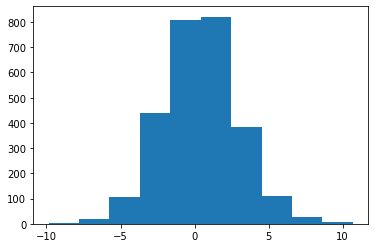

In [5]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(reply_user_description_data.loc[:, 'political_dim'])
plt.show()

Let's test some cutoff values.

In [11]:
import numpy as np
pd.set_option('display.max_colwidth', 250)
political_dim_cutoff_pct = [5,10,25]
display_cols = ['description', 'political_dim']
for cutoff_i in political_dim_cutoff_pct:
    high_cutoff_val_i = np.percentile(reply_user_description_data.loc[:, 'political_dim'].values, 100-cutoff_i)
    low_cutoff_val_i = np.percentile(reply_user_description_data.loc[:, 'political_dim'].values, cutoff_i)
    high_data_i = reply_user_description_data[reply_user_description_data.loc[:, 'political_dim'] >= high_cutoff_val_i]
    low_data_i = reply_user_description_data[reply_user_description_data.loc[:, 'political_dim'] <= low_cutoff_val_i]
    print(f'data >= {100-cutoff_i} (N={high_data_i.shape[0]})')
    display(high_data_i.sort_values('political_dim', ascending=True).head(20).loc[:, display_cols])
    print(f'data <= {cutoff_i}  (N={low_data_i.shape[0]})')
    display(low_data_i.sort_values('political_dim', ascending=False).head(20).loc[:, display_cols])

data >= 95 (N=137)


,description,political_dim
1333,"I retired after working 40-years with the fire service at the federal, state and local levels with eleven organizations!",4.555755
966,#unmaskourchildren,4.569044
955,#unmaskourchildren,4.569044
1606,"Journalism educator, grammarian, chile head and frighteningly large man. When I bump into people, they become debris. I also patrol Twitter as @comminternships.",4.585637
1807,"""The tree of liberty must be refreshed from time to time with the blood of patriots and tyrants. It is it's natural manure."" Thomas Jefferson, 13 Nov. 1787",4.598531
2592,"Follower of Christ, husband, father, pastor.",4.605001
127,Geopolitical Analyst - Researcher - Publisher\nExposing the dark side with #T3MasonicBrotherhood #T3OccultAstrology #T3Edit #T3Perspective,4.611354
190,"Don't follow me. I tend to overuse the word ""that"", binge tweet, delete and rarely follow back. 🤷‍♀️\n\n#COVID19",4.617389
2385,"Made in Turkey, Matured in Texas!",4.619271
1385,"Strong Patriot, who Totally Love God! I Love my Family & Friends and Our Country! I Love Our President of the United States, President Donald J. Trump!",4.624898


data <= 5  (N=137)


,description,political_dim
1194,Mom and OB Nurse Proudly Liberal. #Biden/Harris2020 No DMs unless I initiate.,-3.621783
740,"Never liked sci-fi movies, also NEVER imagined I would be living in one.",-3.633270
2242,They All Float,-3.640152
822,Here to amplify the sentiments of my fellow patriots via likes & retweets.\n\nGet the vaccine/ don't get the vaccine | Your choice always | Election Integrity,-3.655858
2716,Professional 50X Trader. Occasional Professional 10X trader. Studied TA under Mr Goxx. Expert of victimidiotology. Victim of victim idiotology.,-3.665197
1937,Do gooder.,-3.674474
1162,Freelance writer and book reviewer. Wife of writer Chris Holm. Lover of Maine. Meaner than she looks.,-3.705202
2061,Fighting for the Oregon we once knew and loved - one Tweet at a time. 🎯,-3.707862
2053,Fighting for the Oregon we once knew and loved - one Tweet at a time. 🎯,-3.707862
1989,Fighting for the Oregon we once knew and loved - one Tweet at a time. 🎯,-3.707862


data >= 90 (N=273)


,description,political_dim
1516,"Christ follower, Husband, Dad, Entrepreneur...",3.599703
6,#NoGOP \nI may RT you because I agree with you or because you are the biggest idiot to walk the earth.. Up to you to figure out which one.,3.600058
2044,"Car Accident Disabled, Childhood Abuse & Sex Assault Survivor, Socialist, Native Feminist, Animal Rights, #MeToo #BLM #MMIWG #WhileRestOfUsDie",3.601250
2693,🇺🇲#MAGA🇺🇲 \n💥TROLLS may GET MUTED💥\n🚫NO DMs🚫🇺🇸If you have 0 followers=BLOCK-then talk 2me on ur main account🇺🇸,3.606242
2360,I’m insane don't follow me,3.612892
1203,UNIPARTY \n\nRule # 1 Fuck what they think. \nRule #2 ~ See rule # 1 \n🔥 #FreeOurPeople,3.623394
2199,"Resident & #1 fan of the biggest little state in the union, Rhode Island. Weather & history nerd, dad of 3, husband of a saint. Kayaking is my sanity. 🌊",3.623459
2624,"Child of God. Wife, mom, nonna, sister, aunt, friend, professional, taxpayer. Sinner saved by grace. Prolife, pro gun. Constitutionalist.",3.625683
2036,"Young but not naive. Believe in individual rights and right to privacy. Love my God,family and my country.",3.627560
2603,24/7 help for West Virginians struggling with addiction or mental health issues. Call 1-844-HELP-4WV. Social media NOT monitored 24/7.,3.630628


data <= 10  (N=273)


,description,political_dim
1167,#LetsGoBrandon!,-2.754087
2288,IMMUNE! take advantage of a limited time offer: licking your drinking glass with coof germs. Build immunity the best way!,-2.759248
1795,"How do you tell a Communist? Well, it’s someone who reads Marx and Lenin. And how do you tell an anti-Communist? It’s someone who understands Marx and Lenin.",-2.762736
2171,Pushing to get our businesses open and our kids back in school,-2.775966
375,"Give me light, life, love. Wondering how people can be okay with being blind to the worlds utter clown state.",-2.777358
2312,"😎🤜🍿🍿🍿 🌟🌟🌟 GOD, Family, Country. NO DM's Pretty Please! IN IT TO WIN IT!",-2.784639
2163,We need a Green New Deal!,-2.790594
2608,"""Peace if possible. Truth at all costs."" -\nMartin Luther",-2.793186
2585,"Lover of sunshine☀: I'm here to educate, help, and entertain.",-2.793253
376,Botanical herbs,-2.794436


data >= 75 (N=682)


,description,political_dim
785,Retiree in Florida. Now living vicariously through a 3 year old grandson.,1.993736
1890,Political and meteorological takes | Occasional maps,1.997090
598,Left wing terrorists are my favorite! Let's see how long before I'm banned again!?! The new Steve R. Hampton account.MAGA! Blocked by little Kyle Clark! Yes!,2.000150
882,#CEO and #Founder of @empoweredpres Award Winning #PresentationDesign #Honolulu #Hawaii Specializing in #Powerpoint #Keynote #Presentations #PitchDecks,2.005990
886,#CEO and #Founder of @empoweredpres Award Winning #PresentationDesign #Honolulu #Hawaii Specializing in #Powerpoint #Keynote #Presentations #PitchDecks,2.005990
910,#CEO and #Founder of @empoweredpres Award Winning #PresentationDesign #Honolulu #Hawaii Specializing in #Powerpoint #Keynote #Presentations #PitchDecks,2.005990
1291,"Business Owner \nMom of 2\nNonie to 1\nWife\n\nHobbies: Cooking, Gardening, Swimming, Camping, Crosswords and more!",2.008265
1680,"Father, America First, Making Babies full term great again, Nuclear Energy=Green, 1A/2A, Toxic Masculinity Saves Lives, Trump Won 2020. Pronouns Get/Off/My/Lawn",2.010282
1279,The Salt Must Flow\n #SaltyArmy,2.014559
2539,"Abuse of words has been the great instrument of sophistry and chicanery, of party, faction, and division of society.\n\n#Bitcoin",2.016365


data <= 25  (N=682)


,description,political_dim
2501,"Peace, love, understanding...Unless you're a scourge to civilized society. Then F U.",-1.234239
805,"It's not the size of the dog in the fight, it's the size of the fight in the dog. Mark Twain #Resistance Personal goal is to be member Human Race",-1.239209
2110,"Forecasting coronal mass ejections before they leave the solar corona is a big deal. We do it, and if anybody else does, we aren't aware of it.",-1.241923
1753,Asst. Professor Health Sciences & Public Health. St. Bonaventure University. Wearer of masks.,-1.246226
2342,Psychological/Communal Patterns,-1.247810
50,"updated regularly, Gov. Ducey's death toll stats from https://t.co/H4iAf4dV8R A result of Ducey's laws against masks & his neglect, AZ the 5th highest death rate in the USA",-1.253828
107,"updated regularly, Gov. Ducey's death toll stats from https://t.co/H4iAf4dV8R A result of Ducey's laws against masks & his neglect, AZ the 5th highest death rate in the USA",-1.253828
91,"updated regularly, Gov. Ducey's death toll stats from https://t.co/H4iAf4dV8R A result of Ducey's laws against masks & his neglect, AZ the 5th highest death rate in the USA",-1.253828
2035,"Independent right leaning..........I won't argue, but I will block you. Please no DM's😊",-1.259343
1387,Unchecked immigration is destroying our country. We need to massively decrease immigration levels or every city will look like NY! #MAGA #FJB #WalkAway,-1.263046


OK! None of the cutoff points is perfect, but let's try setting the percentile cutoff at 25% so that the lower 25% are assigned "liberal" and the upper 25% are "conservative".

In [15]:
## save labels for later
final_cutoff_pct = 25
high_cutoff_val = np.percentile(reply_user_description_data.loc[:, 'political_dim'].values, 100-final_cutoff_pct)
low_cutoff_val = np.percentile(reply_user_description_data.loc[:, 'political_dim'].values, final_cutoff_pct)
reply_user_description_data = reply_user_description_data.assign(**{
    'political_class' : reply_user_description_data.loc[:, 'political_dim'].apply(lambda x: 'conservative' if x >= high_cutoff_val else 'liberal' if x <= low_cutoff_val else None)
})
print(reply_user_description_data.loc[:, 'political_class'].value_counts())
## rewrite to file
reply_user_description_data.to_csv('health_account_reply_user_description_data.gz', sep='\t', compression='gzip', index=False)

liberal         682
conservative    682
Name: political_class, dtype: int64


#### Question classification for reply authors
Now! Can we use the collected data to predict from a question (+ post), whether the reply author is (1) a local/non-local and (2) a (likely) liberal/conservative?

In [12]:
## reload etc.
import pandas as pd
reply_user_description_data = pd.read_csv('health_account_reply_user_description_data.gz', sep='\t', compression='gzip')
combined_timeline_reply_data = pd.read_csv('health_account_timeline_reply_data.gz', sep='\t', compression='gzip')

In [13]:
## add political label to reply data
if('political_class' not in combined_timeline_reply_data):
    combined_timeline_reply_data = pd.merge(combined_timeline_reply_data, 
                                            reply_user_description_data.loc[:, ['reply_user_name', 'political_class']],
                                            on='reply_user_name', how='left')
## data distribution
print(combined_timeline_reply_data.loc[:, 'reply_user_is_local'].value_counts())
print(combined_timeline_reply_data.loc[:, 'political_class'].value_counts())

1    5874
0    3339
Name: reply_user_is_local, dtype: int64
liberal         1283
conservative    1176
Name: political_class, dtype: int64


Let's do this the safe way first: can we match replies by post (e.g. one local and one non-local per post)?

In [61]:
## limit to data with questions
# extract questions
import re
from nltk.tokenize import sent_tokenize
question_matcher = re.compile('.+\?$')
combined_timeline_reply_data = combined_timeline_reply_data.assign(**{
    'reply_text_questions' : combined_timeline_reply_data.loc[:, 'reply_text'].apply(lambda x: list(filter(lambda y: question_matcher.match(y) is not None, sent_tokenize(x))))
})
combined_timeline_question_data = combined_timeline_reply_data[combined_timeline_reply_data.loc[:, 'reply_text_questions'].apply(lambda x: len(x) > 0)]
# save first question from list => simplify
combined_timeline_question_data = combined_timeline_question_data.assign(**{
    'reply_text_question' : combined_timeline_question_data.loc[:, 'reply_text_questions'].apply(lambda x: x[0])
})
display(combined_timeline_question_data.loc[:, 'reply_text_questions'].values[:5])
print(f'N={combined_timeline_question_data.shape[0]}/{combined_timeline_reply_data.shape[0]} data w/ questions')

array([list(['@ALPublicHealth How many died solely because of Covid?']),
       list(['Why take the risk?']), list(['@ALPublicHealth SO WHAT?']),
       list(['@jmsb1955 @ALPublicHealth link to that source please?']),
       list(['Sound familiar?'])], dtype=object)

N=1502/9213 data w/ questions


In [50]:
def sample_post_question_pairs(data, group_var, group_class_vals, id_var='conversation_id'):
    # get at least one pair of questions per post
    sample_data = []
    group_class_1, group_class_2 = group_class_vals
    for id_i, data_i in data.groupby(id_var):
        class_counts = data_i.loc[:, group_var].value_counts().sort_values(inplace=False, ascending=False)
        if(len(class_counts) == len(group_class_vals)):
            min_class = class_counts.index[-1]
            max_class = class_counts.index[0]
            N_min_class = class_counts.loc[min_class]
            N_max_class = class_counts.loc[max_class]
#             print(f'class counts = {class_counts}')
            # oversample min class to handle data sparsity
            min_class_data_i = data_i[data_i.loc[:, group_var]==min_class].sample(N_max_class, replace=True, random_state=123)
            max_class_data_i = data_i[data_i.loc[:, group_var]==max_class].sample(N_max_class, replace=False)
            sample_data_i = pd.concat([min_class_data_i, max_class_data_i], axis=0)
#             print(f'id={id_i} has question pair')
            sample_data.append(sample_data_i)
    sample_data = pd.concat(sample_data, axis=0)
    print(f'N={sample_data.shape[0]}/{data.shape[0]} paired data')
    return sample_data

In [53]:
group_vars = ['reply_user_is_local', 'political_class']
group_var_class_vals = {
    v : combined_timeline_question_data.loc[:, v].dropna().unique()
    for v in group_vars
}
convo_id_var = 'conversation_id'
sample_data = []
for group_var_i in group_vars:
    group_class_vals_i = group_var_class_vals[group_var_i]
    group_class_val_num_lookup_i = dict(zip(group_class_vals_i, range(len(group_class_vals_i))))
    sample_data_i = sample_post_question_pairs(combined_timeline_question_data, group_var_i, group_class_vals_i, id_var=convo_id_var)
    sample_data_i = sample_data_i.assign(**{
        'group_var' : group_var_i,
        # convert labels => num
        'group_val' : sample_data_i.loc[:, group_var_i].apply(group_class_val_num_lookup_i.get)
    })
    sample_data.append(sample_data_i)
sample_data = pd.concat(sample_data, axis=0)
print(sample_data.loc[:, ['group_var', 'group_val']].value_counts())
for v in group_vars:
    print(f'total counts for group = {v}')
    print(combined_timeline_question_data.loc[:, v].value_counts())

N=2184/1502 paired data
N=352/1502 paired data
group_var            group_val
reply_user_is_local  0            1092
                     1            1092
political_class      0             176
                     1             176
dtype: int64
total counts for group = reply_user_is_local
1    891
0    611
Name: reply_user_is_local, dtype: int64
total counts for group = political_class
liberal         161
conservative    158
Name: political_class, dtype: int64


These numbers are pretty small! 

Let's just compute the log-odds ratio for the vocabulary and look at the top words per class.

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize.casual import TweetTokenizer
import re
import numpy as np
PUNCT = list(';:,>?!.()[]/\\"\'*@')
USER_MATCHER = re.compile('@\w+')
TXT_REPLACERS = [
    [USER_MATCHER, '@USER'],
]
STOPS = stopwords.words('english') + PUNCT
def compute_log_odds(data, text_var, group_var):
    group_vals = data.loc[:, group_var].dropna().unique()
    group_word_counts = []
    tokenizer = TweetTokenizer()
    smooth_val = 1e-5
    for i, (group_val_i, data_i) in enumerate(data.groupby(group_var)):
        # get word counts
        cv = CountVectorizer(min_df=0., max_df=1., tokenizer=tokenizer.tokenize, stop_words=STOPS)
        clean_txt = data_i.loc[:, text_var]
        for matcher, sub in TXT_REPLACERS:
            clean_txt = clean_txt.apply(lambda x: matcher.sub(sub, x))
        dtm = cv.fit_transform(clean_txt)
        sorted_vocab = list(sorted(cv.vocabulary_.keys(), key=cv.vocabulary_.get))
        word_counts_i = pd.DataFrame([np.array(dtm.sum(axis=0))[0]], index=[group_val_i]).transpose()
        # normalize
        word_counts_i = word_counts_i / word_counts_i.sum()
        # align vocab
        word_counts_i.index = sorted_vocab
        group_word_counts.append(word_counts_i)
    group_word_counts = pd.concat(group_word_counts, axis=1)
    # fill na
    group_word_counts.fillna(0., inplace=True)
    # smooth for log
    group_word_counts += smooth_val
    group_val_1, group_val_2 = group_vals
    word_ratio = group_word_counts.loc[:, group_val_1] / group_word_counts.loc[:, group_val_2]
    word_ratio.dropna(inplace=True)
    word_ratio = word_ratio[~np.isinf(word_ratio)]
    # convert to log b/c YOLO
    word_ratio = np.log(word_ratio)
    word_ratio.sort_values(inplace=True, ascending=False)
    return (group_val_1, group_val_2), word_ratio

In [84]:
group_vars = ['reply_user_is_local', 'political_class']
text_var = 'reply_text_question'
for group_var_i in group_vars:
    print(f'log-odds data for var={group_var_i}')
    group_vals_i, word_ratio_i = compute_log_odds(combined_timeline_question_data, text_var, group_var_i)
    print(f'top words for group={group_vals_i[0]} =\n{word_ratio_i[word_ratio_i > 0.].head(20)}')
    print(f'top words for group={group_vals_i[1]} =\n{word_ratio_i[word_ratio_i < 0.].tail(20)}')

log-odds data for var=reply_user_is_local
top words for group=0 =
see         5.533453
anything    5.311297
using       5.178471
science     5.178471
risk        5.178471
include     5.025259
parents     5.025259
big         5.025259
approved    5.025259
believe     5.025259
country     4.844251
exactly     4.844251
cdc         4.844251
telling     4.844251
show        4.844251
pushing     4.623073
reported    4.623073
yes         4.623073
dead        4.623073
false       4.623073
dtype: float64
top words for group=1 =
curious            -3.730584
businesses         -3.985510
prevention         -4.049333
detect             -4.049333
positivity         -4.049333
jab                -4.049333
advice             -4.049333
age                -4.049333
nothing            -4.049333
…                  -4.129544
stupid             -4.332647
change             -4.550517
version            -5.361224
helping            -7.251331
measures           -7.251331
eyes               -7.808737
hospitaliza

- Location
    - `local`: COVID metrics (`measures`, `hospitalizations`, `positivity`, `prevention`), discourse (`repost`, `corrected`, `delete`)
    - `non-local`: authority (`cdc`, `country`), discussions (`approved`, `telling`, `pushing`, `reported`, `false`), framing (`risk`, `false`, `science`)
- Politics
    - `conservative`: discourse (`corrected`, `delete`, `repost`), health values (`safety`, `health`, `protect`)
    - `liberal`: health science (`immunity`, `hospitalizations`), cognitive (`change`, `curious`)

The data is too sparse to draw strong conclusions, but it looks like local responses to COVID health messages focus more on the account content itself and on-the-ground experiences, while non-local responses look at more systemic issues and general messaging.

The conservative responses focus on values and errors in content, and the liberal responses talk about health metrics.

In [ ]:
## TODO: same analysis but w/ HHS, CDC, etc.